# Poisson 2d
---

Consider the 2d Poisson Equation
\begin{equation}
\begin{aligned}
&\nabla \cdot (\sigma \nabla u) = f, \\
&\sigma \frac{\partial u}{\partial n}|_{\partial\Omega} = g, \\
\end{aligned}
\end{equation}
where the domain $\Omega = [0, 1]\times [0, 1]$, and the target field $\sigma(x, y) = 0.1\sin(\pi x) + 1.0$.
$f, g$ are chosen such that the exact solution is
\begin{equation}
u(x, y) = \exp(\pi y)\sin(\pi x).
\end{equation}

$f(x, y) = 0.1\pi^2\exp(\pi y)\cos^2(\pi x)$.

For the inverse problem, Dirichlet measurements are provided on the boundary.

We further assume the form of $\sigma$ is known, i.e.
\begin{equation}
\sigma(x, y) = a_2\sin(a_1 x) + a_0),
\end{equation}
and only invert $a_0, a_1, a_2$.

In [2]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("./"))))

import torch
import torch.nn as nn
import numpy as np

from pinn_lightning.pinn import PINN, InversePINN, Task
from pinn_lightning.data.dataset import PINNDataModule
from pinn_lightning.data.utils import tensor_grid, tensors_from_numpy
from pinn_lightning.utils.basic_nets import *
from pinn_lightning.utils.operators import grad, directional_grad

import pytorch_lightning as pl

%load_ext autoreload
%autoreload 2
%matplotlib notebook
%config Completer.use_jedi = False

import random
torch.manual_seed(1001)
np.random.seed(1001)
random.seed(1001)

torch.set_default_dtype(torch.float64)
device = torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Step 1: Define Model

In [3]:
class Poisson2d(InversePINN):	
	@property
	def pi(self):
		return torch.tensor(np.pi).to(self.device)
	
	def _sigma(self, x):
		return 0.1*torch.sin(self.pi*x) + 1.0
	
	def get_output(self, batch_input):
		(x_domain, y_domain), (x_n, y_n, normal), (x_d, y_d) = batch_input  # x_n: neumann BC; x_d: dirichlet measurements
		x_domain.requires_grad = True
		y_domain.requires_grad = True
		u_domain = self.forward(torch.hstack([x_domain, y_domain]))
		sigma_domain = self.inverse_module(torch.hstack([x_domain, y_domain]))
		
		eq = grad(grad(u_domain, x_domain)*sigma_domain, x_domain) + \
			grad(grad(u_domain, y_domain)*sigma_domain, y_domain) - \
			0.1*self.pi**2*torch.exp(self.pi*y_domain)*torch.cos(self.pi*x_domain)**2
		
		x_n.requires_grad = True
		y_n.requires_grad = True
		u_n = self.forward(torch.hstack([x_n, y_n]))
		u_grad = directional_grad(u_n, x_n, y_n, direction=normal)
		sigma_n = self.inverse_module(torch.hstack([x_n, y_n]))
		sigma = self._sigma(x_n)
		
		u_d = self.forward(torch.hstack([x_d, y_d]))
		return eq, u_grad*sigma, sigma_n-sigma, u_d
	
class SigmaModule(nn.Module):
	def __init__(self, a0, a1, a2):
		super().__init__()
		self.a0 = nn.Parameter(a0)
		self.a1 = nn.Parameter(a1)
		self.a2 = nn.Parameter(a2)
		
	def forward(self, xy):
		return self.a2*torch.sin(self.a1*xy[:, 0:1]) + self.a0
	
class PrintCallback(pl.callbacks.Callback):
	def on_train_batch_end(self, trainer, pl_module, *args, **kwargs):
		pl_module.log("a0", pl_module.inverse_module.a0, on_step=False, on_epoch=True)
		pl_module.log("a1", pl_module.inverse_module.a1, on_step=False, on_epoch=True)
		pl_module.log("a2", pl_module.inverse_module.a2, on_step=False, on_epoch=True)
	
forward_module = DenseNet(
	[2] + [32]*4 + [1], Swish,
)
inverse_module = SigmaModule(
	a0 = torch.tensor(0.0),
	a1 = torch.tensor(1.0),
	a2 = torch.tensor(1.0),
)

pinn = Poisson2d(forward_module, inverse_module)
pinn.configure_tasks(
	[
		Task(
			n_input = 2,
			n_output = 1,
			loss_fns = nn.MSELoss(),
			loss_weights = 1.0,
			names = "domain",
		),
		Task(
			n_input = 3,
			n_output = 2,
			loss_fns = nn.MSELoss(),
			loss_weights = 1.0,
			names = "neumann",
		),
		Task(
			n_input = 2,
			n_output = 1,
			loss_fns = nn.MSELoss(),
			loss_weights = 1.0,
			names = "dirichlet",
		),
	]
)
optimizer = torch.optim.Adam(
	[
		{
			"params": pinn.param_groups[0],
			"lr": 1e-2,
			"weight_decay": 0
		},
		{
			"params": pinn.param_groups[1],
			"lr": 1e-2,
			"weight_decay": 0,
		},
	]
)
pinn.configure_optimizers_and_schedulers(
	optimizer = optimizer,
	lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
		optimizer,
		factor = 0.8,
		patience = 100,
		threshold = 1e-6,
		min_lr = 1e-4,
	),
)
pinn

Poisson2d(
  (forward_module): DenseNet(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): Swish()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Swish()
      (4): Linear(in_features=32, out_features=32, bias=True)
      (5): Swish()
      (6): Linear(in_features=32, out_features=32, bias=True)
      (7): Swish()
      (8): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (inverse_module): SigmaModule()
)

# Step 2: Generate Dataset

In [5]:
x_1d = np.linspace(0, 1, 101).reshape((-1, 1))
y_1d = np.linspace(0, 1, 99).reshape((-1, 1))
xy = tensor_grid([x_1d, y_1d])
x_domain, y_domain = xy[:, 0:1], xy[:, 1:2]
u_domain = np.zeros_like(x_domain)

x_bc_1d = np.linspace(0, 1, 1001).reshape((-1, 1))
y_bc_1d = np.linspace(0, 1, 999).reshape((-1, 1))
xy_bc = np.vstack(
	[
		np.hstack([x_bc_1d, 0*np.ones_like(x_bc_1d)]),
		np.hstack([np.ones_like(y_bc_1d), y_bc_1d]),
		np.hstack([x_bc_1d, np.ones_like(x_bc_1d)]),
		np.hstack([0*np.ones_like(y_bc_1d), y_bc_1d]),
	]
)
normal = np.vstack(
	[
		np.hstack([np.zeros_like(x_bc_1d), -1*np.ones_like(x_bc_1d)]),
		np.hstack([np.ones_like(y_bc_1d), np.zeros_like(y_bc_1d)]),
		np.hstack([np.zeros_like(x_bc_1d), np.ones_like(x_bc_1d)]),
		np.hstack([-np.ones_like(y_bc_1d), np.zeros_like(y_bc_1d)]),
	]
)
x_d, y_d = xy_bc[:, 0:1], xy_bc[:, 1:2]
u_fn = lambda x, y: np.exp(np.pi*y)*np.sin(np.pi*x)
u_d = u_fn(x_d, y_d)

x_n, y_n = x_d, y_d
du_dx_fn = lambda x, y: np.pi*np.exp(np.pi*y)*np.cos(np.pi*x)
du_dy_fn = lambda x, y: np.pi*np.exp(np.pi*y)*np.sin(np.pi*x)
sigma_fn = lambda x, y: 1.0 + 0.1*np.sin(np.pi*x)
sigma_n = sigma_fn(x_n, y_n)
u_n = (du_dx_fn(x_n, y_n)*normal[:, 0:1] + du_dy_fn(x_n, y_n)*normal[:, 1:2])*sigma_n
sigma_n_target = np.zeros_like(sigma_n)

In [6]:
dataset_domain = torch.utils.data.TensorDataset(
	*tensors_from_numpy(x_domain, y_domain, u_domain),
)
dataset_n = torch.utils.data.TensorDataset(
	*tensors_from_numpy(x_n, y_n, normal, u_n, sigma_n_target),
)
dataset_d = torch.utils.data.TensorDataset(
	*tensors_from_numpy(x_d, y_d, u_d),
)

poisson_data_module = PINNDataModule(
	datasets = [dataset_domain, dataset_n, dataset_d],
	collate_fns = [None, None, None],
	valid_splits = [0.2, 0.2, 0.2],
	batch_sizes = [40000, 4000, 4000],
	shuffle = [True, True, True],
)

# Step 3: training

In [7]:
trainer = pl.Trainer(
	max_epochs=20000,
	gpus=1,
	logger=True,
	callbacks=[
		pl.callbacks.EarlyStopping(monitor="valid_loss", patience=10000),
        pl.callbacks.ModelCheckpoint(dirpath="models", save_last=True, save_top_k=1),
		pl.callbacks.LearningRateMonitor(logging_interval='step'),
		PrintCallback(),
	],
	log_every_n_steps=10,
)
trainer.fit(
	pinn,
	poisson_data_module,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Missing logger folder: /home/chuan/GitHub/PINN_lightning/examples/example_3_Poisson_2d_inverse_smooth_field/lightning_logs

  | Name           | Type        | Params
-----------------------------------------------
0 | forward_module | DenseNet    | 3.3 K 
1 | inverse_module | SigmaModule | 3     
-----------------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)


/home/chuan/venv/python3.9/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1999. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Epoch 0: : 1it [00:00,  3.99it/s, loss=1.31e+03, v_num=0]

/home/chuan/venv/python3.9/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8000. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(



Validating: 0it [00:00, ?it/s]
Epoch 0: : 3it [00:00,  8.79it/s, loss=1.31e+03, v_num=0]
Epoch 1: : 1it [00:00,  4.23it/s, loss=1.31e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1: : 3it [00:00,  9.34it/s, loss=1.31e+03, v_num=0]
Epoch 2: : 1it [00:00,  4.22it/s, loss=1.31e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2: : 3it [00:00,  9.56it/s, loss=1.31e+03, v_num=0]
Epoch 3: : 1it [00:00,  3.96it/s, loss=1.31e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: : 3it [00:00,  8.81it/s, loss=1.31e+03, v_num=0]
Epoch 4: : 1it [00:00,  4.38it/s, loss=1.3e+03, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 4: : 3it [00:00, 10.04it/s, loss=1.3e+03, v_num=0]
Epoch 5: : 1it [00:00,  4.24it/s, loss=1.3e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5: : 3it [00:00,  9.01it/s, loss=1.3e+03, v_num=0]
Epoch 6: : 1it [00:00,  4.27it/s, loss=1.3e+03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6: : 3it [00:00,  9.19it/s, loss=1.3e+03, v_num=0]
Epoch 7: : 1it [00:00,  4.19it/s,

Epoch 53: : 3it [00:00,  8.89it/s, loss=175, v_num=0]
Epoch 54: : 1it [00:00,  4.17it/s, loss=169, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 54: : 3it [00:00,  9.32it/s, loss=169, v_num=0]
Epoch 55: : 1it [00:00,  3.79it/s, loss=163, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 55: : 3it [00:00,  8.45it/s, loss=163, v_num=0]
Epoch 56: : 1it [00:00,  3.97it/s, loss=158, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 56: : 3it [00:00,  8.88it/s, loss=158, v_num=0]
Epoch 57: : 1it [00:00,  4.10it/s, loss=153, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 57: : 3it [00:00,  9.47it/s, loss=153, v_num=0]
Epoch 58: : 1it [00:00,  4.01it/s, loss=148, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 58: : 3it [00:00,  8.89it/s, loss=148, v_num=0]
Epoch 59: : 1it [00:00,  4.27it/s, loss=144, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 59: : 3it [00:00,  9.43it/s, loss=144, v_num=0]
Epoch 60: : 1it [00:00,  4.40it/s, loss=139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 60: : 3it [00:00,  9.

Epoch 108: : 1it [00:00,  4.12it/s, loss=19.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 108: : 3it [00:00,  9.49it/s, loss=19.2, v_num=0]
Epoch 109: : 1it [00:00,  4.00it/s, loss=18.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 109: : 3it [00:00,  9.24it/s, loss=18.5, v_num=0]
Epoch 110: : 1it [00:00,  4.43it/s, loss=18, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 110: : 3it [00:00,  9.67it/s, loss=18, v_num=0]
Epoch 111: : 1it [00:00,  4.58it/s, loss=17.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 111: : 3it [00:00, 10.11it/s, loss=17.5, v_num=0]
Epoch 112: : 1it [00:00,  3.70it/s, loss=17, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 112: : 3it [00:00,  8.82it/s, loss=17, v_num=0]
Epoch 113: : 1it [00:00,  3.96it/s, loss=16.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 113: : 3it [00:00,  8.63it/s, loss=16.6, v_num=0]
Epoch 114: : 1it [00:00,  3.78it/s, loss=16.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 114: : 3it [00:00,  8.94it/s, loss=16.2, v_num=0]
Epo

Epoch 161: : 3it [00:00,  9.56it/s, loss=19.5, v_num=0]
Epoch 162: : 1it [00:00,  4.11it/s, loss=18.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 162: : 3it [00:00,  8.98it/s, loss=18.2, v_num=0]
Epoch 163: : 1it [00:00,  3.93it/s, loss=17.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 163: : 3it [00:00,  9.00it/s, loss=17.2, v_num=0]
Epoch 164: : 1it [00:00,  4.12it/s, loss=17.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 164: : 3it [00:00,  9.61it/s, loss=17.3, v_num=0]
Epoch 165: : 1it [00:00,  4.31it/s, loss=16.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 165: : 3it [00:00,  9.39it/s, loss=16.6, v_num=0]
Epoch 166: : 1it [00:00,  4.02it/s, loss=15.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 166: : 3it [00:00,  9.24it/s, loss=15.6, v_num=0]
Epoch 167: : 1it [00:00,  4.57it/s, loss=15.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 167: : 3it [00:00,  9.74it/s, loss=15.6, v_num=0]
Epoch 168: : 1it [00:00,  4.30it/s, loss=14.9, v_num=0]
Validating: 0it [00:00, ?it/s]

Epoch 215: : 1it [00:00,  4.25it/s, loss=6.57, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 215: : 3it [00:00,  9.20it/s, loss=6.57, v_num=0]
Epoch 216: : 1it [00:00,  3.71it/s, loss=6.52, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 216: : 3it [00:00,  8.28it/s, loss=6.52, v_num=0]
Epoch 217: : 1it [00:00,  3.94it/s, loss=6.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 217: : 3it [00:00,  8.76it/s, loss=6.47, v_num=0]
Epoch 218: : 1it [00:00,  4.05it/s, loss=6.43, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 218: : 3it [00:00,  9.26it/s, loss=6.43, v_num=0]
Epoch 219: : 1it [00:00,  4.06it/s, loss=6.38, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 219: : 3it [00:00,  8.69it/s, loss=6.38, v_num=0]
Epoch 220: : 1it [00:00,  3.83it/s, loss=6.33, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 220: : 3it [00:00,  9.02it/s, loss=6.33, v_num=0]
Epoch 221: : 1it [00:00,  3.77it/s, loss=6.29, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 221: : 3it [00:00,  8.33it/s, loss=6.29, v_num=0]

Epoch 268: : 3it [00:00,  9.20it/s, loss=13.4, v_num=0]
Epoch 269: : 1it [00:00,  4.23it/s, loss=13.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 269: : 3it [00:00,  9.88it/s, loss=13.5, v_num=0]
Epoch 270: : 1it [00:00,  4.09it/s, loss=13.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 270: : 3it [00:00,  8.90it/s, loss=13.5, v_num=0]
Epoch 271: : 1it [00:00,  4.32it/s, loss=13.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 271: : 3it [00:00,  9.52it/s, loss=13.5, v_num=0]
Epoch 272: : 1it [00:00,  4.26it/s, loss=13.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 272: : 3it [00:00,  9.73it/s, loss=13.3, v_num=0]
Epoch 273: : 1it [00:00,  4.08it/s, loss=12.7, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 273: : 3it [00:00,  8.98it/s, loss=12.7, v_num=0]
Epoch 274: : 1it [00:00,  3.73it/s, loss=11.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 274: : 3it [00:00,  8.30it/s, loss=11.5, v_num=0]
Epoch 275: : 1it [00:00,  3.95it/s, loss=9.49, v_num=0]
Validating: 0it [00:00, ?it/s]

Epoch 322: : 1it [00:00,  4.15it/s, loss=4.19, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 322: : 3it [00:00,  9.52it/s, loss=4.19, v_num=0]
Epoch 323: : 1it [00:00,  4.33it/s, loss=4.17, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 323: : 3it [00:00, 10.06it/s, loss=4.17, v_num=0]
Epoch 324: : 1it [00:00,  4.20it/s, loss=4.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 324: : 3it [00:00,  9.02it/s, loss=4.14, v_num=0]
Epoch 325: : 1it [00:00,  4.54it/s, loss=4.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 325: : 3it [00:00,  9.77it/s, loss=4.12, v_num=0]
Epoch 326: : 1it [00:00,  3.87it/s, loss=4.1, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 326: : 3it [00:00,  8.87it/s, loss=4.1, v_num=0]
Epoch 327: : 1it [00:00,  3.80it/s, loss=4.08, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 327: : 3it [00:00,  8.50it/s, loss=4.08, v_num=0]
Epoch 328: : 1it [00:00,  3.74it/s, loss=4.06, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 328: : 3it [00:00,  8.46it/s, loss=4.06, v_num=0]


Validating: 0it [00:00, ?it/s]
Epoch 375: : 3it [00:00,  9.34it/s, loss=8.16, v_num=0]
Epoch 376: : 1it [00:00,  4.06it/s, loss=8.18, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 376: : 3it [00:00,  9.01it/s, loss=8.18, v_num=0]
Epoch 377: : 1it [00:00,  4.44it/s, loss=7.77, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 377: : 3it [00:00,  9.65it/s, loss=7.77, v_num=0]
Epoch 378: : 1it [00:00,  4.27it/s, loss=7.18, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 378: : 3it [00:00,  9.93it/s, loss=7.18, v_num=0]
Epoch 379: : 1it [00:00,  4.42it/s, loss=7.18, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 379: : 3it [00:00, 10.10it/s, loss=7.18, v_num=0]
Epoch 380: : 1it [00:00,  3.95it/s, loss=6.85, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 380: : 3it [00:00,  8.97it/s, loss=6.85, v_num=0]
Epoch 381: : 1it [00:00,  4.09it/s, loss=6.46, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 381: : 3it [00:00,  8.97it/s, loss=6.46, v_num=0]
Epoch 382: : 1it [00:00,  3.80it/s, loss=6.43, v_num=0]

Epoch 428: : 3it [00:00,  8.78it/s, loss=3.37, v_num=0]
Epoch 429: : 1it [00:00,  3.78it/s, loss=3.35, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 429: : 3it [00:00,  8.72it/s, loss=3.35, v_num=0]
Epoch 430: : 1it [00:00,  4.25it/s, loss=3.34, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 430: : 3it [00:00,  9.87it/s, loss=3.34, v_num=0]
Epoch 431: : 1it [00:00,  4.28it/s, loss=3.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 431: : 3it [00:00,  9.66it/s, loss=3.32, v_num=0]
Epoch 432: : 1it [00:00,  3.94it/s, loss=3.31, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 432: : 3it [00:00,  9.16it/s, loss=3.31, v_num=0]
Epoch 433: : 1it [00:00,  4.14it/s, loss=3.29, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 433: : 3it [00:00,  8.85it/s, loss=3.29, v_num=0]
Epoch 434: : 1it [00:00,  3.82it/s, loss=3.27, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 434: : 3it [00:00,  8.61it/s, loss=3.27, v_num=0]
Epoch 435: : 1it [00:00,  4.25it/s, loss=3.26, v_num=0]
Validating: 0it [00:00, ?it/s]

Epoch 482: : 1it [00:00,  3.76it/s, loss=2.74, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 482: : 3it [00:00,  8.41it/s, loss=2.74, v_num=0]
Epoch 483: : 1it [00:00,  4.27it/s, loss=2.75, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 483: : 3it [00:00,  9.09it/s, loss=2.75, v_num=0]
Epoch 484: : 1it [00:00,  4.30it/s, loss=2.81, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 484: : 3it [00:00,  9.65it/s, loss=2.81, v_num=0]
Epoch 485: : 1it [00:00,  3.91it/s, loss=2.96, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 485: : 3it [00:00,  8.97it/s, loss=2.96, v_num=0]
Epoch 486: : 1it [00:00,  4.44it/s, loss=3.35, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 486: : 3it [00:00,  9.52it/s, loss=3.35, v_num=0]
Epoch 487: : 1it [00:00,  3.88it/s, loss=4.19, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 487: : 3it [00:00,  8.93it/s, loss=4.19, v_num=0]
Epoch 488: : 1it [00:00,  4.22it/s, loss=5.87, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 488: : 3it [00:00,  9.25it/s, loss=5.87, v_num=0]

Epoch 535: : 3it [00:00,  9.22it/s, loss=4.12, v_num=0]
Epoch 536: : 1it [00:00,  4.31it/s, loss=4.08, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 536: : 3it [00:00,  9.49it/s, loss=4.08, v_num=0]
Epoch 537: : 1it [00:00,  3.89it/s, loss=3.96, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 537: : 3it [00:00,  8.96it/s, loss=3.96, v_num=0]
Epoch 538: : 1it [00:00,  4.02it/s, loss=3.89, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 538: : 3it [00:00,  8.80it/s, loss=3.89, v_num=0]
Epoch 539: : 1it [00:00,  4.07it/s, loss=3.84, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 539: : 3it [00:00,  9.15it/s, loss=3.84, v_num=0]
Epoch 540: : 1it [00:00,  3.95it/s, loss=3.75, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 540: : 3it [00:00,  8.81it/s, loss=3.75, v_num=0]
Epoch 541: : 1it [00:00,  4.23it/s, loss=3.72, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 541: : 3it [00:00,  9.62it/s, loss=3.72, v_num=0]
Epoch 542: : 1it [00:00,  4.04it/s, loss=3.63, v_num=0]
Validating: 0it [00:00, ?it/s]

Epoch 589: : 1it [00:00,  3.64it/s, loss=2.67, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 589: : 3it [00:00,  8.30it/s, loss=2.67, v_num=0]
Epoch 590: : 1it [00:00,  4.20it/s, loss=2.66, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 590: : 3it [00:00,  9.80it/s, loss=2.66, v_num=0]
Epoch 591: : 1it [00:00,  4.47it/s, loss=2.65, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 591: : 3it [00:00,  9.94it/s, loss=2.65, v_num=0]
Epoch 592: : 1it [00:00,  4.22it/s, loss=2.64, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 592: : 3it [00:00,  9.89it/s, loss=2.64, v_num=0]
Epoch 593: : 1it [00:00,  3.98it/s, loss=2.63, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 593: : 3it [00:00,  9.06it/s, loss=2.63, v_num=0]
Epoch 594: : 1it [00:00,  4.57it/s, loss=2.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 594: : 3it [00:00,  9.56it/s, loss=2.62, v_num=0]
Epoch 595: : 1it [00:00,  4.65it/s, loss=2.61, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 595: : 3it [00:00, 10.31it/s, loss=2.61, v_num=0]

Validating: 0it [00:00, ?it/s]
Epoch 642: : 3it [00:00,  8.98it/s, loss=2.22, v_num=0]
Epoch 643: : 1it [00:00,  4.46it/s, loss=2.22, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 643: : 3it [00:00,  9.55it/s, loss=2.22, v_num=0]
Epoch 644: : 1it [00:00,  4.41it/s, loss=2.21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 644: : 3it [00:00, 10.25it/s, loss=2.21, v_num=0]
Epoch 645: : 1it [00:00,  4.20it/s, loss=2.2, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 645: : 3it [00:00,  9.30it/s, loss=2.2, v_num=0]
Epoch 646: : 1it [00:00,  3.76it/s, loss=2.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 646: : 3it [00:00,  8.44it/s, loss=2.2, v_num=0]
Epoch 647: : 1it [00:00,  4.59it/s, loss=2.19, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 647: : 3it [00:00, 10.15it/s, loss=2.19, v_num=0]
Epoch 648: : 1it [00:00,  4.54it/s, loss=2.19, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 648: : 3it [00:00, 10.05it/s, loss=2.19, v_num=0]
Epoch 649: : 1it [00:00,  4.33it/s, loss=2.18, v_num=0]
Va

Epoch 695: : 3it [00:00,  8.54it/s, loss=16.8, v_num=0]
Epoch 696: : 1it [00:00,  4.05it/s, loss=15.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 696: : 3it [00:00,  8.92it/s, loss=15.3, v_num=0]
Epoch 697: : 1it [00:00,  4.13it/s, loss=13, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 697: : 3it [00:00,  9.04it/s, loss=13, v_num=0]
Epoch 698: : 1it [00:00,  3.89it/s, loss=12.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 698: : 3it [00:00,  8.87it/s, loss=12.8, v_num=0]
Epoch 699: : 1it [00:00,  3.95it/s, loss=12.5, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 699: : 3it [00:00,  8.74it/s, loss=12.5, v_num=0]
Epoch 700: : 1it [00:00,  3.72it/s, loss=10.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 700: : 3it [00:00,  8.86it/s, loss=10.9, v_num=0]
Epoch 701: : 1it [00:00,  3.86it/s, loss=10.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 701: : 3it [00:00,  8.90it/s, loss=10.6, v_num=0]
Epoch 702: : 1it [00:00,  4.15it/s, loss=10.1, v_num=0]
Validating: 0it [00:00, ?it/s]
E

Epoch 749: : 1it [00:00,  4.32it/s, loss=2.54, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 749: : 3it [00:00,  9.35it/s, loss=2.54, v_num=0]
Epoch 750: : 1it [00:00,  4.40it/s, loss=2.52, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 750: : 3it [00:00,  9.30it/s, loss=2.52, v_num=0]
Epoch 751: : 1it [00:00,  3.87it/s, loss=2.51, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 751: : 3it [00:00,  8.96it/s, loss=2.51, v_num=0]
Epoch 752: : 1it [00:00,  4.05it/s, loss=2.49, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 752: : 3it [00:00,  9.02it/s, loss=2.49, v_num=0]
Epoch 753: : 1it [00:00,  4.37it/s, loss=2.48, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 753: : 3it [00:00,  9.54it/s, loss=2.48, v_num=0]
Epoch 754: : 1it [00:00,  4.26it/s, loss=2.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 754: : 3it [00:00,  9.75it/s, loss=2.47, v_num=0]
Epoch 755: : 1it [00:00,  4.41it/s, loss=2.45, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 755: : 3it [00:00,  9.34it/s, loss=2.45, v_num=0]

Epoch 802: : 3it [00:00,  9.51it/s, loss=2.07, v_num=0]
Epoch 803: : 1it [00:00,  4.19it/s, loss=2.06, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 803: : 3it [00:00,  9.33it/s, loss=2.06, v_num=0]
Epoch 804: : 1it [00:00,  4.27it/s, loss=2.06, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 804: : 3it [00:00,  9.35it/s, loss=2.06, v_num=0]
Epoch 805: : 1it [00:00,  3.81it/s, loss=2.05, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 805: : 3it [00:00,  8.87it/s, loss=2.05, v_num=0]
Epoch 806: : 1it [00:00,  4.25it/s, loss=2.05, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 806: : 3it [00:00,  9.51it/s, loss=2.05, v_num=0]
Epoch 807: : 1it [00:00,  4.54it/s, loss=2.04, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 807: : 3it [00:00,  9.84it/s, loss=2.04, v_num=0]
Epoch 808: : 1it [00:00,  3.42it/s, loss=2.04, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 808: : 3it [00:00,  7.80it/s, loss=2.04, v_num=0]
Epoch 809: : 1it [00:00,  4.03it/s, loss=2.03, v_num=0]
Validating: 0it [00:00, ?it/s]

Epoch 856: : 1it [00:00,  4.09it/s, loss=1.82, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 856: : 3it [00:00,  9.04it/s, loss=1.82, v_num=0]
Epoch 857: : 1it [00:00,  3.38it/s, loss=1.81, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 857: : 3it [00:00,  7.91it/s, loss=1.81, v_num=0]
Epoch 858: : 1it [00:00,  3.96it/s, loss=1.81, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 858: : 3it [00:00,  8.82it/s, loss=1.81, v_num=0]
Epoch 859: : 1it [00:00,  3.63it/s, loss=1.8, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 859: : 3it [00:00,  8.43it/s, loss=1.8, v_num=0]
Epoch 860: : 1it [00:00,  4.62it/s, loss=1.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 860: : 3it [00:00,  9.98it/s, loss=1.8, v_num=0]
Epoch 861: : 1it [00:00,  4.64it/s, loss=1.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 861: : 3it [00:00,  9.74it/s, loss=1.8, v_num=0]
Epoch 862: : 1it [00:00,  4.65it/s, loss=1.79, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 862: : 3it [00:00, 10.44it/s, loss=1.79, v_num=0]
Epoc

Epoch 909: : 3it [00:00,  9.10it/s, loss=1.63, v_num=0]
Epoch 910: : 1it [00:00,  4.28it/s, loss=1.63, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 910: : 3it [00:00,  9.19it/s, loss=1.63, v_num=0]
Epoch 911: : 1it [00:00,  4.11it/s, loss=1.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 911: : 3it [00:00,  9.16it/s, loss=1.62, v_num=0]
Epoch 912: : 1it [00:00,  3.98it/s, loss=1.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 912: : 3it [00:00,  9.11it/s, loss=1.62, v_num=0]
Epoch 913: : 1it [00:00,  4.14it/s, loss=1.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 913: : 3it [00:00,  9.39it/s, loss=1.62, v_num=0]
Epoch 914: : 1it [00:00,  4.12it/s, loss=1.61, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 914: : 3it [00:00,  9.40it/s, loss=1.61, v_num=0]
Epoch 915: : 1it [00:00,  4.33it/s, loss=1.61, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 915: : 3it [00:00,  9.79it/s, loss=1.61, v_num=0]
Epoch 916: : 1it [00:00,  4.03it/s, loss=1.61, v_num=0]
Validating: 0it [00:00, ?it/s]

Epoch 963: : 1it [00:00,  4.16it/s, loss=1.48, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 963: : 3it [00:00,  9.56it/s, loss=1.48, v_num=0]
Epoch 964: : 1it [00:00,  3.86it/s, loss=1.48, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 964: : 3it [00:00,  9.17it/s, loss=1.48, v_num=0]
Epoch 965: : 1it [00:00,  4.16it/s, loss=1.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 965: : 3it [00:00,  9.09it/s, loss=1.47, v_num=0]
Epoch 966: : 1it [00:00,  3.47it/s, loss=1.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 966: : 3it [00:00,  8.02it/s, loss=1.47, v_num=0]
Epoch 967: : 1it [00:00,  3.94it/s, loss=1.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 967: : 3it [00:00,  8.91it/s, loss=1.47, v_num=0]
Epoch 968: : 1it [00:00,  4.25it/s, loss=1.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 968: : 3it [00:00,  9.51it/s, loss=1.47, v_num=0]
Epoch 969: : 1it [00:00,  4.00it/s, loss=1.46, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 969: : 3it [00:00,  8.80it/s, loss=1.46, v_num=0]

Epoch 1016: : 1it [00:00,  3.99it/s, loss=13.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1016: : 3it [00:00,  8.88it/s, loss=13.2, v_num=0]
Epoch 1017: : 1it [00:00,  4.00it/s, loss=12.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1017: : 3it [00:00,  8.91it/s, loss=12.8, v_num=0]
Epoch 1018: : 1it [00:00,  4.08it/s, loss=12, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 1018: : 3it [00:00,  9.32it/s, loss=12, v_num=0]
Epoch 1019: : 1it [00:00,  4.29it/s, loss=10.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1019: : 3it [00:00,  9.45it/s, loss=10.8, v_num=0]
Epoch 1020: : 1it [00:00,  3.90it/s, loss=10.8, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1020: : 3it [00:00,  8.40it/s, loss=10.8, v_num=0]
Epoch 1021: : 1it [00:00,  4.39it/s, loss=9.25, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1021: : 3it [00:00,  9.58it/s, loss=9.25, v_num=0]
Epoch 1022: : 1it [00:00,  4.11it/s, loss=8.3, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 1022: : 3it [00:00,  9.38it/s, loss=8.

Epoch 1069: : 1it [00:00,  4.07it/s, loss=1.98, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1069: : 3it [00:00,  9.10it/s, loss=1.98, v_num=0]
Epoch 1070: : 1it [00:00,  4.40it/s, loss=1.97, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1070: : 3it [00:00,  9.83it/s, loss=1.97, v_num=0]
Epoch 1071: : 1it [00:00,  4.41it/s, loss=1.96, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1071: : 3it [00:00,  9.89it/s, loss=1.96, v_num=0]
Epoch 1072: : 1it [00:00,  4.59it/s, loss=1.95, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1072: : 3it [00:00,  9.74it/s, loss=1.95, v_num=0]
Epoch 1073: : 1it [00:00,  4.08it/s, loss=1.94, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1073: : 3it [00:00,  9.32it/s, loss=1.94, v_num=0]
Epoch 1074: : 1it [00:00,  4.60it/s, loss=1.93, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1074: : 3it [00:00, 10.36it/s, loss=1.93, v_num=0]
Epoch 1075: : 1it [00:00,  4.65it/s, loss=1.92, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1075: : 3it [00:00, 10.37it/s, loss=

Epoch 1121: : 3it [00:00,  9.12it/s, loss=1.7, v_num=0]
Epoch 1122: : 1it [00:00,  4.07it/s, loss=1.69, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1122: : 3it [00:00,  8.91it/s, loss=1.69, v_num=0]
Epoch 1123: : 1it [00:00,  4.35it/s, loss=1.69, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1123: : 3it [00:00,  9.81it/s, loss=1.69, v_num=0]
Epoch 1124: : 1it [00:00,  3.87it/s, loss=1.69, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1124: : 3it [00:00,  8.72it/s, loss=1.69, v_num=0]
Epoch 1125: : 1it [00:00,  4.07it/s, loss=1.68, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1125: : 3it [00:00,  9.49it/s, loss=1.68, v_num=0]
Epoch 1126: : 1it [00:00,  4.19it/s, loss=1.68, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1126: : 3it [00:00,  9.47it/s, loss=1.68, v_num=0]
Epoch 1127: : 1it [00:00,  3.96it/s, loss=1.68, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1127: : 3it [00:00,  8.82it/s, loss=1.68, v_num=0]
Epoch 1128: : 1it [00:00,  4.24it/s, loss=1.67, v_num=0]
Validating: 0it [

Validating: 0it [00:00, ?it/s]
Epoch 1174: : 3it [00:00,  9.93it/s, loss=1.53, v_num=0]
Epoch 1175: : 1it [00:00,  4.17it/s, loss=1.53, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1175: : 3it [00:00,  9.08it/s, loss=1.53, v_num=0]
Epoch 1176: : 1it [00:00,  4.19it/s, loss=1.52, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1176: : 3it [00:00,  9.48it/s, loss=1.52, v_num=0]
Epoch 1177: : 1it [00:00,  3.78it/s, loss=1.52, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1177: : 3it [00:00,  8.88it/s, loss=1.52, v_num=0]
Epoch 1178: : 1it [00:00,  3.97it/s, loss=1.52, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1178: : 3it [00:00,  8.43it/s, loss=1.52, v_num=0]
Epoch 1179: : 1it [00:00,  3.73it/s, loss=1.52, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1179: : 3it [00:00,  8.64it/s, loss=1.52, v_num=0]
Epoch 1180: : 1it [00:00,  4.22it/s, loss=1.51, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1180: : 3it [00:00,  9.51it/s, loss=1.51, v_num=0]
Epoch 1181: : 1it [00:00,  4.44it/s, loss=

Epoch 1227: : 1it [00:00,  4.15it/s, loss=1.41, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1227: : 3it [00:00,  9.10it/s, loss=1.41, v_num=0]
Epoch 1228: : 1it [00:00,  4.01it/s, loss=1.41, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1228: : 3it [00:00,  9.18it/s, loss=1.41, v_num=0]
Epoch 1229: : 1it [00:00,  3.72it/s, loss=1.41, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1229: : 3it [00:00,  8.57it/s, loss=1.41, v_num=0]
Epoch 1230: : 1it [00:00,  4.03it/s, loss=1.41, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1230: : 3it [00:00,  8.56it/s, loss=1.41, v_num=0]
Epoch 1231: : 1it [00:00,  4.53it/s, loss=1.4, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 1231: : 3it [00:00,  9.75it/s, loss=1.4, v_num=0]
Epoch 1232: : 1it [00:00,  4.63it/s, loss=1.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1232: : 3it [00:00,  9.93it/s, loss=1.4, v_num=0]
Epoch 1233: : 1it [00:00,  4.30it/s, loss=1.4, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1233: : 3it [00:00,  9.40it/s, loss=1.4,

Epoch 1279: : 3it [00:00,  8.64it/s, loss=1.32, v_num=0]
Epoch 1280: : 1it [00:00,  4.24it/s, loss=1.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1280: : 3it [00:00,  9.29it/s, loss=1.32, v_num=0]
Epoch 1281: : 1it [00:00,  4.70it/s, loss=1.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1281: : 3it [00:00, 10.02it/s, loss=1.32, v_num=0]
Epoch 1282: : 1it [00:00,  4.04it/s, loss=1.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1282: : 3it [00:00,  9.26it/s, loss=1.32, v_num=0]
Epoch 1283: : 1it [00:00,  4.40it/s, loss=1.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1283: : 3it [00:00,  9.56it/s, loss=1.32, v_num=0]
Epoch 1284: : 1it [00:00,  4.24it/s, loss=1.31, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1284: : 3it [00:00,  9.23it/s, loss=1.31, v_num=0]
Epoch 1285: : 1it [00:00,  4.18it/s, loss=1.31, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1285: : 3it [00:00,  9.13it/s, loss=1.31, v_num=0]
Epoch 1286: : 1it [00:00,  4.00it/s, loss=1.31, v_num=0]
Validating: 0it 

Epoch 1332: : 3it [00:00,  9.29it/s, loss=1.24, v_num=0]
Epoch 1333: : 1it [00:00,  3.85it/s, loss=1.24, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1333: : 3it [00:00,  8.45it/s, loss=1.24, v_num=0]
Epoch 1334: : 1it [00:00,  4.07it/s, loss=1.24, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1334: : 3it [00:00,  8.99it/s, loss=1.24, v_num=0]
Epoch 1335: : 1it [00:00,  3.70it/s, loss=1.24, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1335: : 3it [00:00,  8.43it/s, loss=1.24, v_num=0]
Epoch 1336: : 1it [00:00,  3.74it/s, loss=1.24, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1336: : 3it [00:00,  8.34it/s, loss=1.24, v_num=0]
Epoch 1337: : 1it [00:00,  4.06it/s, loss=1.24, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1337: : 3it [00:00,  9.19it/s, loss=1.24, v_num=0]
Epoch 1338: : 1it [00:00,  3.98it/s, loss=1.24, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1338: : 3it [00:00,  8.75it/s, loss=1.24, v_num=0]
Epoch 1339: : 1it [00:00,  4.03it/s, loss=1.23, v_num=0]
Validating: 0it 

Validating: 0it [00:00, ?it/s]
Epoch 1385: : 3it [00:00,  8.28it/s, loss=1.17, v_num=0]
Epoch 1386: : 1it [00:00,  4.13it/s, loss=1.17, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1386: : 3it [00:00,  9.25it/s, loss=1.17, v_num=0]
Epoch 1387: : 1it [00:00,  4.12it/s, loss=1.17, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1387: : 3it [00:00,  8.81it/s, loss=1.17, v_num=0]
Epoch 1388: : 1it [00:00,  4.17it/s, loss=1.17, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1388: : 3it [00:00,  9.58it/s, loss=1.17, v_num=0]
Epoch 1389: : 1it [00:00,  4.05it/s, loss=1.17, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1389: : 3it [00:00,  9.17it/s, loss=1.17, v_num=0]
Epoch 1390: : 1it [00:00,  4.13it/s, loss=1.17, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1390: : 3it [00:00,  9.41it/s, loss=1.17, v_num=0]
Epoch 1391: : 1it [00:00,  4.16it/s, loss=1.17, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1391: : 3it [00:00,  9.61it/s, loss=1.17, v_num=0]
Epoch 1392: : 1it [00:00,  4.61it/s, loss=

Epoch 1438: : 1it [00:00,  3.75it/s, loss=1.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1438: : 3it [00:00,  8.96it/s, loss=1.11, v_num=0]
Epoch 1439: : 1it [00:00,  4.09it/s, loss=1.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1439: : 3it [00:00,  8.48it/s, loss=1.11, v_num=0]
Epoch 1440: : 1it [00:00,  4.25it/s, loss=1.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1440: : 3it [00:00,  9.16it/s, loss=1.11, v_num=0]
Epoch 1441: : 1it [00:00,  4.38it/s, loss=1.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1441: : 3it [00:00,  9.85it/s, loss=1.11, v_num=0]
Epoch 1442: : 1it [00:00,  4.26it/s, loss=1.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1442: : 3it [00:00,  9.61it/s, loss=1.11, v_num=0]
Epoch 1443: : 1it [00:00,  4.10it/s, loss=1.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1443: : 3it [00:00,  9.06it/s, loss=1.11, v_num=0]
Epoch 1444: : 1it [00:00,  4.08it/s, loss=1.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1444: : 3it [00:00,  9.33it/s, loss=

Epoch 1490: : 3it [00:00,  7.80it/s, loss=1.06, v_num=0]
Epoch 1491: : 1it [00:00,  4.21it/s, loss=1.06, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1491: : 3it [00:00,  9.08it/s, loss=1.06, v_num=0]
Epoch 1492: : 1it [00:00,  4.23it/s, loss=1.06, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1492: : 3it [00:00,  9.03it/s, loss=1.06, v_num=0]
Epoch 1493: : 1it [00:00,  3.51it/s, loss=1.06, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1493: : 3it [00:00,  8.36it/s, loss=1.06, v_num=0]
Epoch 1494: : 1it [00:00,  4.21it/s, loss=1.06, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1494: : 3it [00:00,  9.62it/s, loss=1.06, v_num=0]
Epoch 1495: : 1it [00:00,  4.04it/s, loss=1.05, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1495: : 3it [00:00,  8.83it/s, loss=1.05, v_num=0]
Epoch 1496: : 1it [00:00,  3.95it/s, loss=1.05, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1496: : 3it [00:00,  8.64it/s, loss=1.05, v_num=0]
Epoch 1497: : 1it [00:00,  4.08it/s, loss=1.05, v_num=0]
Validating: 0it 

Validating: 0it [00:00, ?it/s]
Epoch 1543: : 3it [00:00,  8.37it/s, loss=1.01, v_num=0]
Epoch 1544: : 1it [00:00,  4.31it/s, loss=1.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1544: : 3it [00:00,  9.98it/s, loss=1.01, v_num=0]
Epoch 1545: : 1it [00:00,  4.29it/s, loss=1.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1545: : 3it [00:00,  9.44it/s, loss=1.01, v_num=0]
Epoch 1546: : 1it [00:00,  3.81it/s, loss=1.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1546: : 3it [00:00,  8.83it/s, loss=1.01, v_num=0]
Epoch 1547: : 1it [00:00,  4.04it/s, loss=1.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1547: : 3it [00:00,  9.24it/s, loss=1.01, v_num=0]
Epoch 1548: : 1it [00:00,  4.20it/s, loss=1.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1548: : 3it [00:00,  9.24it/s, loss=1.01, v_num=0]
Epoch 1549: : 1it [00:00,  4.08it/s, loss=1, v_num=0]   
Validating: 0it [00:00, ?it/s]
Epoch 1549: : 3it [00:00,  9.16it/s, loss=1, v_num=0]
Epoch 1550: : 1it [00:00,  3.95it/s, loss=1, 

Epoch 1596: : 1it [00:00,  3.93it/s, loss=0.965, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1596: : 3it [00:00,  8.61it/s, loss=0.965, v_num=0]
Epoch 1597: : 1it [00:00,  4.15it/s, loss=0.964, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1597: : 3it [00:00,  8.94it/s, loss=0.964, v_num=0]
Epoch 1598: : 1it [00:00,  3.88it/s, loss=0.963, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1598: : 3it [00:00,  8.90it/s, loss=0.963, v_num=0]
Epoch 1599: : 1it [00:00,  4.02it/s, loss=0.963, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1599: : 3it [00:00,  8.78it/s, loss=0.963, v_num=0]
Epoch 1600: : 1it [00:00,  3.97it/s, loss=0.962, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1600: : 3it [00:00,  8.71it/s, loss=0.962, v_num=0]
Epoch 1601: : 1it [00:00,  4.50it/s, loss=0.961, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1601: : 3it [00:00,  9.47it/s, loss=0.961, v_num=0]
Epoch 1602: : 1it [00:00,  4.28it/s, loss=0.96, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 1602: : 3it [00:00,  9.

Epoch 1648: : 1it [00:00,  3.84it/s, loss=0.925, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1648: : 3it [00:00,  9.03it/s, loss=0.925, v_num=0]
Epoch 1649: : 1it [00:00,  4.07it/s, loss=0.924, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1649: : 3it [00:00,  8.82it/s, loss=0.924, v_num=0]
Epoch 1650: : 1it [00:00,  3.97it/s, loss=0.924, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1650: : 3it [00:00,  8.80it/s, loss=0.924, v_num=0]
Epoch 1651: : 1it [00:00,  4.00it/s, loss=0.923, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1651: : 3it [00:00,  9.34it/s, loss=0.923, v_num=0]
Epoch 1652: : 1it [00:00,  4.34it/s, loss=0.922, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1652: : 3it [00:00,  9.56it/s, loss=0.922, v_num=0]
Epoch 1653: : 1it [00:00,  3.87it/s, loss=0.922, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1653: : 3it [00:00,  8.86it/s, loss=0.922, v_num=0]
Epoch 1654: : 1it [00:00,  4.27it/s, loss=0.921, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1654: : 3it [00:00,  9.

Epoch 1700: : 3it [00:00,  9.34it/s, loss=8.18, v_num=0]
Epoch 1701: : 1it [00:00,  4.29it/s, loss=7.28, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1701: : 3it [00:00,  9.63it/s, loss=7.28, v_num=0]
Epoch 1702: : 1it [00:00,  4.28it/s, loss=6.72, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1702: : 3it [00:00,  9.41it/s, loss=6.72, v_num=0]
Epoch 1703: : 1it [00:00,  4.04it/s, loss=5.96, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1703: : 3it [00:00,  8.92it/s, loss=5.96, v_num=0]
Epoch 1704: : 1it [00:00,  4.12it/s, loss=5.67, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1704: : 3it [00:00,  9.42it/s, loss=5.67, v_num=0]
Epoch 1705: : 1it [00:00,  4.19it/s, loss=5.03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1705: : 3it [00:00,  9.36it/s, loss=5.03, v_num=0]
Epoch 1706: : 1it [00:00,  3.78it/s, loss=4.83, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1706: : 3it [00:00,  8.46it/s, loss=4.83, v_num=0]
Epoch 1707: : 1it [00:00,  4.13it/s, loss=4.21, v_num=0]
Validating: 0it 

Validating: 0it [00:00, ?it/s]
Epoch 1753: : 3it [00:00,  9.37it/s, loss=1.34, v_num=0]
Epoch 1754: : 1it [00:00,  4.37it/s, loss=1.33, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1754: : 3it [00:00,  9.79it/s, loss=1.33, v_num=0]
Epoch 1755: : 1it [00:00,  4.07it/s, loss=1.33, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1755: : 3it [00:00,  9.44it/s, loss=1.33, v_num=0]
Epoch 1756: : 1it [00:00,  4.45it/s, loss=1.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1756: : 3it [00:00,  9.98it/s, loss=1.32, v_num=0]
Epoch 1757: : 1it [00:00,  4.27it/s, loss=1.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1757: : 3it [00:00,  8.94it/s, loss=1.32, v_num=0]
Epoch 1758: : 1it [00:00,  4.63it/s, loss=1.31, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1758: : 3it [00:00, 10.15it/s, loss=1.31, v_num=0]
Epoch 1759: : 1it [00:00,  4.12it/s, loss=1.31, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1759: : 3it [00:00,  9.08it/s, loss=1.31, v_num=0]
Epoch 1760: : 1it [00:00,  4.29it/s, loss=

Epoch 1806: : 1it [00:00,  3.86it/s, loss=1.21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1806: : 3it [00:00,  8.60it/s, loss=1.21, v_num=0]
Epoch 1807: : 1it [00:00,  4.03it/s, loss=1.2, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 1807: : 3it [00:00,  8.96it/s, loss=1.2, v_num=0]
Epoch 1808: : 1it [00:00,  3.87it/s, loss=1.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1808: : 3it [00:00,  8.62it/s, loss=1.2, v_num=0]
Epoch 1809: : 1it [00:00,  4.24it/s, loss=1.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1809: : 3it [00:00,  9.45it/s, loss=1.2, v_num=0]
Epoch 1810: : 1it [00:00,  3.92it/s, loss=1.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1810: : 3it [00:00,  8.68it/s, loss=1.2, v_num=0]
Epoch 1811: : 1it [00:00,  4.07it/s, loss=1.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1811: : 3it [00:00,  9.04it/s, loss=1.2, v_num=0]
Epoch 1812: : 1it [00:00,  4.22it/s, loss=1.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1812: : 3it [00:00,  9.58it/s, loss=1.2, v_num

Epoch 1859: : 1it [00:00,  4.25it/s, loss=1.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1859: : 3it [00:00,  9.33it/s, loss=1.12, v_num=0]
Epoch 1860: : 1it [00:00,  3.95it/s, loss=1.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1860: : 3it [00:00,  9.15it/s, loss=1.12, v_num=0]
Epoch 1861: : 1it [00:00,  4.31it/s, loss=1.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1861: : 3it [00:00,  9.32it/s, loss=1.12, v_num=0]
Epoch 1862: : 1it [00:00,  3.93it/s, loss=1.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1862: : 3it [00:00,  8.74it/s, loss=1.12, v_num=0]
Epoch 1863: : 1it [00:00,  3.96it/s, loss=1.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1863: : 3it [00:00,  9.30it/s, loss=1.12, v_num=0]
Epoch 1864: : 1it [00:00,  4.04it/s, loss=1.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1864: : 3it [00:00,  8.66it/s, loss=1.12, v_num=0]
Epoch 1865: : 1it [00:00,  3.83it/s, loss=1.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1865: : 3it [00:00,  8.51it/s, loss=

Epoch 1911: : 3it [00:00,  9.95it/s, loss=1.07, v_num=0]
Epoch 1912: : 1it [00:00,  4.32it/s, loss=1.07, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1912: : 3it [00:00,  9.48it/s, loss=1.07, v_num=0]
Epoch 1913: : 1it [00:00,  3.70it/s, loss=1.06, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1913: : 3it [00:00,  8.42it/s, loss=1.06, v_num=0]
Epoch 1914: : 1it [00:00,  3.94it/s, loss=1.06, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1914: : 3it [00:00,  9.19it/s, loss=1.06, v_num=0]
Epoch 1915: : 1it [00:00,  4.16it/s, loss=1.06, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1915: : 3it [00:00,  9.13it/s, loss=1.06, v_num=0]
Epoch 1916: : 1it [00:00,  4.21it/s, loss=1.06, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1916: : 3it [00:00,  9.54it/s, loss=1.06, v_num=0]
Epoch 1917: : 1it [00:00,  4.02it/s, loss=1.06, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1917: : 3it [00:00,  8.66it/s, loss=1.06, v_num=0]
Epoch 1918: : 1it [00:00,  4.10it/s, loss=1.06, v_num=0]
Validating: 0it 

Validating: 0it [00:00, ?it/s]
Epoch 1964: : 3it [00:00,  9.94it/s, loss=1.02, v_num=0]
Epoch 1965: : 1it [00:00,  4.17it/s, loss=1.02, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1965: : 3it [00:00,  9.19it/s, loss=1.02, v_num=0]
Epoch 1966: : 1it [00:00,  4.31it/s, loss=1.02, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1966: : 3it [00:00,  9.74it/s, loss=1.02, v_num=0]
Epoch 1967: : 1it [00:00,  4.73it/s, loss=1.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1967: : 3it [00:00, 10.02it/s, loss=1.01, v_num=0]
Epoch 1968: : 1it [00:00,  3.78it/s, loss=1.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1968: : 3it [00:00,  8.48it/s, loss=1.01, v_num=0]
Epoch 1969: : 1it [00:00,  3.85it/s, loss=1.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1969: : 3it [00:00,  8.45it/s, loss=1.01, v_num=0]
Epoch 1970: : 1it [00:00,  3.92it/s, loss=1.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1970: : 3it [00:00,  8.76it/s, loss=1.01, v_num=0]
Epoch 1971: : 1it [00:00,  3.82it/s, loss=

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2017: : 3it [00:00,  9.10it/s, loss=0.98, v_num=0]
Epoch 2018: : 1it [00:00,  4.03it/s, loss=0.979, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2018: : 3it [00:00,  9.12it/s, loss=0.979, v_num=0]
Epoch 2019: : 1it [00:00,  3.98it/s, loss=0.978, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2019: : 3it [00:00,  9.16it/s, loss=0.978, v_num=0]
Epoch 2020: : 1it [00:00,  4.19it/s, loss=0.978, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2020: : 3it [00:00,  9.60it/s, loss=0.978, v_num=0]
Epoch 2021: : 1it [00:00,  4.74it/s, loss=0.977, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2021: : 3it [00:00, 10.23it/s, loss=0.977, v_num=0]
Epoch 2022: : 1it [00:00,  4.52it/s, loss=0.976, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2022: : 3it [00:00,  9.56it/s, loss=0.976, v_num=0]
Epoch 2023: : 1it [00:00,  4.23it/s, loss=0.976, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2023: : 3it [00:00,  9.21it/s, loss=0.976, v_num=0]

Validating: 0it [00:00, ?it/s]
Epoch 2069: : 3it [00:00,  9.18it/s, loss=0.947, v_num=0]
Epoch 2070: : 1it [00:00,  5.69it/s, loss=0.947, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2070: : 3it [00:00,  9.24it/s, loss=0.947, v_num=0]
Epoch 2071: : 1it [00:00,  4.34it/s, loss=0.946, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2071: : 3it [00:00,  9.84it/s, loss=0.946, v_num=0]
Epoch 2072: : 1it [00:00,  3.97it/s, loss=0.946, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2072: : 3it [00:00,  8.40it/s, loss=0.946, v_num=0]
Epoch 2073: : 1it [00:00,  4.26it/s, loss=0.945, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2073: : 3it [00:00,  9.94it/s, loss=0.945, v_num=0]
Epoch 2074: : 1it [00:00,  4.38it/s, loss=0.944, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2074: : 3it [00:00,  9.61it/s, loss=0.944, v_num=0]
Epoch 2075: : 1it [00:00,  3.71it/s, loss=0.944, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2075: : 3it [00:00,  8.90it/s, loss=0.944, v_num=0

Epoch 2122: : 1it [00:00,  5.28it/s, loss=0.922, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2122: : 3it [00:00,  9.04it/s, loss=0.922, v_num=0]
Epoch 2123: : 1it [00:00,  5.54it/s, loss=0.921, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2123: : 3it [00:00,  9.07it/s, loss=0.921, v_num=0]
Epoch 2124: : 1it [00:00,  4.05it/s, loss=0.921, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2124: : 3it [00:00,  9.31it/s, loss=0.921, v_num=0]
Epoch 2125: : 1it [00:00,  3.80it/s, loss=0.92, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 2125: : 3it [00:00,  8.61it/s, loss=0.92, v_num=0]
Epoch 2126: : 1it [00:00,  3.92it/s, loss=0.92, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2126: : 3it [00:00,  9.01it/s, loss=0.92, v_num=0]
Epoch 2127: : 1it [00:00,  4.11it/s, loss=0.919, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2127: : 3it [00:00,  9.48it/s, loss=0.919, v_num=0]
Epoch 2128: : 1it [00:00,  3.99it/s, loss=0.919, v_num=0]
V

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2174: : 3it [00:00,  8.75it/s, loss=0.898, v_num=0]
Epoch 2175: : 1it [00:00,  5.06it/s, loss=0.898, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2175: : 3it [00:00,  8.53it/s, loss=0.898, v_num=0]
Epoch 2176: : 1it [00:00,  5.80it/s, loss=0.898, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2176: : 3it [00:00,  9.41it/s, loss=0.898, v_num=0]
Epoch 2177: : 1it [00:00,  3.85it/s, loss=0.897, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2177: : 3it [00:00,  8.89it/s, loss=0.897, v_num=0]
Epoch 2178: : 1it [00:00,  3.95it/s, loss=0.897, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2178: : 3it [00:00,  8.74it/s, loss=0.897, v_num=0]
Epoch 2179: : 1it [00:00,  4.09it/s, loss=0.896, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2179: : 3it [00:00,  8.99it/s, loss=0.896, v_num=0]
Epoch 2180: : 1it [00:00,  4.11it/s, loss=0.896, v_num=0]
Validating: 0it [00:00, ?

Validating: 0it [00:00, ?it/s]
Epoch 2226: : 3it [00:00,  9.49it/s, loss=0.876, v_num=0]
Epoch 2227: : 1it [00:00,  5.57it/s, loss=0.876, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2227: : 3it [00:00,  9.13it/s, loss=0.876, v_num=0]
Epoch 2228: : 1it [00:00,  6.16it/s, loss=0.875, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2228: : 3it [00:00,  9.35it/s, loss=0.875, v_num=0]
Epoch 2229: : 1it [00:00,  5.41it/s, loss=0.875, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2229: : 3it [00:00,  9.31it/s, loss=0.875, v_num=0]
Epoch 2230: : 1it [00:00,  3.97it/s, loss=0.874, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2230: : 3it [00:00,  9.17it/s, loss=0.874, v_num=0]
Epoch 2231: : 1it [00:00,  4.31it/s, loss=0.874, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2231: : 3it [00:00,  9.48it/s, loss=0.874, v_num=0]
Epoch 2232: : 1it [00:00,  3.92it/s, loss=0.874, v_num=0]
Validating: 0it [00:00, ?

Epoch 2279: : 1it [00:00,  6.18it/s, loss=0.854, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2279: : 3it [00:00,  9.43it/s, loss=0.854, v_num=0]
Epoch 2280: : 1it [00:00,  5.28it/s, loss=0.854, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2280: : 3it [00:00,  8.39it/s, loss=0.854, v_num=0]
Epoch 2281: : 1it [00:00,  5.69it/s, loss=0.854, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2281: : 3it [00:00,  9.50it/s, loss=0.854, v_num=0]
Epoch 2282: : 1it [00:00,  5.90it/s, loss=0.853, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2282: : 3it [00:00, 10.06it/s, loss=0.853, v_num=0]
Epoch 2283: : 1it [00:00,  5.95it/s, loss=0.853, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2283: : 3it [00:00,  9.79it/s, loss=0.853, v_num=0]
Epoch 2284: : 1it [00:00,  4.61it/s, loss=0.852, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2284: : 3it [00

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2331: : 3it [00:00,  7.72it/s, loss=0.834, v_num=0]
Epoch 2332: : 1it [00:00,  5.78it/s, loss=0.834, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2332: : 3it [00:00,  9.08it/s, loss=0.834, v_num=0]
Epoch 2333: : 1it [00:00,  5.51it/s, loss=0.833, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2333: : 3it [00:00,  9.29it/s, loss=0.833, v_num=0]
Epoch 2334: : 1it [00:00,  5.24it/s, loss=0.833, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2334: : 3it [00:00,  8.79it/s, loss=0.833, v_num=0]
Epoch 2335: : 1it [00:00,  5.38it/s, loss=0.833, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2335: : 3it [00:00,  8.96it/s, loss=0.833, v_num=0]
Epoch 2336: : 1it [00:00,  6.31it/s, loss=0.832, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2336: : 3it [00:00,  9.40it/s, loss=0.832,

Validating: 0it [00:00, ?it/s]
Epoch 2383: : 3it [00:00, 10.45it/s, loss=0.815, v_num=0]
Epoch 2384: : 1it [00:00,  4.76it/s, loss=0.814, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2384: : 3it [00:00, 10.35it/s, loss=0.814, v_num=0]
Epoch 2385: : 1it [00:00,  4.42it/s, loss=0.814, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2385: : 3it [00:00,  7.95it/s, loss=0.814, v_num=0]
Epoch 2386: : 1it [00:00,  6.38it/s, loss=0.814, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2386: : 3it [00:00,  9.34it/s, loss=0.814, v_num=0]
Epoch 2387: : 1it [00:00,  6.18it/s, loss=0.813, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2387: : 3it [00:00,  9.57it/s, loss=0.813, v_num=0]
Epoch 2388: : 1it [00:00,  6.02it/s, loss=0.813, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2388: : 3it [00:00,  9.75it/s, loss=0.813, v_num=0]
Epoch 2389: : 1it [00:00,  6.05it/s, loss=0.812, v_n

Validating: 0it [00:00, ?it/s]
Epoch 2435: : 3it [00:00,  9.64it/s, loss=0.796, v_num=0]
Epoch 2436: : 1it [00:00,  4.61it/s, loss=0.796, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2436: : 3it [00:00, 10.32it/s, loss=0.796, v_num=0]
Epoch 2437: : 1it [00:00,  4.74it/s, loss=0.795, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2437: : 3it [00:00, 10.01it/s, loss=0.795, v_num=0]
Epoch 2438: : 1it [00:00,  4.22it/s, loss=0.795, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2438: : 3it [00:00,  7.61it/s, loss=0.795, v_num=0]
Epoch 2439: : 1it [00:00,  5.09it/s, loss=0.795, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2439: : 3it [00:00,  8.36it/s, loss=0.795, v_num=0]
Epoch 2440: : 1it [00:00,  6.22it/s, loss=0.794, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2440: : 3it [00:00,  9.43it/s, loss=0.794, v_num=0]
Epoch 2441: : 1it [00:00,  5.43it/s, loss=0.794, v_num=0]
Validating: 0it [00:00, ?

Validating: 0it [00:00, ?it/s]
Epoch 2487: : 3it [00:00, 10.38it/s, loss=0.778, v_num=0]
Epoch 2488: : 1it [00:00,  4.73it/s, loss=0.778, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2488: : 3it [00:00, 10.43it/s, loss=0.778, v_num=0]
Epoch 2489: : 1it [00:00,  4.30it/s, loss=0.777, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2489: : 3it [00:00,  8.99it/s, loss=0.777, v_num=0]
Epoch 2490: : 1it [00:00,  4.14it/s, loss=0.777, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2490: : 3it [00:00,  9.54it/s, loss=0.777, v_num=0]
Epoch 2491: : 1it [00:00,  4.34it/s, loss=0.777, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2491: : 3it [00:00,  8.14it/s, loss=0.777, v_num=0]
Epoch 2492: : 1it [00:00,  5.95it/s, loss=0.776, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2492: : 3it [00:00,  9.34it/s, loss=0.776, v_num=0]
Epoch 2493: : 1it [00:00,  5.54it/s, loss=0.776, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?

Epoch 2539: : 3it [00:00,  9.34it/s, loss=0.761, v_num=0]
Epoch 2540: : 1it [00:00,  4.02it/s, loss=0.76, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 2540: : 3it [00:00,  8.92it/s, loss=0.76, v_num=0]
Epoch 2541: : 1it [00:00,  4.45it/s, loss=0.76, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2541: : 3it [00:00, 10.04it/s, loss=0.76, v_num=0]
Epoch 2542: : 1it [00:00,  4.57it/s, loss=0.76, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2542: : 3it [00:00, 10.26it/s, loss=0.76, v_num=0]
Epoch 2543: : 1it [00:00,  4.78it/s, loss=0.759, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2543: : 3it [00:00, 10.16it/s, loss=0.759, v_num=0]
Epoch 2544: : 1it [00:00,  4.50it/s, loss=0.759, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2544: : 3it [00:00,  8.00it/s, loss=0.759, v_num=0]
Epoch 2545: : 1it [00:00,  6.17it/s, loss=0.759, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2545: : 3it [00:00,  9.30it/s, loss=0.759, v_num=0]
Epo

Epoch 2591: : 3it [00:00,  9.91it/s, loss=0.744, v_num=0]
Epoch 2592: : 1it [00:00,  4.23it/s, loss=0.744, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2592: : 3it [00:00,  9.80it/s, loss=0.744, v_num=0]
Epoch 2593: : 1it [00:00,  4.19it/s, loss=0.743, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2593: : 3it [00:00,  9.13it/s, loss=0.743, v_num=0]
Epoch 2594: : 1it [00:00,  4.66it/s, loss=0.743, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2594: : 3it [00:00,  9.55it/s, loss=0.743, v_num=0]
Epoch 2595: : 1it [00:00,  3.88it/s, loss=0.743, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2595: : 3it [00:00,  8.84it/s, loss=0.743, v_num=0]
Epoch 2596: : 1it [00:00,  4.17it/s, loss=0.743, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2596: : 3it [00:00,  9.78it/s, loss=0.743, v_num=0]
Epoch 2597: : 1it [00:00,  4.66it/s, loss=0.742, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 2597: : 3it [00:00,  8.25it/s, loss=0.742, v_num=0]
Epoch 2598: : 1it [00:00,  6.

Epoch 2643: : 3it [00:00,  9.66it/s, loss=0.728, v_num=0]
Epoch 2644: : 1it [00:00,  3.73it/s, loss=0.728, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2644: : 3it [00:00,  8.34it/s, loss=0.728, v_num=0]
Epoch 2645: : 1it [00:00,  4.00it/s, loss=0.727, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2645: : 3it [00:00,  8.55it/s, loss=0.727, v_num=0]
Epoch 2646: : 1it [00:00,  4.17it/s, loss=0.727, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2646: : 3it [00:00,  9.56it/s, loss=0.727, v_num=0]
Epoch 2647: : 1it [00:00,  4.35it/s, loss=0.727, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2647: : 3it [00:00,  9.48it/s, loss=0.727, v_num=0]
Epoch 2648: : 1it [00:00,  4.35it/s, loss=0.727, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2648: : 3it [00:00,  9.55it/s, loss=0.727, v_num=0]
Epoch 2649: : 1it [00:00,  4.60it/s, loss=0.726, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2649: : 3it [00:00,  9.87it/s, loss=0.726, v_num=0]
Epoch 2650: : 1it [00:00,  4.62it/s, loss=0.726, v_num=0]
Va

Epoch 2695: : 3it [00:00,  9.05it/s, loss=0.713, v_num=0]
Epoch 2696: : 1it [00:00,  4.40it/s, loss=0.712, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2696: : 3it [00:00,  9.92it/s, loss=0.712, v_num=0]
Epoch 2697: : 1it [00:00,  3.93it/s, loss=0.712, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2697: : 3it [00:00,  8.60it/s, loss=0.712, v_num=0]
Epoch 2698: : 1it [00:00,  3.99it/s, loss=0.712, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2698: : 3it [00:00,  8.75it/s, loss=0.712, v_num=0]
Epoch 2699: : 1it [00:00,  4.12it/s, loss=0.711, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2699: : 3it [00:00,  9.14it/s, loss=0.711, v_num=0]
Epoch 2700: : 1it [00:00,  4.03it/s, loss=0.711, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2700: : 3it [00:00,  8.74it/s, loss=0.711, v_num=0]
Epoch 2701: : 1it [00:00,  4.39it/s, loss=0.711, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2701: : 3it [00:00,  9.19it/s, loss=0.711, v_num=0]
Epoch 2702: : 1it [00:00,  3.68it/s, loss=0.711, v_num=0]
Va

Epoch 2747: : 3it [00:00,  9.09it/s, loss=0.698, v_num=0]
Epoch 2748: : 1it [00:00,  4.15it/s, loss=0.697, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2748: : 3it [00:00,  9.03it/s, loss=0.697, v_num=0]
Epoch 2749: : 1it [00:00,  3.84it/s, loss=0.697, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2749: : 3it [00:00,  8.46it/s, loss=0.697, v_num=0]
Epoch 2750: : 1it [00:00,  4.23it/s, loss=0.697, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2750: : 3it [00:00,  9.60it/s, loss=0.697, v_num=0]
Epoch 2751: : 1it [00:00,  4.56it/s, loss=0.697, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2751: : 3it [00:00,  9.95it/s, loss=0.697, v_num=0]
Epoch 2752: : 1it [00:00,  4.63it/s, loss=0.696, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2752: : 3it [00:00, 10.15it/s, loss=0.696, v_num=0]
Epoch 2753: : 1it [00:00,  4.71it/s, loss=0.696, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2753: : 3it [00:00, 10.32it/s, loss=0.696, v_num=0]
Epoch 2754: : 1it [00:00,  4.73it/s, loss=0.696, v_num=0]
Va

Epoch 2800: : 1it [00:00,  3.88it/s, loss=0.683, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2800: : 3it [00:00,  9.17it/s, loss=0.683, v_num=0]
Epoch 2801: : 1it [00:00,  4.28it/s, loss=0.683, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2801: : 3it [00:00,  9.64it/s, loss=0.683, v_num=0]
Epoch 2802: : 1it [00:00,  3.92it/s, loss=0.682, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2802: : 3it [00:00,  8.78it/s, loss=0.682, v_num=0]
Epoch 2803: : 1it [00:00,  4.32it/s, loss=0.682, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2803: : 3it [00:00,  9.42it/s, loss=0.682, v_num=0]
Epoch 2804: : 1it [00:00,  3.98it/s, loss=0.682, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2804: : 3it [00:00,  9.19it/s, loss=0.682, v_num=0]
Epoch 2805: : 1it [00:00,  4.59it/s, loss=0.682, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2805: : 3it [00:00, 10.26it/s, loss=0.682, v_num=0]
Epoch 2806: : 1it [00:00,  3.88it/s, loss=0.681, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2806: : 3it [00:00,  8.

Epoch 2852: : 1it [00:00,  4.74it/s, loss=0.669, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2852: : 3it [00:00, 10.55it/s, loss=0.669, v_num=0]
Epoch 2853: : 1it [00:00,  3.98it/s, loss=0.669, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2853: : 3it [00:00,  8.84it/s, loss=0.669, v_num=0]
Epoch 2854: : 1it [00:00,  3.73it/s, loss=0.668, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2854: : 3it [00:00,  8.72it/s, loss=0.668, v_num=0]
Epoch 2855: : 1it [00:00,  3.98it/s, loss=0.668, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2855: : 3it [00:00,  8.50it/s, loss=0.668, v_num=0]
Epoch 2856: : 1it [00:00,  4.13it/s, loss=0.668, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2856: : 3it [00:00,  8.79it/s, loss=0.668, v_num=0]
Epoch 2857: : 1it [00:00,  4.02it/s, loss=0.668, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2857: : 3it [00:00,  8.52it/s, loss=0.668, v_num=0]
Epoch 2858: : 1it [00:00,  4.18it/s, loss=0.667, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2858: : 3it [00:00,  9.

Epoch 2904: : 1it [00:00,  4.19it/s, loss=0.655, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2904: : 3it [00:00,  9.44it/s, loss=0.655, v_num=0]
Epoch 2905: : 1it [00:00,  4.10it/s, loss=0.655, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2905: : 3it [00:00,  8.66it/s, loss=0.655, v_num=0]
Epoch 2906: : 1it [00:00,  4.03it/s, loss=0.655, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2906: : 3it [00:00,  8.90it/s, loss=0.655, v_num=0]
Epoch 2907: : 1it [00:00,  4.05it/s, loss=0.655, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2907: : 3it [00:00,  9.18it/s, loss=0.655, v_num=0]
Epoch 2908: : 1it [00:00,  3.88it/s, loss=0.654, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2908: : 3it [00:00,  8.50it/s, loss=0.654, v_num=0]
Epoch 2909: : 1it [00:00,  4.29it/s, loss=0.654, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2909: : 3it [00:00,  9.37it/s, loss=0.654, v_num=0]
Epoch 2910: : 1it [00:00,  4.68it/s, loss=0.654, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2910: : 3it [00:00, 10.

Epoch 2956: : 1it [00:00,  3.55it/s, loss=0.642, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2956: : 3it [00:00,  8.36it/s, loss=0.642, v_num=0]
Epoch 2957: : 1it [00:00,  4.36it/s, loss=0.642, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2957: : 3it [00:00,  9.76it/s, loss=0.642, v_num=0]
Epoch 2958: : 1it [00:00,  4.05it/s, loss=0.642, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2958: : 3it [00:00,  9.32it/s, loss=0.642, v_num=0]
Epoch 2959: : 1it [00:00,  3.84it/s, loss=0.641, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2959: : 3it [00:00,  8.54it/s, loss=0.641, v_num=0]
Epoch 2960: : 1it [00:00,  3.85it/s, loss=0.641, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2960: : 3it [00:00,  9.10it/s, loss=0.641, v_num=0]
Epoch 2961: : 1it [00:00,  3.94it/s, loss=0.641, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2961: : 3it [00:00,  8.38it/s, loss=0.641, v_num=0]
Epoch 2962: : 1it [00:00,  4.17it/s, loss=0.641, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2962: : 3it [00:00,  9.

Epoch 3008: : 1it [00:00,  3.91it/s, loss=0.629, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3008: : 3it [00:00,  8.72it/s, loss=0.629, v_num=0]
Epoch 3009: : 1it [00:00,  3.88it/s, loss=0.629, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3009: : 3it [00:00,  8.94it/s, loss=0.629, v_num=0]
Epoch 3010: : 1it [00:00,  4.38it/s, loss=0.629, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3010: : 3it [00:00, 10.01it/s, loss=0.629, v_num=0]
Epoch 3011: : 1it [00:00,  4.27it/s, loss=0.629, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3011: : 3it [00:00,  9.17it/s, loss=0.629, v_num=0]
Epoch 3012: : 1it [00:00,  4.27it/s, loss=0.628, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3012: : 3it [00:00,  9.33it/s, loss=0.628, v_num=0]
Epoch 3013: : 1it [00:00,  4.00it/s, loss=0.628, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3013: : 3it [00:00,  8.93it/s, loss=0.628, v_num=0]
Epoch 3014: : 1it [00:00,  4.20it/s, loss=0.628, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3014: : 3it [00:00,  9.

Validating: 0it [00:00, ?it/s]
Epoch 3060: : 3it [00:00,  8.73it/s, loss=0.617, v_num=0]
Epoch 3061: : 1it [00:00,  4.46it/s, loss=0.617, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3061: : 3it [00:00,  9.70it/s, loss=0.617, v_num=0]
Epoch 3062: : 1it [00:00,  4.00it/s, loss=0.616, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3062: : 3it [00:00,  9.43it/s, loss=0.616, v_num=0]
Epoch 3063: : 1it [00:00,  4.26it/s, loss=0.616, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3063: : 3it [00:00,  9.80it/s, loss=0.616, v_num=0]
Epoch 3064: : 1it [00:00,  4.19it/s, loss=0.616, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3064: : 3it [00:00,  9.33it/s, loss=0.616, v_num=0]
Epoch 3065: : 1it [00:00,  4.24it/s, loss=0.616, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3065: : 3it [00:00,  9.25it/s, loss=0.616, v_num=0]
Epoch 3066: : 1it [00:00,  4.53it/s, loss=0.615, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3066: : 3it [00:00, 10.17it/s, loss=0.615, v_num=0]
Epoch 3067: : 1it [00:00,  4.

Validating: 0it [00:00, ?it/s]
Epoch 3112: : 3it [00:00,  8.92it/s, loss=0.605, v_num=0]
Epoch 3113: : 1it [00:00,  4.01it/s, loss=0.604, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3113: : 3it [00:00,  8.44it/s, loss=0.604, v_num=0]
Epoch 3114: : 1it [00:00,  3.72it/s, loss=0.604, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3114: : 3it [00:00,  8.49it/s, loss=0.604, v_num=0]
Epoch 3115: : 1it [00:00,  4.19it/s, loss=0.604, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3115: : 3it [00:00,  9.25it/s, loss=0.604, v_num=0]
Epoch 3116: : 1it [00:00,  3.87it/s, loss=0.604, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3116: : 3it [00:00,  8.98it/s, loss=0.604, v_num=0]
Epoch 3117: : 1it [00:00,  4.05it/s, loss=0.604, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3117: : 3it [00:00,  8.91it/s, loss=0.604, v_num=0]
Epoch 3118: : 1it [00:00,  4.00it/s, loss=0.603, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3118: : 3it [00:00,  9.24it/s, loss=0.603, v_num=0]
Epoch 3119: : 1it [00:00,  4.

Validating: 0it [00:00, ?it/s]
Epoch 3164: : 3it [00:00,  9.80it/s, loss=0.593, v_num=0]
Epoch 3165: : 1it [00:00,  4.32it/s, loss=0.593, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3165: : 3it [00:00,  9.53it/s, loss=0.593, v_num=0]
Epoch 3166: : 1it [00:00,  4.01it/s, loss=0.592, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3166: : 3it [00:00,  8.89it/s, loss=0.592, v_num=0]
Epoch 3167: : 1it [00:00,  3.95it/s, loss=0.592, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3167: : 3it [00:00,  9.04it/s, loss=0.592, v_num=0]
Epoch 3168: : 1it [00:00,  3.78it/s, loss=0.592, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3168: : 3it [00:00,  8.01it/s, loss=0.592, v_num=0]
Epoch 3169: : 1it [00:00,  4.24it/s, loss=0.592, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3169: : 3it [00:00,  9.42it/s, loss=0.592, v_num=0]
Epoch 3170: : 1it [00:00,  4.06it/s, loss=0.591, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3170: : 3it [00:00,  9.01it/s, loss=0.591, v_num=0]
Epoch 3171: : 1it [00:00,  4.

Validating: 0it [00:00, ?it/s]
Epoch 3216: : 3it [00:00,  9.19it/s, loss=0.581, v_num=0]
Epoch 3217: : 1it [00:00,  4.26it/s, loss=0.581, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3217: : 3it [00:00,  9.07it/s, loss=0.581, v_num=0]
Epoch 3218: : 1it [00:00,  3.90it/s, loss=0.581, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3218: : 3it [00:00,  8.81it/s, loss=0.581, v_num=0]
Epoch 3219: : 1it [00:00,  3.95it/s, loss=0.581, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3219: : 3it [00:00,  8.64it/s, loss=0.581, v_num=0]
Epoch 3220: : 1it [00:00,  4.26it/s, loss=0.58, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 3220: : 3it [00:00,  9.29it/s, loss=0.58, v_num=0]
Epoch 3221: : 1it [00:00,  3.96it/s, loss=0.58, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3221: : 3it [00:00,  8.55it/s, loss=0.58, v_num=0]
Epoch 3222: : 1it [00:00,  4.01it/s, loss=0.58, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3222: : 3it [00:00,  8.87it/s, loss=0.58, v_num=0]
Epoch 3223: : 1it [00:00,  3.73it/

Validating: 0it [00:00, ?it/s]
Epoch 3268: : 3it [00:00,  8.21it/s, loss=0.57, v_num=0]
Epoch 3269: : 1it [00:00,  4.05it/s, loss=0.57, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3269: : 3it [00:00,  8.56it/s, loss=0.57, v_num=0]
Epoch 3270: : 1it [00:00,  3.75it/s, loss=0.569, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3270: : 3it [00:00,  8.41it/s, loss=0.569, v_num=0]
Epoch 3271: : 1it [00:00,  4.00it/s, loss=0.569, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3271: : 3it [00:00,  8.93it/s, loss=0.569, v_num=0]
Epoch 3272: : 1it [00:00,  3.85it/s, loss=0.569, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3272: : 3it [00:00,  8.99it/s, loss=0.569, v_num=0]
Epoch 3273: : 1it [00:00,  4.15it/s, loss=0.569, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3273: : 3it [00:00,  9.12it/s, loss=0.569, v_num=0]
Epoch 3274: : 1it [00:00,  4.21it/s, loss=0.569, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3274: : 3it [00:00,  9.40it/s, loss=0.569, v_num=0]
Epoch 3275: : 1it [00:00,  4.32i

Epoch 3320: : 3it [00:00,  9.05it/s, loss=0.559, v_num=0]
Epoch 3321: : 1it [00:00,  4.00it/s, loss=0.559, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3321: : 3it [00:00,  9.20it/s, loss=0.559, v_num=0]
Epoch 3322: : 1it [00:00,  3.98it/s, loss=0.558, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3322: : 3it [00:00,  8.95it/s, loss=0.558, v_num=0]
Epoch 3323: : 1it [00:00,  4.24it/s, loss=0.558, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3323: : 3it [00:00,  9.23it/s, loss=0.558, v_num=0]
Epoch 3324: : 1it [00:00,  3.82it/s, loss=0.558, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3324: : 3it [00:00,  8.36it/s, loss=0.558, v_num=0]
Epoch 3325: : 1it [00:00,  4.15it/s, loss=0.558, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3325: : 3it [00:00,  9.33it/s, loss=0.558, v_num=0]
Epoch 3326: : 1it [00:00,  4.19it/s, loss=0.558, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3326: : 3it [00:00,  9.21it/s, loss=0.558, v_num=0]
Epoch 3327: : 1it [00:00,  4.24it/s, loss=0.557, v_num=0]
Va

Epoch 3373: : 1it [00:00,  6.28it/s, loss=0.548, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3373: : 3it [00:00, 10.27it/s, loss=0.548, v_num=0]
Epoch 3374: : 1it [00:00,  4.34it/s, loss=0.547, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3374: : 3it [00:00,  9.90it/s, loss=0.547, v_num=0]
Epoch 3375: : 1it [00:00,  4.02it/s, loss=0.547, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3375: : 3it [00:00,  8.84it/s, loss=0.547, v_num=0]
Epoch 3376: : 1it [00:00,  4.19it/s, loss=0.547, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3376: : 3it [00:00,  9.38it/s, loss=0.547, v_num=0]
Epoch 3377: : 1it [00:00,  4.18it/s, loss=0.547, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3377: : 3it [00:00,  9.67it/s, loss=0.547, v_num=0]
Epoch 3378: : 1it [00:00,  4.23it/s, loss=0.547, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3378: : 3it [00:00,  9.13it/s, loss=0.547, v_num=0]
Epoch 3379: : 1it [00:00,  3.88it/s, loss=0.546, v_num=0]
Validating: 0it [00:00, ?it/s

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3425: : 3it [00:00,  9.12it/s, loss=0.537, v_num=0]
Epoch 3426: : 1it [00:00,  5.78it/s, loss=0.537, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3426: : 3it [00:00,  9.44it/s, loss=0.537, v_num=0]
Epoch 3427: : 1it [00:00,  4.25it/s, loss=0.537, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3427: : 3it [00:00,  9.24it/s, loss=0.537, v_num=0]
Epoch 3428: : 1it [00:00,  3.43it/s, loss=0.536, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3428: : 3it [00:00,  8.30it/s, loss=0.536, v_num=0]
Epoch 3429: : 1it [00:00,  4.25it/s, loss=0.536, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3429: : 3it [00:00,  9.85it/s, loss=0.536, v_num=0]
Epoch 3430: : 1it [00:00,  4.28it/s, loss=0.536, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3430: : 3it [00:00,  9.35it/s, loss=0.536, v_num=0]
Epoch 3431: : 1it [00:00,  4.23it/s, loss=0.536, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3431: : 3it [00:00,

Epoch 3477: : 3it [00:00,  8.93it/s, loss=0.526, v_num=0]
Epoch 3478: : 1it [00:00,  5.46it/s, loss=0.526, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3478: : 3it [00:00,  8.74it/s, loss=0.526, v_num=0]
Epoch 3479: : 1it [00:00,  5.28it/s, loss=0.526, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3479: : 3it [00:00,  8.70it/s, loss=0.526, v_num=0]
Epoch 3480: : 1it [00:00,  5.06it/s, loss=0.526, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3480: : 3it [00:00,  8.49it/s, loss=0.526, v_num=0]
Epoch 3481: : 1it [00:00,  4.36it/s, loss=0.526, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3481: : 3it [00:00,  9.37it/s, loss=0.526, v_num=0]
Epoch 3482: : 1it [00:00,  3.99it/s, loss=0.525, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3482: : 3it [00:00,  8.95it/s, loss=0.525, v_num=0]
Epoch 3483: : 1it [00:00,  4.30it/s, loss=0.525, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3483: : 3it [00:00,

Epoch 3530: : 1it [00:00,  6.17it/s, loss=1.95, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3530: : 3it [00:00,  9.20it/s, loss=1.95, v_num=0]
Epoch 3531: : 1it [00:00,  5.83it/s, loss=2.03, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3531: : 3it [00:00,  8.59it/s, loss=2.03, v_num=0]
Epoch 3532: : 1it [00:00,  5.73it/s, loss=2.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3532: : 3it [00:00,  8.79it/s, loss=2.11, v_num=0]
Epoch 3533: : 1it [00:00,  5.54it/s, loss=2.26, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3533: : 3it [00:00,  9.28it/s, loss=2.26, v_num=0]
Epoch 3534: : 1it [00:00,  4.12it/s, loss=2.43, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3534: : 3it [00:00,  9.46it/s, loss=2.43, v_num=0]
Epoch 3535: : 1it [00:00,  3.65it/s, loss=2.51, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3535: : 3it [00:00,  8.06it/s, loss=2.51, v_num=0]
Epoch 

Epoch 3582: : 3it [00:00,  8.28it/s, loss=0.555, v_num=0]
Epoch 3583: : 1it [00:00,  6.24it/s, loss=0.553, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3583: : 3it [00:00,  9.42it/s, loss=0.553, v_num=0]
Epoch 3584: : 1it [00:00,  5.76it/s, loss=0.549, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3584: : 3it [00:00,  8.94it/s, loss=0.549, v_num=0]
Epoch 3585: : 1it [00:00,  5.67it/s, loss=0.544, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3585: : 3it [00:00,  8.89it/s, loss=0.544, v_num=0]
Epoch 3586: : 1it [00:00,  4.67it/s, loss=0.541, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3586: : 3it [00:00,  8.11it/s, loss=0.541, v_num=0]
Epoch 3587: : 1it [00:00,  4.13it/s, loss=0.541, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3587: : 3it [00:00,  9.18it/s, loss=0.541, v_num=0]
Epoch 3588: : 1it [00:00,  4.27it/s, loss=0.537, v_num=0]
Validating: 0it [00:00, ?

Epoch 3635: : 1it [00:00,  4.75it/s, loss=0.505, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3635: : 3it [00:00,  8.22it/s, loss=0.505, v_num=0]
Epoch 3636: : 1it [00:00,  5.90it/s, loss=0.505, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3636: : 3it [00:00,  8.97it/s, loss=0.505, v_num=0]
Epoch 3637: : 1it [00:00,  5.84it/s, loss=0.505, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3637: : 3it [00:00,  8.90it/s, loss=0.505, v_num=0]
Epoch 3638: : 1it [00:00,  6.30it/s, loss=0.505, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3638: : 3it [00:00, 10.03it/s, loss=0.505, v_num=0]
Epoch 3639: : 1it [00:00,  5.54it/s, loss=0.505, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3639: : 3it [00:00,  9.37it/s, loss=0.505, v_num=0]
Epoch 3640: : 1it [00:00,  4.17it/s, loss=0.504, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3640: : 3it [00

Epoch 3687: : 1it [00:00,  4.72it/s, loss=0.495, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3687: : 3it [00:00, 10.52it/s, loss=0.495, v_num=0]
Epoch 3688: : 1it [00:00,  4.51it/s, loss=0.494, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3688: : 3it [00:00,  7.77it/s, loss=0.494, v_num=0]
Epoch 3689: : 1it [00:00,  5.94it/s, loss=0.494, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3689: : 3it [00:00,  9.54it/s, loss=0.494, v_num=0]
Epoch 3690: : 1it [00:00,  5.67it/s, loss=0.494, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3690: : 3it [00:00,  9.11it/s, loss=0.494, v_num=0]
Epoch 3691: : 1it [00:00,  5.60it/s, loss=0.494, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3691: : 3it [00:00,  8.70it/s, loss=0.494, v_num=0]
Epoch 3692: : 1it [00:00,  5.26it/s, loss=0.494, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3692: : 3it [00

Validating: 0it [00:00, ?it/s]
Epoch 3739: : 3it [00:00,  9.72it/s, loss=0.484, v_num=0]
Epoch 3740: : 1it [00:00,  3.82it/s, loss=0.484, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3740: : 3it [00:00,  8.59it/s, loss=0.484, v_num=0]
Epoch 3741: : 1it [00:00,  4.36it/s, loss=0.484, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3741: : 3it [00:00,  7.40it/s, loss=0.484, v_num=0]
Epoch 3742: : 1it [00:00,  5.58it/s, loss=0.484, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3742: : 3it [00:00,  9.13it/s, loss=0.484, v_num=0]
Epoch 3743: : 1it [00:00,  6.12it/s, loss=0.483, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3743: : 3it [00:00,  9.30it/s, loss=0.483, v_num=0]
Epoch 3744: : 1it [00:00,  6.11it/s, loss=0.483, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3744: : 3it [00:00,  9.45it/s, loss=0.483, v_num=0]
Epoch 3745: : 1it [00:00,  5.26it/s, loss=0.483, v_n

Validating: 0it [00:00, ?it/s]
Epoch 3791: : 3it [00:00, 10.01it/s, loss=0.474, v_num=0]
Epoch 3792: : 1it [00:00,  4.28it/s, loss=0.474, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3792: : 3it [00:00,  9.74it/s, loss=0.474, v_num=0]
Epoch 3793: : 1it [00:00,  4.55it/s, loss=0.474, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3793: : 3it [00:00,  9.23it/s, loss=0.474, v_num=0]
Epoch 3794: : 1it [00:00,  4.47it/s, loss=0.473, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3794: : 3it [00:00,  7.74it/s, loss=0.473, v_num=0]
Epoch 3795: : 1it [00:00,  5.67it/s, loss=0.473, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3795: : 3it [00:00,  8.62it/s, loss=0.473, v_num=0]
Epoch 3796: : 1it [00:00,  5.84it/s, loss=0.473, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3796: : 3it [00:00,  9.05it/s, loss=0.473, v_num=0]
Epoch 3797: : 1it [00:00,  5.91it/s, loss=0.473, v_num=0]
Validating: 0it [00:00, ?

Validating: 0it [00:00, ?it/s]
Epoch 3843: : 3it [00:00, 10.44it/s, loss=0.464, v_num=0]
Epoch 3844: : 1it [00:00,  4.67it/s, loss=0.464, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3844: : 3it [00:00, 10.27it/s, loss=0.464, v_num=0]
Epoch 3845: : 1it [00:00,  4.74it/s, loss=0.464, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3845: : 3it [00:00, 10.43it/s, loss=0.464, v_num=0]
Epoch 3846: : 1it [00:00,  4.32it/s, loss=0.463, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3846: : 3it [00:00,  8.99it/s, loss=0.463, v_num=0]
Epoch 3847: : 1it [00:00,  4.15it/s, loss=0.463, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3847: : 3it [00:00,  9.45it/s, loss=0.463, v_num=0]
Epoch 3848: : 1it [00:00,  4.38it/s, loss=0.463, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3848: : 3it [00:00,  7.85it/s, loss=0.463, v_num=0]
Epoch 3849: : 1it [00:00,  5.43it/s, loss=0.463, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3849: : 3it [00:00,

Epoch 3895: : 3it [00:00,  9.84it/s, loss=2.57, v_num=0]
Epoch 3896: : 1it [00:00,  3.84it/s, loss=2.64, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3896: : 3it [00:00,  8.61it/s, loss=2.64, v_num=0]
Epoch 3897: : 1it [00:00,  4.26it/s, loss=2.64, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3897: : 3it [00:00,  9.60it/s, loss=2.64, v_num=0]
Epoch 3898: : 1it [00:00,  4.06it/s, loss=2.67, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3898: : 3it [00:00,  8.95it/s, loss=2.67, v_num=0]
Epoch 3899: : 1it [00:00,  4.73it/s, loss=2.73, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3899: : 3it [00:00,  9.35it/s, loss=2.73, v_num=0]
Epoch 3900: : 1it [00:00,  4.38it/s, loss=2.76, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3900: : 3it [00:00,  9.54it/s, loss=2.76, v_num=0]
Epoch 3901: : 1it [00:00,  4.61it/s, loss=2.72, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 3901: : 3it [00:00,  7.94it/s, loss=2.72, v_num=0]
Epoch 3902: : 1it [00:00,  5.80it/s, loss=

Epoch 3948: : 1it [00:00,  3.84it/s, loss=0.47, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 3948: : 3it [00:00,  8.80it/s, loss=0.47, v_num=0]
Epoch 3949: : 1it [00:00,  4.53it/s, loss=0.467, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3949: : 3it [00:00,  9.32it/s, loss=0.467, v_num=0]
Epoch 3950: : 1it [00:00,  4.66it/s, loss=0.465, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3950: : 3it [00:00, 10.37it/s, loss=0.465, v_num=0]
Epoch 3951: : 1it [00:00,  4.71it/s, loss=0.465, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3951: : 3it [00:00, 10.08it/s, loss=0.465, v_num=0]
Epoch 3952: : 1it [00:00,  4.54it/s, loss=0.464, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3952: : 3it [00:00,  9.57it/s, loss=0.464, v_num=0]
Epoch 3953: : 1it [00:00,  4.17it/s, loss=0.462, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3953: : 3it [00:00,  9.04it/s, loss=0.462, v_num=0]
Epoch 3954: : 1it [00:00,  4.52it/s, loss=0.46, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]
Epoch 4000: : 3it [00:00,  9.89it/s, loss=0.444, v_num=0]
Epoch 4001: : 1it [00:00,  3.83it/s, loss=0.444, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4001: : 3it [00:00,  8.89it/s, loss=0.444, v_num=0]
Epoch 4002: : 1it [00:00,  4.27it/s, loss=0.443, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4002: : 3it [00:00,  9.56it/s, loss=0.443, v_num=0]
Epoch 4003: : 1it [00:00,  4.31it/s, loss=0.443, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4003: : 3it [00:00,  9.06it/s, loss=0.443, v_num=0]
Epoch 4004: : 1it [00:00,  4.36it/s, loss=0.443, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4004: : 3it [00:00,  9.40it/s, loss=0.443, v_num=0]
Epoch 4005: : 1it [00:00,  4.33it/s, loss=0.443, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4005: : 3it [00:00,  9.27it/s, loss=0.443, v_num=0]
Epoch 4006: : 1it [00:00,  4.56it/s, loss=0.443, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4006: : 3it [00:00, 10.21it/s, loss=0.443, v_num=0]
Epoch 4007: : 1it [00:00,  4.

Validating: 0it [00:00, ?it/s]
Epoch 4052: : 3it [00:00, 10.10it/s, loss=0.433, v_num=0]
Epoch 4053: : 1it [00:00,  4.67it/s, loss=0.433, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4053: : 3it [00:00, 10.11it/s, loss=0.433, v_num=0]
Epoch 4054: : 1it [00:00,  4.46it/s, loss=0.433, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4054: : 3it [00:00, 10.02it/s, loss=0.433, v_num=0]
Epoch 4055: : 1it [00:00,  3.93it/s, loss=0.433, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4055: : 3it [00:00,  8.77it/s, loss=0.433, v_num=0]
Epoch 4056: : 1it [00:00,  4.18it/s, loss=0.433, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4056: : 3it [00:00,  9.00it/s, loss=0.433, v_num=0]
Epoch 4057: : 1it [00:00,  3.77it/s, loss=0.432, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4057: : 3it [00:00,  8.45it/s, loss=0.432, v_num=0]
Epoch 4058: : 1it [00:00,  4.28it/s, loss=0.432, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4058: : 3it [00:00,  9.79it/s, loss=0.432, v_num=0]
Epoch 4059: : 1it [00:00,  4.

Validating: 0it [00:00, ?it/s]
Epoch 4104: : 3it [00:00,  9.58it/s, loss=0.423, v_num=0]
Epoch 4105: : 1it [00:00,  4.34it/s, loss=0.423, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4105: : 3it [00:00,  9.37it/s, loss=0.423, v_num=0]
Epoch 4106: : 1it [00:00,  4.02it/s, loss=0.423, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4106: : 3it [00:00,  9.27it/s, loss=0.423, v_num=0]
Epoch 4107: : 1it [00:00,  4.66it/s, loss=0.423, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4107: : 3it [00:00,  9.80it/s, loss=0.423, v_num=0]
Epoch 4108: : 1it [00:00,  4.30it/s, loss=0.423, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4108: : 3it [00:00,  9.00it/s, loss=0.423, v_num=0]
Epoch 4109: : 1it [00:00,  3.86it/s, loss=0.423, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4109: : 3it [00:00,  8.51it/s, loss=0.423, v_num=0]
Epoch 4110: : 1it [00:00,  4.72it/s, loss=0.422, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4110: : 3it [00:00,  9.95it/s, loss=0.422, v_num=0]
Epoch 4111: : 1it [00:00,  4.

Validating: 0it [00:00, ?it/s]
Epoch 4156: : 3it [00:00,  9.14it/s, loss=0.414, v_num=0]
Epoch 4157: : 1it [00:00,  3.99it/s, loss=0.414, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4157: : 3it [00:00,  9.22it/s, loss=0.414, v_num=0]
Epoch 4158: : 1it [00:00,  4.44it/s, loss=0.413, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4158: : 3it [00:00,  9.98it/s, loss=0.413, v_num=0]
Epoch 4159: : 1it [00:00,  4.12it/s, loss=0.413, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4159: : 3it [00:00,  9.75it/s, loss=0.413, v_num=0]
Epoch 4160: : 1it [00:00,  3.90it/s, loss=0.413, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4160: : 3it [00:00,  8.41it/s, loss=0.413, v_num=0]
Epoch 4161: : 1it [00:00,  4.38it/s, loss=0.413, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4161: : 3it [00:00,  9.45it/s, loss=0.413, v_num=0]
Epoch 4162: : 1it [00:00,  4.27it/s, loss=0.413, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4162: : 3it [00:00,  9.28it/s, loss=0.413, v_num=0]
Epoch 4163: : 1it [00:00,  4.

Validating: 0it [00:00, ?it/s]
Epoch 4208: : 3it [00:00,  9.25it/s, loss=0.404, v_num=0]
Epoch 4209: : 1it [00:00,  3.75it/s, loss=0.404, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4209: : 3it [00:00,  8.46it/s, loss=0.404, v_num=0]
Epoch 4210: : 1it [00:00,  4.15it/s, loss=0.404, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4210: : 3it [00:00,  9.10it/s, loss=0.404, v_num=0]
Epoch 4211: : 1it [00:00,  4.13it/s, loss=0.404, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4211: : 3it [00:00,  9.49it/s, loss=0.404, v_num=0]
Epoch 4212: : 1it [00:00,  4.59it/s, loss=0.403, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4212: : 3it [00:00, 10.16it/s, loss=0.403, v_num=0]
Epoch 4213: : 1it [00:00,  4.17it/s, loss=0.403, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4213: : 3it [00:00,  8.77it/s, loss=0.403, v_num=0]
Epoch 4214: : 1it [00:00,  4.23it/s, loss=0.403, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4214: : 3it [00:00,  9.72it/s, loss=0.403, v_num=0]
Epoch 4215: : 1it [00:00,  3.

Epoch 4260: : 3it [00:00,  8.99it/s, loss=2.02, v_num=0]
Epoch 4261: : 1it [00:00,  4.53it/s, loss=2.04, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4261: : 3it [00:00, 10.23it/s, loss=2.04, v_num=0]
Epoch 4262: : 1it [00:00,  3.96it/s, loss=2.2, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 4262: : 3it [00:00,  9.14it/s, loss=2.2, v_num=0]
Epoch 4263: : 1it [00:00,  4.07it/s, loss=2.44, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4263: : 3it [00:00,  8.99it/s, loss=2.44, v_num=0]
Epoch 4264: : 1it [00:00,  4.20it/s, loss=2.54, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4264: : 3it [00:00,  8.87it/s, loss=2.54, v_num=0]
Epoch 4265: : 1it [00:00,  4.27it/s, loss=2.55, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4265: : 3it [00:00,  9.65it/s, loss=2.55, v_num=0]
Epoch 4266: : 1it [00:00,  3.53it/s, loss=2.64, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4266: : 3it [00:00,  7.81it/s, loss=2.64, v_num=0]
Epoch 4267: : 1it [00:00,  4.37it/s, loss=2.77, v_num=0]
Validating: 0it [

Epoch 4313: : 1it [00:00,  3.76it/s, loss=0.429, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4313: : 3it [00:00,  8.52it/s, loss=0.429, v_num=0]
Epoch 4314: : 1it [00:00,  4.16it/s, loss=0.429, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4314: : 3it [00:00,  9.42it/s, loss=0.429, v_num=0]
Epoch 4315: : 1it [00:00,  4.42it/s, loss=0.425, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4315: : 3it [00:00,  9.62it/s, loss=0.425, v_num=0]
Epoch 4316: : 1it [00:00,  4.12it/s, loss=0.419, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4316: : 3it [00:00,  9.38it/s, loss=0.419, v_num=0]
Epoch 4317: : 1it [00:00,  4.20it/s, loss=0.419, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4317: : 3it [00:00,  8.95it/s, loss=0.419, v_num=0]
Epoch 4318: : 1it [00:00,  3.88it/s, loss=0.418, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4318: : 3it [00:00,  9.00it/s, loss=0.418, v_num=0]
Epoch 4319: : 1it [00:00,  3.76it/s, loss=0.413, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4319: : 3it [00:00,  8.

Epoch 4365: : 1it [00:00,  4.22it/s, loss=0.386, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4365: : 3it [00:00,  9.07it/s, loss=0.386, v_num=0]
Epoch 4366: : 1it [00:00,  4.04it/s, loss=0.386, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4366: : 3it [00:00,  9.15it/s, loss=0.386, v_num=0]
Epoch 4367: : 1it [00:00,  4.00it/s, loss=0.386, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4367: : 3it [00:00,  8.97it/s, loss=0.386, v_num=0]
Epoch 4368: : 1it [00:00,  4.08it/s, loss=0.386, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4368: : 3it [00:00,  9.41it/s, loss=0.386, v_num=0]
Epoch 4369: : 1it [00:00,  4.19it/s, loss=0.385, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4369: : 3it [00:00,  9.28it/s, loss=0.385, v_num=0]
Epoch 4370: : 1it [00:00,  3.94it/s, loss=0.385, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4370: : 3it [00:00,  8.91it/s, loss=0.385, v_num=0]
Epoch 4371: : 1it [00:00,  4.59it/s, loss=0.385, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4371: : 3it [00:00, 10.

Epoch 4417: : 1it [00:00,  4.26it/s, loss=0.376, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4417: : 3it [00:00,  9.27it/s, loss=0.376, v_num=0]
Epoch 4418: : 1it [00:00,  3.35it/s, loss=0.376, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4418: : 3it [00:00,  7.49it/s, loss=0.376, v_num=0]
Epoch 4419: : 1it [00:00,  4.17it/s, loss=0.376, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4419: : 3it [00:00,  9.66it/s, loss=0.376, v_num=0]
Epoch 4420: : 1it [00:00,  4.12it/s, loss=0.375, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4420: : 3it [00:00,  9.25it/s, loss=0.375, v_num=0]
Epoch 4421: : 1it [00:00,  4.28it/s, loss=0.375, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4421: : 3it [00:00,  9.77it/s, loss=0.375, v_num=0]
Epoch 4422: : 1it [00:00,  4.19it/s, loss=0.375, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4422: : 3it [00:00,  9.16it/s, loss=0.375, v_num=0]
Epoch 4423: : 1it [00:00,  4.26it/s, loss=0.375, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4423: : 3it [00:00,  9.

Epoch 4469: : 1it [00:00,  3.93it/s, loss=0.366, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4469: : 3it [00:00,  8.76it/s, loss=0.366, v_num=0]
Epoch 4470: : 1it [00:00,  4.16it/s, loss=0.366, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4470: : 3it [00:00,  9.33it/s, loss=0.366, v_num=0]
Epoch 4471: : 1it [00:00,  4.56it/s, loss=0.366, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4471: : 3it [00:00,  9.84it/s, loss=0.366, v_num=0]
Epoch 4472: : 1it [00:00,  4.10it/s, loss=0.366, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4472: : 3it [00:00,  9.09it/s, loss=0.366, v_num=0]
Epoch 4473: : 1it [00:00,  4.20it/s, loss=0.366, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4473: : 3it [00:00,  9.08it/s, loss=0.366, v_num=0]
Epoch 4474: : 1it [00:00,  4.29it/s, loss=0.365, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4474: : 3it [00:00,  9.21it/s, loss=0.365, v_num=0]
Epoch 4475: : 1it [00:00,  3.91it/s, loss=0.365, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4475: : 3it [00:00,  8.

Validating: 0it [00:00, ?it/s]
Epoch 4521: : 3it [00:00, 10.14it/s, loss=0.357, v_num=0]
Epoch 4522: : 1it [00:00,  3.78it/s, loss=0.357, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4522: : 3it [00:00,  8.48it/s, loss=0.357, v_num=0]
Epoch 4523: : 1it [00:00,  4.00it/s, loss=0.357, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4523: : 3it [00:00,  8.96it/s, loss=0.357, v_num=0]
Epoch 4524: : 1it [00:00,  4.23it/s, loss=0.356, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4524: : 3it [00:00,  9.29it/s, loss=0.356, v_num=0]
Epoch 4525: : 1it [00:00,  4.28it/s, loss=0.356, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4525: : 3it [00:00,  9.27it/s, loss=0.356, v_num=0]
Epoch 4526: : 1it [00:00,  3.93it/s, loss=0.356, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4526: : 3it [00:00,  8.95it/s, loss=0.356, v_num=0]
Epoch 4527: : 1it [00:00,  3.86it/s, loss=0.356, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4527: : 3it [00:00,  8.83it/s, loss=0.356, v_num=0]
Epoch 4528: : 1it [00:00,  4.

Validating: 0it [00:00, ?it/s]
Epoch 4573: : 3it [00:00,  8.97it/s, loss=0.508, v_num=0]
Epoch 4574: : 1it [00:00,  3.57it/s, loss=0.505, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4574: : 3it [00:00,  8.44it/s, loss=0.505, v_num=0]
Epoch 4575: : 1it [00:00,  4.31it/s, loss=0.481, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4575: : 3it [00:00,  9.84it/s, loss=0.481, v_num=0]
Epoch 4576: : 1it [00:00,  3.92it/s, loss=0.452, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4576: : 3it [00:00,  8.68it/s, loss=0.452, v_num=0]
Epoch 4577: : 1it [00:00,  3.80it/s, loss=0.441, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4577: : 3it [00:00,  8.51it/s, loss=0.441, v_num=0]
Epoch 4578: : 1it [00:00,  3.99it/s, loss=0.443, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4578: : 3it [00:00,  9.20it/s, loss=0.443, v_num=0]
Epoch 4579: : 1it [00:00,  4.02it/s, loss=0.438, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4579: : 3it [00:00,  8.88it/s, loss=0.438, v_num=0]
Epoch 4580: : 1it [00:00,  4.

Validating: 0it [00:00, ?it/s]
Epoch 4625: : 3it [00:00,  8.88it/s, loss=0.341, v_num=0]
Epoch 4626: : 1it [00:00,  4.21it/s, loss=0.34, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 4626: : 3it [00:00,  9.05it/s, loss=0.34, v_num=0]
Epoch 4627: : 1it [00:00,  4.12it/s, loss=0.34, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4627: : 3it [00:00,  9.15it/s, loss=0.34, v_num=0]
Epoch 4628: : 1it [00:00,  4.37it/s, loss=0.34, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4628: : 3it [00:00,  9.36it/s, loss=0.34, v_num=0]
Epoch 4629: : 1it [00:00,  4.00it/s, loss=0.34, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4629: : 3it [00:00,  8.70it/s, loss=0.34, v_num=0]
Epoch 4630: : 1it [00:00,  4.57it/s, loss=0.34, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4630: : 3it [00:00, 10.15it/s, loss=0.34, v_num=0]
Epoch 4631: : 1it [00:00,  3.88it/s, loss=0.339, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4631: : 3it [00:00,  9.06it/s, loss=0.339, v_num=0]
Epoch 4632: : 1it [00:00,  4.08it/s, l

Validating: 0it [00:00, ?it/s]
Epoch 4677: : 3it [00:00,  8.88it/s, loss=0.331, v_num=0]
Epoch 4678: : 1it [00:00,  4.40it/s, loss=0.331, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4678: : 3it [00:00,  9.62it/s, loss=0.331, v_num=0]
Epoch 4679: : 1it [00:00,  4.11it/s, loss=0.331, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4679: : 3it [00:00,  9.30it/s, loss=0.331, v_num=0]
Epoch 4680: : 1it [00:00,  4.23it/s, loss=0.331, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4680: : 3it [00:00,  8.89it/s, loss=0.331, v_num=0]
Epoch 4681: : 1it [00:00,  4.07it/s, loss=0.331, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4681: : 3it [00:00,  9.02it/s, loss=0.331, v_num=0]
Epoch 4682: : 1it [00:00,  3.96it/s, loss=0.332, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4682: : 3it [00:00,  8.96it/s, loss=0.332, v_num=0]
Epoch 4683: : 1it [00:00,  3.97it/s, loss=0.333, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4683: : 3it [00:00,  9.00it/s, loss=0.333, v_num=0]
Epoch 4684: : 1it [00:00,  4.

Epoch 4730: : 1it [00:00,  5.27it/s, loss=0.499, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4730: : 3it [00:00,  8.56it/s, loss=0.499, v_num=0]
Epoch 4731: : 1it [00:00,  3.66it/s, loss=0.486, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4731: : 3it [00:00,  7.96it/s, loss=0.486, v_num=0]
Epoch 4732: : 1it [00:00,  4.14it/s, loss=0.456, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4732: : 3it [00:00,  8.83it/s, loss=0.456, v_num=0]
Epoch 4733: : 1it [00:00,  4.24it/s, loss=0.439, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4733: : 3it [00:00,  9.58it/s, loss=0.439, v_num=0]
Epoch 4734: : 1it [00:00,  4.00it/s, loss=0.438, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4734: : 3it [00:00,  8.92it/s, loss=0.438, v_num=0]
Epoch 4735: : 1it [00:00,  3.70it/s, loss=0.432, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4735: : 3it [00:00,  8.41it/s, loss=0.432, v_num=0]
Epoch 4736: : 1it [00:00,  4.08it/s, loss=0.414, v_num=0]
Validating: 0it [00:00, ?it/s

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4782: : 3it [00:00,  8.67it/s, loss=0.32, v_num=0]
Epoch 4783: : 1it [00:00,  6.14it/s, loss=0.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4783: : 3it [00:00,  9.68it/s, loss=0.32, v_num=0]
Epoch 4784: : 1it [00:00,  4.12it/s, loss=0.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4784: : 3it [00:00,  9.40it/s, loss=0.32, v_num=0]
Epoch 4785: : 1it [00:00,  4.00it/s, loss=0.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4785: : 3it [00:00,  8.97it/s, loss=0.32, v_num=0]
Epoch 4786: : 1it [00:00,  3.78it/s, loss=0.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4786: : 3it [00:00,  8.98it/s, loss=0.32, v_num=0]
Epoch 4787: : 1it [00:00,  4.05it/s, loss=0.319, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4787: : 3it [00:00,  9.18it/s, loss=0.319, v_num=0]
Epoch 4788: : 1it [00:00,  4.19it/s, loss=0.319, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4788: : 3it [00:00,  8.82it/

Validating: 0it [00:00, ?it/s]
Epoch 4834: : 3it [00:00,  9.38it/s, loss=0.31, v_num=0]
Epoch 4835: : 1it [00:00,  5.16it/s, loss=0.31, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4835: : 3it [00:00,  8.74it/s, loss=0.31, v_num=0]
Epoch 4836: : 1it [00:00,  5.92it/s, loss=0.31, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4836: : 3it [00:00,  9.50it/s, loss=0.31, v_num=0]
Epoch 4837: : 1it [00:00,  4.31it/s, loss=0.31, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4837: : 3it [00:00,  9.61it/s, loss=0.31, v_num=0]
Epoch 4838: : 1it [00:00,  4.06it/s, loss=0.31, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4838: : 3it [00:00,  9.08it/s, loss=0.31, v_num=0]
Epoch 4839: : 1it [00:00,  4.09it/s, loss=0.31, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4839: : 3it [00:00,  9.26it/s, loss=0.31, v_num=0]
Epoch 4840: : 1it [00:00,  4.26it/s, loss=0.309, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4840: : 3it [00:00,  9.66it/s,

Epoch 4886: : 3it [00:00,  9.26it/s, loss=0.302, v_num=0]
Epoch 4887: : 1it [00:00,  5.79it/s, loss=0.301, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4887: : 3it [00:00,  9.11it/s, loss=0.301, v_num=0]
Epoch 4888: : 1it [00:00,  5.52it/s, loss=0.301, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4888: : 3it [00:00,  8.51it/s, loss=0.301, v_num=0]
Epoch 4889: : 1it [00:00,  5.55it/s, loss=0.301, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4889: : 3it [00:00,  9.45it/s, loss=0.301, v_num=0]
Epoch 4890: : 1it [00:00,  4.32it/s, loss=0.301, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4890: : 3it [00:00,  9.40it/s, loss=0.301, v_num=0]
Epoch 4891: : 1it [00:00,  4.68it/s, loss=0.301, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4891: : 3it [00:00,  9.71it/s, loss=0.301, v_num=0]
Epoch 4892: : 1it [00:00,  4.24it/s, loss=0.301, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4892: : 3it [00:00,

Epoch 4939: : 1it [00:00,  5.89it/s, loss=0.293, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4939: : 3it [00:00,  9.49it/s, loss=0.293, v_num=0]
Epoch 4940: : 1it [00:00,  4.98it/s, loss=0.293, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4940: : 3it [00:00,  8.48it/s, loss=0.293, v_num=0]
Epoch 4941: : 1it [00:00,  5.69it/s, loss=0.292, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4941: : 3it [00:00,  8.88it/s, loss=0.292, v_num=0]
Epoch 4942: : 1it [00:00,  5.93it/s, loss=0.292, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4942: : 3it [00:00,  9.40it/s, loss=0.292, v_num=0]
Epoch 4943: : 1it [00:00,  5.40it/s, loss=0.292, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4943: : 3it [00:00,  9.13it/s, loss=0.292, v_num=0]
Epoch 4944: : 1it [00:00,  4.03it/s, loss=0.292, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4944: : 3it [00

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4991: : 3it [00:00,  8.63it/s, loss=0.285, v_num=0]
Epoch 4992: : 1it [00:00,  6.50it/s, loss=0.284, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4992: : 3it [00:00,  9.69it/s, loss=0.284, v_num=0]
Epoch 4993: : 1it [00:00,  5.40it/s, loss=0.284, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4993: : 3it [00:00,  8.58it/s, loss=0.284, v_num=0]
Epoch 4994: : 1it [00:00,  6.49it/s, loss=0.284, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4994: : 3it [00:00,  9.43it/s, loss=0.284, v_num=0]
Epoch 4995: : 1it [00:00,  6.03it/s, loss=0.284, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4995: : 3it [00:00,  9.62it/s, loss=0.284, v_num=0]
Epoch 4996: : 1it [00:00,  5.39it/s, loss=0.284, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 4996: : 3it [00:00,  8.83it/s, loss=0.284,

Epoch 5043: : 3it [00:00,  9.96it/s, loss=2.31, v_num=0]
Epoch 5044: : 1it [00:00,  4.24it/s, loss=2.31, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5044: : 3it [00:00,  9.34it/s, loss=2.31, v_num=0]
Epoch 5045: : 1it [00:00,  4.59it/s, loss=2.34, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5045: : 3it [00:00,  8.11it/s, loss=2.34, v_num=0]
Epoch 5046: : 1it [00:00,  6.35it/s, loss=2.39, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5046: : 3it [00:00,  9.35it/s, loss=2.39, v_num=0]
Epoch 5047: : 1it [00:00,  5.46it/s, loss=2.39, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5047: : 3it [00:00,  9.02it/s, loss=2.39, v_num=0]
Epoch 5048: : 1it [00:00,  6.28it/s, loss=2.34, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5048: : 3it [00:00,  9.87it/s, loss=2.34, v_num=0]
Epoch 5049: : 1it [00:00,  5.36it/s, loss=2.25, v_num=0]
Validating: 0it [00:00, ?it/s]
Valida

Epoch 5095: : 3it [00:00, 10.58it/s, loss=0.289, v_num=0]
Epoch 5096: : 1it [00:00,  4.72it/s, loss=0.286, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5096: : 3it [00:00, 10.52it/s, loss=0.286, v_num=0]
Epoch 5097: : 1it [00:00,  4.77it/s, loss=0.284, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5097: : 3it [00:00, 10.63it/s, loss=0.284, v_num=0]
Epoch 5098: : 1it [00:00,  4.79it/s, loss=0.284, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5098: : 3it [00:00,  8.60it/s, loss=0.284, v_num=0]
Epoch 5099: : 1it [00:00,  5.83it/s, loss=0.283, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5099: : 3it [00:00,  9.31it/s, loss=0.283, v_num=0]
Epoch 5100: : 1it [00:00,  5.66it/s, loss=0.282, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5100: : 3it [00:00,  9.15it/s, loss=0.282, v_num=0]
Epoch 5101: : 1it [00:00,  5.11it/s, loss=0.281, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?

Epoch 5147: : 3it [00:00, 10.45it/s, loss=0.267, v_num=0]
Epoch 5148: : 1it [00:00,  4.67it/s, loss=0.267, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5148: : 3it [00:00, 10.44it/s, loss=0.267, v_num=0]
Epoch 5149: : 1it [00:00,  4.71it/s, loss=0.266, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5149: : 3it [00:00, 10.52it/s, loss=0.266, v_num=0]
Epoch 5150: : 1it [00:00,  4.24it/s, loss=0.266, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5150: : 3it [00:00,  9.28it/s, loss=0.266, v_num=0]
Epoch 5151: : 1it [00:00,  4.26it/s, loss=0.266, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5151: : 3it [00:00,  8.03it/s, loss=0.266, v_num=0]
Epoch 5152: : 1it [00:00,  6.27it/s, loss=0.266, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5152: : 3it [00:00,  9.45it/s, loss=0.266, v_num=0]
Epoch 5153: : 1it [00:00,  5.84it/s, loss=0.266, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5153: : 3it [00:00,

Epoch 5200: : 1it [00:00,  4.04it/s, loss=0.258, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5200: : 3it [00:00,  8.87it/s, loss=0.258, v_num=0]
Epoch 5201: : 1it [00:00,  4.53it/s, loss=0.258, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5201: : 3it [00:00,  9.86it/s, loss=0.258, v_num=0]
Epoch 5202: : 1it [00:00,  4.73it/s, loss=0.258, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5202: : 3it [00:00, 10.04it/s, loss=0.258, v_num=0]
Epoch 5203: : 1it [00:00,  4.40it/s, loss=0.258, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5203: : 3it [00:00,  9.49it/s, loss=0.258, v_num=0]
Epoch 5204: : 1it [00:00,  4.25it/s, loss=0.258, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5204: : 3it [00:00,  7.88it/s, loss=0.258, v_num=0]
Epoch 5205: : 1it [00:00,  6.46it/s, loss=0.257, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5205: : 3it [00:00,  9.25it/s, loss=0.257, v_num=0]
Epoch 5206: : 1it [00:00,  6.05it/s, loss=0.257, v_num=0

Epoch 5252: : 1it [00:00,  3.98it/s, loss=0.25, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5252: : 3it [00:00,  8.88it/s, loss=0.25, v_num=0]
Epoch 5253: : 1it [00:00,  3.99it/s, loss=0.25, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5253: : 3it [00:00,  8.80it/s, loss=0.25, v_num=0]
Epoch 5254: : 1it [00:00,  3.58it/s, loss=0.25, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5254: : 3it [00:00,  8.41it/s, loss=0.25, v_num=0]
Epoch 5255: : 1it [00:00,  3.74it/s, loss=0.25, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5255: : 3it [00:00,  8.42it/s, loss=0.25, v_num=0]
Epoch 5256: : 1it [00:00,  4.18it/s, loss=0.25, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5256: : 3it [00:00,  9.42it/s, loss=0.25, v_num=0]
Epoch 5257: : 1it [00:00,  4.44it/s, loss=0.25, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 5257: : 3it [00:00,  7.84it/s, loss=0.25, v_num=0]
Epoch 5258: : 1it [00:00,  5.68it/s, loss=0.249, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating

Epoch 5304: : 1it [00:00,  3.61it/s, loss=0.514, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5304: : 3it [00:00,  8.35it/s, loss=0.514, v_num=0]
Epoch 5305: : 1it [00:00,  3.79it/s, loss=0.52, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 5305: : 3it [00:00,  8.45it/s, loss=0.52, v_num=0]
Epoch 5306: : 1it [00:00,  4.26it/s, loss=0.54, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5306: : 3it [00:00,  9.70it/s, loss=0.54, v_num=0]
Epoch 5307: : 1it [00:00,  4.65it/s, loss=0.565, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5307: : 3it [00:00,  9.97it/s, loss=0.565, v_num=0]
Epoch 5308: : 1it [00:00,  4.71it/s, loss=0.58, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 5308: : 3it [00:00,  9.98it/s, loss=0.58, v_num=0]
Epoch 5309: : 1it [00:00,  4.54it/s, loss=0.584, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5309: : 3it [00:00, 10.04it/s, loss=0.584, v_num=0]
Epoch 5310: : 1it [00:00,  4.73it/s, loss=0.59, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 5310: : 3it [00:00, 10.57it

Epoch 5356: : 1it [00:00,  4.52it/s, loss=0.242, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5356: : 3it [00:00,  9.66it/s, loss=0.242, v_num=0]
Epoch 5357: : 1it [00:00,  4.07it/s, loss=0.242, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5357: : 3it [00:00,  9.36it/s, loss=0.242, v_num=0]
Epoch 5358: : 1it [00:00,  3.53it/s, loss=0.241, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5358: : 3it [00:00,  7.97it/s, loss=0.241, v_num=0]
Epoch 5359: : 1it [00:00,  4.09it/s, loss=0.24, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 5359: : 3it [00:00,  9.21it/s, loss=0.24, v_num=0]
Epoch 5360: : 1it [00:00,  4.30it/s, loss=0.239, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5360: : 3it [00:00,  9.42it/s, loss=0.239, v_num=0]
Epoch 5361: : 1it [00:00,  4.66it/s, loss=0.239, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5361: : 3it [00:00, 10.20it/s, loss=0.239, v_num=0]
Epoch 5362: : 1it [00:00,  4.47it/s, loss=0.239, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5362: : 3it [00:00, 10.0

Epoch 5408: : 1it [00:00,  3.85it/s, loss=0.229, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5408: : 3it [00:00,  9.06it/s, loss=0.229, v_num=0]
Epoch 5409: : 1it [00:00,  4.29it/s, loss=0.229, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5409: : 3it [00:00,  9.60it/s, loss=0.229, v_num=0]
Epoch 5410: : 1it [00:00,  4.12it/s, loss=0.229, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5410: : 3it [00:00,  9.48it/s, loss=0.229, v_num=0]
Epoch 5411: : 1it [00:00,  3.87it/s, loss=0.229, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5411: : 3it [00:00,  8.62it/s, loss=0.229, v_num=0]
Epoch 5412: : 1it [00:00,  4.32it/s, loss=0.229, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5412: : 3it [00:00,  9.75it/s, loss=0.229, v_num=0]
Epoch 5413: : 1it [00:00,  4.27it/s, loss=0.228, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5413: : 3it [00:00,  9.60it/s, loss=0.228, v_num=0]
Epoch 5414: : 1it [00:00,  3.99it/s, loss=0.228, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5414: : 3it [00:00,  8.

Validating: 0it [00:00, ?it/s]
Epoch 5460: : 3it [00:00,  9.32it/s, loss=1.08, v_num=0]
Epoch 5461: : 1it [00:00,  4.23it/s, loss=1.06, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5461: : 3it [00:00,  9.68it/s, loss=1.06, v_num=0]
Epoch 5462: : 1it [00:00,  4.09it/s, loss=1.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5462: : 3it [00:00,  9.06it/s, loss=1.01, v_num=0]
Epoch 5463: : 1it [00:00,  4.61it/s, loss=0.943, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5463: : 3it [00:00, 10.28it/s, loss=0.943, v_num=0]
Epoch 5464: : 1it [00:00,  4.70it/s, loss=0.856, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5464: : 3it [00:00, 10.54it/s, loss=0.856, v_num=0]
Epoch 5465: : 1it [00:00,  4.61it/s, loss=0.753, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5465: : 3it [00:00, 10.20it/s, loss=0.753, v_num=0]
Epoch 5466: : 1it [00:00,  4.65it/s, loss=0.649, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5466: : 3it [00:00, 10.33it/s, loss=0.649, v_num=0]
Epoch 5467: : 1it [00:00,  4.56it/

Validating: 0it [00:00, ?it/s]
Epoch 5512: : 3it [00:00,  9.80it/s, loss=0.221, v_num=0]
Epoch 5513: : 1it [00:00,  3.88it/s, loss=0.221, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5513: : 3it [00:00,  9.07it/s, loss=0.221, v_num=0]
Epoch 5514: : 1it [00:00,  4.07it/s, loss=0.22, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 5514: : 3it [00:00,  9.33it/s, loss=0.22, v_num=0]
Epoch 5515: : 1it [00:00,  4.00it/s, loss=0.219, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5515: : 3it [00:00,  8.97it/s, loss=0.219, v_num=0]
Epoch 5516: : 1it [00:00,  3.58it/s, loss=0.219, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5516: : 3it [00:00,  8.11it/s, loss=0.219, v_num=0]
Epoch 5517: : 1it [00:00,  4.27it/s, loss=0.218, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5517: : 3it [00:00,  9.81it/s, loss=0.218, v_num=0]
Epoch 5518: : 1it [00:00,  4.18it/s, loss=0.218, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5518: : 3it [00:00,  9.25it/s, loss=0.218, v_num=0]
Epoch 5519: : 1it [00:00,  4.0

Validating: 0it [00:00, ?it/s]
Epoch 5564: : 3it [00:00,  9.19it/s, loss=0.21, v_num=0]
Epoch 5565: : 1it [00:00,  4.40it/s, loss=0.21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5565: : 3it [00:00, 10.18it/s, loss=0.21, v_num=0]
Epoch 5566: : 1it [00:00,  3.65it/s, loss=0.21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5566: : 3it [00:00,  8.17it/s, loss=0.21, v_num=0]
Epoch 5567: : 1it [00:00,  4.19it/s, loss=0.21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5567: : 3it [00:00,  9.09it/s, loss=0.21, v_num=0]
Epoch 5568: : 1it [00:00,  3.86it/s, loss=0.21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5568: : 3it [00:00,  8.53it/s, loss=0.21, v_num=0]
Epoch 5569: : 1it [00:00,  4.05it/s, loss=0.209, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5569: : 3it [00:00,  9.32it/s, loss=0.209, v_num=0]
Epoch 5570: : 1it [00:00,  4.43it/s, loss=0.209, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5570: : 3it [00:00,  9.63it/s, loss=0.209, v_num=0]
Epoch 5571: : 1it [00:00,  4.38it/s, l

Validating: 0it [00:00, ?it/s]
Epoch 5616: : 3it [00:00,  8.96it/s, loss=0.203, v_num=0]
Epoch 5617: : 1it [00:00,  4.21it/s, loss=0.203, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5617: : 3it [00:00,  8.73it/s, loss=0.203, v_num=0]
Epoch 5618: : 1it [00:00,  3.96it/s, loss=0.203, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5618: : 3it [00:00,  8.48it/s, loss=0.203, v_num=0]
Epoch 5619: : 1it [00:00,  3.60it/s, loss=0.203, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5619: : 3it [00:00,  8.61it/s, loss=0.203, v_num=0]
Epoch 5620: : 1it [00:00,  4.12it/s, loss=0.203, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5620: : 3it [00:00,  8.69it/s, loss=0.203, v_num=0]
Epoch 5621: : 1it [00:00,  4.43it/s, loss=0.203, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5621: : 3it [00:00,  9.88it/s, loss=0.203, v_num=0]
Epoch 5622: : 1it [00:00,  4.29it/s, loss=0.203, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5622: : 3it [00:00,  9.74it/s, loss=0.203, v_num=0]
Epoch 5623: : 1it [00:00,  4.

Epoch 5668: : 3it [00:00,  9.05it/s, loss=1.25, v_num=0]
Epoch 5669: : 1it [00:00,  4.18it/s, loss=1.21, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5669: : 3it [00:00,  9.66it/s, loss=1.21, v_num=0]
Epoch 5670: : 1it [00:00,  3.92it/s, loss=1.16, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5670: : 3it [00:00,  8.88it/s, loss=1.16, v_num=0]
Epoch 5671: : 1it [00:00,  4.00it/s, loss=1.08, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5671: : 3it [00:00,  8.44it/s, loss=1.08, v_num=0]
Epoch 5672: : 1it [00:00,  4.12it/s, loss=0.965, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5672: : 3it [00:00,  9.13it/s, loss=0.965, v_num=0]
Epoch 5673: : 1it [00:00,  3.68it/s, loss=0.811, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5673: : 3it [00:00,  8.01it/s, loss=0.811, v_num=0]
Epoch 5674: : 1it [00:00,  4.01it/s, loss=0.675, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5674: : 3it [00:00,  9.04it/s, loss=0.675, v_num=0]
Epoch 5675: : 1it [00:00,  4.15it/s, loss=0.589, v_num=0]
Validatin

Epoch 5721: : 1it [00:00,  3.89it/s, loss=0.197, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5721: : 3it [00:00,  8.66it/s, loss=0.197, v_num=0]
Epoch 5722: : 1it [00:00,  3.68it/s, loss=0.197, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5722: : 3it [00:00,  8.27it/s, loss=0.197, v_num=0]
Epoch 5723: : 1it [00:00,  3.85it/s, loss=0.196, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5723: : 3it [00:00,  8.53it/s, loss=0.196, v_num=0]
Epoch 5724: : 1it [00:00,  4.12it/s, loss=0.196, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5724: : 3it [00:00,  9.33it/s, loss=0.196, v_num=0]
Epoch 5725: : 1it [00:00,  3.74it/s, loss=0.196, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5725: : 3it [00:00,  8.57it/s, loss=0.196, v_num=0]
Epoch 5726: : 1it [00:00,  3.93it/s, loss=0.195, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5726: : 3it [00:00,  8.65it/s, loss=0.195, v_num=0]
Epoch 5727: : 1it [00:00,  3.85it/s, loss=0.195, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5727: : 3it [00:00,  9.

Epoch 5773: : 1it [00:00,  4.15it/s, loss=0.187, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5773: : 3it [00:00,  9.49it/s, loss=0.187, v_num=0]
Epoch 5774: : 1it [00:00,  3.74it/s, loss=0.187, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5774: : 3it [00:00,  8.35it/s, loss=0.187, v_num=0]
Epoch 5775: : 1it [00:00,  3.95it/s, loss=0.187, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5775: : 3it [00:00,  8.70it/s, loss=0.187, v_num=0]
Epoch 5776: : 1it [00:00,  3.97it/s, loss=0.186, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5776: : 3it [00:00,  8.60it/s, loss=0.186, v_num=0]
Epoch 5777: : 1it [00:00,  4.25it/s, loss=0.186, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5777: : 3it [00:00,  9.23it/s, loss=0.186, v_num=0]
Epoch 5778: : 1it [00:00,  4.32it/s, loss=0.186, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5778: : 3it [00:00,  9.63it/s, loss=0.186, v_num=0]
Epoch 5779: : 1it [00:00,  3.85it/s, loss=0.186, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5779: : 3it [00:00,  8.

Epoch 5825: : 1it [00:00,  3.90it/s, loss=0.181, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5825: : 3it [00:00,  9.16it/s, loss=0.181, v_num=0]
Epoch 5826: : 1it [00:00,  4.32it/s, loss=0.181, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5826: : 3it [00:00,  9.88it/s, loss=0.181, v_num=0]
Epoch 5827: : 1it [00:00,  4.22it/s, loss=0.181, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5827: : 3it [00:00,  9.19it/s, loss=0.181, v_num=0]
Epoch 5828: : 1it [00:00,  3.71it/s, loss=0.18, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 5828: : 3it [00:00,  8.73it/s, loss=0.18, v_num=0]
Epoch 5829: : 1it [00:00,  3.72it/s, loss=0.18, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5829: : 3it [00:00,  8.31it/s, loss=0.18, v_num=0]
Epoch 5830: : 1it [00:00,  4.21it/s, loss=0.18, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5830: : 3it [00:00,  9.15it/s, loss=0.18, v_num=0]
Epoch 5831: : 1it [00:00,  3.89it/s, loss=0.18, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5831: : 3it [00:00,  8.53it/s

Epoch 5877: : 1it [00:00,  3.97it/s, loss=0.452, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5877: : 3it [00:00,  8.97it/s, loss=0.452, v_num=0]
Epoch 5878: : 1it [00:00,  4.12it/s, loss=0.467, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5878: : 3it [00:00,  9.39it/s, loss=0.467, v_num=0]
Epoch 5879: : 1it [00:00,  3.97it/s, loss=0.472, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5879: : 3it [00:00,  8.79it/s, loss=0.472, v_num=0]
Epoch 5880: : 1it [00:00,  4.05it/s, loss=0.476, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5880: : 3it [00:00,  9.07it/s, loss=0.476, v_num=0]
Epoch 5881: : 1it [00:00,  3.78it/s, loss=0.484, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5881: : 3it [00:00,  8.46it/s, loss=0.484, v_num=0]
Epoch 5882: : 1it [00:00,  4.04it/s, loss=0.495, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5882: : 3it [00:00,  9.01it/s, loss=0.495, v_num=0]
Epoch 5883: : 1it [00:00,  4.23it/s, loss=0.503, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5883: : 3it [00:00,  8.

Validating: 0it [00:00, ?it/s]
Epoch 5929: : 3it [00:00,  9.63it/s, loss=0.184, v_num=0]
Epoch 5930: : 1it [00:00,  4.23it/s, loss=0.186, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5930: : 3it [00:00,  9.33it/s, loss=0.186, v_num=0]
Epoch 5931: : 1it [00:00,  4.08it/s, loss=0.19, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 5931: : 3it [00:00,  8.97it/s, loss=0.19, v_num=0]
Epoch 5932: : 1it [00:00,  3.72it/s, loss=0.195, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5932: : 3it [00:00,  8.79it/s, loss=0.195, v_num=0]
Epoch 5933: : 1it [00:00,  4.19it/s, loss=0.202, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5933: : 3it [00:00,  9.21it/s, loss=0.202, v_num=0]
Epoch 5934: : 1it [00:00,  4.24it/s, loss=0.212, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5934: : 3it [00:00,  9.71it/s, loss=0.212, v_num=0]
Epoch 5935: : 1it [00:00,  4.36it/s, loss=0.227, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5935: : 3it [00:00, 10.02it/s, loss=0.227, v_num=0]
Epoch 5936: : 1it [00:00,  4.0

Validating: 0it [00:00, ?it/s]
Epoch 5981: : 3it [00:00,  9.70it/s, loss=0.188, v_num=0]
Epoch 5982: : 1it [00:00,  4.24it/s, loss=0.185, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5982: : 3it [00:00,  8.98it/s, loss=0.185, v_num=0]
Epoch 5983: : 1it [00:00,  3.85it/s, loss=0.185, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5983: : 3it [00:00,  8.88it/s, loss=0.185, v_num=0]
Epoch 5984: : 1it [00:00,  3.83it/s, loss=0.185, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5984: : 3it [00:00,  8.59it/s, loss=0.185, v_num=0]
Epoch 5985: : 1it [00:00,  4.18it/s, loss=0.185, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5985: : 3it [00:00,  9.00it/s, loss=0.185, v_num=0]
Epoch 5986: : 1it [00:00,  4.20it/s, loss=0.183, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5986: : 3it [00:00,  9.35it/s, loss=0.183, v_num=0]
Epoch 5987: : 1it [00:00,  3.62it/s, loss=0.18, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 5987: : 3it [00:00,  8.36it/s, loss=0.18, v_num=0]
Epoch 5988: : 1it [00:00,  4.1

Validating: 0it [00:00, ?it/s]
Epoch 6033: : 3it [00:00,  9.58it/s, loss=0.16, v_num=0]
Epoch 6034: : 1it [00:00,  3.61it/s, loss=0.16, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6034: : 3it [00:00,  8.21it/s, loss=0.16, v_num=0]
Epoch 6035: : 1it [00:00,  4.02it/s, loss=0.16, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6035: : 3it [00:00,  9.39it/s, loss=0.16, v_num=0]
Epoch 6036: : 1it [00:00,  4.17it/s, loss=0.16, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6036: : 3it [00:00,  9.02it/s, loss=0.16, v_num=0]
Epoch 6037: : 1it [00:00,  4.04it/s, loss=0.16, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6037: : 3it [00:00,  9.38it/s, loss=0.16, v_num=0]
Epoch 6038: : 1it [00:00,  3.95it/s, loss=0.16, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6038: : 3it [00:00,  8.87it/s, loss=0.16, v_num=0]
Epoch 6039: : 1it [00:00,  4.02it/s, loss=0.16, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6039: : 3it [00:00,  8.64it/s, loss=0.16, v_num=0]
Epoch 6040: : 1it [00:00,  3.97it/s, loss=

Epoch 6086: : 1it [00:00,  5.99it/s, loss=0.802, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6086: : 3it [00:00,  9.30it/s, loss=0.802, v_num=0]
Epoch 6087: : 1it [00:00,  5.54it/s, loss=0.793, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6087: : 3it [00:00,  9.32it/s, loss=0.793, v_num=0]
Epoch 6088: : 1it [00:00,  4.31it/s, loss=0.785, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6088: : 3it [00:00,  9.74it/s, loss=0.785, v_num=0]
Epoch 6089: : 1it [00:00,  4.12it/s, loss=0.777, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6089: : 3it [00:00,  8.96it/s, loss=0.777, v_num=0]
Epoch 6090: : 1it [00:00,  4.13it/s, loss=0.762, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6090: : 3it [00:00,  9.06it/s, loss=0.762, v_num=0]
Epoch 6091: : 1it [00:00,  4.47it/s, loss=0.733, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6091: : 3it [00:00,  9.17it/s, loss=0.733, v_num=0]
Epoch 6092: : 1it [00:00,  4.06it/s, loss=0.681, v_num=0

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6138: : 3it [00:00,  8.83it/s, loss=0.154, v_num=0]
Epoch 6139: : 1it [00:00,  5.69it/s, loss=0.154, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6139: : 3it [00:00,  9.19it/s, loss=0.154, v_num=0]
Epoch 6140: : 1it [00:00,  5.25it/s, loss=0.154, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6140: : 3it [00:00,  8.87it/s, loss=0.154, v_num=0]
Epoch 6141: : 1it [00:00,  4.19it/s, loss=0.154, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6141: : 3it [00:00,  9.29it/s, loss=0.154, v_num=0]
Epoch 6142: : 1it [00:00,  4.03it/s, loss=0.153, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6142: : 3it [00:00,  9.05it/s, loss=0.153, v_num=0]
Epoch 6143: : 1it [00:00,  3.98it/s, loss=0.153, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6143: : 3it [00:00,  8.83it/s, loss=0.153, v_num=0]
Epoch 6144: : 1it [00:00,  3.69it/s, loss=0.152, v_num=0]
Validating: 0it [00:00, ?

Epoch 6190: : 3it [00:00,  8.68it/s, loss=0.146, v_num=0]
Epoch 6191: : 1it [00:00,  5.44it/s, loss=0.146, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6191: : 3it [00:00,  8.67it/s, loss=0.146, v_num=0]
Epoch 6192: : 1it [00:00,  5.71it/s, loss=0.146, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6192: : 3it [00:00,  9.07it/s, loss=0.146, v_num=0]
Epoch 6193: : 1it [00:00,  5.65it/s, loss=0.146, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6193: : 3it [00:00,  9.16it/s, loss=0.146, v_num=0]
Epoch 6194: : 1it [00:00,  4.02it/s, loss=0.146, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6194: : 3it [00:00,  8.60it/s, loss=0.146, v_num=0]
Epoch 6195: : 1it [00:00,  4.02it/s, loss=0.146, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6195: : 3it [00:00,  8.74it/s, loss=0.146, v_num=0]
Epoch 6196: : 1it [00:00,  4.27it/s, loss=0.145, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6196: : 3it [00:00,

Epoch 6242: : 3it [00:00,  7.91it/s, loss=0.156, v_num=0]
Epoch 6243: : 1it [00:00,  5.12it/s, loss=0.165, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6243: : 3it [00:00,  8.46it/s, loss=0.165, v_num=0]
Epoch 6244: : 1it [00:00,  5.97it/s, loss=0.178, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6244: : 3it [00:00,  9.22it/s, loss=0.178, v_num=0]
Epoch 6245: : 1it [00:00,  5.49it/s, loss=0.2, v_num=0]  
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6245: : 3it [00:00,  8.93it/s, loss=0.2, v_num=0]
Epoch 6246: : 1it [00:00,  6.04it/s, loss=0.234, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6246: : 3it [00:00,  9.80it/s, loss=0.234, v_num=0]
Epoch 6247: : 1it [00:00,  3.99it/s, loss=0.287, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6247: : 3it [00:00,  8.64it/s, loss=0.287, v_num=0]
Epoch 6248: : 1it [00:00,  3.85it/s, loss=0.361, v_num=0]
Validating: 0it [00:00, ?it

Epoch 6295: : 1it [00:00,  3.88it/s, loss=0.168, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6295: : 3it [00:00,  7.25it/s, loss=0.168, v_num=0]
Epoch 6296: : 1it [00:00,  6.09it/s, loss=0.165, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6296: : 3it [00:00,  9.22it/s, loss=0.165, v_num=0]
Epoch 6297: : 1it [00:00,  6.17it/s, loss=0.166, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6297: : 3it [00:00,  9.51it/s, loss=0.166, v_num=0]
Epoch 6298: : 1it [00:00,  5.54it/s, loss=0.165, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6298: : 3it [00:00,  9.00it/s, loss=0.165, v_num=0]
Epoch 6299: : 1it [00:00,  6.05it/s, loss=0.161, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6299: : 3it [00:00,  9.39it/s, loss=0.161, v_num=0]
Epoch 6300: : 1it [00:00,  4.02it/s, loss=0.156, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6300: : 3it [00

Validating: 0it [00:00, ?it/s]
Epoch 6347: : 3it [00:00,  9.44it/s, loss=0.134, v_num=0]
Epoch 6348: : 1it [00:00,  4.44it/s, loss=0.134, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6348: : 3it [00:00,  7.90it/s, loss=0.134, v_num=0]
Epoch 6349: : 1it [00:00,  5.33it/s, loss=0.134, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6349: : 3it [00:00,  8.39it/s, loss=0.134, v_num=0]
Epoch 6350: : 1it [00:00,  5.59it/s, loss=0.134, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6350: : 3it [00:00,  8.57it/s, loss=0.134, v_num=0]
Epoch 6351: : 1it [00:00,  5.40it/s, loss=0.134, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6351: : 3it [00:00,  8.78it/s, loss=0.134, v_num=0]
Epoch 6352: : 1it [00:00,  5.89it/s, loss=0.134, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6352: : 3it [00:00,  9.28it/s, loss=0.134, v_num=0]
Epoch 6353: : 1it [00

Epoch 6399: : 3it [00:00,  9.55it/s, loss=0.13, v_num=0]
Epoch 6400: : 1it [00:00,  4.45it/s, loss=0.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6400: : 3it [00:00,  9.60it/s, loss=0.13, v_num=0]
Epoch 6401: : 1it [00:00,  4.76it/s, loss=0.129, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6401: : 3it [00:00,  8.63it/s, loss=0.129, v_num=0]
Epoch 6402: : 1it [00:00,  5.73it/s, loss=0.129, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6402: : 3it [00:00,  9.04it/s, loss=0.129, v_num=0]
Epoch 6403: : 1it [00:00,  5.59it/s, loss=0.129, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6403: : 3it [00:00,  8.63it/s, loss=0.129, v_num=0]
Epoch 6404: : 1it [00:00,  5.54it/s, loss=0.129, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6404: : 3it [00:00,  8.87it/s, loss=0.129, v_num=0]
Epoch 6405: : 1it [00:00,  5.36it/s, loss=0.129, v_num=0]
Validating: 0it [00:00, ?it/

Epoch 6451: : 3it [00:00,  9.63it/s, loss=0.133, v_num=0]
Epoch 6452: : 1it [00:00,  4.15it/s, loss=0.138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6452: : 3it [00:00,  9.61it/s, loss=0.138, v_num=0]
Epoch 6453: : 1it [00:00,  4.74it/s, loss=0.147, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6453: : 3it [00:00,  9.84it/s, loss=0.147, v_num=0]
Epoch 6454: : 1it [00:00,  4.50it/s, loss=0.162, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6454: : 3it [00:00,  9.33it/s, loss=0.162, v_num=0]
Epoch 6455: : 1it [00:00,  4.00it/s, loss=0.186, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6455: : 3it [00:00,  7.54it/s, loss=0.186, v_num=0]
Epoch 6456: : 1it [00:00,  5.67it/s, loss=0.22, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6456: : 3it [00:00,  9.10it/s, loss=0.22, v_num=0]
Epoch 6457: : 1it [00:00,  6.04it/s, loss=0.262, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6457: : 3it [00:00, 

Epoch 6503: : 3it [00:00,  9.24it/s, loss=0.143, v_num=0]
Epoch 6504: : 1it [00:00,  4.25it/s, loss=0.14, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 6504: : 3it [00:00,  9.25it/s, loss=0.14, v_num=0]
Epoch 6505: : 1it [00:00,  4.66it/s, loss=0.139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6505: : 3it [00:00,  9.95it/s, loss=0.139, v_num=0]
Epoch 6506: : 1it [00:00,  4.29it/s, loss=0.138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6506: : 3it [00:00,  9.30it/s, loss=0.138, v_num=0]
Epoch 6507: : 1it [00:00,  4.71it/s, loss=0.136, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6507: : 3it [00:00,  9.71it/s, loss=0.136, v_num=0]
Epoch 6508: : 1it [00:00,  4.39it/s, loss=0.134, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6508: : 3it [00:00,  7.97it/s, loss=0.134, v_num=0]
Epoch 6509: : 1it [00:00,  6.15it/s, loss=0.132, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6509: : 3it [00:00,  9.48it/s, loss=0.132, v_num=0]

Epoch 6555: : 3it [00:00,  9.19it/s, loss=0.286, v_num=0]
Epoch 6556: : 1it [00:00,  4.49it/s, loss=0.253, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6556: : 3it [00:00,  9.58it/s, loss=0.253, v_num=0]
Epoch 6557: : 1it [00:00,  4.02it/s, loss=0.227, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6557: : 3it [00:00,  8.83it/s, loss=0.227, v_num=0]
Epoch 6558: : 1it [00:00,  3.96it/s, loss=0.208, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6558: : 3it [00:00,  8.60it/s, loss=0.208, v_num=0]
Epoch 6559: : 1it [00:00,  4.10it/s, loss=0.198, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6559: : 3it [00:00,  8.92it/s, loss=0.198, v_num=0]
Epoch 6560: : 1it [00:00,  4.42it/s, loss=0.195, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6560: : 3it [00:00,  9.40it/s, loss=0.195, v_num=0]
Epoch 6561: : 1it [00:00,  4.13it/s, loss=0.194, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 6561: : 3it [00:00,  7.49it/s, loss=0.194, v_num=0]
Epoch 6562: : 1it [00:00,  5.

Epoch 6607: : 3it [00:00,  8.25it/s, loss=0.116, v_num=0]
Epoch 6608: : 1it [00:00,  3.88it/s, loss=0.116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6608: : 3it [00:00,  8.45it/s, loss=0.116, v_num=0]
Epoch 6609: : 1it [00:00,  4.27it/s, loss=0.116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6609: : 3it [00:00,  9.39it/s, loss=0.116, v_num=0]
Epoch 6610: : 1it [00:00,  4.17it/s, loss=0.116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6610: : 3it [00:00,  9.20it/s, loss=0.116, v_num=0]
Epoch 6611: : 1it [00:00,  4.50it/s, loss=0.116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6611: : 3it [00:00,  9.81it/s, loss=0.116, v_num=0]
Epoch 6612: : 1it [00:00,  4.54it/s, loss=0.116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6612: : 3it [00:00,  9.62it/s, loss=0.116, v_num=0]
Epoch 6613: : 1it [00:00,  4.23it/s, loss=0.115, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6613: : 3it [00:00,  9.72it/s, loss=0.115, v_num=0]
Epoch 6614: : 1it [00:00,  4.20it/s, loss=0.115, v_num=0]
Va

Epoch 6659: : 3it [00:00,  9.19it/s, loss=0.763, v_num=0]
Epoch 6660: : 1it [00:00,  4.16it/s, loss=0.792, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6660: : 3it [00:00,  8.84it/s, loss=0.792, v_num=0]
Epoch 6661: : 1it [00:00,  3.69it/s, loss=0.836, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6661: : 3it [00:00,  8.37it/s, loss=0.836, v_num=0]
Epoch 6662: : 1it [00:00,  4.21it/s, loss=0.871, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6662: : 3it [00:00,  9.62it/s, loss=0.871, v_num=0]
Epoch 6663: : 1it [00:00,  4.69it/s, loss=0.885, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6663: : 3it [00:00, 10.47it/s, loss=0.885, v_num=0]
Epoch 6664: : 1it [00:00,  4.70it/s, loss=0.884, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6664: : 3it [00:00, 10.31it/s, loss=0.884, v_num=0]
Epoch 6665: : 1it [00:00,  4.31it/s, loss=0.883, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6665: : 3it [00:00,  9.33it/s, loss=0.883, v_num=0]
Epoch 6666: : 1it [00:00,  4.15it/s, loss=0.891, v_num=0]
Va

Epoch 6711: : 3it [00:00,  9.20it/s, loss=0.117, v_num=0]
Epoch 6712: : 1it [00:00,  4.08it/s, loss=0.117, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6712: : 3it [00:00,  9.48it/s, loss=0.117, v_num=0]
Epoch 6713: : 1it [00:00,  4.29it/s, loss=0.117, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6713: : 3it [00:00,  9.81it/s, loss=0.117, v_num=0]
Epoch 6714: : 1it [00:00,  4.35it/s, loss=0.116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6714: : 3it [00:00,  9.35it/s, loss=0.116, v_num=0]
Epoch 6715: : 1it [00:00,  4.60it/s, loss=0.114, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6715: : 3it [00:00,  9.92it/s, loss=0.114, v_num=0]
Epoch 6716: : 1it [00:00,  3.88it/s, loss=0.114, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6716: : 3it [00:00,  9.02it/s, loss=0.114, v_num=0]
Epoch 6717: : 1it [00:00,  4.03it/s, loss=0.114, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6717: : 3it [00:00,  8.80it/s, loss=0.114, v_num=0]
Epoch 6718: : 1it [00:00,  4.11it/s, loss=0.114, v_num=0]
Va

Epoch 6763: : 3it [00:00,  8.47it/s, loss=0.106, v_num=0]
Epoch 6764: : 1it [00:00,  3.93it/s, loss=0.106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6764: : 3it [00:00,  8.85it/s, loss=0.106, v_num=0]
Epoch 6765: : 1it [00:00,  3.71it/s, loss=0.106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6765: : 3it [00:00,  8.83it/s, loss=0.106, v_num=0]
Epoch 6766: : 1it [00:00,  3.96it/s, loss=0.106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6766: : 3it [00:00,  9.12it/s, loss=0.106, v_num=0]
Epoch 6767: : 1it [00:00,  4.59it/s, loss=0.106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6767: : 3it [00:00,  9.84it/s, loss=0.106, v_num=0]
Epoch 6768: : 1it [00:00,  4.04it/s, loss=0.106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6768: : 3it [00:00,  8.72it/s, loss=0.106, v_num=0]
Epoch 6769: : 1it [00:00,  4.25it/s, loss=0.106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6769: : 3it [00:00,  8.81it/s, loss=0.106, v_num=0]
Epoch 6770: : 1it [00:00,  4.50it/s, loss=0.106, v_num=0]
Va

Epoch 6815: : 3it [00:00,  9.41it/s, loss=0.102, v_num=0]
Epoch 6816: : 1it [00:00,  4.44it/s, loss=0.102, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6816: : 3it [00:00,  9.59it/s, loss=0.102, v_num=0]
Epoch 6817: : 1it [00:00,  3.84it/s, loss=0.102, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6817: : 3it [00:00,  8.61it/s, loss=0.102, v_num=0]
Epoch 6818: : 1it [00:00,  3.78it/s, loss=0.102, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6818: : 3it [00:00,  8.47it/s, loss=0.102, v_num=0]
Epoch 6819: : 1it [00:00,  3.98it/s, loss=0.102, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6819: : 3it [00:00,  9.14it/s, loss=0.102, v_num=0]
Epoch 6820: : 1it [00:00,  4.03it/s, loss=0.102, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6820: : 3it [00:00,  8.73it/s, loss=0.102, v_num=0]
Epoch 6821: : 1it [00:00,  3.98it/s, loss=0.102, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6821: : 3it [00:00,  8.50it/s, loss=0.102, v_num=0]
Epoch 6822: : 1it [00:00,  4.16it/s, loss=0.102, v_num=0]
Va

Epoch 6868: : 1it [00:00,  4.41it/s, loss=0.296, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6868: : 3it [00:00, 10.12it/s, loss=0.296, v_num=0]
Epoch 6869: : 1it [00:00,  4.14it/s, loss=0.406, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6869: : 3it [00:00,  9.16it/s, loss=0.406, v_num=0]
Epoch 6870: : 1it [00:00,  4.01it/s, loss=0.558, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6870: : 3it [00:00,  9.41it/s, loss=0.558, v_num=0]
Epoch 6871: : 1it [00:00,  4.61it/s, loss=0.709, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6871: : 3it [00:00, 10.24it/s, loss=0.709, v_num=0]
Epoch 6872: : 1it [00:00,  4.27it/s, loss=0.836, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6872: : 3it [00:00,  9.76it/s, loss=0.836, v_num=0]
Epoch 6873: : 1it [00:00,  4.66it/s, loss=0.892, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6873: : 3it [00:00, 10.45it/s, loss=0.892, v_num=0]
Epoch 6874: : 1it [00:00,  4.51it/s, loss=0.899, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6874: : 3it [00:00,  9.

Epoch 6920: : 1it [00:00,  4.19it/s, loss=0.126, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6920: : 3it [00:00,  8.72it/s, loss=0.126, v_num=0]
Epoch 6921: : 1it [00:00,  4.15it/s, loss=0.121, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6921: : 3it [00:00,  9.21it/s, loss=0.121, v_num=0]
Epoch 6922: : 1it [00:00,  3.70it/s, loss=0.118, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6922: : 3it [00:00,  8.35it/s, loss=0.118, v_num=0]
Epoch 6923: : 1it [00:00,  4.19it/s, loss=0.119, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6923: : 3it [00:00,  9.47it/s, loss=0.119, v_num=0]
Epoch 6924: : 1it [00:00,  3.56it/s, loss=0.117, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6924: : 3it [00:00,  8.04it/s, loss=0.117, v_num=0]
Epoch 6925: : 1it [00:00,  4.28it/s, loss=0.114, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6925: : 3it [00:00,  9.40it/s, loss=0.114, v_num=0]
Epoch 6926: : 1it [00:00,  4.22it/s, loss=0.111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6926: : 3it [00:00,  9.

Epoch 6971: : 3it [00:00,  9.16it/s, loss=0.0962, v_num=0]
Epoch 6972: : 1it [00:00,  4.51it/s, loss=0.0961, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6972: : 3it [00:00, 10.14it/s, loss=0.0961, v_num=0]
Epoch 6973: : 1it [00:00,  3.99it/s, loss=0.096, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 6973: : 3it [00:00,  9.03it/s, loss=0.096, v_num=0]
Epoch 6974: : 1it [00:00,  4.28it/s, loss=0.0959, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6974: : 3it [00:00,  9.69it/s, loss=0.0959, v_num=0]
Epoch 6975: : 1it [00:00,  4.39it/s, loss=0.0959, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6975: : 3it [00:00,  9.91it/s, loss=0.0959, v_num=0]
Epoch 6976: : 1it [00:00,  4.15it/s, loss=0.0958, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6976: : 3it [00:00,  9.61it/s, loss=0.0958, v_num=0]
Epoch 6977: : 1it [00:00,  4.13it/s, loss=0.0957, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6977: : 3it [00:00,  9.33it/s, loss=0.0957, v_num=0]
Epoch 6978: : 1it [00:00,  4.13it/s, loss=0.0956

Epoch 7023: : 1it [00:00,  3.91it/s, loss=0.0925, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7023: : 3it [00:00,  8.61it/s, loss=0.0925, v_num=0]
Epoch 7024: : 1it [00:00,  3.83it/s, loss=0.0925, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7024: : 3it [00:00,  8.92it/s, loss=0.0925, v_num=0]
Epoch 7025: : 1it [00:00,  4.04it/s, loss=0.0924, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7025: : 3it [00:00,  8.91it/s, loss=0.0924, v_num=0]
Epoch 7026: : 1it [00:00,  4.06it/s, loss=0.0923, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7026: : 3it [00:00,  9.18it/s, loss=0.0923, v_num=0]
Epoch 7027: : 1it [00:00,  4.30it/s, loss=0.0923, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7027: : 3it [00:00,  9.83it/s, loss=0.0923, v_num=0]
Epoch 7028: : 1it [00:00,  3.96it/s, loss=0.0922, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7028: : 3it [00:00,  8.62it/s, loss=0.0922, v_num=0]
Epoch 7029: : 1it [00:00,  4.22it/s, loss=0.0921, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7029: : 3i

Validating: 0it [00:00, ?it/s]
Epoch 7074: : 3it [00:00,  9.13it/s, loss=0.0894, v_num=0]
Epoch 7075: : 1it [00:00,  4.02it/s, loss=0.0893, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7075: : 3it [00:00,  9.05it/s, loss=0.0893, v_num=0]
Epoch 7076: : 1it [00:00,  4.25it/s, loss=0.0893, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7076: : 3it [00:00,  9.68it/s, loss=0.0893, v_num=0]
Epoch 7077: : 1it [00:00,  3.94it/s, loss=0.0892, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7077: : 3it [00:00,  8.85it/s, loss=0.0892, v_num=0]
Epoch 7078: : 1it [00:00,  4.23it/s, loss=0.0892, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7078: : 3it [00:00,  8.97it/s, loss=0.0892, v_num=0]
Epoch 7079: : 1it [00:00,  3.90it/s, loss=0.0891, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7079: : 3it [00:00,  8.49it/s, loss=0.0891, v_num=0]
Epoch 7080: : 1it [00:00,  3.95it/s, loss=0.0891, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7080: : 3it [00:00,  9.11it/s, loss=0.0891, v_num=0]
Epoch 7081: : 1i

Epoch 7126: : 1it [00:00,  4.08it/s, loss=0.555, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7126: : 3it [00:00,  8.89it/s, loss=0.555, v_num=0]
Epoch 7127: : 1it [00:00,  4.22it/s, loss=0.573, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7127: : 3it [00:00,  9.28it/s, loss=0.573, v_num=0]
Epoch 7128: : 1it [00:00,  3.87it/s, loss=0.583, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7128: : 3it [00:00,  8.68it/s, loss=0.583, v_num=0]
Epoch 7129: : 1it [00:00,  4.04it/s, loss=0.584, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7129: : 3it [00:00,  8.85it/s, loss=0.584, v_num=0]
Epoch 7130: : 1it [00:00,  4.29it/s, loss=0.588, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7130: : 3it [00:00,  9.36it/s, loss=0.588, v_num=0]
Epoch 7131: : 1it [00:00,  4.35it/s, loss=0.599, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7131: : 3it [00:00,  9.52it/s, loss=0.599, v_num=0]
Epoch 7132: : 1it [00:00,  4.05it/s, loss=0.606, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7132: : 3it [00:00,  8.

Epoch 7177: : 3it [00:00,  9.70it/s, loss=0.0904, v_num=0]
Epoch 7178: : 1it [00:00,  4.02it/s, loss=0.09, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 7178: : 3it [00:00,  8.66it/s, loss=0.09, v_num=0]
Epoch 7179: : 1it [00:00,  4.16it/s, loss=0.0892, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7179: : 3it [00:00,  9.72it/s, loss=0.0892, v_num=0]
Epoch 7180: : 1it [00:00,  4.26it/s, loss=0.0885, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7180: : 3it [00:00,  9.34it/s, loss=0.0885, v_num=0]
Epoch 7181: : 1it [00:00,  4.38it/s, loss=0.0882, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7181: : 3it [00:00, 10.09it/s, loss=0.0882, v_num=0]
Epoch 7182: : 1it [00:00,  3.88it/s, loss=0.088, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 7182: : 3it [00:00,  9.05it/s, loss=0.088, v_num=0]
Epoch 7183: : 1it [00:00,  4.02it/s, loss=0.0877, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7183: : 3it [00:00,  8.85it/s, loss=0.0877, v_num=0]
Epoch 7184: : 1it [00:00,  4.08it/s, loss=0.0874, 

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7229: : 3it [00:00,  8.66it/s, loss=0.113, v_num=0]
Epoch 7230: : 1it [00:00,  6.27it/s, loss=0.128, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7230: : 3it [00:00,  9.68it/s, loss=0.128, v_num=0]
Epoch 7231: : 1it [00:00,  3.91it/s, loss=0.15, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 7231: : 3it [00:00,  8.79it/s, loss=0.15, v_num=0]
Epoch 7232: : 1it [00:00,  4.52it/s, loss=0.182, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7232: : 3it [00:00, 10.07it/s, loss=0.182, v_num=0]
Epoch 7233: : 1it [00:00,  3.77it/s, loss=0.226, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7233: : 3it [00:00,  8.43it/s, loss=0.226, v_num=0]
Epoch 7234: : 1it [00:00,  4.36it/s, loss=0.287, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7234: : 3it [00:00,  9.55it/s, loss=0.287, v_num=0]
Epoch 7235: : 1it [00:00,  4.45it/s, loss=0.359, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7235: : 3it [00:00, 

Epoch 7281: : 3it [00:00,  8.54it/s, loss=0.103, v_num=0]
Epoch 7282: : 1it [00:00,  5.16it/s, loss=0.0999, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7282: : 3it [00:00,  8.95it/s, loss=0.0999, v_num=0]
Epoch 7283: : 1it [00:00,  5.71it/s, loss=0.0963, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7283: : 3it [00:00,  9.11it/s, loss=0.0963, v_num=0]
Epoch 7284: : 1it [00:00,  6.15it/s, loss=0.0943, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7284: : 3it [00:00,  9.14it/s, loss=0.0943, v_num=0]
Epoch 7285: : 1it [00:00,  4.29it/s, loss=0.0939, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7285: : 3it [00:00,  9.67it/s, loss=0.0939, v_num=0]
Epoch 7286: : 1it [00:00,  4.14it/s, loss=0.094, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 7286: : 3it [00:00,  9.14it/s, loss=0.094, v_num=0]
Epoch 7287: : 1it [00:00,  3.89it/s, loss=0.0932, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7287: : 3

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7333: : 3it [00:00,  8.90it/s, loss=0.0792, v_num=0]
Epoch 7334: : 1it [00:00,  6.08it/s, loss=0.0792, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7334: : 3it [00:00,  9.55it/s, loss=0.0792, v_num=0]
Epoch 7335: : 1it [00:00,  5.79it/s, loss=0.0791, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7335: : 3it [00:00,  8.95it/s, loss=0.0791, v_num=0]
Epoch 7336: : 1it [00:00,  5.41it/s, loss=0.079, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7336: : 3it [00:00,  8.75it/s, loss=0.079, v_num=0]
Epoch 7337: : 1it [00:00,  6.40it/s, loss=0.0789, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7337: : 3it [00:00,  9.82it/s, loss=0.0789, v_num=0]
Epoch 7338: : 1it [00:00,  4.25it/s, loss=0.0789, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7338: : 3it [00:00,  9.28it/s, loss=0.0789, v_num=0]
Epoch 7339:

Epoch 7385: : 1it [00:00,  4.74it/s, loss=0.0762, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7385: : 3it [00:00, 10.07it/s, loss=0.0762, v_num=0]
Epoch 7386: : 1it [00:00,  4.63it/s, loss=0.0761, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7386: : 3it [00:00,  8.40it/s, loss=0.0761, v_num=0]
Epoch 7387: : 1it [00:00,  5.43it/s, loss=0.0761, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7387: : 3it [00:00,  8.48it/s, loss=0.0761, v_num=0]
Epoch 7388: : 1it [00:00,  5.88it/s, loss=0.076, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7388: : 3it [00:00,  9.45it/s, loss=0.076, v_num=0]
Epoch 7389: : 1it [00:00,  5.10it/s, loss=0.076, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7389: : 3it [00:00,  8.78it/s, loss=0.076, v_num=0]
Epoch 7390: : 1it [00:00,  6.33it/s, loss=0.0759, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7390: :

Epoch 7436: : 3it [00:00,  9.20it/s, loss=0.408, v_num=0]
Epoch 7437: : 1it [00:00,  4.63it/s, loss=0.405, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7437: : 3it [00:00,  9.90it/s, loss=0.405, v_num=0]
Epoch 7438: : 1it [00:00,  4.51it/s, loss=0.397, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7438: : 3it [00:00,  9.84it/s, loss=0.397, v_num=0]
Epoch 7439: : 1it [00:00,  4.27it/s, loss=0.36, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7439: : 3it [00:00,  7.62it/s, loss=0.36, v_num=0]
Epoch 7440: : 1it [00:00,  6.24it/s, loss=0.307, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7440: : 3it [00:00,  9.24it/s, loss=0.307, v_num=0]
Epoch 7441: : 1it [00:00,  5.26it/s, loss=0.268, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7441: : 3it [00:00,  8.89it/s, loss=0.268, v_num=0]
Epoch 7442: : 1it [00:00,  5.64it/s, loss=0.26, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?i

Validating: 0it [00:00, ?it/s]
Epoch 7488: : 3it [00:00,  9.94it/s, loss=0.0771, v_num=0]
Epoch 7489: : 1it [00:00,  4.58it/s, loss=0.077, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 7489: : 3it [00:00,  9.37it/s, loss=0.077, v_num=0]
Epoch 7490: : 1it [00:00,  4.46it/s, loss=0.0769, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7490: : 3it [00:00,  9.68it/s, loss=0.0769, v_num=0]
Epoch 7491: : 1it [00:00,  4.28it/s, loss=0.0766, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7491: : 3it [00:00,  9.85it/s, loss=0.0766, v_num=0]
Epoch 7492: : 1it [00:00,  4.22it/s, loss=0.0763, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7492: : 3it [00:00,  7.90it/s, loss=0.0763, v_num=0]
Epoch 7493: : 1it [00:00,  5.16it/s, loss=0.0762, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7493: : 3it [00:00,  8.50it/s, loss=0.0762, v_num=0]
Epoch 7494: : 1it [00:00,  5.74it/s, loss=0.0761, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0i

Epoch 7540: : 1it [00:00,  4.26it/s, loss=0.0721, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7540: : 3it [00:00,  9.80it/s, loss=0.0721, v_num=0]
Epoch 7541: : 1it [00:00,  4.31it/s, loss=0.0721, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7541: : 3it [00:00, 10.07it/s, loss=0.0721, v_num=0]
Epoch 7542: : 1it [00:00,  4.60it/s, loss=0.072, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 7542: : 3it [00:00, 10.10it/s, loss=0.072, v_num=0]
Epoch 7543: : 1it [00:00,  4.39it/s, loss=0.072, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7543: : 3it [00:00,  9.35it/s, loss=0.072, v_num=0]
Epoch 7544: : 1it [00:00,  4.21it/s, loss=0.0719, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7544: : 3it [00:00,  9.63it/s, loss=0.0719, v_num=0]
Epoch 7545: : 1it [00:00,  4.77it/s, loss=0.0718, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 7545: : 3it [00:00,  8.35it/s, loss=0.0718, v_num=0]
Epoch 7546: : 1it [00:00,  5.66it/s, loss=0.0718, v_num=0]
Validating: 0it [00

Validating: 0it [00:00, ?it/s]
Epoch 7591: : 3it [00:00,  8.52it/s, loss=0.0693, v_num=0]
Epoch 7592: : 1it [00:00,  4.34it/s, loss=0.0693, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7592: : 3it [00:00,  9.52it/s, loss=0.0693, v_num=0]
Epoch 7593: : 1it [00:00,  4.50it/s, loss=0.0692, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7593: : 3it [00:00,  9.58it/s, loss=0.0692, v_num=0]
Epoch 7594: : 1it [00:00,  3.80it/s, loss=0.0692, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7594: : 3it [00:00,  8.55it/s, loss=0.0692, v_num=0]
Epoch 7595: : 1it [00:00,  4.62it/s, loss=0.0691, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7595: : 3it [00:00, 10.37it/s, loss=0.0691, v_num=0]
Epoch 7596: : 1it [00:00,  4.70it/s, loss=0.069, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 7596: : 3it [00:00, 10.09it/s, loss=0.069, v_num=0]
Epoch 7597: : 1it [00:00,  4.73it/s, loss=0.069, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7597: : 3it [00:00, 10.34it/s, loss=0.069, v_num=0]
Epoch 7598: : 1it [

Epoch 7642: : 3it [00:00,  8.80it/s, loss=0.0668, v_num=0]
Epoch 7643: : 1it [00:00,  3.66it/s, loss=0.0668, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7643: : 3it [00:00,  8.29it/s, loss=0.0668, v_num=0]
Epoch 7644: : 1it [00:00,  4.15it/s, loss=0.0667, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7644: : 3it [00:00,  9.56it/s, loss=0.0667, v_num=0]
Epoch 7645: : 1it [00:00,  4.21it/s, loss=0.0667, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7645: : 3it [00:00,  9.78it/s, loss=0.0667, v_num=0]
Epoch 7646: : 1it [00:00,  4.49it/s, loss=0.0667, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7646: : 3it [00:00,  9.73it/s, loss=0.0667, v_num=0]
Epoch 7647: : 1it [00:00,  4.07it/s, loss=0.0666, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7647: : 3it [00:00,  9.05it/s, loss=0.0666, v_num=0]
Epoch 7648: : 1it [00:00,  4.00it/s, loss=0.0666, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7648: : 3it [00:00,  9.14it/s, loss=0.0666, v_num=0]
Epoch 7649: : 1it [00:00,  4.15it/s, loss=0.066

Epoch 7694: : 3it [00:00,  8.50it/s, loss=0.357, v_num=0]
Epoch 7695: : 1it [00:00,  4.07it/s, loss=0.346, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7695: : 3it [00:00,  9.46it/s, loss=0.346, v_num=0]
Epoch 7696: : 1it [00:00,  4.13it/s, loss=0.339, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7696: : 3it [00:00,  9.52it/s, loss=0.339, v_num=0]
Epoch 7697: : 1it [00:00,  3.97it/s, loss=0.305, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7697: : 3it [00:00,  9.15it/s, loss=0.305, v_num=0]
Epoch 7698: : 1it [00:00,  4.27it/s, loss=0.26, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 7698: : 3it [00:00,  9.33it/s, loss=0.26, v_num=0]
Epoch 7699: : 1it [00:00,  4.20it/s, loss=0.241, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7699: : 3it [00:00,  9.10it/s, loss=0.241, v_num=0]
Epoch 7700: : 1it [00:00,  3.95it/s, loss=0.24, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 7700: : 3it [00:00,  8.66it/s, loss=0.24, v_num=0]
Epoch 7701: : 1it [00:00,  3.88it/s, loss=0.222, v_num=0]
Vali

Validating: 0it [00:00, ?it/s]
Epoch 7746: : 3it [00:00,  9.59it/s, loss=0.0704, v_num=0]
Epoch 7747: : 1it [00:00,  3.92it/s, loss=0.0702, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7747: : 3it [00:00,  9.07it/s, loss=0.0702, v_num=0]
Epoch 7748: : 1it [00:00,  4.00it/s, loss=0.07, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 7748: : 3it [00:00,  9.20it/s, loss=0.07, v_num=0]
Epoch 7749: : 1it [00:00,  4.08it/s, loss=0.0699, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7749: : 3it [00:00,  9.29it/s, loss=0.0699, v_num=0]
Epoch 7750: : 1it [00:00,  4.17it/s, loss=0.0697, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7750: : 3it [00:00,  9.28it/s, loss=0.0697, v_num=0]
Epoch 7751: : 1it [00:00,  4.25it/s, loss=0.0695, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7751: : 3it [00:00,  9.27it/s, loss=0.0695, v_num=0]
Epoch 7752: : 1it [00:00,  3.81it/s, loss=0.0694, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7752: : 3it [00:00,  8.62it/s, loss=0.0694, v_num=0]
Epoch 7753: : 1it 

Epoch 7798: : 1it [00:00,  4.24it/s, loss=0.0659, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7798: : 3it [00:00,  9.53it/s, loss=0.0659, v_num=0]
Epoch 7799: : 1it [00:00,  4.25it/s, loss=0.0659, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7799: : 3it [00:00,  9.03it/s, loss=0.0659, v_num=0]
Epoch 7800: : 1it [00:00,  4.15it/s, loss=0.0658, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7800: : 3it [00:00,  9.08it/s, loss=0.0658, v_num=0]
Epoch 7801: : 1it [00:00,  4.10it/s, loss=0.0658, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7801: : 3it [00:00,  9.09it/s, loss=0.0658, v_num=0]
Epoch 7802: : 1it [00:00,  4.36it/s, loss=0.0657, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7802: : 3it [00:00,  9.50it/s, loss=0.0657, v_num=0]
Epoch 7803: : 1it [00:00,  3.88it/s, loss=0.0657, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7803: : 3it [00:00,  9.12it/s, loss=0.0657, v_num=0]
Epoch 7804: : 1it [00:00,  4.33it/s, loss=0.0656, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7804: : 3i

Validating: 0it [00:00, ?it/s]
Epoch 7849: : 3it [00:00,  9.27it/s, loss=0.0634, v_num=0]
Epoch 7850: : 1it [00:00,  4.19it/s, loss=0.0634, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7850: : 3it [00:00,  9.40it/s, loss=0.0634, v_num=0]
Epoch 7851: : 1it [00:00,  4.43it/s, loss=0.0633, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7851: : 3it [00:00,  9.85it/s, loss=0.0633, v_num=0]
Epoch 7852: : 1it [00:00,  4.06it/s, loss=0.0633, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7852: : 3it [00:00,  8.93it/s, loss=0.0633, v_num=0]
Epoch 7853: : 1it [00:00,  3.93it/s, loss=0.0632, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7853: : 3it [00:00,  9.02it/s, loss=0.0632, v_num=0]
Epoch 7854: : 1it [00:00,  4.07it/s, loss=0.0632, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7854: : 3it [00:00,  8.96it/s, loss=0.0632, v_num=0]
Epoch 7855: : 1it [00:00,  3.94it/s, loss=0.0631, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7855: : 3it [00:00,  8.58it/s, loss=0.0631, v_num=0]
Epoch 7856: : 1i

Epoch 7900: : 3it [00:00,  9.32it/s, loss=0.0612, v_num=0]
Epoch 7901: : 1it [00:00,  4.36it/s, loss=0.0612, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7901: : 3it [00:00,  9.75it/s, loss=0.0612, v_num=0]
Epoch 7902: : 1it [00:00,  3.72it/s, loss=0.0612, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7902: : 3it [00:00,  8.01it/s, loss=0.0612, v_num=0]
Epoch 7903: : 1it [00:00,  4.23it/s, loss=0.0611, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7903: : 3it [00:00,  8.63it/s, loss=0.0611, v_num=0]
Epoch 7904: : 1it [00:00,  4.04it/s, loss=0.0611, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7904: : 3it [00:00,  9.17it/s, loss=0.0611, v_num=0]
Epoch 7905: : 1it [00:00,  4.18it/s, loss=0.061, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 7905: : 3it [00:00,  9.55it/s, loss=0.061, v_num=0]
Epoch 7906: : 1it [00:00,  3.74it/s, loss=0.061, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7906: : 3it [00:00,  8.44it/s, loss=0.061, v_num=0]
Epoch 7907: : 1it [00:00,  4.04it/s, loss=0.061, v

Epoch 7952: : 1it [00:00,  3.56it/s, loss=0.0593, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7952: : 3it [00:00,  7.99it/s, loss=0.0593, v_num=0]
Epoch 7953: : 1it [00:00,  3.66it/s, loss=0.0592, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7953: : 3it [00:00,  8.58it/s, loss=0.0592, v_num=0]
Epoch 7954: : 1it [00:00,  3.61it/s, loss=0.0592, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7954: : 3it [00:00,  8.20it/s, loss=0.0592, v_num=0]
Epoch 7955: : 1it [00:00,  3.75it/s, loss=0.0592, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7955: : 3it [00:00,  8.36it/s, loss=0.0592, v_num=0]
Epoch 7956: : 1it [00:00,  3.76it/s, loss=0.0591, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7956: : 3it [00:00,  8.40it/s, loss=0.0591, v_num=0]
Epoch 7957: : 1it [00:00,  4.05it/s, loss=0.0591, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7957: : 3it [00:00,  8.53it/s, loss=0.0591, v_num=0]
Epoch 7958: : 1it [00:00,  3.83it/s, loss=0.0591, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7958: : 3i

Epoch 8003: : 3it [00:00,  8.90it/s, loss=0.0575, v_num=0]
Epoch 8004: : 1it [00:00,  4.25it/s, loss=0.0575, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8004: : 3it [00:00,  9.42it/s, loss=0.0575, v_num=0]
Epoch 8005: : 1it [00:00,  4.32it/s, loss=0.0575, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8005: : 3it [00:00,  9.45it/s, loss=0.0575, v_num=0]
Epoch 8006: : 1it [00:00,  4.26it/s, loss=0.0574, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8006: : 3it [00:00,  9.51it/s, loss=0.0574, v_num=0]
Epoch 8007: : 1it [00:00,  4.02it/s, loss=0.0574, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8007: : 3it [00:00,  9.34it/s, loss=0.0574, v_num=0]
Epoch 8008: : 1it [00:00,  3.80it/s, loss=0.0574, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8008: : 3it [00:00,  8.52it/s, loss=0.0574, v_num=0]
Epoch 8009: : 1it [00:00,  3.96it/s, loss=0.0573, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8009: : 3it [00:00,  8.81it/s, loss=0.0573, v_num=0]
Epoch 8010: : 1it [00:00,  4.19it/s, loss=0.057

Epoch 8055: : 1it [00:00,  5.49it/s, loss=0.0559, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8055: : 3it [00:00,  9.01it/s, loss=0.0559, v_num=0]
Epoch 8056: : 1it [00:00,  4.11it/s, loss=0.0559, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8056: : 3it [00:00,  8.94it/s, loss=0.0559, v_num=0]
Epoch 8057: : 1it [00:00,  4.01it/s, loss=0.0559, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8057: : 3it [00:00,  8.97it/s, loss=0.0559, v_num=0]
Epoch 8058: : 1it [00:00,  3.88it/s, loss=0.0558, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8058: : 3it [00:00,  8.63it/s, loss=0.0558, v_num=0]
Epoch 8059: : 1it [00:00,  4.00it/s, loss=0.0558, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8059: : 3it [00:00,  9.39it/s, loss=0.0558, v_num=0]
Epoch 8060: : 1it [00:00,  4.07it/s, loss=0.0558, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8060: : 3it [00:00,  9.32it/s, loss=0.0558, v_num=0]
Epoch 8061: : 1it [00:00,  4.42it/s, loss=0.0557, v_num=0]
Validating: 0it 

Epoch 8106: : 3it [00:00,  9.50it/s, loss=0.0544, v_num=0]
Epoch 8107: : 1it [00:00,  5.50it/s, loss=0.0544, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8107: : 3it [00:00,  8.91it/s, loss=0.0544, v_num=0]
Epoch 8108: : 1it [00:00,  6.36it/s, loss=0.0544, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8108: : 3it [00:00, 10.02it/s, loss=0.0544, v_num=0]
Epoch 8109: : 1it [00:00,  4.64it/s, loss=0.0544, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8109: : 3it [00:00,  9.91it/s, loss=0.0544, v_num=0]
Epoch 8110: : 1it [00:00,  4.55it/s, loss=0.0543, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8110: : 3it [00:00,  9.87it/s, loss=0.0543, v_num=0]
Epoch 8111: : 1it [00:00,  4.27it/s, loss=0.0543, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8111: : 3it [00:00,  9.12it/s, loss=0.0543, v_num=0]
Epoch 8112: : 1it [00:00,  4.65it/s, loss=0.0543, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8112: : 3it [00:00,  9.99it/s, loss=0.

Validating: 0it [00:00, ?it/s]
Epoch 8158: : 3it [00:00,  8.72it/s, loss=0.053, v_num=0]
Epoch 8159: : 1it [00:00,  5.74it/s, loss=0.053, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8159: : 3it [00:00,  9.22it/s, loss=0.053, v_num=0]
Epoch 8160: : 1it [00:00,  5.66it/s, loss=0.053, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8160: : 3it [00:00,  9.42it/s, loss=0.053, v_num=0]
Epoch 8161: : 1it [00:00,  5.46it/s, loss=0.053, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8161: : 3it [00:00,  8.85it/s, loss=0.053, v_num=0]
Epoch 8162: : 1it [00:00,  5.80it/s, loss=0.0529, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8162: : 3it [00:00,  9.54it/s, loss=0.0529, v_num=0]
Epoch 8163: : 1it [00:00,  4.48it/s, loss=0.0529, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8163: : 3it [00:00,  9.72it/s, loss=0.0529, v_num=0]
Epoch 8164: : 1it [00:00,  4.25it/s, loss=0.0529

Epoch 8210: : 1it [00:00,  4.30it/s, loss=0.0517, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8210: : 3it [00:00,  7.71it/s, loss=0.0517, v_num=0]
Epoch 8211: : 1it [00:00,  5.77it/s, loss=0.0517, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8211: : 3it [00:00,  8.92it/s, loss=0.0517, v_num=0]
Epoch 8212: : 1it [00:00,  5.60it/s, loss=0.0517, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8212: : 3it [00:00,  9.01it/s, loss=0.0517, v_num=0]
Epoch 8213: : 1it [00:00,  5.11it/s, loss=0.0516, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8213: : 3it [00:00,  8.66it/s, loss=0.0516, v_num=0]
Epoch 8214: : 1it [00:00,  5.87it/s, loss=0.0516, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8214: : 3it [00:00,  9.28it/s, loss=0.0516, v_num=0]
Epoch 8215: : 1it [00:00,  5.22it/s, loss=0.0516, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating

Validating: 0it [00:00, ?it/s]
Epoch 8261: : 3it [00:00,  9.42it/s, loss=0.0505, v_num=0]
Epoch 8262: : 1it [00:00,  3.81it/s, loss=0.0504, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8262: : 3it [00:00,  8.97it/s, loss=0.0504, v_num=0]
Epoch 8263: : 1it [00:00,  4.45it/s, loss=0.0504, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8263: : 3it [00:00,  9.44it/s, loss=0.0504, v_num=0]
Epoch 8264: : 1it [00:00,  4.18it/s, loss=0.0504, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8264: : 3it [00:00,  7.75it/s, loss=0.0504, v_num=0]
Epoch 8265: : 1it [00:00,  6.08it/s, loss=0.0504, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8265: : 3it [00:00,  9.04it/s, loss=0.0504, v_num=0]
Epoch 8266: : 1it [00:00,  5.71it/s, loss=0.0503, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8266: : 3it [00:00,  9.26it/s, loss=0.0503, v_num=0]
Epoch 8267: : 1it [00:00,  6.14it/s, loss=0.0503, v_num=0]
Validating: 0

Epoch 8312: : 3it [00:00,  9.70it/s, loss=0.0493, v_num=0]
Epoch 8313: : 1it [00:00,  4.54it/s, loss=0.0492, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8313: : 3it [00:00,  9.74it/s, loss=0.0492, v_num=0]
Epoch 8314: : 1it [00:00,  4.46it/s, loss=0.0492, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8314: : 3it [00:00,  9.65it/s, loss=0.0492, v_num=0]
Epoch 8315: : 1it [00:00,  4.70it/s, loss=0.0492, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8315: : 3it [00:00, 10.44it/s, loss=0.0492, v_num=0]
Epoch 8316: : 1it [00:00,  4.31it/s, loss=0.0492, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8316: : 3it [00:00,  9.31it/s, loss=0.0492, v_num=0]
Epoch 8317: : 1it [00:00,  4.42it/s, loss=0.0492, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8317: : 3it [00:00,  7.92it/s, loss=0.0492, v_num=0]
Epoch 8318: : 1it [00:00,  5.66it/s, loss=0.0491, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8318: : 3it [00:00,  8.83it/s, loss=0.

Epoch 8364: : 1it [00:00,  4.22it/s, loss=0.772, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8364: : 3it [00:00,  9.57it/s, loss=0.772, v_num=0]
Epoch 8365: : 1it [00:00,  3.97it/s, loss=0.891, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8365: : 3it [00:00,  8.69it/s, loss=0.891, v_num=0]
Epoch 8366: : 1it [00:00,  4.04it/s, loss=0.987, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8366: : 3it [00:00,  8.91it/s, loss=0.987, v_num=0]
Epoch 8367: : 1it [00:00,  4.07it/s, loss=1.07, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 8367: : 3it [00:00,  8.93it/s, loss=1.07, v_num=0]
Epoch 8368: : 1it [00:00,  4.39it/s, loss=1.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8368: : 3it [00:00,  9.86it/s, loss=1.11, v_num=0]
Epoch 8369: : 1it [00:00,  4.49it/s, loss=1.17, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8369: : 3it [00:00,  9.73it/s, loss=1.17, v_num=0]
Epoch 8370: : 1it [00:00,  4.73it/s, loss=1.26, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoc

Validating: 0it [00:00, ?it/s]
Epoch 8416: : 3it [00:00,  9.06it/s, loss=0.0738, v_num=0]
Epoch 8417: : 1it [00:00,  4.44it/s, loss=0.0728, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8417: : 3it [00:00, 10.01it/s, loss=0.0728, v_num=0]
Epoch 8418: : 1it [00:00,  4.67it/s, loss=0.071, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 8418: : 3it [00:00, 10.35it/s, loss=0.071, v_num=0]
Epoch 8419: : 1it [00:00,  4.30it/s, loss=0.0677, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8419: : 3it [00:00,  9.26it/s, loss=0.0677, v_num=0]
Epoch 8420: : 1it [00:00,  4.07it/s, loss=0.0675, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8420: : 3it [00:00,  8.84it/s, loss=0.0675, v_num=0]
Epoch 8421: : 1it [00:00,  3.99it/s, loss=0.0658, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8421: : 3it [00:00,  8.76it/s, loss=0.0658, v_num=0]
Epoch 8422: : 1it [00:00,  4.30it/s, loss=0.0642, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8422: : 3it [00:00,  9.13it/s, loss=0.0642, v_num=0]
Epoch 8423: : 1it

Epoch 8467: : 3it [00:00, 10.00it/s, loss=0.0509, v_num=0]
Epoch 8468: : 1it [00:00,  4.03it/s, loss=0.0509, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8468: : 3it [00:00,  9.45it/s, loss=0.0509, v_num=0]
Epoch 8469: : 1it [00:00,  4.34it/s, loss=0.0508, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8469: : 3it [00:00,  8.89it/s, loss=0.0508, v_num=0]
Epoch 8470: : 1it [00:00,  4.24it/s, loss=0.0508, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8470: : 3it [00:00,  9.83it/s, loss=0.0508, v_num=0]
Epoch 8471: : 1it [00:00,  4.25it/s, loss=0.0507, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8471: : 3it [00:00,  9.17it/s, loss=0.0507, v_num=0]
Epoch 8472: : 1it [00:00,  4.16it/s, loss=0.0507, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8472: : 3it [00:00,  8.77it/s, loss=0.0507, v_num=0]
Epoch 8473: : 1it [00:00,  4.19it/s, loss=0.0506, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8473: : 3it [00:00,  9.51it/s, loss=0.0506, v_num=0]
Epoch 8474: : 1it [00:00,  4.58it/s, loss=0.050

Epoch 8519: : 1it [00:00,  4.04it/s, loss=0.0489, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8519: : 3it [00:00,  9.41it/s, loss=0.0489, v_num=0]
Epoch 8520: : 1it [00:00,  3.92it/s, loss=0.0488, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8520: : 3it [00:00,  8.98it/s, loss=0.0488, v_num=0]
Epoch 8521: : 1it [00:00,  4.30it/s, loss=0.0488, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8521: : 3it [00:00,  9.39it/s, loss=0.0488, v_num=0]
Epoch 8522: : 1it [00:00,  4.12it/s, loss=0.0488, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8522: : 3it [00:00,  9.34it/s, loss=0.0488, v_num=0]
Epoch 8523: : 1it [00:00,  4.13it/s, loss=0.0487, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8523: : 3it [00:00,  9.11it/s, loss=0.0487, v_num=0]
Epoch 8524: : 1it [00:00,  4.19it/s, loss=0.0487, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8524: : 3it [00:00,  9.54it/s, loss=0.0487, v_num=0]
Epoch 8525: : 1it [00:00,  3.76it/s, loss=0.0487, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8525: : 3i

Validating: 0it [00:00, ?it/s]
Epoch 8570: : 3it [00:00,  9.29it/s, loss=0.0473, v_num=0]
Epoch 8571: : 1it [00:00,  3.79it/s, loss=0.0472, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8571: : 3it [00:00,  8.70it/s, loss=0.0472, v_num=0]
Epoch 8572: : 1it [00:00,  4.48it/s, loss=0.0472, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8572: : 3it [00:00,  9.75it/s, loss=0.0472, v_num=0]
Epoch 8573: : 1it [00:00,  3.81it/s, loss=0.0472, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8573: : 3it [00:00,  8.41it/s, loss=0.0472, v_num=0]
Epoch 8574: : 1it [00:00,  4.16it/s, loss=0.0472, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8574: : 3it [00:00,  9.18it/s, loss=0.0472, v_num=0]
Epoch 8575: : 1it [00:00,  4.21it/s, loss=0.0471, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8575: : 3it [00:00,  9.19it/s, loss=0.0471, v_num=0]
Epoch 8576: : 1it [00:00,  4.17it/s, loss=0.0471, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8576: : 3it [00:00,  9.56it/s, loss=0.0471, v_num=0]
Epoch 8577: : 1i

Epoch 8621: : 3it [00:00,  8.90it/s, loss=0.0459, v_num=0]
Epoch 8622: : 1it [00:00,  4.33it/s, loss=0.0458, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8622: : 3it [00:00,  9.77it/s, loss=0.0458, v_num=0]
Epoch 8623: : 1it [00:00,  3.98it/s, loss=0.0458, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8623: : 3it [00:00,  8.54it/s, loss=0.0458, v_num=0]
Epoch 8624: : 1it [00:00,  4.42it/s, loss=0.0458, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8624: : 3it [00:00,  9.48it/s, loss=0.0458, v_num=0]
Epoch 8625: : 1it [00:00,  4.01it/s, loss=0.0458, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8625: : 3it [00:00,  9.07it/s, loss=0.0458, v_num=0]
Epoch 8626: : 1it [00:00,  4.28it/s, loss=0.0457, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8626: : 3it [00:00,  9.25it/s, loss=0.0457, v_num=0]
Epoch 8627: : 1it [00:00,  4.17it/s, loss=0.0457, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8627: : 3it [00:00,  9.24it/s, loss=0.0457, v_num=0]
Epoch 8628: : 1it [00:00,  4.36it/s, loss=0.045

Epoch 8673: : 1it [00:00,  3.94it/s, loss=0.0446, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8673: : 3it [00:00,  9.23it/s, loss=0.0446, v_num=0]
Epoch 8674: : 1it [00:00,  4.23it/s, loss=0.0446, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8674: : 3it [00:00,  9.22it/s, loss=0.0446, v_num=0]
Epoch 8675: : 1it [00:00,  4.10it/s, loss=0.0446, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8675: : 3it [00:00,  9.32it/s, loss=0.0446, v_num=0]
Epoch 8676: : 1it [00:00,  4.42it/s, loss=0.0445, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8676: : 3it [00:00,  9.90it/s, loss=0.0445, v_num=0]
Epoch 8677: : 1it [00:00,  4.12it/s, loss=0.0445, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8677: : 3it [00:00,  9.32it/s, loss=0.0445, v_num=0]
Epoch 8678: : 1it [00:00,  3.93it/s, loss=0.0445, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8678: : 3it [00:00,  8.89it/s, loss=0.0445, v_num=0]
Epoch 8679: : 1it [00:00,  3.90it/s, loss=0.0445, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8679: : 3i

Validating: 0it [00:00, ?it/s]
Epoch 8724: : 3it [00:00,  8.89it/s, loss=0.0435, v_num=0]
Epoch 8725: : 1it [00:00,  4.41it/s, loss=0.0435, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8725: : 3it [00:00,  9.05it/s, loss=0.0435, v_num=0]
Epoch 8726: : 1it [00:00,  3.76it/s, loss=0.0434, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8726: : 3it [00:00,  8.24it/s, loss=0.0434, v_num=0]
Epoch 8727: : 1it [00:00,  3.94it/s, loss=0.0434, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8727: : 3it [00:00,  8.72it/s, loss=0.0434, v_num=0]
Epoch 8728: : 1it [00:00,  4.30it/s, loss=0.0434, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8728: : 3it [00:00,  9.35it/s, loss=0.0434, v_num=0]
Epoch 8729: : 1it [00:00,  4.30it/s, loss=0.0434, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8729: : 3it [00:00,  9.44it/s, loss=0.0434, v_num=0]
Epoch 8730: : 1it [00:00,  4.15it/s, loss=0.0433, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8730: : 3it [00:00,  9.00it/s, loss=0.0433, v_num=0]
Epoch 8731: : 1i

Epoch 8775: : 3it [00:00,  8.79it/s, loss=0.0424, v_num=0]
Epoch 8776: : 1it [00:00,  4.08it/s, loss=0.0424, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8776: : 3it [00:00,  9.38it/s, loss=0.0424, v_num=0]
Epoch 8777: : 1it [00:00,  4.05it/s, loss=0.0424, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8777: : 3it [00:00,  9.13it/s, loss=0.0424, v_num=0]
Epoch 8778: : 1it [00:00,  4.15it/s, loss=0.0424, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8778: : 3it [00:00,  9.02it/s, loss=0.0424, v_num=0]
Epoch 8779: : 1it [00:00,  4.20it/s, loss=0.0424, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8779: : 3it [00:00,  9.44it/s, loss=0.0424, v_num=0]
Epoch 8780: : 1it [00:00,  3.79it/s, loss=0.0423, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8780: : 3it [00:00,  8.38it/s, loss=0.0423, v_num=0]
Epoch 8781: : 1it [00:00,  4.09it/s, loss=0.0423, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8781: : 3it [00:00,  9.32it/s, loss=0.0423, v_num=0]
Epoch 8782: : 1it [00:00,  4.27it/s, loss=0.042

Epoch 8827: : 1it [00:00,  6.07it/s, loss=0.0415, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8827: : 3it [00:00,  9.66it/s, loss=0.0415, v_num=0]
Epoch 8828: : 1it [00:00,  4.28it/s, loss=0.0414, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8828: : 3it [00:00,  9.87it/s, loss=0.0414, v_num=0]
Epoch 8829: : 1it [00:00,  3.76it/s, loss=0.0414, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8829: : 3it [00:00,  8.72it/s, loss=0.0414, v_num=0]
Epoch 8830: : 1it [00:00,  4.31it/s, loss=0.0414, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8830: : 3it [00:00,  9.34it/s, loss=0.0414, v_num=0]
Epoch 8831: : 1it [00:00,  4.34it/s, loss=0.0414, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8831: : 3it [00:00,  9.41it/s, loss=0.0414, v_num=0]
Epoch 8832: : 1it [00:00,  4.09it/s, loss=0.0414, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8832: : 3it [00:00,  9.06it/s, loss=0.0414, v_num=0]
Epoch 8833: : 1it [00:00,  3.84it/s, loss=0.0413, v_num=0]
Validating: 0it 

Epoch 8878: : 3it [00:00,  9.06it/s, loss=0.0406, v_num=0]
Epoch 8879: : 1it [00:00,  5.46it/s, loss=0.0405, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8879: : 3it [00:00,  8.90it/s, loss=0.0405, v_num=0]
Epoch 8880: : 1it [00:00,  5.78it/s, loss=0.0405, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8880: : 3it [00:00,  9.68it/s, loss=0.0405, v_num=0]
Epoch 8881: : 1it [00:00,  3.70it/s, loss=0.0405, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8881: : 3it [00:00,  8.38it/s, loss=0.0405, v_num=0]
Epoch 8882: : 1it [00:00,  3.96it/s, loss=0.0405, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8882: : 3it [00:00,  8.79it/s, loss=0.0405, v_num=0]
Epoch 8883: : 1it [00:00,  4.24it/s, loss=0.0405, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8883: : 3it [00:00,  9.51it/s, loss=0.0405, v_num=0]
Epoch 8884: : 1it [00:00,  4.26it/s, loss=0.0404, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8884: : 3it [00:00,  9.37it/s, loss=0.

Epoch 8930: : 3it [00:00,  9.02it/s, loss=0.0397, v_num=0]
Epoch 8931: : 1it [00:00,  6.38it/s, loss=0.0397, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8931: : 3it [00:00,  9.38it/s, loss=0.0397, v_num=0]
Epoch 8932: : 1it [00:00,  6.11it/s, loss=0.0396, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8932: : 3it [00:00,  9.14it/s, loss=0.0396, v_num=0]
Epoch 8933: : 1it [00:00,  5.27it/s, loss=0.0396, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8933: : 3it [00:00,  8.98it/s, loss=0.0396, v_num=0]
Epoch 8934: : 1it [00:00,  3.89it/s, loss=0.0396, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8934: : 3it [00:00,  8.65it/s, loss=0.0396, v_num=0]
Epoch 8935: : 1it [00:00,  3.96it/s, loss=0.0396, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8935: : 3it [00:00,  8.69it/s, loss=0.0396, v_num=0]
Epoch 8936: : 1it [00:00,  4.39it/s, loss=0.0396, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8936: :

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8982: : 3it [00:00,  8.26it/s, loss=0.0388, v_num=0]
Epoch 8983: : 1it [00:00,  6.45it/s, loss=0.0388, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8983: : 3it [00:00,  9.15it/s, loss=0.0388, v_num=0]
Epoch 8984: : 1it [00:00,  6.05it/s, loss=0.0388, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8984: : 3it [00:00,  9.67it/s, loss=0.0388, v_num=0]
Epoch 8985: : 1it [00:00,  5.52it/s, loss=0.0388, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8985: : 3it [00:00,  8.82it/s, loss=0.0388, v_num=0]
Epoch 8986: : 1it [00:00,  5.14it/s, loss=0.0388, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 8986: : 3it [00:00,  8.97it/s, loss=0.0388, v_num=0]
Epoch 8987: : 1it [00:00,  4.07it/s, loss=0.0388, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8987: : 3it [00:00,  8.92it/s, loss=0.0388, v_num=0]
Epoch 8988

Epoch 9033: : 3it [00:00,  8.88it/s, loss=0.038, v_num=0]
Epoch 9034: : 1it [00:00,  4.52it/s, loss=0.038, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9034: : 3it [00:00, 10.10it/s, loss=0.038, v_num=0]
Epoch 9035: : 1it [00:00,  4.79it/s, loss=0.038, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9035: : 3it [00:00,  8.07it/s, loss=0.038, v_num=0]
Epoch 9036: : 1it [00:00,  5.28it/s, loss=0.038, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9036: : 3it [00:00,  8.66it/s, loss=0.038, v_num=0]
Epoch 9037: : 1it [00:00,  5.55it/s, loss=0.038, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9037: : 3it [00:00,  9.09it/s, loss=0.038, v_num=0]
Epoch 9038: : 1it [00:00,  6.17it/s, loss=0.038, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9038: : 3it [00:00,  9.53it/s, loss=0.038, v_num=0]
Epoch 9039: : 1it [00:00,  5.92it/s, loss=0.038, v_num=0]
Validating: 0it [00:00, ?

Epoch 9085: : 1it [00:00,  4.51it/s, loss=0.0373, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9085: : 3it [00:00,  9.47it/s, loss=0.0373, v_num=0]
Epoch 9086: : 1it [00:00,  4.02it/s, loss=0.0373, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9086: : 3it [00:00,  8.97it/s, loss=0.0373, v_num=0]
Epoch 9087: : 1it [00:00,  3.78it/s, loss=0.0372, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9087: : 3it [00:00,  8.55it/s, loss=0.0372, v_num=0]
Epoch 9088: : 1it [00:00,  4.41it/s, loss=0.0372, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9088: : 3it [00:00,  7.61it/s, loss=0.0372, v_num=0]
Epoch 9089: : 1it [00:00,  5.64it/s, loss=0.0372, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9089: : 3it [00:00,  8.87it/s, loss=0.0372, v_num=0]
Epoch 9090: : 1it [00:00,  6.36it/s, loss=0.0372, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9090: : 3it [00:00,  9.76it/s, loss=0.0372, v_num=0]
Epoch 9091: :

Validating: 0it [00:00, ?it/s]
Epoch 9136: : 3it [00:00,  8.66it/s, loss=0.0365, v_num=0]
Epoch 9137: : 1it [00:00,  4.15it/s, loss=0.0365, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9137: : 3it [00:00,  9.48it/s, loss=0.0365, v_num=0]
Epoch 9138: : 1it [00:00,  4.22it/s, loss=0.0365, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9138: : 3it [00:00,  9.38it/s, loss=0.0365, v_num=0]
Epoch 9139: : 1it [00:00,  4.16it/s, loss=0.0365, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9139: : 3it [00:00,  8.71it/s, loss=0.0365, v_num=0]
Epoch 9140: : 1it [00:00,  4.19it/s, loss=0.0365, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9140: : 3it [00:00,  9.16it/s, loss=0.0365, v_num=0]
Epoch 9141: : 1it [00:00,  4.52it/s, loss=0.0364, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9141: : 3it [00:00,  8.06it/s, loss=0.0364, v_num=0]
Epoch 9142: : 1it [00:00,  6.31it/s, loss=0.0364, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9142: :

Epoch 9187: : 3it [00:00, 10.10it/s, loss=0.669, v_num=0]
Epoch 9188: : 1it [00:00,  4.33it/s, loss=0.779, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9188: : 3it [00:00,  9.34it/s, loss=0.779, v_num=0]
Epoch 9189: : 1it [00:00,  4.50it/s, loss=0.783, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9189: : 3it [00:00, 10.06it/s, loss=0.783, v_num=0]
Epoch 9190: : 1it [00:00,  4.22it/s, loss=0.833, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9190: : 3it [00:00,  9.35it/s, loss=0.833, v_num=0]
Epoch 9191: : 1it [00:00,  4.69it/s, loss=0.96, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 9191: : 3it [00:00, 10.36it/s, loss=0.96, v_num=0]
Epoch 9192: : 1it [00:00,  4.42it/s, loss=1.02, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9192: : 3it [00:00,  9.23it/s, loss=1.02, v_num=0]
Epoch 9193: : 1it [00:00,  4.69it/s, loss=1.02, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9193: : 3it [00:00,  9.94it/s, loss=1.02, v_num=0]
Epoch 9194: : 1it [00:00,  4.49it/s, loss=1.08, v_num=0]
Validati

Epoch 9239: : 3it [00:00, 10.22it/s, loss=0.062, v_num=0]
Epoch 9240: : 1it [00:00,  4.29it/s, loss=0.0605, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9240: : 3it [00:00,  9.18it/s, loss=0.0605, v_num=0]
Epoch 9241: : 1it [00:00,  4.01it/s, loss=0.0596, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9241: : 3it [00:00,  9.18it/s, loss=0.0596, v_num=0]
Epoch 9242: : 1it [00:00,  3.64it/s, loss=0.0558, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9242: : 3it [00:00,  8.30it/s, loss=0.0558, v_num=0]
Epoch 9243: : 1it [00:00,  3.99it/s, loss=0.0549, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9243: : 3it [00:00,  8.86it/s, loss=0.0549, v_num=0]
Epoch 9244: : 1it [00:00,  3.93it/s, loss=0.054, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 9244: : 3it [00:00,  9.08it/s, loss=0.054, v_num=0]
Epoch 9245: : 1it [00:00,  4.22it/s, loss=0.0512, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9245: : 3it [00:00,  9.22it/s, loss=0.0512, v_num=0]
Epoch 9246: : 1it [00:00,  4.30it/s, loss=0.0508,

Epoch 9291: : 1it [00:00,  3.89it/s, loss=0.0381, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9291: : 3it [00:00,  8.61it/s, loss=0.0381, v_num=0]
Epoch 9292: : 1it [00:00,  3.85it/s, loss=0.038, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 9292: : 3it [00:00,  9.11it/s, loss=0.038, v_num=0]
Epoch 9293: : 1it [00:00,  3.84it/s, loss=0.038, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9293: : 3it [00:00,  8.60it/s, loss=0.038, v_num=0]
Epoch 9294: : 1it [00:00,  4.13it/s, loss=0.038, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9294: : 3it [00:00,  9.27it/s, loss=0.038, v_num=0]
Epoch 9295: : 1it [00:00,  4.54it/s, loss=0.0379, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9295: : 3it [00:00,  9.44it/s, loss=0.0379, v_num=0]
Epoch 9296: : 1it [00:00,  4.06it/s, loss=0.0379, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9296: : 3it [00:00,  8.66it/s, loss=0.0379, v_num=0]
Epoch 9297: : 1it [00:00,  4.08it/s, loss=0.0379, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9297: : 3it [00

Epoch 9342: : 3it [00:00, 10.35it/s, loss=0.0367, v_num=0]
Epoch 9343: : 1it [00:00,  4.39it/s, loss=0.0366, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9343: : 3it [00:00,  9.05it/s, loss=0.0366, v_num=0]
Epoch 9344: : 1it [00:00,  4.16it/s, loss=0.0366, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9344: : 3it [00:00,  9.14it/s, loss=0.0366, v_num=0]
Epoch 9345: : 1it [00:00,  3.92it/s, loss=0.0366, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9345: : 3it [00:00,  8.70it/s, loss=0.0366, v_num=0]
Epoch 9346: : 1it [00:00,  3.88it/s, loss=0.0366, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9346: : 3it [00:00,  9.18it/s, loss=0.0366, v_num=0]
Epoch 9347: : 1it [00:00,  4.10it/s, loss=0.0366, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9347: : 3it [00:00,  9.27it/s, loss=0.0366, v_num=0]
Epoch 9348: : 1it [00:00,  4.21it/s, loss=0.0365, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9348: : 3it [00:00,  9.20it/s, loss=0.0365, v_num=0]
Epoch 9349: : 1it [00:00,  4.66it/s, loss=0.036

Epoch 9394: : 1it [00:00,  3.78it/s, loss=0.0356, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9394: : 3it [00:00,  8.77it/s, loss=0.0356, v_num=0]
Epoch 9395: : 1it [00:00,  4.37it/s, loss=0.0355, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9395: : 3it [00:00,  9.74it/s, loss=0.0355, v_num=0]
Epoch 9396: : 1it [00:00,  4.22it/s, loss=0.0355, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9396: : 3it [00:00,  9.78it/s, loss=0.0355, v_num=0]
Epoch 9397: : 1it [00:00,  4.18it/s, loss=0.0355, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9397: : 3it [00:00,  8.93it/s, loss=0.0355, v_num=0]
Epoch 9398: : 1it [00:00,  4.08it/s, loss=0.0355, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9398: : 3it [00:00,  9.35it/s, loss=0.0355, v_num=0]
Epoch 9399: : 1it [00:00,  3.64it/s, loss=0.0355, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9399: : 3it [00:00,  8.40it/s, loss=0.0355, v_num=0]
Epoch 9400: : 1it [00:00,  4.63it/s, loss=0.0355, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9400: : 3i

Validating: 0it [00:00, ?it/s]
Epoch 9445: : 3it [00:00,  9.45it/s, loss=0.0347, v_num=0]
Epoch 9446: : 1it [00:00,  4.00it/s, loss=0.0346, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9446: : 3it [00:00,  9.07it/s, loss=0.0346, v_num=0]
Epoch 9447: : 1it [00:00,  3.49it/s, loss=0.0346, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9447: : 3it [00:00,  7.87it/s, loss=0.0346, v_num=0]
Epoch 9448: : 1it [00:00,  3.92it/s, loss=0.0346, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9448: : 3it [00:00,  8.90it/s, loss=0.0346, v_num=0]
Epoch 9449: : 1it [00:00,  3.87it/s, loss=0.0346, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9449: : 3it [00:00,  8.98it/s, loss=0.0346, v_num=0]
Epoch 9450: : 1it [00:00,  3.76it/s, loss=0.0346, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9450: : 3it [00:00,  8.54it/s, loss=0.0346, v_num=0]
Epoch 9451: : 1it [00:00,  3.92it/s, loss=0.0346, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9451: : 3it [00:00,  9.01it/s, loss=0.0346, v_num=0]
Epoch 9452: : 1i

Epoch 9496: : 3it [00:00,  9.12it/s, loss=0.0338, v_num=0]
Epoch 9497: : 1it [00:00,  3.93it/s, loss=0.0338, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9497: : 3it [00:00,  8.47it/s, loss=0.0338, v_num=0]
Epoch 9498: : 1it [00:00,  3.72it/s, loss=0.0338, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9498: : 3it [00:00,  8.09it/s, loss=0.0338, v_num=0]
Epoch 9499: : 1it [00:00,  4.15it/s, loss=0.0338, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9499: : 3it [00:00,  9.47it/s, loss=0.0338, v_num=0]
Epoch 9500: : 1it [00:00,  4.03it/s, loss=0.0338, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9500: : 3it [00:00,  9.11it/s, loss=0.0338, v_num=0]
Epoch 9501: : 1it [00:00,  3.95it/s, loss=0.0338, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9501: : 3it [00:00,  8.78it/s, loss=0.0338, v_num=0]
Epoch 9502: : 1it [00:00,  4.31it/s, loss=0.0338, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9502: : 3it [00:00,  9.36it/s, loss=0.0338, v_num=0]
Epoch 9503: : 1it [00:00,  3.93it/s, loss=0.033

Epoch 9548: : 1it [00:00,  4.22it/s, loss=0.0331, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9548: : 3it [00:00,  8.93it/s, loss=0.0331, v_num=0]
Epoch 9549: : 1it [00:00,  4.03it/s, loss=0.0331, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9549: : 3it [00:00,  9.29it/s, loss=0.0331, v_num=0]
Epoch 9550: : 1it [00:00,  3.97it/s, loss=0.0331, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9550: : 3it [00:00,  9.39it/s, loss=0.0331, v_num=0]
Epoch 9551: : 1it [00:00,  4.05it/s, loss=0.0331, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9551: : 3it [00:00,  9.27it/s, loss=0.0331, v_num=0]
Epoch 9552: : 1it [00:00,  3.85it/s, loss=0.0331, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9552: : 3it [00:00,  8.52it/s, loss=0.0331, v_num=0]
Epoch 9553: : 1it [00:00,  4.12it/s, loss=0.0331, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9553: : 3it [00:00,  9.24it/s, loss=0.0331, v_num=0]
Epoch 9554: : 1it [00:00,  4.01it/s, loss=0.033, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 9554: : 3i

Epoch 9599: : 3it [00:00,  9.16it/s, loss=0.0325, v_num=0]
Epoch 9600: : 1it [00:00,  4.31it/s, loss=0.0325, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9600: : 3it [00:00,  9.34it/s, loss=0.0325, v_num=0]
Epoch 9601: : 1it [00:00,  4.42it/s, loss=0.0324, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9601: : 3it [00:00,  9.53it/s, loss=0.0324, v_num=0]
Epoch 9602: : 1it [00:00,  4.53it/s, loss=0.0324, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9602: : 3it [00:00, 10.10it/s, loss=0.0324, v_num=0]
Epoch 9603: : 1it [00:00,  3.72it/s, loss=0.0324, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9603: : 3it [00:00,  8.62it/s, loss=0.0324, v_num=0]
Epoch 9604: : 1it [00:00,  4.33it/s, loss=0.0324, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9604: : 3it [00:00,  9.69it/s, loss=0.0324, v_num=0]
Epoch 9605: : 1it [00:00,  4.18it/s, loss=0.0324, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9605: : 3it [00:00,  9.52it/s, loss=0.0324, v_num=0]
Epoch 9606: : 1it [00:00,  3.79it/s, loss=0.032

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9651: : 3it [00:00,  9.02it/s, loss=0.0318, v_num=0]
Epoch 9652: : 1it [00:00,  4.09it/s, loss=0.0318, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9652: : 3it [00:00,  9.52it/s, loss=0.0318, v_num=0]
Epoch 9653: : 1it [00:00,  4.11it/s, loss=0.0318, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9653: : 3it [00:00,  8.99it/s, loss=0.0318, v_num=0]
Epoch 9654: : 1it [00:00,  3.77it/s, loss=0.0318, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9654: : 3it [00:00,  8.74it/s, loss=0.0318, v_num=0]
Epoch 9655: : 1it [00:00,  4.11it/s, loss=0.0318, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9655: : 3it [00:00,  9.06it/s, loss=0.0318, v_num=0]
Epoch 9656: : 1it [00:00,  4.19it/s, loss=0.0318, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9656: : 3it [00:00,  8.88it/s, loss=0.0318, v_num=0]
Epoch 9657: : 1it [00:00,  4.14it/s, loss=0.0318, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9657: : 3it [00:00,  9.01it/s, loss=0.

Epoch 9703: : 1it [00:00,  5.57it/s, loss=0.0313, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9703: : 3it [00:00,  8.77it/s, loss=0.0313, v_num=0]
Epoch 9704: : 1it [00:00,  5.76it/s, loss=0.0313, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9704: : 3it [00:00,  9.23it/s, loss=0.0313, v_num=0]
Epoch 9705: : 1it [00:00,  5.95it/s, loss=0.0312, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9705: : 3it [00:00,  9.35it/s, loss=0.0312, v_num=0]
Epoch 9706: : 1it [00:00,  4.30it/s, loss=0.0312, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9706: : 3it [00:00,  9.99it/s, loss=0.0312, v_num=0]
Epoch 9707: : 1it [00:00,  3.82it/s, loss=0.0312, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9707: : 3it [00:00,  8.55it/s, loss=0.0312, v_num=0]
Epoch 9708: : 1it [00:00,  4.16it/s, loss=0.0312, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9708: : 3it [00:00,  8.88it/s, loss=0.0312, v_num=0]
Epoch 9709: :

Epoch 9754: : 3it [00:00,  8.89it/s, loss=0.0307, v_num=0]
Epoch 9755: : 1it [00:00,  5.56it/s, loss=0.0307, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9755: : 3it [00:00,  8.62it/s, loss=0.0307, v_num=0]
Epoch 9756: : 1it [00:00,  5.56it/s, loss=0.0307, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9756: : 3it [00:00,  8.66it/s, loss=0.0307, v_num=0]
Epoch 9757: : 1it [00:00,  5.32it/s, loss=0.0307, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9757: : 3it [00:00,  8.57it/s, loss=0.0307, v_num=0]
Epoch 9758: : 1it [00:00,  5.31it/s, loss=0.0307, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9758: : 3it [00:00,  8.72it/s, loss=0.0307, v_num=0]
Epoch 9759: : 1it [00:00,  4.14it/s, loss=0.0307, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9759: : 3it [00:00,  9.51it/s, loss=0.0307, v_num=0]
Epoch 9760: : 1it [00:00,  3.93it/s, loss=0.0307, v_num=0]
Validating: 0

Validating: 0it [00:00, ?it/s]
Epoch 9806: : 3it [00:00, 10.21it/s, loss=0.0302, v_num=0]
Epoch 9807: : 1it [00:00,  4.81it/s, loss=0.0302, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9807: : 3it [00:00,  8.45it/s, loss=0.0302, v_num=0]
Epoch 9808: : 1it [00:00,  6.61it/s, loss=0.0302, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9808: : 3it [00:00,  9.42it/s, loss=0.0302, v_num=0]
Epoch 9809: : 1it [00:00,  5.71it/s, loss=0.0302, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9809: : 3it [00:00,  9.04it/s, loss=0.0302, v_num=0]
Epoch 9810: : 1it [00:00,  5.24it/s, loss=0.0302, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9810: : 3it [00:00,  8.61it/s, loss=0.0302, v_num=0]
Epoch 9811: : 1it [00:00,  6.23it/s, loss=0.0302, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9811: : 3it [00:00,  9.59it/s, loss=0.0302, v_num=0]
Epoch 9812

Epoch 9858: : 1it [00:00,  4.17it/s, loss=0.0297, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9858: : 3it [00:00,  9.22it/s, loss=0.0297, v_num=0]
Epoch 9859: : 1it [00:00,  4.67it/s, loss=0.0297, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9859: : 3it [00:00, 10.01it/s, loss=0.0297, v_num=0]
Epoch 9860: : 1it [00:00,  4.48it/s, loss=0.0297, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9860: : 3it [00:00,  7.93it/s, loss=0.0297, v_num=0]
Epoch 9861: : 1it [00:00,  5.75it/s, loss=0.0297, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9861: : 3it [00:00,  9.23it/s, loss=0.0297, v_num=0]
Epoch 9862: : 1it [00:00,  6.21it/s, loss=0.0297, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9862: : 3it [00:00,  9.39it/s, loss=0.0297, v_num=0]
Epoch 9863: : 1it [00:00,  5.74it/s, loss=0.0297, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9863: : 3it [00:00,  8.96it/s, loss

Validating: 0it [00:00, ?it/s]
Epoch 9909: : 3it [00:00,  9.00it/s, loss=0.0292, v_num=0]
Epoch 9910: : 1it [00:00,  4.39it/s, loss=0.0292, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9910: : 3it [00:00,  9.36it/s, loss=0.0292, v_num=0]
Epoch 9911: : 1it [00:00,  4.49it/s, loss=0.0292, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9911: : 3it [00:00, 10.10it/s, loss=0.0292, v_num=0]
Epoch 9912: : 1it [00:00,  4.45it/s, loss=0.0292, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9912: : 3it [00:00,  9.33it/s, loss=0.0292, v_num=0]
Epoch 9913: : 1it [00:00,  4.73it/s, loss=0.0292, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9913: : 3it [00:00,  8.60it/s, loss=0.0292, v_num=0]
Epoch 9914: : 1it [00:00,  5.76it/s, loss=0.0292, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9914: : 3it [00:00,  8.71it/s, loss=0.0292, v_num=0]
Epoch 9915: : 1it [00:00,  5.17it/s, loss=0.0292, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0

Epoch 9961: : 1it [00:00,  4.42it/s, loss=0.0287, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9961: : 3it [00:00,  9.49it/s, loss=0.0287, v_num=0]
Epoch 9962: : 1it [00:00,  4.29it/s, loss=0.0287, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9962: : 3it [00:00,  9.50it/s, loss=0.0287, v_num=0]
Epoch 9963: : 1it [00:00,  4.18it/s, loss=0.0287, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9963: : 3it [00:00,  9.53it/s, loss=0.0287, v_num=0]
Epoch 9964: : 1it [00:00,  4.72it/s, loss=0.0287, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9964: : 3it [00:00, 10.01it/s, loss=0.0287, v_num=0]
Epoch 9965: : 1it [00:00,  4.45it/s, loss=0.0287, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9965: : 3it [00:00,  9.15it/s, loss=0.0287, v_num=0]
Epoch 9966: : 1it [00:00,  4.12it/s, loss=0.0287, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 9966: : 3it [00:00,  7.90it/s, loss=0.0287, v_num=0]
Epoch 9967: : 1it [00:00,  6.21it/s, loss=0.0287, v_num=0]
Validating: 0it 

Epoch 10012: : 1it [00:00,  3.76it/s, loss=0.0283, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10012: : 3it [00:00,  8.73it/s, loss=0.0283, v_num=0]
Epoch 10013: : 1it [00:00,  4.14it/s, loss=0.0283, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10013: : 3it [00:00,  9.16it/s, loss=0.0283, v_num=0]
Epoch 10014: : 1it [00:00,  4.15it/s, loss=0.0282, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10014: : 3it [00:00,  9.03it/s, loss=0.0282, v_num=0]
Epoch 10015: : 1it [00:00,  4.07it/s, loss=0.0282, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10015: : 3it [00:00,  9.14it/s, loss=0.0282, v_num=0]
Epoch 10016: : 1it [00:00,  4.48it/s, loss=0.0282, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10016: : 3it [00:00, 10.14it/s, loss=0.0282, v_num=0]
Epoch 10017: : 1it [00:00,  4.72it/s, loss=0.0282, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10017: : 3it [00:00,  9.56it/s, loss=0.0282, v_num=0]
Epoch 10018: : 1it [00:00,  4.71it/s, loss=0.0282, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 10062: : 3it [00:00,  9.00it/s, loss=0.0278, v_num=0]
Epoch 10063: : 1it [00:00,  4.13it/s, loss=0.0278, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10063: : 3it [00:00,  9.32it/s, loss=0.0278, v_num=0]
Epoch 10064: : 1it [00:00,  4.29it/s, loss=0.0278, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10064: : 3it [00:00,  9.63it/s, loss=0.0278, v_num=0]
Epoch 10065: : 1it [00:00,  4.21it/s, loss=0.0278, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10065: : 3it [00:00,  9.20it/s, loss=0.0278, v_num=0]
Epoch 10066: : 1it [00:00,  3.73it/s, loss=0.0278, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10066: : 3it [00:00,  8.66it/s, loss=0.0278, v_num=0]
Epoch 10067: : 1it [00:00,  3.82it/s, loss=0.0278, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10067: : 3it [00:00,  8.24it/s, loss=0.0278, v_num=0]
Epoch 10068: : 1it [00:00,  3.84it/s, loss=0.0278, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10068: : 3it [00:00,  8.66it/s, loss=0.0278, v_num=0]
Epoch 10069: : 1it [00:00,  4.26it

Epoch 10113: : 1it [00:00,  4.54it/s, loss=0.0273, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10113: : 3it [00:00,  9.90it/s, loss=0.0273, v_num=0]
Epoch 10114: : 1it [00:00,  4.19it/s, loss=0.0273, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10114: : 3it [00:00,  9.10it/s, loss=0.0273, v_num=0]
Epoch 10115: : 1it [00:00,  4.11it/s, loss=0.0273, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10115: : 3it [00:00,  8.80it/s, loss=0.0273, v_num=0]
Epoch 10116: : 1it [00:00,  3.87it/s, loss=0.0273, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10116: : 3it [00:00,  8.97it/s, loss=0.0273, v_num=0]
Epoch 10117: : 1it [00:00,  3.93it/s, loss=0.0273, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10117: : 3it [00:00,  8.79it/s, loss=0.0273, v_num=0]
Epoch 10118: : 1it [00:00,  4.26it/s, loss=0.0273, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10118: : 3it [00:00,  9.30it/s, loss=0.0273, v_num=0]
Epoch 10119: : 1it [00:00,  3.74it/s, loss=0.0273, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 10163: : 3it [00:00,  8.70it/s, loss=0.0269, v_num=0]
Epoch 10164: : 1it [00:00,  4.22it/s, loss=0.0269, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10164: : 3it [00:00,  9.14it/s, loss=0.0269, v_num=0]
Epoch 10165: : 1it [00:00,  4.14it/s, loss=0.0269, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10165: : 3it [00:00,  9.16it/s, loss=0.0269, v_num=0]
Epoch 10166: : 1it [00:00,  4.01it/s, loss=0.0269, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10166: : 3it [00:00,  9.04it/s, loss=0.0269, v_num=0]
Epoch 10167: : 1it [00:00,  3.95it/s, loss=0.0269, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10167: : 3it [00:00,  8.82it/s, loss=0.0269, v_num=0]
Epoch 10168: : 1it [00:00,  4.25it/s, loss=0.0269, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10168: : 3it [00:00,  9.43it/s, loss=0.0269, v_num=0]
Epoch 10169: : 1it [00:00,  4.06it/s, loss=0.0268, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10169: : 3it [00:00,  9.07it/s, loss=0.0268, v_num=0]
Epoch 10170: : 1it [00:00,  4.22it

Epoch 10214: : 3it [00:00,  9.32it/s, loss=0.272, v_num=0]
Epoch 10215: : 1it [00:00,  4.24it/s, loss=0.406, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10215: : 3it [00:00,  9.27it/s, loss=0.406, v_num=0]
Epoch 10216: : 1it [00:00,  4.29it/s, loss=0.499, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10216: : 3it [00:00,  8.93it/s, loss=0.499, v_num=0]
Epoch 10217: : 1it [00:00,  4.05it/s, loss=0.513, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10217: : 3it [00:00,  9.14it/s, loss=0.513, v_num=0]
Epoch 10218: : 1it [00:00,  3.81it/s, loss=0.532, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10218: : 3it [00:00,  8.42it/s, loss=0.532, v_num=0]
Epoch 10219: : 1it [00:00,  4.03it/s, loss=0.601, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10219: : 3it [00:00,  9.30it/s, loss=0.601, v_num=0]
Epoch 10220: : 1it [00:00,  4.03it/s, loss=0.652, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10220: : 3it [00:00,  9.13it/s, loss=0.652, v_num=0]
Epoch 10221: : 1it [00:00,  4.16it/s, loss=0.66

Epoch 10265: : 3it [00:00,  9.14it/s, loss=0.0459, v_num=0]
Epoch 10266: : 1it [00:00,  4.20it/s, loss=0.0424, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10266: : 3it [00:00,  8.95it/s, loss=0.0424, v_num=0]
Epoch 10267: : 1it [00:00,  4.23it/s, loss=0.0414, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10267: : 3it [00:00,  9.81it/s, loss=0.0414, v_num=0]
Epoch 10268: : 1it [00:00,  4.33it/s, loss=0.0409, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10268: : 3it [00:00,  9.30it/s, loss=0.0409, v_num=0]
Epoch 10269: : 1it [00:00,  4.11it/s, loss=0.0385, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10269: : 3it [00:00,  9.03it/s, loss=0.0385, v_num=0]
Epoch 10270: : 1it [00:00,  4.14it/s, loss=0.0381, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10270: : 3it [00:00,  8.94it/s, loss=0.0381, v_num=0]
Epoch 10271: : 1it [00:00,  4.30it/s, loss=0.0372, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10271: : 3it [00:00,  9.15it/s, loss=0.0372, v_num=0]
Epoch 10272: : 1it [00:00,  3.71it

Validating: 0it [00:00, ?it/s]
Epoch 10316: : 3it [00:00,  9.31it/s, loss=0.0275, v_num=0]
Epoch 10317: : 1it [00:00,  4.25it/s, loss=0.0275, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10317: : 3it [00:00,  9.45it/s, loss=0.0275, v_num=0]
Epoch 10318: : 1it [00:00,  4.33it/s, loss=0.0275, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10318: : 3it [00:00,  9.35it/s, loss=0.0275, v_num=0]
Epoch 10319: : 1it [00:00,  4.14it/s, loss=0.0275, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10319: : 3it [00:00,  9.67it/s, loss=0.0275, v_num=0]
Epoch 10320: : 1it [00:00,  4.16it/s, loss=0.0275, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10320: : 3it [00:00,  9.22it/s, loss=0.0275, v_num=0]
Epoch 10321: : 1it [00:00,  4.35it/s, loss=0.0274, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10321: : 3it [00:00,  9.50it/s, loss=0.0274, v_num=0]
Epoch 10322: : 1it [00:00,  3.87it/s, loss=0.0274, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10322: : 3it [00:00,  8.23it/s, loss=0.0274, v_num=0]
Epo

Epoch 10367: : 3it [00:00,  8.99it/s, loss=0.0267, v_num=0]
Epoch 10368: : 1it [00:00,  6.00it/s, loss=0.0267, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10368: : 3it [00:00,  9.24it/s, loss=0.0267, v_num=0]
Epoch 10369: : 1it [00:00,  6.03it/s, loss=0.0267, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10369: : 3it [00:00,  9.38it/s, loss=0.0267, v_num=0]
Epoch 10370: : 1it [00:00,  5.79it/s, loss=0.0267, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10370: : 3it [00:00,  9.36it/s, loss=0.0267, v_num=0]
Epoch 10371: : 1it [00:00,  4.16it/s, loss=0.0266, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10371: : 3it [00:00,  9.17it/s, loss=0.0266, v_num=0]
Epoch 10372: : 1it [00:00,  4.09it/s, loss=0.0266, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10372: : 3it [00:00,  9.28it/s, loss=0.0266, v_num=0]
Epoch 10373: : 1it [00:00,  4.05it/s, loss=0.0266, v_num=0]
Validating: 0it [00:00, ?it/s]
E

Epoch 10418: : 3it [00:00,  8.22it/s, loss=0.0261, v_num=0]
Epoch 10419: : 1it [00:00,  6.56it/s, loss=0.026, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10419: : 3it [00:00,  9.96it/s, loss=0.026, v_num=0]
Epoch 10420: : 1it [00:00,  5.40it/s, loss=0.026, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10420: : 3it [00:00,  9.15it/s, loss=0.026, v_num=0]
Epoch 10421: : 1it [00:00,  6.12it/s, loss=0.026, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10421: : 3it [00:00,  9.35it/s, loss=0.026, v_num=0]
Epoch 10422: : 1it [00:00,  6.07it/s, loss=0.026, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10422: : 3it [00:00,  9.18it/s, loss=0.026, v_num=0]
Epoch 10423: : 1it [00:00,  5.36it/s, loss=0.026, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10423: : 3it [00:00,  8.87it/s, loss=0.026, v_num=0]
Epoch 10424: : 1it [00:00,  4.34it/s, l

Epoch 10469: : 3it [00:00, 10.33it/s, loss=0.0255, v_num=0]
Epoch 10470: : 1it [00:00,  4.39it/s, loss=0.0255, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10470: : 3it [00:00,  9.50it/s, loss=0.0255, v_num=0]
Epoch 10471: : 1it [00:00,  4.79it/s, loss=0.0255, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10471: : 3it [00:00, 10.24it/s, loss=0.0255, v_num=0]
Epoch 10472: : 1it [00:00,  4.76it/s, loss=0.0255, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10472: : 3it [00:00,  8.59it/s, loss=0.0255, v_num=0]
Epoch 10473: : 1it [00:00,  6.37it/s, loss=0.0255, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10473: : 3it [00:00,  9.03it/s, loss=0.0255, v_num=0]
Epoch 10474: : 1it [00:00,  5.86it/s, loss=0.0254, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10474: : 3it [00:00,  9.30it/s, loss=0.0254, v_num=0]
Epoch 10475: : 1it [00:00,  5.52it/s, loss=0.0254, v_num=0]
Validating: 0it [00:00, ?it/s]
V

Validating: 0it [00:00, ?it/s]
Epoch 10520: : 3it [00:00,  8.94it/s, loss=0.025, v_num=0]
Epoch 10521: : 1it [00:00,  4.08it/s, loss=0.025, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10521: : 3it [00:00,  9.25it/s, loss=0.025, v_num=0]
Epoch 10522: : 1it [00:00,  4.20it/s, loss=0.025, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10522: : 3it [00:00,  9.20it/s, loss=0.025, v_num=0]
Epoch 10523: : 1it [00:00,  4.42it/s, loss=0.025, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10523: : 3it [00:00,  9.53it/s, loss=0.025, v_num=0]
Epoch 10524: : 1it [00:00,  4.68it/s, loss=0.025, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10524: : 3it [00:00, 10.03it/s, loss=0.025, v_num=0]
Epoch 10525: : 1it [00:00,  4.26it/s, loss=0.025, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10525: : 3it [00:00,  7.50it/s, loss=0.025, v_num=0]
Epoch 10526: : 1it [00:00,  5.32it/s, loss=0.025, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10526: 

Epoch 10571: : 1it [00:00,  4.27it/s, loss=0.0246, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10571: : 3it [00:00,  9.23it/s, loss=0.0246, v_num=0]
Epoch 10572: : 1it [00:00,  4.40it/s, loss=0.0246, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10572: : 3it [00:00,  9.55it/s, loss=0.0246, v_num=0]
Epoch 10573: : 1it [00:00,  4.20it/s, loss=0.0246, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10573: : 3it [00:00,  8.77it/s, loss=0.0246, v_num=0]
Epoch 10574: : 1it [00:00,  4.14it/s, loss=0.0246, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10574: : 3it [00:00,  9.03it/s, loss=0.0246, v_num=0]
Epoch 10575: : 1it [00:00,  4.16it/s, loss=0.0245, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10575: : 3it [00:00,  8.70it/s, loss=0.0245, v_num=0]
Epoch 10576: : 1it [00:00,  3.94it/s, loss=0.0245, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10576: : 3it [00:00,  9.09it/s, loss=0.0245, v_num=0]
Epoch 10577: : 1it [00:00,  4.35it/s, loss=0.0245, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 10621: : 3it [00:00,  9.38it/s, loss=0.0242, v_num=0]
Epoch 10622: : 1it [00:00,  3.98it/s, loss=0.0242, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10622: : 3it [00:00,  9.04it/s, loss=0.0242, v_num=0]
Epoch 10623: : 1it [00:00,  3.92it/s, loss=0.0242, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10623: : 3it [00:00,  9.11it/s, loss=0.0242, v_num=0]
Epoch 10624: : 1it [00:00,  4.18it/s, loss=0.0242, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10624: : 3it [00:00,  9.07it/s, loss=0.0242, v_num=0]
Epoch 10625: : 1it [00:00,  4.18it/s, loss=0.0241, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10625: : 3it [00:00,  9.12it/s, loss=0.0241, v_num=0]
Epoch 10626: : 1it [00:00,  4.45it/s, loss=0.0241, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10626: : 3it [00:00,  9.62it/s, loss=0.0241, v_num=0]
Epoch 10627: : 1it [00:00,  4.33it/s, loss=0.0241, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10627: : 3it [00:00,  9.91it/s, loss=0.0241, v_num=0]
Epoch 10628: : 1it [00:00,  4.45it

Validating: 0it [00:00, ?it/s]
Epoch 10672: : 3it [00:00,  8.69it/s, loss=0.0238, v_num=0]
Epoch 10673: : 1it [00:00,  3.93it/s, loss=0.0238, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10673: : 3it [00:00,  9.02it/s, loss=0.0238, v_num=0]
Epoch 10674: : 1it [00:00,  4.12it/s, loss=0.0238, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10674: : 3it [00:00,  9.14it/s, loss=0.0238, v_num=0]
Epoch 10675: : 1it [00:00,  4.07it/s, loss=0.0238, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10675: : 3it [00:00,  9.28it/s, loss=0.0238, v_num=0]
Epoch 10676: : 1it [00:00,  4.03it/s, loss=0.0238, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10676: : 3it [00:00,  8.65it/s, loss=0.0238, v_num=0]
Epoch 10677: : 1it [00:00,  4.18it/s, loss=0.0238, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10677: : 3it [00:00,  9.69it/s, loss=0.0238, v_num=0]
Epoch 10678: : 1it [00:00,  3.83it/s, loss=0.0238, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10678: : 3it [00:00,  8.59it/s, loss=0.0238, v_num=0]
Epo

Epoch 10723: : 1it [00:00,  3.72it/s, loss=0.0234, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10723: : 3it [00:00,  8.35it/s, loss=0.0234, v_num=0]
Epoch 10724: : 1it [00:00,  4.26it/s, loss=0.0234, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10724: : 3it [00:00,  9.17it/s, loss=0.0234, v_num=0]
Epoch 10725: : 1it [00:00,  4.09it/s, loss=0.0234, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10725: : 3it [00:00,  9.11it/s, loss=0.0234, v_num=0]
Epoch 10726: : 1it [00:00,  4.11it/s, loss=0.0234, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10726: : 3it [00:00,  9.34it/s, loss=0.0234, v_num=0]
Epoch 10727: : 1it [00:00,  3.88it/s, loss=0.0234, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10727: : 3it [00:00,  9.00it/s, loss=0.0234, v_num=0]
Epoch 10728: : 1it [00:00,  4.07it/s, loss=0.0234, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10728: : 3it [00:00,  8.79it/s, loss=0.0234, v_num=0]
Epoch 10729: : 1it [00:00,  3.92it/s, loss=0.0234, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 10773: : 3it [00:00,  9.86it/s, loss=0.0231, v_num=0]
Epoch 10774: : 1it [00:00,  4.26it/s, loss=0.0231, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10774: : 3it [00:00,  9.19it/s, loss=0.0231, v_num=0]
Epoch 10775: : 1it [00:00,  4.01it/s, loss=0.0231, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10775: : 3it [00:00,  8.88it/s, loss=0.0231, v_num=0]
Epoch 10776: : 1it [00:00,  3.84it/s, loss=0.0231, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10776: : 3it [00:00,  8.70it/s, loss=0.0231, v_num=0]
Epoch 10777: : 1it [00:00,  3.89it/s, loss=0.0231, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10777: : 3it [00:00,  8.65it/s, loss=0.0231, v_num=0]
Epoch 10778: : 1it [00:00,  4.04it/s, loss=0.0231, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10778: : 3it [00:00,  9.12it/s, loss=0.0231, v_num=0]
Epoch 10779: : 1it [00:00,  4.31it/s, loss=0.0231, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10779: : 3it [00:00,  9.72it/s, loss=0.0231, v_num=0]
Epoch 10780: : 1it [00:00,  3.94it

Validating: 0it [00:00, ?it/s]
Epoch 10824: : 3it [00:00,  9.86it/s, loss=0.0228, v_num=0]
Epoch 10825: : 1it [00:00,  4.14it/s, loss=0.0228, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10825: : 3it [00:00,  9.18it/s, loss=0.0228, v_num=0]
Epoch 10826: : 1it [00:00,  3.78it/s, loss=0.0228, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10826: : 3it [00:00,  8.54it/s, loss=0.0228, v_num=0]
Epoch 10827: : 1it [00:00,  3.96it/s, loss=0.0228, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10827: : 3it [00:00,  9.12it/s, loss=0.0228, v_num=0]
Epoch 10828: : 1it [00:00,  3.84it/s, loss=0.0227, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10828: : 3it [00:00,  8.84it/s, loss=0.0227, v_num=0]
Epoch 10829: : 1it [00:00,  3.70it/s, loss=0.0227, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10829: : 3it [00:00,  8.18it/s, loss=0.0227, v_num=0]
Epoch 10830: : 1it [00:00,  3.71it/s, loss=0.0227, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10830: : 3it [00:00,  8.35it/s, loss=0.0227, v_num=0]
Epo

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10875: : 3it [00:00,  9.12it/s, loss=0.0224, v_num=0]
Epoch 10876: : 1it [00:00,  3.84it/s, loss=0.0224, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10876: : 3it [00:00,  8.97it/s, loss=0.0224, v_num=0]
Epoch 10877: : 1it [00:00,  4.02it/s, loss=0.0224, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10877: : 3it [00:00,  8.97it/s, loss=0.0224, v_num=0]
Epoch 10878: : 1it [00:00,  3.85it/s, loss=0.0224, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10878: : 3it [00:00,  8.65it/s, loss=0.0224, v_num=0]
Epoch 10879: : 1it [00:00,  4.02it/s, loss=0.0224, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10879: : 3it [00:00,  9.04it/s, loss=0.0224, v_num=0]
Epoch 10880: : 1it [00:00,  4.20it/s, loss=0.0224, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10880: : 3it [00:00,  9.10it/s, loss=0.0224, v_num=0]
Epoch 10881: : 1it [00:00,  4.30it/s, loss=0.0224, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10881: : 3it [00:00,  9.69

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10926: : 3it [00:00,  8.77it/s, loss=0.0221, v_num=0]
Epoch 10927: : 1it [00:00,  5.33it/s, loss=0.0221, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10927: : 3it [00:00,  8.55it/s, loss=0.0221, v_num=0]
Epoch 10928: : 1it [00:00,  6.05it/s, loss=0.0221, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10928: : 3it [00:00,  9.47it/s, loss=0.0221, v_num=0]
Epoch 10929: : 1it [00:00,  3.83it/s, loss=0.0221, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10929: : 3it [00:00,  8.13it/s, loss=0.0221, v_num=0]
Epoch 10930: : 1it [00:00,  3.79it/s, loss=0.0221, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10930: : 3it [00:00,  8.62it/s, loss=0.0221, v_num=0]
Epoch 10931: : 1it [00:00,  4.59it/s, loss=0.0221, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10931: : 3it [00:00, 10.00it/s, loss=0.0221, v_num=0]
Epoch 10932: : 1it [00:00,  4.27it/s, loss=0.0221, v_num=0]
V

Validating: 0it [00:00, ?it/s]
Epoch 10977: : 3it [00:00,  7.96it/s, loss=0.0218, v_num=0]
Epoch 10978: : 1it [00:00,  5.39it/s, loss=0.0218, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10978: : 3it [00:00,  8.57it/s, loss=0.0218, v_num=0]
Epoch 10979: : 1it [00:00,  5.92it/s, loss=0.0218, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10979: : 3it [00:00,  9.70it/s, loss=0.0218, v_num=0]
Epoch 10980: : 1it [00:00,  5.85it/s, loss=0.0218, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10980: : 3it [00:00,  9.13it/s, loss=0.0218, v_num=0]
Epoch 10981: : 1it [00:00,  6.43it/s, loss=0.0218, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 10981: : 3it [00:00,  9.88it/s, loss=0.0218, v_num=0]
Epoch 10982: : 1it [00:00,  3.89it/s, loss=0.0218, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 10982: : 3it [00:00,  8.96it/s, loss=0.0218, v_num=0]
Epoch 10983: : 1it [00:00,  4.

Validating: 0it [00:00, ?it/s]
Epoch 11028: : 3it [00:00,  9.99it/s, loss=0.0215, v_num=0]
Epoch 11029: : 1it [00:00,  4.39it/s, loss=0.0215, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11029: : 3it [00:00,  9.94it/s, loss=0.0215, v_num=0]
Epoch 11030: : 1it [00:00,  4.17it/s, loss=0.0215, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11030: : 3it [00:00,  7.57it/s, loss=0.0215, v_num=0]
Epoch 11031: : 1it [00:00,  5.42it/s, loss=0.0215, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11031: : 3it [00:00,  9.29it/s, loss=0.0215, v_num=0]
Epoch 11032: : 1it [00:00,  5.77it/s, loss=0.0215, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11032: : 3it [00:00,  9.72it/s, loss=0.0215, v_num=0]
Epoch 11033: : 1it [00:00,  5.04it/s, loss=0.0214, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11033: : 3it [00:00,  8.50it/s, loss=0.0214, v_num=0]
Epoch 11034: : 1it [00:00,  5.

Epoch 11079: : 1it [00:00,  3.62it/s, loss=0.0212, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11079: : 3it [00:00,  8.41it/s, loss=0.0212, v_num=0]
Epoch 11080: : 1it [00:00,  4.59it/s, loss=0.0212, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11080: : 3it [00:00,  9.84it/s, loss=0.0212, v_num=0]
Epoch 11081: : 1it [00:00,  4.61it/s, loss=0.0211, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11081: : 3it [00:00, 10.09it/s, loss=0.0211, v_num=0]
Epoch 11082: : 1it [00:00,  4.74it/s, loss=0.0211, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11082: : 3it [00:00, 10.57it/s, loss=0.0211, v_num=0]
Epoch 11083: : 1it [00:00,  4.78it/s, loss=0.0211, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11083: : 3it [00:00,  8.70it/s, loss=0.0211, v_num=0]
Epoch 11084: : 1it [00:00,  6.40it/s, loss=0.0211, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11084: : 3it [00:00,  9.44it/s, loss=0.0211, v_num=0]
Epoch 11085: : 1it [00:00,  6.03

Epoch 11129: : 3it [00:00,  9.29it/s, loss=0.0208, v_num=0]
Epoch 11130: : 1it [00:00,  3.99it/s, loss=0.0208, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11130: : 3it [00:00,  9.15it/s, loss=0.0208, v_num=0]
Epoch 11131: : 1it [00:00,  4.27it/s, loss=0.0208, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11131: : 3it [00:00,  9.21it/s, loss=0.0208, v_num=0]
Epoch 11132: : 1it [00:00,  4.14it/s, loss=0.0208, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11132: : 3it [00:00,  9.62it/s, loss=0.0208, v_num=0]
Epoch 11133: : 1it [00:00,  4.23it/s, loss=0.0208, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11133: : 3it [00:00,  9.79it/s, loss=0.0208, v_num=0]
Epoch 11134: : 1it [00:00,  4.52it/s, loss=0.0208, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11134: : 3it [00:00,  9.64it/s, loss=0.0208, v_num=0]
Epoch 11135: : 1it [00:00,  4.32it/s, loss=0.0208, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11135: : 3it [00:00,  9.33it/s, loss=0.0208, v_num=0]
Epoch 11136: : 1it [00:00,  3.92it

Epoch 11180: : 1it [00:00,  4.06it/s, loss=0.0205, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11180: : 3it [00:00,  9.40it/s, loss=0.0205, v_num=0]
Epoch 11181: : 1it [00:00,  4.61it/s, loss=0.0205, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11181: : 3it [00:00,  9.89it/s, loss=0.0205, v_num=0]
Epoch 11182: : 1it [00:00,  4.22it/s, loss=0.0205, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11182: : 3it [00:00,  9.64it/s, loss=0.0205, v_num=0]
Epoch 11183: : 1it [00:00,  4.25it/s, loss=0.0205, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11183: : 3it [00:00,  9.20it/s, loss=0.0205, v_num=0]
Epoch 11184: : 1it [00:00,  3.99it/s, loss=0.0205, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11184: : 3it [00:00,  8.97it/s, loss=0.0205, v_num=0]
Epoch 11185: : 1it [00:00,  3.98it/s, loss=0.0205, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11185: : 3it [00:00,  9.15it/s, loss=0.0205, v_num=0]
Epoch 11186: : 1it [00:00,  4.20it/s, loss=0.0205, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 11231: : 1it [00:00,  4.44it/s, loss=0.0774, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11231: : 3it [00:00,  9.97it/s, loss=0.0774, v_num=0]
Epoch 11232: : 1it [00:00,  4.71it/s, loss=0.0726, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11232: : 3it [00:00, 10.48it/s, loss=0.0726, v_num=0]
Epoch 11233: : 1it [00:00,  4.08it/s, loss=0.0659, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11233: : 3it [00:00,  9.40it/s, loss=0.0659, v_num=0]
Epoch 11234: : 1it [00:00,  4.08it/s, loss=0.0606, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11234: : 3it [00:00,  9.28it/s, loss=0.0606, v_num=0]
Epoch 11235: : 1it [00:00,  4.60it/s, loss=0.0589, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11235: : 3it [00:00, 10.00it/s, loss=0.0589, v_num=0]
Epoch 11236: : 1it [00:00,  4.21it/s, loss=0.0536, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11236: : 3it [00:00,  9.30it/s, loss=0.0536, v_num=0]
Epoch 11237: : 1it [00:00,  3.96it/s, loss=0.049, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epo

Epoch 11282: : 1it [00:00,  4.02it/s, loss=0.0212, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11282: : 3it [00:00,  9.19it/s, loss=0.0212, v_num=0]
Epoch 11283: : 1it [00:00,  3.87it/s, loss=0.0211, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11283: : 3it [00:00,  8.82it/s, loss=0.0211, v_num=0]
Epoch 11284: : 1it [00:00,  3.84it/s, loss=0.0211, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11284: : 3it [00:00,  8.87it/s, loss=0.0211, v_num=0]
Epoch 11285: : 1it [00:00,  4.41it/s, loss=0.021, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 11285: : 3it [00:00,  9.79it/s, loss=0.021, v_num=0]
Epoch 11286: : 1it [00:00,  4.28it/s, loss=0.021, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11286: : 3it [00:00,  9.44it/s, loss=0.021, v_num=0]
Epoch 11287: : 1it [00:00,  3.82it/s, loss=0.021, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11287: : 3it [00:00,  8.68it/s, loss=0.021, v_num=0]
Epoch 11288: : 1it [00:00,  3.96it/s, loss=0.021, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 112

Epoch 11332: : 3it [00:00,  8.37it/s, loss=0.0204, v_num=0]
Epoch 11333: : 1it [00:00,  3.85it/s, loss=0.0204, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11333: : 3it [00:00,  8.60it/s, loss=0.0204, v_num=0]
Epoch 11334: : 1it [00:00,  3.56it/s, loss=0.0204, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11334: : 3it [00:00,  8.15it/s, loss=0.0204, v_num=0]
Epoch 11335: : 1it [00:00,  3.39it/s, loss=0.0204, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11335: : 3it [00:00,  8.12it/s, loss=0.0204, v_num=0]
Epoch 11336: : 1it [00:00,  4.27it/s, loss=0.0204, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11336: : 3it [00:00,  9.28it/s, loss=0.0204, v_num=0]
Epoch 11337: : 1it [00:00,  4.31it/s, loss=0.0204, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11337: : 3it [00:00,  9.37it/s, loss=0.0204, v_num=0]
Epoch 11338: : 1it [00:00,  3.67it/s, loss=0.0203, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11338: : 3it [00:00,  8.21it/s, loss=0.0203, v_num=0]
Epoch 11339: : 1it [00:00,  4.09it

Validating: 0it [00:00, ?it/s]
Epoch 11383: : 3it [00:00,  9.58it/s, loss=0.02, v_num=0]
Epoch 11384: : 1it [00:00,  4.22it/s, loss=0.02, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11384: : 3it [00:00,  9.06it/s, loss=0.02, v_num=0]
Epoch 11385: : 1it [00:00,  4.04it/s, loss=0.02, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11385: : 3it [00:00,  8.94it/s, loss=0.02, v_num=0]
Epoch 11386: : 1it [00:00,  3.72it/s, loss=0.02, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11386: : 3it [00:00,  8.89it/s, loss=0.02, v_num=0]
Epoch 11387: : 1it [00:00,  3.72it/s, loss=0.02, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11387: : 3it [00:00,  8.54it/s, loss=0.02, v_num=0]
Epoch 11388: : 1it [00:00,  4.05it/s, loss=0.02, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11388: : 3it [00:00,  8.96it/s, loss=0.02, v_num=0]
Epoch 11389: : 1it [00:00,  4.23it/s, loss=0.02, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11389: : 3it [00:00,  9.52it/s, loss=0.02, v_num=0]
Epoch 11390: : 1it [00:00,  4

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11434: : 3it [00:00,  8.66it/s, loss=0.0197, v_num=0]
Epoch 11435: : 1it [00:00,  3.93it/s, loss=0.0197, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11435: : 3it [00:00,  8.29it/s, loss=0.0197, v_num=0]
Epoch 11436: : 1it [00:00,  4.02it/s, loss=0.0196, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11436: : 3it [00:00,  9.03it/s, loss=0.0196, v_num=0]
Epoch 11437: : 1it [00:00,  4.16it/s, loss=0.0196, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11437: : 3it [00:00,  9.23it/s, loss=0.0196, v_num=0]
Epoch 11438: : 1it [00:00,  3.96it/s, loss=0.0196, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11438: : 3it [00:00,  8.30it/s, loss=0.0196, v_num=0]
Epoch 11439: : 1it [00:00,  4.07it/s, loss=0.0196, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11439: : 3it [00:00,  8.95it/s, loss=0.0196, v_num=0]
Epoch 11440: : 1it [00:00,  4.18it/s, loss=0.0196, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11440: : 3it [00:00,  9.00

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11485: : 3it [00:00,  9.28it/s, loss=0.0194, v_num=0]
Epoch 11486: : 1it [00:00,  5.95it/s, loss=0.0193, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11486: : 3it [00:00,  9.36it/s, loss=0.0193, v_num=0]
Epoch 11487: : 1it [00:00,  5.44it/s, loss=0.0193, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11487: : 3it [00:00,  8.74it/s, loss=0.0193, v_num=0]
Epoch 11488: : 1it [00:00,  3.75it/s, loss=0.0193, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11488: : 3it [00:00,  8.47it/s, loss=0.0193, v_num=0]
Epoch 11489: : 1it [00:00,  3.96it/s, loss=0.0193, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11489: : 3it [00:00,  9.10it/s, loss=0.0193, v_num=0]
Epoch 11490: : 1it [00:00,  3.86it/s, loss=0.0193, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11490: : 3it [00:00,  8.58it/s, loss=0.0193, v_num=0]
Epoch 11491: : 1it [00:00,  4.41it/s, loss=0.0193, v_num=0]
V

Validating: 0it [00:00, ?it/s]
Epoch 11536: : 3it [00:00,  7.77it/s, loss=0.0191, v_num=0]
Epoch 11537: : 1it [00:00,  6.47it/s, loss=0.0191, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11537: : 3it [00:00,  9.53it/s, loss=0.0191, v_num=0]
Epoch 11538: : 1it [00:00,  6.20it/s, loss=0.0191, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11538: : 3it [00:00,  9.64it/s, loss=0.0191, v_num=0]
Epoch 11539: : 1it [00:00,  6.00it/s, loss=0.0191, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11539: : 3it [00:00,  9.62it/s, loss=0.0191, v_num=0]
Epoch 11540: : 1it [00:00,  6.04it/s, loss=0.0191, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11540: : 3it [00:00,  9.63it/s, loss=0.0191, v_num=0]
Epoch 11541: : 1it [00:00,  4.16it/s, loss=0.0191, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11541: : 3it [00:00,  9.03it/s, loss=0.0191, v_num=0]
Epoch 11542: : 1it [00:00,  4.

Epoch 11587: : 3it [00:00,  9.47it/s, loss=0.0188, v_num=0]
Epoch 11588: : 1it [00:00,  4.17it/s, loss=0.0188, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11588: : 3it [00:00,  9.13it/s, loss=0.0188, v_num=0]
Epoch 11589: : 1it [00:00,  4.54it/s, loss=0.0188, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11589: : 3it [00:00,  8.10it/s, loss=0.0188, v_num=0]
Epoch 11590: : 1it [00:00,  6.28it/s, loss=0.0188, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11590: : 3it [00:00,  8.09it/s, loss=0.0188, v_num=0]
Epoch 11591: : 1it [00:00,  5.64it/s, loss=0.0188, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11591: : 3it [00:00,  8.93it/s, loss=0.0188, v_num=0]
Epoch 11592: : 1it [00:00,  5.37it/s, loss=0.0188, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11592: : 3it [00:00,  8.88it/s, loss=0.0188, v_num=0]
Epoch 11593: : 1it [00:00,  5.12it/s, loss=0.0188, v_num=0]
V

Epoch 11638: : 1it [00:00,  3.97it/s, loss=0.0186, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11638: : 3it [00:00,  9.19it/s, loss=0.0186, v_num=0]
Epoch 11639: : 1it [00:00,  4.28it/s, loss=0.0186, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11639: : 3it [00:00,  9.38it/s, loss=0.0186, v_num=0]
Epoch 11640: : 1it [00:00,  3.84it/s, loss=0.0186, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11640: : 3it [00:00,  8.38it/s, loss=0.0186, v_num=0]
Epoch 11641: : 1it [00:00,  4.18it/s, loss=0.0186, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11641: : 3it [00:00,  9.69it/s, loss=0.0186, v_num=0]
Epoch 11642: : 1it [00:00,  4.32it/s, loss=0.0186, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11642: : 3it [00:00,  7.72it/s, loss=0.0186, v_num=0]
Epoch 11643: : 1it [00:00,  5.82it/s, loss=0.0186, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 11643: : 3it [00:00,  9.45it/s, loss=0.0186, v_num=0]
Epoch 11644: : 1it [00:00,  6.07

Epoch 11688: : 3it [00:00,  8.78it/s, loss=0.0183, v_num=0]
Epoch 11689: : 1it [00:00,  4.10it/s, loss=0.0183, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11689: : 3it [00:00,  9.60it/s, loss=0.0183, v_num=0]
Epoch 11690: : 1it [00:00,  4.23it/s, loss=0.0183, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11690: : 3it [00:00,  9.42it/s, loss=0.0183, v_num=0]
Epoch 11691: : 1it [00:00,  4.23it/s, loss=0.0183, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11691: : 3it [00:00,  8.91it/s, loss=0.0183, v_num=0]
Epoch 11692: : 1it [00:00,  4.05it/s, loss=0.0183, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11692: : 3it [00:00,  9.32it/s, loss=0.0183, v_num=0]
Epoch 11693: : 1it [00:00,  4.37it/s, loss=0.0183, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11693: : 3it [00:00,  9.52it/s, loss=0.0183, v_num=0]
Epoch 11694: : 1it [00:00,  4.37it/s, loss=0.0183, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11694: : 3it [00:00,  9.97it/s, loss=0.0183, v_num=0]
Epoch 11695: : 1it [00:00,  4.30it

Epoch 11739: : 1it [00:00,  3.92it/s, loss=0.0181, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11739: : 3it [00:00,  8.79it/s, loss=0.0181, v_num=0]
Epoch 11740: : 1it [00:00,  3.89it/s, loss=0.0181, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11740: : 3it [00:00,  8.38it/s, loss=0.0181, v_num=0]
Epoch 11741: : 1it [00:00,  3.52it/s, loss=0.0181, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11741: : 3it [00:00,  8.10it/s, loss=0.0181, v_num=0]
Epoch 11742: : 1it [00:00,  3.98it/s, loss=0.0181, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11742: : 3it [00:00,  9.44it/s, loss=0.0181, v_num=0]
Epoch 11743: : 1it [00:00,  4.10it/s, loss=0.0181, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11743: : 3it [00:00,  9.47it/s, loss=0.0181, v_num=0]
Epoch 11744: : 1it [00:00,  4.49it/s, loss=0.0181, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11744: : 3it [00:00,  9.60it/s, loss=0.0181, v_num=0]
Epoch 11745: : 1it [00:00,  4.49it/s, loss=0.0181, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 11790: : 1it [00:00,  4.25it/s, loss=0.0179, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11790: : 3it [00:00,  9.61it/s, loss=0.0179, v_num=0]
Epoch 11791: : 1it [00:00,  4.48it/s, loss=0.0179, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11791: : 3it [00:00, 10.13it/s, loss=0.0179, v_num=0]
Epoch 11792: : 1it [00:00,  4.03it/s, loss=0.0179, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11792: : 3it [00:00,  9.34it/s, loss=0.0179, v_num=0]
Epoch 11793: : 1it [00:00,  4.62it/s, loss=0.0179, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11793: : 3it [00:00,  9.47it/s, loss=0.0179, v_num=0]
Epoch 11794: : 1it [00:00,  4.38it/s, loss=0.0179, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11794: : 3it [00:00,  9.74it/s, loss=0.0179, v_num=0]
Epoch 11795: : 1it [00:00,  4.35it/s, loss=0.0179, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11795: : 3it [00:00,  9.87it/s, loss=0.0179, v_num=0]
Epoch 11796: : 1it [00:00,  4.30it/s, loss=0.0179, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 11840: : 3it [00:00,  9.18it/s, loss=0.0177, v_num=0]
Epoch 11841: : 1it [00:00,  4.49it/s, loss=0.0177, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11841: : 3it [00:00,  9.97it/s, loss=0.0177, v_num=0]
Epoch 11842: : 1it [00:00,  3.99it/s, loss=0.0177, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11842: : 3it [00:00,  8.75it/s, loss=0.0177, v_num=0]
Epoch 11843: : 1it [00:00,  3.70it/s, loss=0.0177, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11843: : 3it [00:00,  8.21it/s, loss=0.0177, v_num=0]
Epoch 11844: : 1it [00:00,  3.87it/s, loss=0.0177, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11844: : 3it [00:00,  8.82it/s, loss=0.0177, v_num=0]
Epoch 11845: : 1it [00:00,  4.25it/s, loss=0.0177, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11845: : 3it [00:00,  9.30it/s, loss=0.0177, v_num=0]
Epoch 11846: : 1it [00:00,  3.87it/s, loss=0.0176, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11846: : 3it [00:00,  8.64it/s, loss=0.0176, v_num=0]
Epoch 11847: : 1it [00:00,  3.92it

Epoch 11891: : 1it [00:00,  4.20it/s, loss=0.0174, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11891: : 3it [00:00,  9.23it/s, loss=0.0174, v_num=0]
Epoch 11892: : 1it [00:00,  4.20it/s, loss=0.0174, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11892: : 3it [00:00,  8.85it/s, loss=0.0174, v_num=0]
Epoch 11893: : 1it [00:00,  4.17it/s, loss=0.0174, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11893: : 3it [00:00,  9.46it/s, loss=0.0174, v_num=0]
Epoch 11894: : 1it [00:00,  4.24it/s, loss=0.0174, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11894: : 3it [00:00,  9.43it/s, loss=0.0174, v_num=0]
Epoch 11895: : 1it [00:00,  4.34it/s, loss=0.0174, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11895: : 3it [00:00,  9.52it/s, loss=0.0174, v_num=0]
Epoch 11896: : 1it [00:00,  4.35it/s, loss=0.0174, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11896: : 3it [00:00,  9.35it/s, loss=0.0174, v_num=0]
Epoch 11897: : 1it [00:00,  4.28it/s, loss=0.0174, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 11941: : 3it [00:00,  9.40it/s, loss=0.0172, v_num=0]
Epoch 11942: : 1it [00:00,  4.25it/s, loss=0.0172, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11942: : 3it [00:00,  9.33it/s, loss=0.0172, v_num=0]
Epoch 11943: : 1it [00:00,  4.31it/s, loss=0.0172, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11943: : 3it [00:00,  9.66it/s, loss=0.0172, v_num=0]
Epoch 11944: : 1it [00:00,  4.16it/s, loss=0.0172, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11944: : 3it [00:00,  9.43it/s, loss=0.0172, v_num=0]
Epoch 11945: : 1it [00:00,  3.94it/s, loss=0.0172, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11945: : 3it [00:00,  8.83it/s, loss=0.0172, v_num=0]
Epoch 11946: : 1it [00:00,  4.50it/s, loss=0.0172, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11946: : 3it [00:00,  9.61it/s, loss=0.0172, v_num=0]
Epoch 11947: : 1it [00:00,  3.73it/s, loss=0.0172, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11947: : 3it [00:00,  8.58it/s, loss=0.0172, v_num=0]
Epoch 11948: : 1it [00:00,  4.11it

Validating: 0it [00:00, ?it/s]
Epoch 11992: : 3it [00:00,  9.44it/s, loss=0.017, v_num=0]
Epoch 11993: : 1it [00:00,  4.03it/s, loss=0.017, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11993: : 3it [00:00,  8.96it/s, loss=0.017, v_num=0]
Epoch 11994: : 1it [00:00,  4.53it/s, loss=0.017, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11994: : 3it [00:00,  9.83it/s, loss=0.017, v_num=0]
Epoch 11995: : 1it [00:00,  3.96it/s, loss=0.017, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11995: : 3it [00:00,  8.95it/s, loss=0.017, v_num=0]
Epoch 11996: : 1it [00:00,  4.37it/s, loss=0.017, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11996: : 3it [00:00,  9.69it/s, loss=0.017, v_num=0]
Epoch 11997: : 1it [00:00,  4.54it/s, loss=0.017, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11997: : 3it [00:00, 10.05it/s, loss=0.017, v_num=0]
Epoch 11998: : 1it [00:00,  4.23it/s, loss=0.017, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 11998: : 3it [00:00,  9.17it/s, loss=0.017, v_num=0]
Epoch 11999: : 1

Epoch 12043: : 3it [00:00,  9.20it/s, loss=0.0168, v_num=0]
Epoch 12044: : 1it [00:00,  6.04it/s, loss=0.0168, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12044: : 3it [00:00,  9.83it/s, loss=0.0168, v_num=0]
Epoch 12045: : 1it [00:00,  5.60it/s, loss=0.0168, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12045: : 3it [00:00,  8.57it/s, loss=0.0168, v_num=0]
Epoch 12046: : 1it [00:00,  4.40it/s, loss=0.0168, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12046: : 3it [00:00,  9.63it/s, loss=0.0168, v_num=0]
Epoch 12047: : 1it [00:00,  4.23it/s, loss=0.0168, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12047: : 3it [00:00,  9.47it/s, loss=0.0168, v_num=0]
Epoch 12048: : 1it [00:00,  4.33it/s, loss=0.0168, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12048: : 3it [00:00,  9.63it/s, loss=0.0168, v_num=0]
Epoch 12049: : 1it [00:00,  4.30it/s, loss=0.0168, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12049: : 3it [00:00,  9.29

Epoch 12095: : 1it [00:00,  6.43it/s, loss=0.0166, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12095: : 3it [00:00,  9.67it/s, loss=0.0166, v_num=0]
Epoch 12096: : 1it [00:00,  5.97it/s, loss=0.0166, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12096: : 3it [00:00,  9.69it/s, loss=0.0166, v_num=0]
Epoch 12097: : 1it [00:00,  5.56it/s, loss=0.0165, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12097: : 3it [00:00,  8.88it/s, loss=0.0165, v_num=0]
Epoch 12098: : 1it [00:00,  5.20it/s, loss=0.0165, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12098: : 3it [00:00,  8.86it/s, loss=0.0165, v_num=0]
Epoch 12099: : 1it [00:00,  6.20it/s, loss=0.0165, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12099: : 3it [00:00,  9.43it/s, loss=0.0165, v_num=0]
Epoch 12100: : 1it [00:00,  4.01it/s, loss=0.0165, v_num=0]
Validating: 0it [00:00, ?it/s]

Epoch 12145: : 3it [00:00,  9.59it/s, loss=0.0163, v_num=0]
Epoch 12146: : 1it [00:00,  4.53it/s, loss=0.0163, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12146: : 3it [00:00,  9.34it/s, loss=0.0163, v_num=0]
Epoch 12147: : 1it [00:00,  4.50it/s, loss=0.0163, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12147: : 3it [00:00,  7.75it/s, loss=0.0163, v_num=0]
Epoch 12148: : 1it [00:00,  5.86it/s, loss=0.0163, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12148: : 3it [00:00,  9.31it/s, loss=0.0163, v_num=0]
Epoch 12149: : 1it [00:00,  5.35it/s, loss=0.0163, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12149: : 3it [00:00,  9.17it/s, loss=0.0163, v_num=0]
Epoch 12150: : 1it [00:00,  6.11it/s, loss=0.0163, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12150: : 3it [00:00,  9.34it/s, loss=0.0163, v_num=0]
Epoch 12151: : 1it [00:00,  5.66it/s, loss=0.0163, v_num=0]
V

Epoch 12196: : 3it [00:00,  9.70it/s, loss=0.157, v_num=0]
Epoch 12197: : 1it [00:00,  4.49it/s, loss=0.127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12197: : 3it [00:00, 10.17it/s, loss=0.127, v_num=0]
Epoch 12198: : 1it [00:00,  4.67it/s, loss=0.114, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12198: : 3it [00:00, 10.24it/s, loss=0.114, v_num=0]
Epoch 12199: : 1it [00:00,  4.77it/s, loss=0.114, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12199: : 3it [00:00, 10.64it/s, loss=0.114, v_num=0]
Epoch 12200: : 1it [00:00,  4.80it/s, loss=0.102, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12200: : 3it [00:00, 10.70it/s, loss=0.102, v_num=0]
Epoch 12201: : 1it [00:00,  4.78it/s, loss=0.086, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12201: : 3it [00:00,  8.61it/s, loss=0.086, v_num=0]
Epoch 12202: : 1it [00:00,  5.66it/s, loss=0.0824, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12202: : 3it [00:00,  8.81it/s, loss=

Validating: 0it [00:00, ?it/s]
Epoch 12247: : 3it [00:00,  9.04it/s, loss=0.0171, v_num=0]
Epoch 12248: : 1it [00:00,  4.35it/s, loss=0.0171, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12248: : 3it [00:00,  8.95it/s, loss=0.0171, v_num=0]
Epoch 12249: : 1it [00:00,  4.11it/s, loss=0.017, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 12249: : 3it [00:00,  9.01it/s, loss=0.017, v_num=0]
Epoch 12250: : 1it [00:00,  4.08it/s, loss=0.0169, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12250: : 3it [00:00,  8.93it/s, loss=0.0169, v_num=0]
Epoch 12251: : 1it [00:00,  4.13it/s, loss=0.0169, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12251: : 3it [00:00,  9.14it/s, loss=0.0169, v_num=0]
Epoch 12252: : 1it [00:00,  4.14it/s, loss=0.0168, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12252: : 3it [00:00,  9.04it/s, loss=0.0168, v_num=0]
Epoch 12253: : 1it [00:00,  4.17it/s, loss=0.0168, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12253: : 3it [00:00,  9.35it/s, loss=0.0168, v_num=0]
Epoc

Epoch 12298: : 1it [00:00,  4.16it/s, loss=0.0162, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12298: : 3it [00:00,  8.96it/s, loss=0.0162, v_num=0]
Epoch 12299: : 1it [00:00,  3.99it/s, loss=0.0162, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12299: : 3it [00:00,  9.17it/s, loss=0.0162, v_num=0]
Epoch 12300: : 1it [00:00,  4.36it/s, loss=0.0161, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12300: : 3it [00:00,  9.84it/s, loss=0.0161, v_num=0]
Epoch 12301: : 1it [00:00,  4.12it/s, loss=0.0161, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12301: : 3it [00:00,  9.47it/s, loss=0.0161, v_num=0]
Epoch 12302: : 1it [00:00,  4.15it/s, loss=0.0161, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12302: : 3it [00:00,  9.43it/s, loss=0.0161, v_num=0]
Epoch 12303: : 1it [00:00,  4.67it/s, loss=0.0161, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12303: : 3it [00:00,  9.72it/s, loss=0.0161, v_num=0]
Epoch 12304: : 1it [00:00,  4.53it/s, loss=0.0161, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 12349: : 1it [00:00,  4.37it/s, loss=0.0159, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12349: : 3it [00:00,  9.79it/s, loss=0.0159, v_num=0]
Epoch 12350: : 1it [00:00,  4.24it/s, loss=0.0159, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12350: : 3it [00:00,  9.37it/s, loss=0.0159, v_num=0]
Epoch 12351: : 1it [00:00,  4.29it/s, loss=0.0159, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12351: : 3it [00:00,  9.37it/s, loss=0.0159, v_num=0]
Epoch 12352: : 1it [00:00,  4.14it/s, loss=0.0159, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12352: : 3it [00:00,  9.08it/s, loss=0.0159, v_num=0]
Epoch 12353: : 1it [00:00,  3.86it/s, loss=0.0159, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12353: : 3it [00:00,  8.51it/s, loss=0.0159, v_num=0]
Epoch 12354: : 1it [00:00,  3.92it/s, loss=0.0159, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12354: : 3it [00:00,  9.08it/s, loss=0.0159, v_num=0]
Epoch 12355: : 1it [00:00,  4.10it/s, loss=0.0159, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 12399: : 3it [00:00,  8.50it/s, loss=0.0157, v_num=0]
Epoch 12400: : 1it [00:00,  4.06it/s, loss=0.0157, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12400: : 3it [00:00,  8.68it/s, loss=0.0157, v_num=0]
Epoch 12401: : 1it [00:00,  3.93it/s, loss=0.0156, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12401: : 3it [00:00,  9.01it/s, loss=0.0156, v_num=0]
Epoch 12402: : 1it [00:00,  4.28it/s, loss=0.0156, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12402: : 3it [00:00,  9.73it/s, loss=0.0156, v_num=0]
Epoch 12403: : 1it [00:00,  4.23it/s, loss=0.0156, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12403: : 3it [00:00,  9.24it/s, loss=0.0156, v_num=0]
Epoch 12404: : 1it [00:00,  3.95it/s, loss=0.0156, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12404: : 3it [00:00,  8.74it/s, loss=0.0156, v_num=0]
Epoch 12405: : 1it [00:00,  3.90it/s, loss=0.0156, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12405: : 3it [00:00,  9.20it/s, loss=0.0156, v_num=0]
Epoch 12406: : 1it [00:00,  4.07it

Epoch 12450: : 1it [00:00,  3.96it/s, loss=0.0155, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12450: : 3it [00:00,  8.81it/s, loss=0.0155, v_num=0]
Epoch 12451: : 1it [00:00,  4.46it/s, loss=0.0154, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12451: : 3it [00:00,  9.58it/s, loss=0.0154, v_num=0]
Epoch 12452: : 1it [00:00,  4.16it/s, loss=0.0154, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12452: : 3it [00:00,  9.51it/s, loss=0.0154, v_num=0]
Epoch 12453: : 1it [00:00,  4.00it/s, loss=0.0154, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12453: : 3it [00:00,  9.14it/s, loss=0.0154, v_num=0]
Epoch 12454: : 1it [00:00,  4.27it/s, loss=0.0154, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12454: : 3it [00:00,  8.98it/s, loss=0.0154, v_num=0]
Epoch 12455: : 1it [00:00,  3.70it/s, loss=0.0154, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12455: : 3it [00:00,  8.12it/s, loss=0.0154, v_num=0]
Epoch 12456: : 1it [00:00,  4.21it/s, loss=0.0154, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 12500: : 3it [00:00,  8.94it/s, loss=0.0153, v_num=0]
Epoch 12501: : 1it [00:00,  4.18it/s, loss=0.0153, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12501: : 3it [00:00,  8.77it/s, loss=0.0153, v_num=0]
Epoch 12502: : 1it [00:00,  3.81it/s, loss=0.0153, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12502: : 3it [00:00,  8.48it/s, loss=0.0153, v_num=0]
Epoch 12503: : 1it [00:00,  3.73it/s, loss=0.0153, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12503: : 3it [00:00,  8.45it/s, loss=0.0153, v_num=0]
Epoch 12504: : 1it [00:00,  4.22it/s, loss=0.0153, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12504: : 3it [00:00,  9.28it/s, loss=0.0153, v_num=0]
Epoch 12505: : 1it [00:00,  3.82it/s, loss=0.0153, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12505: : 3it [00:00,  8.67it/s, loss=0.0153, v_num=0]
Epoch 12506: : 1it [00:00,  3.88it/s, loss=0.0152, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12506: : 3it [00:00,  8.55it/s, loss=0.0152, v_num=0]
Epoch 12507: : 1it [00:00,  3.66it

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12551: : 3it [00:00, 10.09it/s, loss=0.0151, v_num=0]
Epoch 12552: : 1it [00:00,  4.22it/s, loss=0.0151, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12552: : 3it [00:00,  9.81it/s, loss=0.0151, v_num=0]
Epoch 12553: : 1it [00:00,  3.99it/s, loss=0.0151, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12553: : 3it [00:00,  9.14it/s, loss=0.0151, v_num=0]
Epoch 12554: : 1it [00:00,  3.81it/s, loss=0.0151, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12554: : 3it [00:00,  8.81it/s, loss=0.0151, v_num=0]
Epoch 12555: : 1it [00:00,  4.26it/s, loss=0.0151, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12555: : 3it [00:00,  9.58it/s, loss=0.0151, v_num=0]
Epoch 12556: : 1it [00:00,  4.17it/s, loss=0.0151, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12556: : 3it [00:00,  9.00it/s, loss=0.0151, v_num=0]
Epoch 12557: : 1it [00:00,  4.08it/s, loss=0.0151, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12557: : 3it [00:00,  8.99

Epoch 12602: : 3it [00:00,  8.88it/s, loss=0.0149, v_num=0]
Epoch 12603: : 1it [00:00,  5.18it/s, loss=0.0149, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12603: : 3it [00:00,  8.53it/s, loss=0.0149, v_num=0]
Epoch 12604: : 1it [00:00,  6.01it/s, loss=0.0149, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12604: : 3it [00:00,  9.68it/s, loss=0.0149, v_num=0]
Epoch 12605: : 1it [00:00,  4.19it/s, loss=0.0149, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12605: : 3it [00:00,  9.19it/s, loss=0.0149, v_num=0]
Epoch 12606: : 1it [00:00,  3.76it/s, loss=0.0149, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12606: : 3it [00:00,  8.55it/s, loss=0.0149, v_num=0]
Epoch 12607: : 1it [00:00,  4.22it/s, loss=0.0149, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12607: : 3it [00:00,  8.96it/s, loss=0.0149, v_num=0]
Epoch 12608: : 1it [00:00,  3.99it/s, loss=0.0149, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12608: : 3it [00:00,  8.87

Epoch 12653: : 3it [00:00,  7.92it/s, loss=0.0148, v_num=0]
Epoch 12654: : 1it [00:00,  6.11it/s, loss=0.0148, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12654: : 3it [00:00,  9.80it/s, loss=0.0148, v_num=0]
Epoch 12655: : 1it [00:00,  5.15it/s, loss=0.0148, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12655: : 3it [00:00,  9.00it/s, loss=0.0148, v_num=0]
Epoch 12656: : 1it [00:00,  6.24it/s, loss=0.0148, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12656: : 3it [00:00,  9.60it/s, loss=0.0148, v_num=0]
Epoch 12657: : 1it [00:00,  5.49it/s, loss=0.0147, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12657: : 3it [00:00,  9.07it/s, loss=0.0147, v_num=0]
Epoch 12658: : 1it [00:00,  4.01it/s, loss=0.0147, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12658: : 3it [00:00,  9.41it/s, loss=0.0147, v_num=0]
Epoch 12659: : 1it [00:00,  4.18it/s, loss=0.0147, v_num=0]
V

Validating: 0it [00:00, ?it/s]
Epoch 12704: : 3it [00:00,  9.27it/s, loss=0.0146, v_num=0]
Epoch 12705: : 1it [00:00,  4.04it/s, loss=0.0146, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12705: : 3it [00:00,  8.62it/s, loss=0.0146, v_num=0]
Epoch 12706: : 1it [00:00,  4.13it/s, loss=0.0146, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12706: : 3it [00:00,  7.69it/s, loss=0.0146, v_num=0]
Epoch 12707: : 1it [00:00,  6.00it/s, loss=0.0146, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12707: : 3it [00:00,  9.12it/s, loss=0.0146, v_num=0]
Epoch 12708: : 1it [00:00,  6.02it/s, loss=0.0146, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12708: : 3it [00:00,  9.16it/s, loss=0.0146, v_num=0]
Epoch 12709: : 1it [00:00,  5.65it/s, loss=0.0146, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12709: : 3it [00:00,  8.64it/s, loss=0.0146, v_num=0]
Epoch 12710: : 1it [00:00,  6.

Epoch 12755: : 1it [00:00,  3.97it/s, loss=0.0144, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12755: : 3it [00:00,  8.81it/s, loss=0.0144, v_num=0]
Epoch 12756: : 1it [00:00,  4.13it/s, loss=0.0144, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12756: : 3it [00:00,  9.26it/s, loss=0.0144, v_num=0]
Epoch 12757: : 1it [00:00,  4.23it/s, loss=0.0144, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12757: : 3it [00:00,  9.21it/s, loss=0.0144, v_num=0]
Epoch 12758: : 1it [00:00,  4.14it/s, loss=0.0144, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12758: : 3it [00:00,  9.25it/s, loss=0.0144, v_num=0]
Epoch 12759: : 1it [00:00,  4.64it/s, loss=0.0144, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12759: : 3it [00:00,  8.02it/s, loss=0.0144, v_num=0]
Epoch 12760: : 1it [00:00,  6.06it/s, loss=0.0144, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 12760: : 3it [00:00,  9.34it/s, loss=0.0144, v_num=0]
Epoch 12761: : 1it [00:00,  5.87

Epoch 12805: : 3it [00:00,  9.77it/s, loss=0.0143, v_num=0]
Epoch 12806: : 1it [00:00,  3.89it/s, loss=0.0143, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12806: : 3it [00:00,  8.31it/s, loss=0.0143, v_num=0]
Epoch 12807: : 1it [00:00,  3.45it/s, loss=0.0143, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12807: : 3it [00:00,  8.20it/s, loss=0.0143, v_num=0]
Epoch 12808: : 1it [00:00,  3.83it/s, loss=0.0143, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12808: : 3it [00:00,  8.93it/s, loss=0.0143, v_num=0]
Epoch 12809: : 1it [00:00,  3.97it/s, loss=0.0143, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12809: : 3it [00:00,  8.75it/s, loss=0.0143, v_num=0]
Epoch 12810: : 1it [00:00,  4.42it/s, loss=0.0143, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12810: : 3it [00:00,  9.43it/s, loss=0.0143, v_num=0]
Epoch 12811: : 1it [00:00,  4.44it/s, loss=0.0143, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12811: : 3it [00:00,  9.58it/s, loss=0.0143, v_num=0]
Epoch 12812: : 1it [00:00,  4.43it

Epoch 12856: : 1it [00:00,  3.92it/s, loss=0.0141, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12856: : 3it [00:00,  8.86it/s, loss=0.0141, v_num=0]
Epoch 12857: : 1it [00:00,  3.85it/s, loss=0.0141, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12857: : 3it [00:00,  8.73it/s, loss=0.0141, v_num=0]
Epoch 12858: : 1it [00:00,  4.08it/s, loss=0.0141, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12858: : 3it [00:00,  9.05it/s, loss=0.0141, v_num=0]
Epoch 12859: : 1it [00:00,  3.93it/s, loss=0.0141, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12859: : 3it [00:00,  8.79it/s, loss=0.0141, v_num=0]
Epoch 12860: : 1it [00:00,  4.16it/s, loss=0.0141, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12860: : 3it [00:00,  9.03it/s, loss=0.0141, v_num=0]
Epoch 12861: : 1it [00:00,  4.49it/s, loss=0.0141, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12861: : 3it [00:00, 10.08it/s, loss=0.0141, v_num=0]
Epoch 12862: : 1it [00:00,  4.28it/s, loss=0.0141, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 12907: : 1it [00:00,  4.32it/s, loss=0.014, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12907: : 3it [00:00,  9.46it/s, loss=0.014, v_num=0]
Epoch 12908: : 1it [00:00,  4.28it/s, loss=0.014, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12908: : 3it [00:00,  9.25it/s, loss=0.014, v_num=0]
Epoch 12909: : 1it [00:00,  4.03it/s, loss=0.014, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12909: : 3it [00:00,  8.96it/s, loss=0.014, v_num=0]
Epoch 12910: : 1it [00:00,  4.62it/s, loss=0.014, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12910: : 3it [00:00, 10.38it/s, loss=0.014, v_num=0]
Epoch 12911: : 1it [00:00,  4.16it/s, loss=0.0139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12911: : 3it [00:00,  9.73it/s, loss=0.0139, v_num=0]
Epoch 12912: : 1it [00:00,  4.60it/s, loss=0.0139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12912: : 3it [00:00, 10.28it/s, loss=0.0139, v_num=0]
Epoch 12913: : 1it [00:00,  3.96it/s, loss=0.0139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12913

Epoch 12957: : 3it [00:00,  8.87it/s, loss=0.0138, v_num=0]
Epoch 12958: : 1it [00:00,  4.32it/s, loss=0.0138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12958: : 3it [00:00,  9.41it/s, loss=0.0138, v_num=0]
Epoch 12959: : 1it [00:00,  4.19it/s, loss=0.0138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12959: : 3it [00:00,  9.20it/s, loss=0.0138, v_num=0]
Epoch 12960: : 1it [00:00,  4.00it/s, loss=0.0138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12960: : 3it [00:00,  8.89it/s, loss=0.0138, v_num=0]
Epoch 12961: : 1it [00:00,  3.77it/s, loss=0.0138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12961: : 3it [00:00,  8.56it/s, loss=0.0138, v_num=0]
Epoch 12962: : 1it [00:00,  3.77it/s, loss=0.0138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12962: : 3it [00:00,  8.75it/s, loss=0.0138, v_num=0]
Epoch 12963: : 1it [00:00,  3.61it/s, loss=0.0138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 12963: : 3it [00:00,  7.93it/s, loss=0.0138, v_num=0]
Epoch 12964: : 1it [00:00,  4.12it

Validating: 0it [00:00, ?it/s]
Epoch 13008: : 3it [00:00,  9.71it/s, loss=0.0136, v_num=0]
Epoch 13009: : 1it [00:00,  3.99it/s, loss=0.0136, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13009: : 3it [00:00,  9.38it/s, loss=0.0136, v_num=0]
Epoch 13010: : 1it [00:00,  4.26it/s, loss=0.0136, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13010: : 3it [00:00,  9.38it/s, loss=0.0136, v_num=0]
Epoch 13011: : 1it [00:00,  4.27it/s, loss=0.0136, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13011: : 3it [00:00,  9.38it/s, loss=0.0136, v_num=0]
Epoch 13012: : 1it [00:00,  4.42it/s, loss=0.0136, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13012: : 3it [00:00,  9.78it/s, loss=0.0136, v_num=0]
Epoch 13013: : 1it [00:00,  4.23it/s, loss=0.0136, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13013: : 3it [00:00,  9.54it/s, loss=0.0136, v_num=0]
Epoch 13014: : 1it [00:00,  3.99it/s, loss=0.0136, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13014: : 3it [00:00,  8.84it/s, loss=0.0136, v_num=0]
Epo

Epoch 13059: : 1it [00:00,  4.04it/s, loss=0.0135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13059: : 3it [00:00,  8.90it/s, loss=0.0135, v_num=0]
Epoch 13060: : 1it [00:00,  3.97it/s, loss=0.0135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13060: : 3it [00:00,  9.10it/s, loss=0.0135, v_num=0]
Epoch 13061: : 1it [00:00,  4.56it/s, loss=0.0135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13061: : 3it [00:00, 10.26it/s, loss=0.0135, v_num=0]
Epoch 13062: : 1it [00:00,  4.18it/s, loss=0.0135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13062: : 3it [00:00,  8.91it/s, loss=0.0135, v_num=0]
Epoch 13063: : 1it [00:00,  3.76it/s, loss=0.0135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13063: : 3it [00:00,  8.71it/s, loss=0.0135, v_num=0]
Epoch 13064: : 1it [00:00,  4.34it/s, loss=0.0135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13064: : 3it [00:00,  9.32it/s, loss=0.0135, v_num=0]
Epoch 13065: : 1it [00:00,  4.04it/s, loss=0.0135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 13109: : 3it [00:00,  9.83it/s, loss=0.0133, v_num=0]
Epoch 13110: : 1it [00:00,  3.46it/s, loss=0.0133, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13110: : 3it [00:00,  8.28it/s, loss=0.0133, v_num=0]
Epoch 13111: : 1it [00:00,  4.25it/s, loss=0.0133, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13111: : 3it [00:00,  9.11it/s, loss=0.0133, v_num=0]
Epoch 13112: : 1it [00:00,  4.16it/s, loss=0.0133, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13112: : 3it [00:00,  9.09it/s, loss=0.0133, v_num=0]
Epoch 13113: : 1it [00:00,  3.99it/s, loss=0.0133, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13113: : 3it [00:00,  9.28it/s, loss=0.0133, v_num=0]
Epoch 13114: : 1it [00:00,  4.33it/s, loss=0.0133, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13114: : 3it [00:00,  9.30it/s, loss=0.0133, v_num=0]
Epoch 13115: : 1it [00:00,  3.81it/s, loss=0.0133, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13115: : 3it [00:00,  8.52it/s, loss=0.0133, v_num=0]
Epoch 13116: : 1it [00:00,  3.68it

Epoch 13161: : 1it [00:00,  5.07it/s, loss=0.0131, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13161: : 3it [00:00,  8.52it/s, loss=0.0131, v_num=0]
Epoch 13162: : 1it [00:00,  5.85it/s, loss=0.0131, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13162: : 3it [00:00,  9.52it/s, loss=0.0131, v_num=0]
Epoch 13163: : 1it [00:00,  5.36it/s, loss=0.0131, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13163: : 3it [00:00,  9.06it/s, loss=0.0131, v_num=0]
Epoch 13164: : 1it [00:00,  4.22it/s, loss=0.0131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13164: : 3it [00:00,  9.14it/s, loss=0.0131, v_num=0]
Epoch 13165: : 1it [00:00,  4.26it/s, loss=0.0131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13165: : 3it [00:00,  9.25it/s, loss=0.0131, v_num=0]
Epoch 13166: : 1it [00:00,  4.15it/s, loss=0.0131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13166: : 3it [00:00,  9.47it/s, loss=0.0131, v_num=0]
E

Epoch 13212: : 1it [00:00,  5.29it/s, loss=0.161, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13212: : 3it [00:00,  8.57it/s, loss=0.161, v_num=0]
Epoch 13213: : 1it [00:00,  5.47it/s, loss=0.169, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13213: : 3it [00:00,  8.90it/s, loss=0.169, v_num=0]
Epoch 13214: : 1it [00:00,  6.00it/s, loss=0.172, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13214: : 3it [00:00,  9.43it/s, loss=0.172, v_num=0]
Epoch 13215: : 1it [00:00,  5.53it/s, loss=0.181, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13215: : 3it [00:00,  8.94it/s, loss=0.181, v_num=0]
Epoch 13216: : 1it [00:00,  5.59it/s, loss=0.188, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13216: : 3it [00:00,  8.92it/s, loss=0.188, v_num=0]
Epoch 13217: : 1it [00:00,  4.23it/s, loss=0.191, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1321

Epoch 13263: : 1it [00:00,  4.71it/s, loss=0.0157, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13263: : 3it [00:00, 10.01it/s, loss=0.0157, v_num=0]
Epoch 13264: : 1it [00:00,  4.76it/s, loss=0.0152, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13264: : 3it [00:00, 10.04it/s, loss=0.0152, v_num=0]
Epoch 13265: : 1it [00:00,  4.47it/s, loss=0.015, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13265: : 3it [00:00,  7.98it/s, loss=0.015, v_num=0]
Epoch 13266: : 1it [00:00,  6.38it/s, loss=0.015, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13266: : 3it [00:00,  9.65it/s, loss=0.015, v_num=0]
Epoch 13267: : 1it [00:00,  5.97it/s, loss=0.0146, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13267: : 3it [00:00,  9.13it/s, loss=0.0146, v_num=0]
Epoch 13268: : 1it [00:00,  5.76it/s, loss=0.0146, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13268: : 3it [00:00,  9.11i

Epoch 13313: : 3it [00:00,  8.25it/s, loss=0.0129, v_num=0]
Epoch 13314: : 1it [00:00,  4.17it/s, loss=0.0129, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13314: : 3it [00:00,  9.41it/s, loss=0.0129, v_num=0]
Epoch 13315: : 1it [00:00,  4.16it/s, loss=0.0129, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13315: : 3it [00:00,  9.35it/s, loss=0.0129, v_num=0]
Epoch 13316: : 1it [00:00,  4.43it/s, loss=0.0129, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13316: : 3it [00:00,  9.77it/s, loss=0.0129, v_num=0]
Epoch 13317: : 1it [00:00,  4.75it/s, loss=0.0129, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13317: : 3it [00:00, 10.16it/s, loss=0.0129, v_num=0]
Epoch 13318: : 1it [00:00,  4.74it/s, loss=0.0129, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13318: : 3it [00:00,  8.69it/s, loss=0.0129, v_num=0]
Epoch 13319: : 1it [00:00,  6.14it/s, loss=0.0129, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13319: : 3it [00:00,  9.01

Epoch 13364: : 1it [00:00,  4.25it/s, loss=0.0127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13364: : 3it [00:00,  9.23it/s, loss=0.0127, v_num=0]
Epoch 13365: : 1it [00:00,  4.13it/s, loss=0.0127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13365: : 3it [00:00,  9.53it/s, loss=0.0127, v_num=0]
Epoch 13366: : 1it [00:00,  4.67it/s, loss=0.0127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13366: : 3it [00:00,  9.73it/s, loss=0.0127, v_num=0]
Epoch 13367: : 1it [00:00,  4.67it/s, loss=0.0127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13367: : 3it [00:00,  9.60it/s, loss=0.0127, v_num=0]
Epoch 13368: : 1it [00:00,  4.58it/s, loss=0.0127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13368: : 3it [00:00,  9.90it/s, loss=0.0127, v_num=0]
Epoch 13369: : 1it [00:00,  4.56it/s, loss=0.0127, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13369: : 3it [00:00,  9.63it/s, loss=0.0127, v_num=0]
Epoch 13370: : 1it [00:00,  4.58it/s, loss=0.0126, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 13414: : 3it [00:00,  8.61it/s, loss=0.0125, v_num=0]
Epoch 13415: : 1it [00:00,  4.12it/s, loss=0.0125, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13415: : 3it [00:00,  8.90it/s, loss=0.0125, v_num=0]
Epoch 13416: : 1it [00:00,  3.91it/s, loss=0.0125, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13416: : 3it [00:00,  8.88it/s, loss=0.0125, v_num=0]
Epoch 13417: : 1it [00:00,  4.56it/s, loss=0.0125, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13417: : 3it [00:00,  9.53it/s, loss=0.0125, v_num=0]
Epoch 13418: : 1it [00:00,  4.28it/s, loss=0.0125, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13418: : 3it [00:00,  9.22it/s, loss=0.0125, v_num=0]
Epoch 13419: : 1it [00:00,  4.19it/s, loss=0.0125, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13419: : 3it [00:00,  9.13it/s, loss=0.0125, v_num=0]
Epoch 13420: : 1it [00:00,  4.26it/s, loss=0.0125, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13420: : 3it [00:00,  9.29it/s, loss=0.0125, v_num=0]
Epoch 13421: : 1it [00:00,  4.54it

Epoch 13465: : 1it [00:00,  4.29it/s, loss=0.0123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13465: : 3it [00:00,  9.33it/s, loss=0.0123, v_num=0]
Epoch 13466: : 1it [00:00,  4.24it/s, loss=0.0123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13466: : 3it [00:00,  9.65it/s, loss=0.0123, v_num=0]
Epoch 13467: : 1it [00:00,  4.09it/s, loss=0.0123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13467: : 3it [00:00,  9.58it/s, loss=0.0123, v_num=0]
Epoch 13468: : 1it [00:00,  4.25it/s, loss=0.0123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13468: : 3it [00:00,  9.34it/s, loss=0.0123, v_num=0]
Epoch 13469: : 1it [00:00,  4.38it/s, loss=0.0123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13469: : 3it [00:00,  9.44it/s, loss=0.0123, v_num=0]
Epoch 13470: : 1it [00:00,  4.02it/s, loss=0.0123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13470: : 3it [00:00,  8.84it/s, loss=0.0123, v_num=0]
Epoch 13471: : 1it [00:00,  4.03it/s, loss=0.0123, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 13515: : 3it [00:00,  9.30it/s, loss=0.0122, v_num=0]
Epoch 13516: : 1it [00:00,  4.01it/s, loss=0.0122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13516: : 3it [00:00,  9.20it/s, loss=0.0122, v_num=0]
Epoch 13517: : 1it [00:00,  4.03it/s, loss=0.0122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13517: : 3it [00:00,  8.98it/s, loss=0.0122, v_num=0]
Epoch 13518: : 1it [00:00,  3.83it/s, loss=0.0122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13518: : 3it [00:00,  8.59it/s, loss=0.0122, v_num=0]
Epoch 13519: : 1it [00:00,  4.34it/s, loss=0.0122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13519: : 3it [00:00, 10.02it/s, loss=0.0122, v_num=0]
Epoch 13520: : 1it [00:00,  3.57it/s, loss=0.0122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13520: : 3it [00:00,  8.04it/s, loss=0.0122, v_num=0]
Epoch 13521: : 1it [00:00,  4.24it/s, loss=0.0122, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13521: : 3it [00:00,  9.61it/s, loss=0.0122, v_num=0]
Epoch 13522: : 1it [00:00,  3.90it

Validating: 0it [00:00, ?it/s]
Epoch 13566: : 3it [00:00,  8.77it/s, loss=0.012, v_num=0]
Epoch 13567: : 1it [00:00,  4.21it/s, loss=0.012, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13567: : 3it [00:00,  8.84it/s, loss=0.012, v_num=0]
Epoch 13568: : 1it [00:00,  3.74it/s, loss=0.012, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13568: : 3it [00:00,  8.30it/s, loss=0.012, v_num=0]
Epoch 13569: : 1it [00:00,  4.15it/s, loss=0.012, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13569: : 3it [00:00,  9.22it/s, loss=0.012, v_num=0]
Epoch 13570: : 1it [00:00,  4.06it/s, loss=0.012, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13570: : 3it [00:00,  9.00it/s, loss=0.012, v_num=0]
Epoch 13571: : 1it [00:00,  3.76it/s, loss=0.012, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13571: : 3it [00:00,  8.37it/s, loss=0.012, v_num=0]
Epoch 13572: : 1it [00:00,  4.15it/s, loss=0.012, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13572: : 3it [00:00,  9.23it/s, loss=0.012, v_num=0]
Epoch 13573: : 1

Validating: 0it [00:00, ?it/s]
Epoch 13617: : 3it [00:00,  9.66it/s, loss=0.0119, v_num=0]
Epoch 13618: : 1it [00:00,  4.07it/s, loss=0.0119, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13618: : 3it [00:00,  9.16it/s, loss=0.0119, v_num=0]
Epoch 13619: : 1it [00:00,  4.16it/s, loss=0.0119, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13619: : 3it [00:00,  9.65it/s, loss=0.0119, v_num=0]
Epoch 13620: : 1it [00:00,  3.92it/s, loss=0.0119, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13620: : 3it [00:00,  9.20it/s, loss=0.0119, v_num=0]
Epoch 13621: : 1it [00:00,  3.46it/s, loss=0.0119, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13621: : 3it [00:00,  7.98it/s, loss=0.0119, v_num=0]
Epoch 13622: : 1it [00:00,  3.94it/s, loss=0.0119, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13622: : 3it [00:00,  9.04it/s, loss=0.0119, v_num=0]
Epoch 13623: : 1it [00:00,  4.37it/s, loss=0.0119, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13623: : 3it [00:00, 10.08it/s, loss=0.0119, v_num=0]
Epo

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13668: : 3it [00:00,  9.96it/s, loss=0.0174, v_num=0]
Epoch 13669: : 1it [00:00,  3.96it/s, loss=0.023, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 13669: : 3it [00:00,  8.72it/s, loss=0.023, v_num=0]
Epoch 13670: : 1it [00:00,  4.60it/s, loss=0.0337, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13670: : 3it [00:00,  9.95it/s, loss=0.0337, v_num=0]
Epoch 13671: : 1it [00:00,  3.89it/s, loss=0.0514, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13671: : 3it [00:00,  8.66it/s, loss=0.0514, v_num=0]
Epoch 13672: : 1it [00:00,  4.38it/s, loss=0.0759, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13672: : 3it [00:00,  9.42it/s, loss=0.0759, v_num=0]
Epoch 13673: : 1it [00:00,  4.07it/s, loss=0.0982, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13673: : 3it [00:00,  9.05it/s, loss=0.0982, v_num=0]
Epoch 13674: : 1it [00:00,  4.01it/s, loss=0.109, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 13674: : 3it [00:00,  8.81i

Epoch 13719: : 3it [00:00,  8.94it/s, loss=0.0169, v_num=0]
Epoch 13720: : 1it [00:00,  4.70it/s, loss=0.0162, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13720: : 3it [00:00,  8.11it/s, loss=0.0162, v_num=0]
Epoch 13721: : 1it [00:00,  5.00it/s, loss=0.0153, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13721: : 3it [00:00,  8.47it/s, loss=0.0153, v_num=0]
Epoch 13722: : 1it [00:00,  4.06it/s, loss=0.0153, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13722: : 3it [00:00,  9.30it/s, loss=0.0153, v_num=0]
Epoch 13723: : 1it [00:00,  3.97it/s, loss=0.0152, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13723: : 3it [00:00,  8.96it/s, loss=0.0152, v_num=0]
Epoch 13724: : 1it [00:00,  3.98it/s, loss=0.0146, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13724: : 3it [00:00,  8.69it/s, loss=0.0146, v_num=0]
Epoch 13725: : 1it [00:00,  4.24it/s, loss=0.0142, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13725: : 3it [00:00,  8.91

Epoch 13770: : 3it [00:00,  8.55it/s, loss=0.0117, v_num=0]
Epoch 13771: : 1it [00:00,  6.03it/s, loss=0.0117, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13771: : 3it [00:00,  9.69it/s, loss=0.0117, v_num=0]
Epoch 13772: : 1it [00:00,  6.24it/s, loss=0.0117, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13772: : 3it [00:00,  9.28it/s, loss=0.0117, v_num=0]
Epoch 13773: : 1it [00:00,  5.66it/s, loss=0.0116, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13773: : 3it [00:00,  9.45it/s, loss=0.0116, v_num=0]
Epoch 13774: : 1it [00:00,  5.32it/s, loss=0.0116, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13774: : 3it [00:00,  8.71it/s, loss=0.0116, v_num=0]
Epoch 13775: : 1it [00:00,  3.77it/s, loss=0.0116, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13775: : 3it [00:00,  8.55it/s, loss=0.0116, v_num=0]
Epoch 13776: : 1it [00:00,  4.41it/s, loss=0.0116, v_num=0]
V

Epoch 13821: : 3it [00:00,  8.92it/s, loss=0.0114, v_num=0]
Epoch 13822: : 1it [00:00,  4.22it/s, loss=0.0114, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13822: : 3it [00:00,  9.58it/s, loss=0.0114, v_num=0]
Epoch 13823: : 1it [00:00,  4.30it/s, loss=0.0114, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13823: : 3it [00:00,  8.07it/s, loss=0.0114, v_num=0]
Epoch 13824: : 1it [00:00,  6.18it/s, loss=0.0114, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13824: : 3it [00:00,  9.65it/s, loss=0.0114, v_num=0]
Epoch 13825: : 1it [00:00,  5.93it/s, loss=0.0114, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13825: : 3it [00:00,  9.63it/s, loss=0.0114, v_num=0]
Epoch 13826: : 1it [00:00,  4.99it/s, loss=0.0114, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13826: : 3it [00:00,  8.12it/s, loss=0.0114, v_num=0]
Epoch 13827: : 1it [00:00,  5.65it/s, loss=0.0114, v_num=0]
V

Epoch 13872: : 1it [00:00,  4.05it/s, loss=0.0113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13872: : 3it [00:00,  8.96it/s, loss=0.0113, v_num=0]
Epoch 13873: : 1it [00:00,  3.62it/s, loss=0.0113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13873: : 3it [00:00,  8.58it/s, loss=0.0113, v_num=0]
Epoch 13874: : 1it [00:00,  4.34it/s, loss=0.0113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13874: : 3it [00:00,  9.43it/s, loss=0.0113, v_num=0]
Epoch 13875: : 1it [00:00,  4.20it/s, loss=0.0113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13875: : 3it [00:00,  9.29it/s, loss=0.0113, v_num=0]
Epoch 13876: : 1it [00:00,  4.21it/s, loss=0.0113, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13876: : 3it [00:00,  7.65it/s, loss=0.0113, v_num=0]
Epoch 13877: : 1it [00:00,  6.21it/s, loss=0.0113, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 13877: : 3it [00:00,  9.51it/s, loss=0.0113, v_num=0]
Epoch 13878: : 1it [00:00,  5.48

Epoch 13922: : 3it [00:00,  8.43it/s, loss=0.0111, v_num=0]
Epoch 13923: : 1it [00:00,  3.94it/s, loss=0.0111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13923: : 3it [00:00,  8.74it/s, loss=0.0111, v_num=0]
Epoch 13924: : 1it [00:00,  3.88it/s, loss=0.0111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13924: : 3it [00:00,  8.97it/s, loss=0.0111, v_num=0]
Epoch 13925: : 1it [00:00,  4.10it/s, loss=0.0111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13925: : 3it [00:00,  9.28it/s, loss=0.0111, v_num=0]
Epoch 13926: : 1it [00:00,  4.20it/s, loss=0.0111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13926: : 3it [00:00,  9.23it/s, loss=0.0111, v_num=0]
Epoch 13927: : 1it [00:00,  4.12it/s, loss=0.0111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13927: : 3it [00:00,  8.88it/s, loss=0.0111, v_num=0]
Epoch 13928: : 1it [00:00,  4.06it/s, loss=0.0111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13928: : 3it [00:00,  9.24it/s, loss=0.0111, v_num=0]
Epoch 13929: : 1it [00:00,  4.02it

Validating: 0it [00:00, ?it/s]
Epoch 13973: : 3it [00:00,  9.00it/s, loss=0.011, v_num=0]
Epoch 13974: : 1it [00:00,  4.05it/s, loss=0.011, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13974: : 3it [00:00,  9.27it/s, loss=0.011, v_num=0]
Epoch 13975: : 1it [00:00,  4.15it/s, loss=0.011, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13975: : 3it [00:00,  8.75it/s, loss=0.011, v_num=0]
Epoch 13976: : 1it [00:00,  4.06it/s, loss=0.011, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13976: : 3it [00:00,  9.53it/s, loss=0.011, v_num=0]
Epoch 13977: : 1it [00:00,  4.19it/s, loss=0.011, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13977: : 3it [00:00,  9.55it/s, loss=0.011, v_num=0]
Epoch 13978: : 1it [00:00,  4.34it/s, loss=0.011, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13978: : 3it [00:00,  9.73it/s, loss=0.011, v_num=0]
Epoch 13979: : 1it [00:00,  4.32it/s, loss=0.011, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 13979: : 3it [00:00,  9.33it/s, loss=0.011, v_num=0]
Epoch 13980: : 1

Validating: 0it [00:00, ?it/s]
Epoch 14024: : 3it [00:00,  9.26it/s, loss=0.0109, v_num=0]
Epoch 14025: : 1it [00:00,  4.04it/s, loss=0.0109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14025: : 3it [00:00,  8.95it/s, loss=0.0109, v_num=0]
Epoch 14026: : 1it [00:00,  4.15it/s, loss=0.0109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14026: : 3it [00:00,  9.51it/s, loss=0.0109, v_num=0]
Epoch 14027: : 1it [00:00,  4.22it/s, loss=0.0109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14027: : 3it [00:00,  9.76it/s, loss=0.0109, v_num=0]
Epoch 14028: : 1it [00:00,  4.12it/s, loss=0.0109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14028: : 3it [00:00,  9.21it/s, loss=0.0109, v_num=0]
Epoch 14029: : 1it [00:00,  4.20it/s, loss=0.0109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14029: : 3it [00:00,  9.43it/s, loss=0.0109, v_num=0]
Epoch 14030: : 1it [00:00,  4.16it/s, loss=0.0109, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14030: : 3it [00:00,  9.12it/s, loss=0.0109, v_num=0]
Epo

Epoch 14075: : 1it [00:00,  4.30it/s, loss=0.0108, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14075: : 3it [00:00,  9.66it/s, loss=0.0108, v_num=0]
Epoch 14076: : 1it [00:00,  3.93it/s, loss=0.0108, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14076: : 3it [00:00,  8.82it/s, loss=0.0108, v_num=0]
Epoch 14077: : 1it [00:00,  4.27it/s, loss=0.0107, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14077: : 3it [00:00,  9.24it/s, loss=0.0107, v_num=0]
Epoch 14078: : 1it [00:00,  3.92it/s, loss=0.0107, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14078: : 3it [00:00,  8.42it/s, loss=0.0107, v_num=0]
Epoch 14079: : 1it [00:00,  4.30it/s, loss=0.0107, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14079: : 3it [00:00,  9.09it/s, loss=0.0107, v_num=0]
Epoch 14080: : 1it [00:00,  4.11it/s, loss=0.0107, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14080: : 3it [00:00,  9.36it/s, loss=0.0107, v_num=0]
Epoch 14081: : 1it [00:00,  4.25it/s, loss=0.0107, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 14125: : 3it [00:00,  9.36it/s, loss=0.0128, v_num=0]
Epoch 14126: : 1it [00:00,  3.97it/s, loss=0.015, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 14126: : 3it [00:00,  8.75it/s, loss=0.015, v_num=0]
Epoch 14127: : 1it [00:00,  4.05it/s, loss=0.0193, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14127: : 3it [00:00,  8.87it/s, loss=0.0193, v_num=0]
Epoch 14128: : 1it [00:00,  4.17it/s, loss=0.0275, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14128: : 3it [00:00,  9.00it/s, loss=0.0275, v_num=0]
Epoch 14129: : 1it [00:00,  4.32it/s, loss=0.0416, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14129: : 3it [00:00,  9.24it/s, loss=0.0416, v_num=0]
Epoch 14130: : 1it [00:00,  4.28it/s, loss=0.0629, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14130: : 3it [00:00,  9.73it/s, loss=0.0629, v_num=0]
Epoch 14131: : 1it [00:00,  4.17it/s, loss=0.0863, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14131: : 3it [00:00,  9.06it/s, loss=0.0863, v_num=0]
Epoch 14132: : 1it [00:00,  4.43it/

Epoch 14176: : 3it [00:00,  9.24it/s, loss=0.0156, v_num=0]
Epoch 14177: : 1it [00:00,  4.14it/s, loss=0.0155, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14177: : 3it [00:00,  9.14it/s, loss=0.0155, v_num=0]
Epoch 14178: : 1it [00:00,  3.76it/s, loss=0.0153, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14178: : 3it [00:00,  8.58it/s, loss=0.0153, v_num=0]
Epoch 14179: : 1it [00:00,  4.07it/s, loss=0.0145, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14179: : 3it [00:00,  8.74it/s, loss=0.0145, v_num=0]
Epoch 14180: : 1it [00:00,  3.95it/s, loss=0.014, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 14180: : 3it [00:00,  8.55it/s, loss=0.014, v_num=0]
Epoch 14181: : 1it [00:00,  4.03it/s, loss=0.014, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14181: : 3it [00:00,  8.78it/s, loss=0.014, v_num=0]
Epoch 14182: : 1it [00:00,  3.86it/s, loss=0.0137, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14182: : 3it [00:00,  8.48it/s, loss=0.0137, v_num=0]
Epoch 14183: : 1it [00:00,  4.28it/s,

Validating: 0it [00:00, ?it/s]
Epoch 14227: : 3it [00:00,  9.31it/s, loss=0.0106, v_num=0]
Epoch 14228: : 1it [00:00,  3.73it/s, loss=0.0106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14228: : 3it [00:00,  8.59it/s, loss=0.0106, v_num=0]
Epoch 14229: : 1it [00:00,  4.28it/s, loss=0.0106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14229: : 3it [00:00,  9.38it/s, loss=0.0106, v_num=0]
Epoch 14230: : 1it [00:00,  4.29it/s, loss=0.0106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14230: : 3it [00:00,  9.63it/s, loss=0.0106, v_num=0]
Epoch 14231: : 1it [00:00,  3.78it/s, loss=0.0106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14231: : 3it [00:00,  8.61it/s, loss=0.0106, v_num=0]
Epoch 14232: : 1it [00:00,  4.07it/s, loss=0.0106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14232: : 3it [00:00,  9.12it/s, loss=0.0106, v_num=0]
Epoch 14233: : 1it [00:00,  4.17it/s, loss=0.0106, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14233: : 3it [00:00,  9.00it/s, loss=0.0106, v_num=0]
Epo

Epoch 14278: : 3it [00:00,  8.25it/s, loss=0.0104, v_num=0]
Epoch 14279: : 1it [00:00,  5.82it/s, loss=0.0104, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14279: : 3it [00:00,  9.27it/s, loss=0.0104, v_num=0]
Epoch 14280: : 1it [00:00,  5.49it/s, loss=0.0104, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14280: : 3it [00:00,  9.02it/s, loss=0.0104, v_num=0]
Epoch 14281: : 1it [00:00,  4.41it/s, loss=0.0104, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14281: : 3it [00:00,  9.59it/s, loss=0.0104, v_num=0]
Epoch 14282: : 1it [00:00,  3.92it/s, loss=0.0104, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14282: : 3it [00:00,  8.81it/s, loss=0.0104, v_num=0]
Epoch 14283: : 1it [00:00,  4.27it/s, loss=0.0104, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14283: : 3it [00:00,  9.61it/s, loss=0.0104, v_num=0]
Epoch 14284: : 1it [00:00,  4.14it/s, loss=0.0104, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14284: : 3it [00:00,  9.23

Epoch 14329: : 3it [00:00,  8.19it/s, loss=0.0102, v_num=0]
Epoch 14330: : 1it [00:00,  5.46it/s, loss=0.0102, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14330: : 3it [00:00,  8.56it/s, loss=0.0102, v_num=0]
Epoch 14331: : 1it [00:00,  6.26it/s, loss=0.0102, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14331: : 3it [00:00,  9.40it/s, loss=0.0102, v_num=0]
Epoch 14332: : 1it [00:00,  5.46it/s, loss=0.0102, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14332: : 3it [00:00,  8.85it/s, loss=0.0102, v_num=0]
Epoch 14333: : 1it [00:00,  5.53it/s, loss=0.0102, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14333: : 3it [00:00,  9.23it/s, loss=0.0102, v_num=0]
Epoch 14334: : 1it [00:00,  3.78it/s, loss=0.0102, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14334: : 3it [00:00,  8.46it/s, loss=0.0102, v_num=0]
Epoch 14335: : 1it [00:00,  4.26it/s, loss=0.0102, v_num=0]
V

Validating: 0it [00:00, ?it/s]
Epoch 14380: : 3it [00:00,  9.75it/s, loss=0.0101, v_num=0]
Epoch 14381: : 1it [00:00,  4.53it/s, loss=0.0101, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14381: : 3it [00:00,  9.62it/s, loss=0.0101, v_num=0]
Epoch 14382: : 1it [00:00,  4.53it/s, loss=0.0101, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14382: : 3it [00:00,  8.38it/s, loss=0.0101, v_num=0]
Epoch 14383: : 1it [00:00,  6.35it/s, loss=0.0101, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14383: : 3it [00:00,  9.30it/s, loss=0.0101, v_num=0]
Epoch 14384: : 1it [00:00,  5.71it/s, loss=0.0101, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14384: : 3it [00:00,  9.01it/s, loss=0.0101, v_num=0]
Epoch 14385: : 1it [00:00,  6.19it/s, loss=0.0101, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14385: : 3it [00:00,  9.51it/s, loss=0.0101, v_num=0]
Epoch 14386: : 1it [00:00,  5.

Epoch 14431: : 3it [00:00,  9.49it/s, loss=0.00998, v_num=0]
Epoch 14432: : 1it [00:00,  4.73it/s, loss=0.00997, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14432: : 3it [00:00, 10.20it/s, loss=0.00997, v_num=0]
Epoch 14433: : 1it [00:00,  4.12it/s, loss=0.00997, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14433: : 3it [00:00,  9.05it/s, loss=0.00997, v_num=0]
Epoch 14434: : 1it [00:00,  4.02it/s, loss=0.00997, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14434: : 3it [00:00,  8.84it/s, loss=0.00997, v_num=0]
Epoch 14435: : 1it [00:00,  4.34it/s, loss=0.00997, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14435: : 3it [00:00,  7.93it/s, loss=0.00997, v_num=0]
Epoch 14436: : 1it [00:00,  6.01it/s, loss=0.00997, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14436: : 3it [00:00,  9.20it/s, loss=0.00997, v_num=0]
Epoch 14437: : 1it [00:00,  6.18it/s, loss=0.00996, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:

Epoch 14481: : 3it [00:00,  9.22it/s, loss=0.00986, v_num=0]
Epoch 14482: : 1it [00:00,  4.53it/s, loss=0.00986, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14482: : 3it [00:00,  9.62it/s, loss=0.00986, v_num=0]
Epoch 14483: : 1it [00:00,  4.28it/s, loss=0.00986, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14483: : 3it [00:00,  8.92it/s, loss=0.00986, v_num=0]
Epoch 14484: : 1it [00:00,  4.30it/s, loss=0.00986, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14484: : 3it [00:00,  9.47it/s, loss=0.00986, v_num=0]
Epoch 14485: : 1it [00:00,  4.23it/s, loss=0.00986, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14485: : 3it [00:00,  9.55it/s, loss=0.00986, v_num=0]
Epoch 14486: : 1it [00:00,  4.28it/s, loss=0.00985, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14486: : 3it [00:00,  9.70it/s, loss=0.00985, v_num=0]
Epoch 14487: : 1it [00:00,  4.40it/s, loss=0.00985, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14487: : 3it [00:00,  9.58it/s, loss=0.00985, v_num=0]
Epoch 14488: : 1it [0

Epoch 14532: : 1it [00:00,  3.87it/s, loss=0.0714, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14532: : 3it [00:00,  8.90it/s, loss=0.0714, v_num=0]
Epoch 14533: : 1it [00:00,  3.95it/s, loss=0.0651, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14533: : 3it [00:00,  9.04it/s, loss=0.0651, v_num=0]
Epoch 14534: : 1it [00:00,  3.95it/s, loss=0.0569, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14534: : 3it [00:00,  8.84it/s, loss=0.0569, v_num=0]
Epoch 14535: : 1it [00:00,  4.44it/s, loss=0.0493, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14535: : 3it [00:00,  9.63it/s, loss=0.0493, v_num=0]
Epoch 14536: : 1it [00:00,  4.21it/s, loss=0.0435, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14536: : 3it [00:00,  9.15it/s, loss=0.0435, v_num=0]
Epoch 14537: : 1it [00:00,  3.89it/s, loss=0.0392, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14537: : 3it [00:00,  8.97it/s, loss=0.0392, v_num=0]
Epoch 14538: : 1it [00:00,  4.26it/s, loss=0.0352, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 14582: : 3it [00:00,  9.74it/s, loss=0.00996, v_num=0]
Epoch 14583: : 1it [00:00,  4.14it/s, loss=0.00994, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14583: : 3it [00:00,  9.15it/s, loss=0.00994, v_num=0]
Epoch 14584: : 1it [00:00,  4.12it/s, loss=0.00993, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14584: : 3it [00:00,  9.41it/s, loss=0.00993, v_num=0]
Epoch 14585: : 1it [00:00,  3.84it/s, loss=0.0099, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 14585: : 3it [00:00,  8.67it/s, loss=0.0099, v_num=0]
Epoch 14586: : 1it [00:00,  3.95it/s, loss=0.00988, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14586: : 3it [00:00,  8.76it/s, loss=0.00988, v_num=0]
Epoch 14587: : 1it [00:00,  3.90it/s, loss=0.00987, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14587: : 3it [00:00,  8.73it/s, loss=0.00987, v_num=0]
Epoch 14588: : 1it [00:00,  4.41it/s, loss=0.00985, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14588: : 3it [00:00,  9.54it/s, loss=0.00985, v_num=0]
Epoch 14589: : 1it [00

Epoch 14632: : 3it [00:00,  8.57it/s, loss=0.00958, v_num=0]
Epoch 14633: : 1it [00:00,  4.07it/s, loss=0.00957, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14633: : 3it [00:00,  9.26it/s, loss=0.00957, v_num=0]
Epoch 14634: : 1it [00:00,  3.98it/s, loss=0.00957, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14634: : 3it [00:00,  8.99it/s, loss=0.00957, v_num=0]
Epoch 14635: : 1it [00:00,  4.31it/s, loss=0.00957, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14635: : 3it [00:00,  9.25it/s, loss=0.00957, v_num=0]
Epoch 14636: : 1it [00:00,  3.95it/s, loss=0.00957, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14636: : 3it [00:00,  8.82it/s, loss=0.00957, v_num=0]
Epoch 14637: : 1it [00:00,  4.38it/s, loss=0.00956, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14637: : 3it [00:00,  9.33it/s, loss=0.00956, v_num=0]
Epoch 14638: : 1it [00:00,  3.63it/s, loss=0.00956, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14638: : 3it [00:00,  8.39it/s, loss=0.00956, v_num=0]
Epoch 14639: : 1it [0

Epoch 14682: : 3it [00:00,  9.54it/s, loss=0.00945, v_num=0]
Epoch 14683: : 1it [00:00,  4.00it/s, loss=0.00945, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14683: : 3it [00:00,  9.18it/s, loss=0.00945, v_num=0]
Epoch 14684: : 1it [00:00,  3.78it/s, loss=0.00945, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14684: : 3it [00:00,  9.06it/s, loss=0.00945, v_num=0]
Epoch 14685: : 1it [00:00,  4.22it/s, loss=0.00945, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14685: : 3it [00:00,  9.81it/s, loss=0.00945, v_num=0]
Epoch 14686: : 1it [00:00,  3.77it/s, loss=0.00945, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14686: : 3it [00:00,  8.91it/s, loss=0.00945, v_num=0]
Epoch 14687: : 1it [00:00,  4.36it/s, loss=0.00944, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14687: : 3it [00:00,  9.63it/s, loss=0.00944, v_num=0]
Epoch 14688: : 1it [00:00,  4.14it/s, loss=0.00944, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14688: : 3it [00:00,  9.44it/s, loss=0.00944, v_num=0]
Epoch 14689: : 1it [0

Epoch 14733: : 1it [00:00,  3.99it/s, loss=0.0314, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14733: : 3it [00:00,  8.83it/s, loss=0.0314, v_num=0]
Epoch 14734: : 1it [00:00,  3.88it/s, loss=0.0303, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14734: : 3it [00:00,  8.94it/s, loss=0.0303, v_num=0]
Epoch 14735: : 1it [00:00,  4.09it/s, loss=0.027, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 14735: : 3it [00:00,  9.40it/s, loss=0.027, v_num=0]
Epoch 14736: : 1it [00:00,  4.30it/s, loss=0.0232, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14736: : 3it [00:00,  9.41it/s, loss=0.0232, v_num=0]
Epoch 14737: : 1it [00:00,  4.30it/s, loss=0.0209, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14737: : 3it [00:00,  9.30it/s, loss=0.0209, v_num=0]
Epoch 14738: : 1it [00:00,  4.17it/s, loss=0.0206, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14738: : 3it [00:00,  9.48it/s, loss=0.0206, v_num=0]
Epoch 14739: : 1it [00:00,  3.81it/s, loss=0.0208, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoc

Epoch 14784: : 1it [00:00,  5.33it/s, loss=0.00943, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14784: : 3it [00:00,  8.71it/s, loss=0.00943, v_num=0]
Epoch 14785: : 1it [00:00,  5.98it/s, loss=0.00942, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14785: : 3it [00:00,  9.18it/s, loss=0.00942, v_num=0]
Epoch 14786: : 1it [00:00,  4.29it/s, loss=0.0094, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 14786: : 3it [00:00,  9.40it/s, loss=0.0094, v_num=0]
Epoch 14787: : 1it [00:00,  4.23it/s, loss=0.00938, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14787: : 3it [00:00,  9.45it/s, loss=0.00938, v_num=0]
Epoch 14788: : 1it [00:00,  4.16it/s, loss=0.00937, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14788: : 3it [00:00,  9.17it/s, loss=0.00937, v_num=0]
Epoch 14789: : 1it [00:00,  3.95it/s, loss=0.00936, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14789: : 3it [00:00,  9.00it/s, loss=0.00936, v_num=0]
Epoch 14790: : 1it [0

Epoch 14834: : 3it [00:00,  7.63it/s, loss=0.00917, v_num=0]
Epoch 14835: : 1it [00:00,  5.78it/s, loss=0.00917, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14835: : 3it [00:00,  9.05it/s, loss=0.00917, v_num=0]
Epoch 14836: : 1it [00:00,  5.60it/s, loss=0.00917, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14836: : 3it [00:00,  8.98it/s, loss=0.00917, v_num=0]
Epoch 14837: : 1it [00:00,  5.66it/s, loss=0.00916, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14837: : 3it [00:00,  8.93it/s, loss=0.00916, v_num=0]
Epoch 14838: : 1it [00:00,  5.62it/s, loss=0.00916, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14838: : 3it [00:00,  8.94it/s, loss=0.00916, v_num=0]
Epoch 14839: : 1it [00:00,  6.17it/s, loss=0.00916, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14839: : 3it [00:00,  9.51it/s, loss=0.00916, v_num=0]
Epoch 14840: : 1it 

Epoch 14884: : 3it [00:00,  9.54it/s, loss=0.00906, v_num=0]
Epoch 14885: : 1it [00:00,  4.65it/s, loss=0.00905, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14885: : 3it [00:00, 10.20it/s, loss=0.00905, v_num=0]
Epoch 14886: : 1it [00:00,  4.73it/s, loss=0.00905, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14886: : 3it [00:00, 10.14it/s, loss=0.00905, v_num=0]
Epoch 14887: : 1it [00:00,  4.68it/s, loss=0.00905, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14887: : 3it [00:00,  8.58it/s, loss=0.00905, v_num=0]
Epoch 14888: : 1it [00:00,  5.90it/s, loss=0.00905, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14888: : 3it [00:00,  9.37it/s, loss=0.00905, v_num=0]
Epoch 14889: : 1it [00:00,  5.59it/s, loss=0.00904, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 14889: : 3it [00:00,  8.82it/s, loss=0.00904, v_num=0]
Epoch 14890: : 1it [00:00,  6.19it/s, loss=0.00904, v_num=0]
Validating: 0it [00:

Epoch 14934: : 3it [00:00,  9.10it/s, loss=0.00922, v_num=0]
Epoch 14935: : 1it [00:00,  4.40it/s, loss=0.00941, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14935: : 3it [00:00, 10.09it/s, loss=0.00941, v_num=0]
Epoch 14936: : 1it [00:00,  4.54it/s, loss=0.00973, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14936: : 3it [00:00,  9.74it/s, loss=0.00973, v_num=0]
Epoch 14937: : 1it [00:00,  4.69it/s, loss=0.0103, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 14937: : 3it [00:00, 10.33it/s, loss=0.0103, v_num=0]
Epoch 14938: : 1it [00:00,  4.67it/s, loss=0.0112, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14938: : 3it [00:00,  9.85it/s, loss=0.0112, v_num=0]
Epoch 14939: : 1it [00:00,  4.55it/s, loss=0.0129, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14939: : 3it [00:00,  9.73it/s, loss=0.0129, v_num=0]
Epoch 14940: : 1it [00:00,  4.02it/s, loss=0.0156, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14940: : 3it [00:00,  8.66it/s, loss=0.0156, v_num=0]
Epoch 14941: : 1it [00:00,  

Epoch 14985: : 1it [00:00,  4.32it/s, loss=0.0141, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14985: : 3it [00:00,  9.50it/s, loss=0.0141, v_num=0]
Epoch 14986: : 1it [00:00,  3.88it/s, loss=0.0131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14986: : 3it [00:00,  8.63it/s, loss=0.0131, v_num=0]
Epoch 14987: : 1it [00:00,  3.98it/s, loss=0.0126, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14987: : 3it [00:00,  8.62it/s, loss=0.0126, v_num=0]
Epoch 14988: : 1it [00:00,  4.43it/s, loss=0.0125, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14988: : 3it [00:00,  9.91it/s, loss=0.0125, v_num=0]
Epoch 14989: : 1it [00:00,  3.86it/s, loss=0.0124, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 14989: : 3it [00:00,  8.59it/s, loss=0.0124, v_num=0]
Epoch 14990: : 1it [00:00,  4.45it/s, loss=0.012, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 14990: : 3it [00:00, 10.06it/s, loss=0.012, v_num=0]
Epoch 14991: : 1it [00:00,  4.72it/s, loss=0.0114, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoc

Epoch 15035: : 1it [00:00,  4.33it/s, loss=0.00888, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15035: : 3it [00:00,  9.07it/s, loss=0.00888, v_num=0]
Epoch 15036: : 1it [00:00,  4.32it/s, loss=0.00887, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15036: : 3it [00:00,  9.92it/s, loss=0.00887, v_num=0]
Epoch 15037: : 1it [00:00,  4.05it/s, loss=0.00887, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15037: : 3it [00:00,  9.38it/s, loss=0.00887, v_num=0]
Epoch 15038: : 1it [00:00,  3.86it/s, loss=0.00886, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15038: : 3it [00:00,  8.67it/s, loss=0.00886, v_num=0]
Epoch 15039: : 1it [00:00,  3.82it/s, loss=0.00886, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15039: : 3it [00:00,  8.74it/s, loss=0.00886, v_num=0]
Epoch 15040: : 1it [00:00,  4.01it/s, loss=0.00885, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15040: : 3it [00:00,  8.83it/s, loss=0.00885, v_num=0]
Epoch 15041: : 1it [00:00,  4.10it/s, loss=0.00884, v_num=0]
Validating: 0it [00:0

Epoch 15085: : 1it [00:00,  4.22it/s, loss=0.00871, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15085: : 3it [00:00,  9.34it/s, loss=0.00871, v_num=0]
Epoch 15086: : 1it [00:00,  3.86it/s, loss=0.0087, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 15086: : 3it [00:00,  9.21it/s, loss=0.0087, v_num=0]
Epoch 15087: : 1it [00:00,  4.23it/s, loss=0.0087, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15087: : 3it [00:00,  9.47it/s, loss=0.0087, v_num=0]
Epoch 15088: : 1it [00:00,  4.05it/s, loss=0.0087, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15088: : 3it [00:00,  8.94it/s, loss=0.0087, v_num=0]
Epoch 15089: : 1it [00:00,  3.99it/s, loss=0.0087, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15089: : 3it [00:00,  8.87it/s, loss=0.0087, v_num=0]
Epoch 15090: : 1it [00:00,  4.19it/s, loss=0.00869, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15090: : 3it [00:00,  9.16it/s, loss=0.00869, v_num=0]
Epoch 15091: : 1it [00:00,  4.15it/s, loss=0.00869, v_num=0]
Validating: 0it [00:00, ?it/

Epoch 15135: : 1it [00:00,  4.41it/s, loss=0.0086, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15135: : 3it [00:00, 10.11it/s, loss=0.0086, v_num=0]
Epoch 15136: : 1it [00:00,  3.93it/s, loss=0.0086, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15136: : 3it [00:00,  8.81it/s, loss=0.0086, v_num=0]
Epoch 15137: : 1it [00:00,  4.24it/s, loss=0.00859, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15137: : 3it [00:00,  9.35it/s, loss=0.00859, v_num=0]
Epoch 15138: : 1it [00:00,  4.07it/s, loss=0.00859, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15138: : 3it [00:00,  9.07it/s, loss=0.00859, v_num=0]
Epoch 15139: : 1it [00:00,  4.19it/s, loss=0.00859, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15139: : 3it [00:00,  9.19it/s, loss=0.00859, v_num=0]
Epoch 15140: : 1it [00:00,  4.02it/s, loss=0.00859, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15140: : 3it [00:00,  9.18it/s, loss=0.00859, v_num=0]
Epoch 15141: : 1it [00:00,  4.50it/s, loss=0.00859, v_num=0]
Validating: 0it [00:00, ?

Epoch 15185: : 1it [00:00,  4.00it/s, loss=0.0085, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15185: : 3it [00:00,  8.62it/s, loss=0.0085, v_num=0]
Epoch 15186: : 1it [00:00,  3.92it/s, loss=0.0085, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15186: : 3it [00:00,  8.90it/s, loss=0.0085, v_num=0]
Epoch 15187: : 1it [00:00,  4.35it/s, loss=0.0085, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15187: : 3it [00:00,  9.79it/s, loss=0.0085, v_num=0]
Epoch 15188: : 1it [00:00,  3.97it/s, loss=0.0085, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15188: : 3it [00:00,  8.71it/s, loss=0.0085, v_num=0]
Epoch 15189: : 1it [00:00,  3.95it/s, loss=0.0085, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15189: : 3it [00:00,  9.02it/s, loss=0.0085, v_num=0]
Epoch 15190: : 1it [00:00,  4.14it/s, loss=0.00849, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15190: : 3it [00:00,  8.80it/s, loss=0.00849, v_num=0]
Epoch 15191: : 1it [00:00,  3.98it/s, loss=0.00849, v_num=0]
Validating: 0it [00:00, ?it/s]


Epoch 15236: : 1it [00:00,  6.15it/s, loss=0.0364, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15236: : 3it [00:00,  9.91it/s, loss=0.0364, v_num=0]
Epoch 15237: : 1it [00:00,  5.23it/s, loss=0.0364, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15237: : 3it [00:00,  8.78it/s, loss=0.0364, v_num=0]
Epoch 15238: : 1it [00:00,  6.06it/s, loss=0.0366, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15238: : 3it [00:00,  9.96it/s, loss=0.0366, v_num=0]
Epoch 15239: : 1it [00:00,  3.81it/s, loss=0.0359, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15239: : 3it [00:00,  8.68it/s, loss=0.0359, v_num=0]
Epoch 15240: : 1it [00:00,  3.89it/s, loss=0.0343, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15240: : 3it [00:00,  8.76it/s, loss=0.0343, v_num=0]
Epoch 15241: : 1it [00:00,  3.87it/s, loss=0.0328, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15241: : 3it [00:00,  8.53it/s, loss=0.0328, v_num=0]
E

Epoch 15287: : 1it [00:00,  6.15it/s, loss=0.0086, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15287: : 3it [00:00,  8.90it/s, loss=0.0086, v_num=0]
Epoch 15288: : 1it [00:00,  6.16it/s, loss=0.0086, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15288: : 3it [00:00,  9.62it/s, loss=0.0086, v_num=0]
Epoch 15289: : 1it [00:00,  5.97it/s, loss=0.00859, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15289: : 3it [00:00,  9.65it/s, loss=0.00859, v_num=0]
Epoch 15290: : 1it [00:00,  5.75it/s, loss=0.00857, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15290: : 3it [00:00,  9.34it/s, loss=0.00857, v_num=0]
Epoch 15291: : 1it [00:00,  6.26it/s, loss=0.00854, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15291: : 3it [00:00,  9.91it/s, loss=0.00854, v_num=0]
Epoch 15292: : 1it [00:00,  4.52it/s, loss=0.00853, v_num=0]
Validating: 0it [00:00,

Epoch 15337: : 3it [00:00, 10.42it/s, loss=0.044, v_num=0]
Epoch 15338: : 1it [00:00,  4.39it/s, loss=0.0437, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15338: : 3it [00:00,  9.99it/s, loss=0.0437, v_num=0]
Epoch 15339: : 1it [00:00,  4.72it/s, loss=0.0429, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15339: : 3it [00:00,  9.87it/s, loss=0.0429, v_num=0]
Epoch 15340: : 1it [00:00,  4.73it/s, loss=0.0416, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15340: : 3it [00:00,  8.36it/s, loss=0.0416, v_num=0]
Epoch 15341: : 1it [00:00,  5.88it/s, loss=0.0401, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15341: : 3it [00:00,  9.42it/s, loss=0.0401, v_num=0]
Epoch 15342: : 1it [00:00,  5.45it/s, loss=0.0383, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15342: : 3it [00:00,  8.51it/s, loss=0.0383, v_num=0]
Epoch 15343: : 1it [00:00,  6.36it/s, loss=0.036, v_num=0] 
Validating: 0it [00:00, ?it/s]
Va

Epoch 15388: : 1it [00:00,  4.67it/s, loss=0.00842, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15388: : 3it [00:00, 10.47it/s, loss=0.00842, v_num=0]
Epoch 15389: : 1it [00:00,  4.26it/s, loss=0.00838, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15389: : 3it [00:00,  9.66it/s, loss=0.00838, v_num=0]
Epoch 15390: : 1it [00:00,  4.68it/s, loss=0.00836, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15390: : 3it [00:00, 10.41it/s, loss=0.00836, v_num=0]
Epoch 15391: : 1it [00:00,  4.68it/s, loss=0.00834, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15391: : 3it [00:00, 10.34it/s, loss=0.00834, v_num=0]
Epoch 15392: : 1it [00:00,  4.75it/s, loss=0.00834, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15392: : 3it [00:00, 10.23it/s, loss=0.00834, v_num=0]
Epoch 15393: : 1it [00:00,  4.74it/s, loss=0.00834, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15393: : 3it [00:00,  8.72it/s, loss=0.00834, v_num=0]
Epoch 15394: : 1it [00:00,  5.54it/s, loss=0.00833,

Epoch 15438: : 1it [00:00,  3.71it/s, loss=0.00814, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15438: : 3it [00:00,  8.69it/s, loss=0.00814, v_num=0]
Epoch 15439: : 1it [00:00,  4.27it/s, loss=0.00815, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15439: : 3it [00:00,  9.05it/s, loss=0.00815, v_num=0]
Epoch 15440: : 1it [00:00,  4.48it/s, loss=0.00817, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15440: : 3it [00:00,  9.22it/s, loss=0.00817, v_num=0]
Epoch 15441: : 1it [00:00,  4.57it/s, loss=0.00819, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15441: : 3it [00:00,  9.89it/s, loss=0.00819, v_num=0]
Epoch 15442: : 1it [00:00,  4.30it/s, loss=0.00823, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15442: : 3it [00:00,  9.49it/s, loss=0.00823, v_num=0]
Epoch 15443: : 1it [00:00,  4.08it/s, loss=0.00828, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15443: : 3it [00:00,  9.15it/s, loss=0.00828, v_num=0]
Epoch 15444: : 1it [00:00,  4.01it/s, loss=0.00835, v_num=0]
Validating: 0it [00:0

Epoch 15488: : 3it [00:00,  8.36it/s, loss=0.014, v_num=0]
Epoch 15489: : 1it [00:00,  4.22it/s, loss=0.0138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15489: : 3it [00:00,  9.75it/s, loss=0.0138, v_num=0]
Epoch 15490: : 1it [00:00,  4.10it/s, loss=0.0138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15490: : 3it [00:00,  9.31it/s, loss=0.0138, v_num=0]
Epoch 15491: : 1it [00:00,  4.02it/s, loss=0.0135, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15491: : 3it [00:00,  8.76it/s, loss=0.0135, v_num=0]
Epoch 15492: : 1it [00:00,  4.25it/s, loss=0.0128, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15492: : 3it [00:00,  9.85it/s, loss=0.0128, v_num=0]
Epoch 15493: : 1it [00:00,  4.07it/s, loss=0.0119, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15493: : 3it [00:00,  9.09it/s, loss=0.0119, v_num=0]
Epoch 15494: : 1it [00:00,  4.01it/s, loss=0.0113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15494: : 3it [00:00,  9.01it/s, loss=0.0113, v_num=0]
Epoch 15495: : 1it [00:00,  4.48it/

Epoch 15538: : 3it [00:00,  9.74it/s, loss=0.00798, v_num=0]
Epoch 15539: : 1it [00:00,  4.21it/s, loss=0.00798, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15539: : 3it [00:00,  9.68it/s, loss=0.00798, v_num=0]
Epoch 15540: : 1it [00:00,  4.25it/s, loss=0.00798, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15540: : 3it [00:00,  9.43it/s, loss=0.00798, v_num=0]
Epoch 15541: : 1it [00:00,  3.82it/s, loss=0.00797, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15541: : 3it [00:00,  8.61it/s, loss=0.00797, v_num=0]
Epoch 15542: : 1it [00:00,  4.29it/s, loss=0.00797, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15542: : 3it [00:00,  9.11it/s, loss=0.00797, v_num=0]
Epoch 15543: : 1it [00:00,  3.56it/s, loss=0.00796, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15543: : 3it [00:00,  7.96it/s, loss=0.00796, v_num=0]
Epoch 15544: : 1it [00:00,  3.95it/s, loss=0.00796, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15544: : 3it [00:00,  8.85it/s, loss=0.00796, v_num=0]
Epoch 15545: : 1it [0

Epoch 15588: : 3it [00:00,  9.41it/s, loss=0.00783, v_num=0]
Epoch 15589: : 1it [00:00,  3.74it/s, loss=0.00783, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15589: : 3it [00:00,  8.38it/s, loss=0.00783, v_num=0]
Epoch 15590: : 1it [00:00,  3.88it/s, loss=0.00783, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15590: : 3it [00:00,  8.54it/s, loss=0.00783, v_num=0]
Epoch 15591: : 1it [00:00,  4.43it/s, loss=0.00783, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15591: : 3it [00:00,  9.40it/s, loss=0.00783, v_num=0]
Epoch 15592: : 1it [00:00,  3.63it/s, loss=0.00783, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15592: : 3it [00:00,  8.68it/s, loss=0.00783, v_num=0]
Epoch 15593: : 1it [00:00,  4.35it/s, loss=0.00783, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15593: : 3it [00:00,  9.43it/s, loss=0.00783, v_num=0]
Epoch 15594: : 1it [00:00,  4.01it/s, loss=0.00783, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15594: : 3it [00:00,  8.87it/s, loss=0.00783, v_num=0]
Epoch 15595: : 1it [0

Epoch 15639: : 1it [00:00,  4.18it/s, loss=0.0478, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15639: : 3it [00:00,  9.45it/s, loss=0.0478, v_num=0]
Epoch 15640: : 1it [00:00,  4.30it/s, loss=0.0412, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15640: : 3it [00:00,  9.87it/s, loss=0.0412, v_num=0]
Epoch 15641: : 1it [00:00,  4.13it/s, loss=0.0345, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15641: : 3it [00:00,  9.03it/s, loss=0.0345, v_num=0]
Epoch 15642: : 1it [00:00,  3.77it/s, loss=0.0288, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15642: : 3it [00:00,  8.61it/s, loss=0.0288, v_num=0]
Epoch 15643: : 1it [00:00,  4.20it/s, loss=0.0253, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15643: : 3it [00:00,  9.13it/s, loss=0.0253, v_num=0]
Epoch 15644: : 1it [00:00,  4.26it/s, loss=0.0241, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15644: : 3it [00:00,  9.67it/s, loss=0.0241, v_num=0]
Epoch 15645: : 1it [00:00,  3.99it/s, loss=0.0243, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Epoch 15689: : 3it [00:00,  9.36it/s, loss=0.00794, v_num=0]
Epoch 15690: : 1it [00:00,  6.20it/s, loss=0.00791, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15690: : 3it [00:00,  9.32it/s, loss=0.00791, v_num=0]
Epoch 15691: : 1it [00:00,  4.06it/s, loss=0.00788, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15691: : 3it [00:00,  9.17it/s, loss=0.00788, v_num=0]
Epoch 15692: : 1it [00:00,  4.32it/s, loss=0.00785, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15692: : 3it [00:00,  9.67it/s, loss=0.00785, v_num=0]
Epoch 15693: : 1it [00:00,  3.89it/s, loss=0.00784, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15693: : 3it [00:00,  8.56it/s, loss=0.00784, v_num=0]
Epoch 15694: : 1it [00:00,  4.62it/s, loss=0.00784, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15694: : 3it [00:00, 10.49it/s, loss=0.00784, v_num=0]
Epoch 15695: : 1it [00:00,  3.97it/s, loss=0.00783, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15695: : 3it [00:00,  8.84it/s, loss=0.00783,

Validating: 0it [00:00, ?it/s]
Epoch 15740: : 3it [00:00,  9.30it/s, loss=0.00761, v_num=0]
Epoch 15741: : 1it [00:00,  5.40it/s, loss=0.00761, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15741: : 3it [00:00,  9.03it/s, loss=0.00761, v_num=0]
Epoch 15742: : 1it [00:00,  5.40it/s, loss=0.0076, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15742: : 3it [00:00,  9.18it/s, loss=0.0076, v_num=0]
Epoch 15743: : 1it [00:00,  6.24it/s, loss=0.0076, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15743: : 3it [00:00,  9.89it/s, loss=0.0076, v_num=0]
Epoch 15744: : 1it [00:00,  4.28it/s, loss=0.0076, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15744: : 3it [00:00,  8.94it/s, loss=0.0076, v_num=0]
Epoch 15745: : 1it [00:00,  4.59it/s, loss=0.0076, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15745: : 3it [00:00,  9.83it/s, loss=0.0076, v_num=0]
Epoch 15746: : 1it [00:00,  4.27it/s, loss=0.0076, v_num=

Epoch 15791: : 1it [00:00,  4.52it/s, loss=0.0131, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15791: : 3it [00:00,  9.28it/s, loss=0.0131, v_num=0]
Epoch 15792: : 1it [00:00,  4.34it/s, loss=0.0155, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15792: : 3it [00:00,  8.15it/s, loss=0.0155, v_num=0]
Epoch 15793: : 1it [00:00,  5.78it/s, loss=0.0181, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15793: : 3it [00:00,  8.83it/s, loss=0.0181, v_num=0]
Epoch 15794: : 1it [00:00,  5.84it/s, loss=0.0203, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15794: : 3it [00:00,  9.08it/s, loss=0.0203, v_num=0]
Epoch 15795: : 1it [00:00,  5.53it/s, loss=0.0215, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15795: : 3it [00:00,  9.27it/s, loss=0.0215, v_num=0]
Epoch 15796: : 1it [00:00,  6.03it/s, loss=0.0218, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]

Epoch 15841: : 3it [00:00, 10.25it/s, loss=0.0268, v_num=0]
Epoch 15842: : 1it [00:00,  3.86it/s, loss=0.0268, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15842: : 3it [00:00,  8.61it/s, loss=0.0268, v_num=0]
Epoch 15843: : 1it [00:00,  4.10it/s, loss=0.0267, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15843: : 3it [00:00,  9.54it/s, loss=0.0267, v_num=0]
Epoch 15844: : 1it [00:00,  4.23it/s, loss=0.0264, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15844: : 3it [00:00,  9.27it/s, loss=0.0264, v_num=0]
Epoch 15845: : 1it [00:00,  4.35it/s, loss=0.0261, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15845: : 3it [00:00,  7.71it/s, loss=0.0261, v_num=0]
Epoch 15846: : 1it [00:00,  6.07it/s, loss=0.0259, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 15846: : 3it [00:00,  9.36it/s, loss=0.0259, v_num=0]
Epoch 15847: : 1it [00:00,  5.47it/s, loss=0.0256, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
E

Epoch 15892: : 1it [00:00,  4.02it/s, loss=0.00794, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15892: : 3it [00:00,  8.81it/s, loss=0.00794, v_num=0]
Epoch 15893: : 1it [00:00,  3.71it/s, loss=0.00795, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15893: : 3it [00:00,  8.52it/s, loss=0.00795, v_num=0]
Epoch 15894: : 1it [00:00,  4.24it/s, loss=0.00795, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15894: : 3it [00:00,  9.26it/s, loss=0.00795, v_num=0]
Epoch 15895: : 1it [00:00,  3.94it/s, loss=0.00794, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15895: : 3it [00:00,  9.08it/s, loss=0.00794, v_num=0]
Epoch 15896: : 1it [00:00,  4.02it/s, loss=0.00793, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15896: : 3it [00:00,  8.82it/s, loss=0.00793, v_num=0]
Epoch 15897: : 1it [00:00,  4.47it/s, loss=0.00791, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15897: : 3it [00:00,  9.63it/s, loss=0.00791, v_num=0]
Epoch 15898: : 1it [00:00,  4.32it/s, loss=0.00789, v_num=0]
Validating: 0it [00:0

Validating: 0it [00:00, ?it/s]
Epoch 15942: : 3it [00:00,  8.97it/s, loss=0.0158, v_num=0]
Epoch 15943: : 1it [00:00,  4.13it/s, loss=0.0154, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15943: : 3it [00:00,  9.52it/s, loss=0.0154, v_num=0]
Epoch 15944: : 1it [00:00,  4.60it/s, loss=0.0156, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15944: : 3it [00:00, 10.01it/s, loss=0.0156, v_num=0]
Epoch 15945: : 1it [00:00,  4.45it/s, loss=0.0157, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15945: : 3it [00:00,  9.48it/s, loss=0.0157, v_num=0]
Epoch 15946: : 1it [00:00,  4.66it/s, loss=0.0154, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15946: : 3it [00:00,  9.58it/s, loss=0.0154, v_num=0]
Epoch 15947: : 1it [00:00,  3.59it/s, loss=0.0145, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15947: : 3it [00:00,  7.93it/s, loss=0.0145, v_num=0]
Epoch 15948: : 1it [00:00,  3.88it/s, loss=0.0132, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15948: : 3it [00:00,  8.60it/s, loss=0.0132, v_num=0]
Epo

Epoch 15992: : 3it [00:00,  8.12it/s, loss=0.00733, v_num=0]
Epoch 15993: : 1it [00:00,  3.76it/s, loss=0.00731, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15993: : 3it [00:00,  8.62it/s, loss=0.00731, v_num=0]
Epoch 15994: : 1it [00:00,  3.66it/s, loss=0.0073, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 15994: : 3it [00:00,  8.41it/s, loss=0.0073, v_num=0]
Epoch 15995: : 1it [00:00,  3.67it/s, loss=0.0073, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15995: : 3it [00:00,  8.63it/s, loss=0.0073, v_num=0]
Epoch 15996: : 1it [00:00,  4.14it/s, loss=0.00729, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15996: : 3it [00:00,  9.25it/s, loss=0.00729, v_num=0]
Epoch 15997: : 1it [00:00,  4.08it/s, loss=0.00729, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15997: : 3it [00:00,  9.25it/s, loss=0.00729, v_num=0]
Epoch 15998: : 1it [00:00,  4.21it/s, loss=0.00729, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 15998: : 3it [00:00,  9.12it/s, loss=0.00729, v_num=0]
Epoch 15999: : 1it [00:0

Epoch 16042: : 3it [00:00,  8.42it/s, loss=0.00722, v_num=0]
Epoch 16043: : 1it [00:00,  3.93it/s, loss=0.00726, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16043: : 3it [00:00,  8.98it/s, loss=0.00726, v_num=0]
Epoch 16044: : 1it [00:00,  4.02it/s, loss=0.00732, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16044: : 3it [00:00,  9.48it/s, loss=0.00732, v_num=0]
Epoch 16045: : 1it [00:00,  4.31it/s, loss=0.00741, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16045: : 3it [00:00,  9.45it/s, loss=0.00741, v_num=0]
Epoch 16046: : 1it [00:00,  4.20it/s, loss=0.00756, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16046: : 3it [00:00,  9.30it/s, loss=0.00756, v_num=0]
Epoch 16047: : 1it [00:00,  4.15it/s, loss=0.0078, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 16047: : 3it [00:00,  8.64it/s, loss=0.0078, v_num=0]
Epoch 16048: : 1it [00:00,  4.17it/s, loss=0.0082, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16048: : 3it [00:00,  9.11it/s, loss=0.0082, v_num=0]
Epoch 16049: : 1it [00:0

Epoch 16093: : 1it [00:00,  4.09it/s, loss=0.0132, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16093: : 3it [00:00,  9.35it/s, loss=0.0132, v_num=0]
Epoch 16094: : 1it [00:00,  3.94it/s, loss=0.0121, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16094: : 3it [00:00,  8.60it/s, loss=0.0121, v_num=0]
Epoch 16095: : 1it [00:00,  4.14it/s, loss=0.0113, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16095: : 3it [00:00,  9.17it/s, loss=0.0113, v_num=0]
Epoch 16096: : 1it [00:00,  3.76it/s, loss=0.0111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16096: : 3it [00:00,  8.21it/s, loss=0.0111, v_num=0]
Epoch 16097: : 1it [00:00,  4.13it/s, loss=0.0111, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16097: : 3it [00:00,  9.09it/s, loss=0.0111, v_num=0]
Epoch 16098: : 1it [00:00,  3.80it/s, loss=0.0108, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16098: : 3it [00:00,  8.61it/s, loss=0.0108, v_num=0]
Epoch 16099: : 1it [00:00,  3.97it/s, loss=0.0102, v_num=0]
Validating: 0it [00:00, ?it/s]
Epo

Validating: 0it [00:00, ?it/s]
Epoch 16143: : 3it [00:00,  9.51it/s, loss=0.00712, v_num=0]
Epoch 16144: : 1it [00:00,  4.48it/s, loss=0.00711, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16144: : 3it [00:00, 10.09it/s, loss=0.00711, v_num=0]
Epoch 16145: : 1it [00:00,  3.75it/s, loss=0.0071, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 16145: : 3it [00:00,  8.73it/s, loss=0.0071, v_num=0]
Epoch 16146: : 1it [00:00,  4.40it/s, loss=0.0071, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16146: : 3it [00:00,  9.98it/s, loss=0.0071, v_num=0]
Epoch 16147: : 1it [00:00,  4.18it/s, loss=0.00709, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16147: : 3it [00:00,  8.98it/s, loss=0.00709, v_num=0]
Epoch 16148: : 1it [00:00,  3.95it/s, loss=0.00709, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16148: : 3it [00:00,  8.78it/s, loss=0.00709, v_num=0]
Epoch 16149: : 1it [00:00,  3.94it/s, loss=0.00708, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16149: : 3it [00:00,  8.45it/s, loss=0.00708, v_

Epoch 16194: : 1it [00:00,  5.46it/s, loss=0.00696, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16194: : 3it [00:00,  8.97it/s, loss=0.00696, v_num=0]
Epoch 16195: : 1it [00:00,  6.10it/s, loss=0.00695, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16195: : 3it [00:00,  9.52it/s, loss=0.00695, v_num=0]
Epoch 16196: : 1it [00:00,  3.97it/s, loss=0.00695, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16196: : 3it [00:00,  8.84it/s, loss=0.00695, v_num=0]
Epoch 16197: : 1it [00:00,  3.92it/s, loss=0.00695, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16197: : 3it [00:00,  8.88it/s, loss=0.00695, v_num=0]
Epoch 16198: : 1it [00:00,  4.07it/s, loss=0.00695, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16198: : 3it [00:00,  8.89it/s, loss=0.00695, v_num=0]
Epoch 16199: : 1it [00:00,  4.33it/s, loss=0.00695, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16199: : 3it [00:00,  9.88it/s, loss=0.00695, v_num=0]
Epoch 16200: : 1it [

Epoch 16244: : 3it [00:00,  7.40it/s, loss=0.00688, v_num=0]
Epoch 16245: : 1it [00:00,  6.14it/s, loss=0.00689, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16245: : 3it [00:00,  9.60it/s, loss=0.00689, v_num=0]
Epoch 16246: : 1it [00:00,  6.11it/s, loss=0.00689, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16246: : 3it [00:00,  9.44it/s, loss=0.00689, v_num=0]
Epoch 16247: : 1it [00:00,  6.18it/s, loss=0.0069, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16247: : 3it [00:00,  9.74it/s, loss=0.0069, v_num=0]
Epoch 16248: : 1it [00:00,  5.46it/s, loss=0.00691, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16248: : 3it [00:00,  9.15it/s, loss=0.00691, v_num=0]
Epoch 16249: : 1it [00:00,  4.31it/s, loss=0.00694, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16249: : 3it [00:00,  9.40it/s, loss=0.00694, v_num=0]
Epoch 16250: : 1it [00:00,  4.24it/s, loss=0.00698,

Epoch 16295: : 3it [00:00,  9.34it/s, loss=0.0106, v_num=0]
Epoch 16296: : 1it [00:00,  4.10it/s, loss=0.0103, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16296: : 3it [00:00,  9.35it/s, loss=0.0103, v_num=0]
Epoch 16297: : 1it [00:00,  4.33it/s, loss=0.00984, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16297: : 3it [00:00,  7.95it/s, loss=0.00984, v_num=0]
Epoch 16298: : 1it [00:00,  6.35it/s, loss=0.00938, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16298: : 3it [00:00,  9.39it/s, loss=0.00938, v_num=0]
Epoch 16299: : 1it [00:00,  5.59it/s, loss=0.0091, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16299: : 3it [00:00,  9.32it/s, loss=0.0091, v_num=0]
Epoch 16300: : 1it [00:00,  5.51it/s, loss=0.00899, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16300: : 3it [00:00,  9.53it/s, loss=0.00899, v_num=0]
Epoch 16301: : 1it [00:00,  5.87it/s, loss=0.00885, v_

Epoch 16346: : 1it [00:00,  3.90it/s, loss=0.0174, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16346: : 3it [00:00,  8.98it/s, loss=0.0174, v_num=0]
Epoch 16347: : 1it [00:00,  4.09it/s, loss=0.0155, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16347: : 3it [00:00,  9.38it/s, loss=0.0155, v_num=0]
Epoch 16348: : 1it [00:00,  4.58it/s, loss=0.0148, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16348: : 3it [00:00,  9.72it/s, loss=0.0148, v_num=0]
Epoch 16349: : 1it [00:00,  4.00it/s, loss=0.0149, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16349: : 3it [00:00,  8.90it/s, loss=0.0149, v_num=0]
Epoch 16350: : 1it [00:00,  4.33it/s, loss=0.0151, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16350: : 3it [00:00,  7.69it/s, loss=0.0151, v_num=0]
Epoch 16351: : 1it [00:00,  5.55it/s, loss=0.0149, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16351: : 3it [00:00,  8.78it/s, loss=0.0149, v_num=0]
Epoch 16352: : 1it [00:00,  5.30

Epoch 16396: : 1it [00:00,  4.12it/s, loss=0.00682, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16396: : 3it [00:00,  8.83it/s, loss=0.00682, v_num=0]
Epoch 16397: : 1it [00:00,  4.02it/s, loss=0.0068, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 16397: : 3it [00:00,  9.40it/s, loss=0.0068, v_num=0]
Epoch 16398: : 1it [00:00,  3.88it/s, loss=0.00678, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16398: : 3it [00:00,  9.11it/s, loss=0.00678, v_num=0]
Epoch 16399: : 1it [00:00,  4.63it/s, loss=0.00677, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16399: : 3it [00:00, 10.00it/s, loss=0.00677, v_num=0]
Epoch 16400: : 1it [00:00,  4.15it/s, loss=0.00676, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16400: : 3it [00:00,  9.12it/s, loss=0.00676, v_num=0]
Epoch 16401: : 1it [00:00,  4.69it/s, loss=0.00675, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16401: : 3it [00:00,  9.63it/s, loss=0.00675, v_num=0]
Epoch 16402: : 1it [00:00,  3.92it/s, loss=0.00675, v_num=0]
Validating: 0it [00:00

Epoch 16446: : 1it [00:00,  3.99it/s, loss=0.00914, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16446: : 3it [00:00,  8.69it/s, loss=0.00914, v_num=0]
Epoch 16447: : 1it [00:00,  3.75it/s, loss=0.0104, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 16447: : 3it [00:00,  8.15it/s, loss=0.0104, v_num=0]
Epoch 16448: : 1it [00:00,  4.14it/s, loss=0.0124, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16448: : 3it [00:00,  9.19it/s, loss=0.0124, v_num=0]
Epoch 16449: : 1it [00:00,  4.17it/s, loss=0.0152, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16449: : 3it [00:00,  9.31it/s, loss=0.0152, v_num=0]
Epoch 16450: : 1it [00:00,  4.11it/s, loss=0.0193, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16450: : 3it [00:00,  8.97it/s, loss=0.0193, v_num=0]
Epoch 16451: : 1it [00:00,  4.03it/s, loss=0.0248, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16451: : 3it [00:00,  9.10it/s, loss=0.0248, v_num=0]
Epoch 16452: : 1it [00:00,  4.18it/s, loss=0.0315, v_num=0]
Validating: 0it [00:00, ?it/s]


Epoch 16496: : 3it [00:00,  8.82it/s, loss=0.00885, v_num=0]
Epoch 16497: : 1it [00:00,  4.07it/s, loss=0.00881, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16497: : 3it [00:00,  9.28it/s, loss=0.00881, v_num=0]
Epoch 16498: : 1it [00:00,  3.84it/s, loss=0.00857, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16498: : 3it [00:00,  8.70it/s, loss=0.00857, v_num=0]
Epoch 16499: : 1it [00:00,  4.45it/s, loss=0.00822, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16499: : 3it [00:00,  9.90it/s, loss=0.00822, v_num=0]
Epoch 16500: : 1it [00:00,  3.67it/s, loss=0.00794, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16500: : 3it [00:00,  8.61it/s, loss=0.00794, v_num=0]
Epoch 16501: : 1it [00:00,  4.14it/s, loss=0.00784, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16501: : 3it [00:00,  9.01it/s, loss=0.00784, v_num=0]
Epoch 16502: : 1it [00:00,  3.97it/s, loss=0.00785, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16502: : 3it [00:00,  9.20it/s, loss=0.00785, v_num=0]
Epoch 16503: : 1it [0

Epoch 16546: : 3it [00:00,  8.83it/s, loss=0.00654, v_num=0]
Epoch 16547: : 1it [00:00,  3.87it/s, loss=0.00654, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16547: : 3it [00:00,  8.76it/s, loss=0.00654, v_num=0]
Epoch 16548: : 1it [00:00,  3.78it/s, loss=0.00653, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16548: : 3it [00:00,  8.71it/s, loss=0.00653, v_num=0]
Epoch 16549: : 1it [00:00,  3.93it/s, loss=0.00653, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16549: : 3it [00:00,  9.22it/s, loss=0.00653, v_num=0]
Epoch 16550: : 1it [00:00,  3.72it/s, loss=0.00653, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16550: : 3it [00:00,  8.48it/s, loss=0.00653, v_num=0]
Epoch 16551: : 1it [00:00,  4.42it/s, loss=0.00653, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16551: : 3it [00:00,  9.49it/s, loss=0.00653, v_num=0]
Epoch 16552: : 1it [00:00,  4.25it/s, loss=0.00652, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16552: : 3it [00:00,  9.51it/s, loss=0.00652, v_num=0]
Epoch 16553: : 1it [0

Epoch 16596: : 3it [00:00,  9.27it/s, loss=0.00644, v_num=0]
Epoch 16597: : 1it [00:00,  4.06it/s, loss=0.00643, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16597: : 3it [00:00,  9.16it/s, loss=0.00643, v_num=0]
Epoch 16598: : 1it [00:00,  4.13it/s, loss=0.00643, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16598: : 3it [00:00,  8.99it/s, loss=0.00643, v_num=0]
Epoch 16599: : 1it [00:00,  4.11it/s, loss=0.00643, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16599: : 3it [00:00,  8.61it/s, loss=0.00643, v_num=0]
Epoch 16600: : 1it [00:00,  3.86it/s, loss=0.00643, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16600: : 3it [00:00,  8.88it/s, loss=0.00643, v_num=0]
Epoch 16601: : 1it [00:00,  4.40it/s, loss=0.00643, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16601: : 3it [00:00,  9.37it/s, loss=0.00643, v_num=0]
Epoch 16602: : 1it [00:00,  4.04it/s, loss=0.00643, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16602: : 3it [00:00,  8.88it/s, loss=0.00643, v_num=0]
Epoch 16603: : 1it [0

Epoch 16647: : 1it [00:00,  6.16it/s, loss=0.0636, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16647: : 3it [00:00,  9.85it/s, loss=0.0636, v_num=0]
Epoch 16648: : 1it [00:00,  4.14it/s, loss=0.0674, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16648: : 3it [00:00,  9.24it/s, loss=0.0674, v_num=0]
Epoch 16649: : 1it [00:00,  4.19it/s, loss=0.0698, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16649: : 3it [00:00,  9.77it/s, loss=0.0698, v_num=0]
Epoch 16650: : 1it [00:00,  3.95it/s, loss=0.0704, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16650: : 3it [00:00,  8.77it/s, loss=0.0704, v_num=0]
Epoch 16651: : 1it [00:00,  3.85it/s, loss=0.0702, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16651: : 3it [00:00,  8.94it/s, loss=0.0702, v_num=0]
Epoch 16652: : 1it [00:00,  4.23it/s, loss=0.0707, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16652: : 3it [00:00,  9.34it/s, loss=0.0707, v_num=0]
Epoch 16653: : 1it [00:00,  4.14it/s, loss=0.072, v_num=0] 
Val

Epoch 16698: : 1it [00:00,  6.01it/s, loss=0.00718, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16698: : 3it [00:00,  9.23it/s, loss=0.00718, v_num=0]
Epoch 16699: : 1it [00:00,  5.64it/s, loss=0.00708, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16699: : 3it [00:00,  8.94it/s, loss=0.00708, v_num=0]
Epoch 16700: : 1it [00:00,  5.24it/s, loss=0.00695, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16700: : 3it [00:00,  8.72it/s, loss=0.00695, v_num=0]
Epoch 16701: : 1it [00:00,  5.46it/s, loss=0.00687, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16701: : 3it [00:00,  9.38it/s, loss=0.00687, v_num=0]
Epoch 16702: : 1it [00:00,  4.27it/s, loss=0.00685, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16702: : 3it [00:00,  9.39it/s, loss=0.00685, v_num=0]
Epoch 16703: : 1it [00:00,  4.13it/s, loss=0.00686, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16703: : 3it 

Epoch 16748: : 3it [00:00,  9.63it/s, loss=0.00629, v_num=0]
Epoch 16749: : 1it [00:00,  4.36it/s, loss=0.00628, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16749: : 3it [00:00,  7.58it/s, loss=0.00628, v_num=0]
Epoch 16750: : 1it [00:00,  5.38it/s, loss=0.00628, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16750: : 3it [00:00,  8.77it/s, loss=0.00628, v_num=0]
Epoch 16751: : 1it [00:00,  5.22it/s, loss=0.00628, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16751: : 3it [00:00,  8.74it/s, loss=0.00628, v_num=0]
Epoch 16752: : 1it [00:00,  6.29it/s, loss=0.00628, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16752: : 3it [00:00,  9.09it/s, loss=0.00628, v_num=0]
Epoch 16753: : 1it [00:00,  5.72it/s, loss=0.00627, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16753: : 3it [00:00,  9.55it/s, loss=0.00627, v_num=0]
Epoch 16754: : 1it 

Epoch 16798: : 3it [00:00,  9.35it/s, loss=0.00633, v_num=0]
Epoch 16799: : 1it [00:00,  3.96it/s, loss=0.00642, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16799: : 3it [00:00,  8.82it/s, loss=0.00642, v_num=0]
Epoch 16800: : 1it [00:00,  4.32it/s, loss=0.00658, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16800: : 3it [00:00,  9.24it/s, loss=0.00658, v_num=0]
Epoch 16801: : 1it [00:00,  4.41it/s, loss=0.00685, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16801: : 3it [00:00,  9.55it/s, loss=0.00685, v_num=0]
Epoch 16802: : 1it [00:00,  4.36it/s, loss=0.00731, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16802: : 3it [00:00,  9.91it/s, loss=0.00731, v_num=0]
Epoch 16803: : 1it [00:00,  4.70it/s, loss=0.00807, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16803: : 3it [00:00,  7.93it/s, loss=0.00807, v_num=0]
Epoch 16804: : 1it [00:00,  6.37it/s, loss=0.00931, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 16804: : 3it [

Epoch 16849: : 1it [00:00,  4.49it/s, loss=0.00731, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16849: : 3it [00:00,  9.12it/s, loss=0.00731, v_num=0]
Epoch 16850: : 1it [00:00,  3.98it/s, loss=0.00712, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16850: : 3it [00:00,  9.21it/s, loss=0.00712, v_num=0]
Epoch 16851: : 1it [00:00,  4.68it/s, loss=0.00705, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16851: : 3it [00:00, 10.45it/s, loss=0.00705, v_num=0]
Epoch 16852: : 1it [00:00,  4.56it/s, loss=0.00704, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16852: : 3it [00:00,  9.95it/s, loss=0.00704, v_num=0]
Epoch 16853: : 1it [00:00,  4.41it/s, loss=0.00698, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16853: : 3it [00:00,  9.93it/s, loss=0.00698, v_num=0]
Epoch 16854: : 1it [00:00,  4.73it/s, loss=0.00685, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16854: : 3it [00:00, 10.03it/s, loss=0.00685, v_num=0]
Epoch 16855: : 1it [00:00,  4.78it/s, loss=0.00672, v_num=0]
Validating: 0it [00:0

Epoch 16899: : 1it [00:00,  4.12it/s, loss=0.0296, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16899: : 3it [00:00,  9.20it/s, loss=0.0296, v_num=0]
Epoch 16900: : 1it [00:00,  3.81it/s, loss=0.0355, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16900: : 3it [00:00,  8.68it/s, loss=0.0355, v_num=0]
Epoch 16901: : 1it [00:00,  4.27it/s, loss=0.0404, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16901: : 3it [00:00,  9.27it/s, loss=0.0404, v_num=0]
Epoch 16902: : 1it [00:00,  3.89it/s, loss=0.0437, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16902: : 3it [00:00,  8.63it/s, loss=0.0437, v_num=0]
Epoch 16903: : 1it [00:00,  4.05it/s, loss=0.045, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 16903: : 3it [00:00,  8.88it/s, loss=0.045, v_num=0]
Epoch 16904: : 1it [00:00,  4.01it/s, loss=0.0451, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16904: : 3it [00:00,  8.74it/s, loss=0.0451, v_num=0]
Epoch 16905: : 1it [00:00,  4.00it/s, loss=0.0452, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoc

Epoch 16949: : 3it [00:00,  9.00it/s, loss=0.007, v_num=0]
Epoch 16950: : 1it [00:00,  3.95it/s, loss=0.00696, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16950: : 3it [00:00,  8.66it/s, loss=0.00696, v_num=0]
Epoch 16951: : 1it [00:00,  4.37it/s, loss=0.00696, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16951: : 3it [00:00,  9.65it/s, loss=0.00696, v_num=0]
Epoch 16952: : 1it [00:00,  4.12it/s, loss=0.00693, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16952: : 3it [00:00,  8.99it/s, loss=0.00693, v_num=0]
Epoch 16953: : 1it [00:00,  4.30it/s, loss=0.00683, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16953: : 3it [00:00,  9.48it/s, loss=0.00683, v_num=0]
Epoch 16954: : 1it [00:00,  4.03it/s, loss=0.0067, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 16954: : 3it [00:00,  9.02it/s, loss=0.0067, v_num=0]
Epoch 16955: : 1it [00:00,  3.69it/s, loss=0.00659, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 16955: : 3it [00:00,  8.63it/s, loss=0.00659, v_num=0]
Epoch 16956: : 1it [00:0

Epoch 16999: : 3it [00:00,  9.63it/s, loss=0.006, v_num=0]
Epoch 17000: : 1it [00:00,  3.93it/s, loss=0.006, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17000: : 3it [00:00,  8.67it/s, loss=0.006, v_num=0]
Epoch 17001: : 1it [00:00,  4.36it/s, loss=0.006, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17001: : 3it [00:00,  9.81it/s, loss=0.006, v_num=0]
Epoch 17002: : 1it [00:00,  4.01it/s, loss=0.00599, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17002: : 3it [00:00,  8.98it/s, loss=0.00599, v_num=0]
Epoch 17003: : 1it [00:00,  4.22it/s, loss=0.00599, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17003: : 3it [00:00,  9.69it/s, loss=0.00599, v_num=0]
Epoch 17004: : 1it [00:00,  3.87it/s, loss=0.00599, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17004: : 3it [00:00,  9.14it/s, loss=0.00599, v_num=0]
Epoch 17005: : 1it [00:00,  4.24it/s, loss=0.00599, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17005: : 3it [00:00,  9.45it/s, loss=0.00599, v_num=0]
Epoch 17006: : 1it [00:00,  4.2

Epoch 17049: : 3it [00:00,  8.93it/s, loss=0.00592, v_num=0]
Epoch 17050: : 1it [00:00,  4.46it/s, loss=0.00592, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17050: : 3it [00:00,  9.57it/s, loss=0.00592, v_num=0]
Epoch 17051: : 1it [00:00,  4.02it/s, loss=0.00592, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17051: : 3it [00:00,  8.78it/s, loss=0.00592, v_num=0]
Epoch 17052: : 1it [00:00,  4.27it/s, loss=0.00592, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17052: : 3it [00:00,  9.76it/s, loss=0.00592, v_num=0]
Epoch 17053: : 1it [00:00,  4.19it/s, loss=0.00592, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17053: : 3it [00:00,  9.22it/s, loss=0.00592, v_num=0]
Epoch 17054: : 1it [00:00,  4.37it/s, loss=0.00591, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17054: : 3it [00:00,  9.87it/s, loss=0.00591, v_num=0]
Epoch 17055: : 1it [00:00,  3.97it/s, loss=0.00591, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17055: : 3it [00:00,  8.98it/s, loss=0.00591, v_num=0]
Epoch 17056: : 1it [0

Epoch 17100: : 1it [00:00,  5.91it/s, loss=0.088, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17100: : 3it [00:00,  9.65it/s, loss=0.088, v_num=0]
Epoch 17101: : 1it [00:00,  4.02it/s, loss=0.0768, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17101: : 3it [00:00,  9.23it/s, loss=0.0768, v_num=0]
Epoch 17102: : 1it [00:00,  4.47it/s, loss=0.0636, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17102: : 3it [00:00,  9.51it/s, loss=0.0636, v_num=0]
Epoch 17103: : 1it [00:00,  4.38it/s, loss=0.0504, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17103: : 3it [00:00,  9.71it/s, loss=0.0504, v_num=0]
Epoch 17104: : 1it [00:00,  3.99it/s, loss=0.0422, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17104: : 3it [00:00,  9.44it/s, loss=0.0422, v_num=0]
Epoch 17105: : 1it [00:00,  3.88it/s, loss=0.0406, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17105: : 3it [00:00,  9.20it/s, loss=0.0406, v_num=0]
Epoch 17106: : 1it [00:00,  4.24it/s, loss=0.0413, v_num=0]
Vali

Epoch 17150: : 3it [00:00,  8.98it/s, loss=0.0064, v_num=0]
Epoch 17151: : 1it [00:00,  6.42it/s, loss=0.00637, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17151: : 3it [00:00,  9.08it/s, loss=0.00637, v_num=0]
Epoch 17152: : 1it [00:00,  5.00it/s, loss=0.00631, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17152: : 3it [00:00,  8.56it/s, loss=0.00631, v_num=0]
Epoch 17153: : 1it [00:00,  4.73it/s, loss=0.00625, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17153: : 3it [00:00,  8.26it/s, loss=0.00625, v_num=0]
Epoch 17154: : 1it [00:00,  4.04it/s, loss=0.00624, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17154: : 3it [00:00,  9.29it/s, loss=0.00624, v_num=0]
Epoch 17155: : 1it [00:00,  3.95it/s, loss=0.00623, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17155: : 3it [00:00,  8.86it/s, loss=0.00623, v_num=0]
Epoch 17156: : 1it [00:00,  4.06it/s, loss=0.0062, v_num=0] 
Validating: 0it [00:0

Validating: 0it [00:00, ?it/s]
Epoch 17201: : 3it [00:00,  9.07it/s, loss=0.00582, v_num=0]
Epoch 17202: : 1it [00:00,  4.30it/s, loss=0.00582, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17202: : 3it [00:00,  8.05it/s, loss=0.00582, v_num=0]
Epoch 17203: : 1it [00:00,  6.14it/s, loss=0.00582, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17203: : 3it [00:00,  9.13it/s, loss=0.00582, v_num=0]
Epoch 17204: : 1it [00:00,  5.96it/s, loss=0.00581, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17204: : 3it [00:00,  9.19it/s, loss=0.00581, v_num=0]
Epoch 17205: : 1it [00:00,  6.10it/s, loss=0.00581, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17205: : 3it [00:00,  9.35it/s, loss=0.00581, v_num=0]
Epoch 17206: : 1it [00:00,  5.94it/s, loss=0.00581, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17206: : 3it [00:00,  9.87it/s, loss=0.0058

Validating: 0it [00:00, ?it/s]
Epoch 17251: : 3it [00:00,  9.08it/s, loss=0.00574, v_num=0]
Epoch 17252: : 1it [00:00,  4.06it/s, loss=0.00574, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17252: : 3it [00:00,  9.03it/s, loss=0.00574, v_num=0]
Epoch 17253: : 1it [00:00,  4.14it/s, loss=0.00574, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17253: : 3it [00:00,  9.22it/s, loss=0.00574, v_num=0]
Epoch 17254: : 1it [00:00,  4.09it/s, loss=0.00574, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17254: : 3it [00:00,  9.07it/s, loss=0.00574, v_num=0]
Epoch 17255: : 1it [00:00,  4.38it/s, loss=0.00574, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17255: : 3it [00:00,  8.05it/s, loss=0.00574, v_num=0]
Epoch 17256: : 1it [00:00,  6.05it/s, loss=0.00574, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17256: : 3it [00:00,  9.57it/s, loss=0.00574, v_num=0]
Epoch 17257: : 1it [00:00,  6.08it/s, loss=0.00573, v_num=0]
Validating: 0it [00:

Epoch 17301: : 3it [00:00,  9.21it/s, loss=0.00569, v_num=0]
Epoch 17302: : 1it [00:00,  3.83it/s, loss=0.00569, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17302: : 3it [00:00,  8.58it/s, loss=0.00569, v_num=0]
Epoch 17303: : 1it [00:00,  3.89it/s, loss=0.00569, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17303: : 3it [00:00,  8.62it/s, loss=0.00569, v_num=0]
Epoch 17304: : 1it [00:00,  4.31it/s, loss=0.00569, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17304: : 3it [00:00,  9.54it/s, loss=0.00569, v_num=0]
Epoch 17305: : 1it [00:00,  4.22it/s, loss=0.00569, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17305: : 3it [00:00,  9.02it/s, loss=0.00569, v_num=0]
Epoch 17306: : 1it [00:00,  4.34it/s, loss=0.00569, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17306: : 3it [00:00,  9.44it/s, loss=0.00569, v_num=0]
Epoch 17307: : 1it [00:00,  4.61it/s, loss=0.00569, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17307: : 3it [00:00,  9.45it/s, loss=0.00569, v_num=0]
Epoch 17308: : 1it [0

Epoch 17351: : 3it [00:00,  9.19it/s, loss=0.00565, v_num=0]
Epoch 17352: : 1it [00:00,  4.60it/s, loss=0.00565, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17352: : 3it [00:00,  9.88it/s, loss=0.00565, v_num=0]
Epoch 17353: : 1it [00:00,  4.56it/s, loss=0.00565, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17353: : 3it [00:00, 10.26it/s, loss=0.00565, v_num=0]
Epoch 17354: : 1it [00:00,  4.25it/s, loss=0.00565, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17354: : 3it [00:00,  9.14it/s, loss=0.00565, v_num=0]
Epoch 17355: : 1it [00:00,  4.29it/s, loss=0.00565, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17355: : 3it [00:00,  9.37it/s, loss=0.00565, v_num=0]
Epoch 17356: : 1it [00:00,  4.66it/s, loss=0.00565, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17356: : 3it [00:00, 10.00it/s, loss=0.00565, v_num=0]
Epoch 17357: : 1it [00:00,  4.69it/s, loss=0.00564, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17357: : 3it [00:00, 10.40it/s, loss=0.00564, v_num=0]
Epoch 17358: : 1it [0

Epoch 17401: : 3it [00:00,  9.11it/s, loss=0.00561, v_num=0]
Epoch 17402: : 1it [00:00,  4.41it/s, loss=0.00561, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17402: : 3it [00:00,  9.65it/s, loss=0.00561, v_num=0]
Epoch 17403: : 1it [00:00,  4.09it/s, loss=0.00561, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17403: : 3it [00:00,  9.31it/s, loss=0.00561, v_num=0]
Epoch 17404: : 1it [00:00,  4.14it/s, loss=0.00561, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17404: : 3it [00:00,  9.71it/s, loss=0.00561, v_num=0]
Epoch 17405: : 1it [00:00,  3.82it/s, loss=0.0056, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 17405: : 3it [00:00,  8.58it/s, loss=0.0056, v_num=0]
Epoch 17406: : 1it [00:00,  4.22it/s, loss=0.0056, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17406: : 3it [00:00,  9.48it/s, loss=0.0056, v_num=0]
Epoch 17407: : 1it [00:00,  4.11it/s, loss=0.0056, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17407: : 3it [00:00,  9.45it/s, loss=0.0056, v_num=0]
Epoch 17408: : 1it [00:00,

Epoch 17451: : 3it [00:00,  9.42it/s, loss=0.00557, v_num=0]
Epoch 17452: : 1it [00:00,  4.15it/s, loss=0.00556, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17452: : 3it [00:00,  9.03it/s, loss=0.00556, v_num=0]
Epoch 17453: : 1it [00:00,  4.11it/s, loss=0.00556, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17453: : 3it [00:00,  9.23it/s, loss=0.00556, v_num=0]
Epoch 17454: : 1it [00:00,  4.31it/s, loss=0.00556, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17454: : 3it [00:00,  9.30it/s, loss=0.00556, v_num=0]
Epoch 17455: : 1it [00:00,  4.22it/s, loss=0.00556, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17455: : 3it [00:00,  8.99it/s, loss=0.00556, v_num=0]
Epoch 17456: : 1it [00:00,  4.32it/s, loss=0.00556, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17456: : 3it [00:00,  9.97it/s, loss=0.00556, v_num=0]
Epoch 17457: : 1it [00:00,  3.68it/s, loss=0.00556, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17457: : 3it [00:00,  8.63it/s, loss=0.00556, v_num=0]
Epoch 17458: : 1it [0

Epoch 17501: : 3it [00:00,  9.75it/s, loss=0.00552, v_num=0]
Epoch 17502: : 1it [00:00,  4.25it/s, loss=0.00552, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17502: : 3it [00:00,  9.35it/s, loss=0.00552, v_num=0]
Epoch 17503: : 1it [00:00,  4.02it/s, loss=0.00552, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17503: : 3it [00:00,  8.56it/s, loss=0.00552, v_num=0]
Epoch 17504: : 1it [00:00,  4.15it/s, loss=0.00552, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17504: : 3it [00:00,  8.95it/s, loss=0.00552, v_num=0]
Epoch 17505: : 1it [00:00,  4.06it/s, loss=0.00552, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17505: : 3it [00:00,  8.92it/s, loss=0.00552, v_num=0]
Epoch 17506: : 1it [00:00,  4.20it/s, loss=0.00552, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17506: : 3it [00:00,  9.39it/s, loss=0.00552, v_num=0]
Epoch 17507: : 1it [00:00,  4.18it/s, loss=0.00552, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17507: : 3it [00:00,  9.47it/s, loss=0.00552, v_num=0]
Epoch 17508: : 1it [0

Epoch 17552: : 1it [00:00,  6.03it/s, loss=0.00548, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17552: : 3it [00:00,  9.14it/s, loss=0.00548, v_num=0]
Epoch 17553: : 1it [00:00,  4.37it/s, loss=0.00548, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17553: : 3it [00:00,  9.50it/s, loss=0.00548, v_num=0]
Epoch 17554: : 1it [00:00,  3.74it/s, loss=0.00548, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17554: : 3it [00:00,  8.95it/s, loss=0.00548, v_num=0]
Epoch 17555: : 1it [00:00,  4.15it/s, loss=0.00548, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17555: : 3it [00:00,  9.43it/s, loss=0.00548, v_num=0]
Epoch 17556: : 1it [00:00,  4.02it/s, loss=0.00548, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17556: : 3it [00:00,  9.15it/s, loss=0.00548, v_num=0]
Epoch 17557: : 1it [00:00,  4.56it/s, loss=0.00547, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17557: : 3it [00:00,  9.91it/s, loss=0.00547, v_num=0]
Epoch 17558: : 1it [00:00,  4.29it/s, loss=0.00547,

Epoch 17602: : 3it [00:00,  8.72it/s, loss=0.00543, v_num=0]
Epoch 17603: : 1it [00:00,  5.21it/s, loss=0.00543, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17603: : 3it [00:00,  8.27it/s, loss=0.00543, v_num=0]
Epoch 17604: : 1it [00:00,  5.71it/s, loss=0.00543, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17604: : 3it [00:00,  9.19it/s, loss=0.00543, v_num=0]
Epoch 17605: : 1it [00:00,  6.12it/s, loss=0.00543, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17605: : 3it [00:00,  9.39it/s, loss=0.00543, v_num=0]
Epoch 17606: : 1it [00:00,  4.09it/s, loss=0.00543, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17606: : 3it [00:00,  9.18it/s, loss=0.00543, v_num=0]
Epoch 17607: : 1it [00:00,  3.80it/s, loss=0.00543, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17607: : 3it [00:00,  8.59it/s, loss=0.00543, v_num=0]
Epoch 17608: : 1it [00:00,  3.71it/s, loss=0.00543, v_num=0]
Validating: 0it [00:

Epoch 17653: : 1it [00:00,  4.63it/s, loss=0.00539, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17653: : 3it [00:00,  9.82it/s, loss=0.00539, v_num=0]
Epoch 17654: : 1it [00:00,  4.11it/s, loss=0.00539, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17654: : 3it [00:00,  7.92it/s, loss=0.00539, v_num=0]
Epoch 17655: : 1it [00:00,  5.68it/s, loss=0.00539, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17655: : 3it [00:00,  9.23it/s, loss=0.00539, v_num=0]
Epoch 17656: : 1it [00:00,  5.72it/s, loss=0.00539, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17656: : 3it [00:00,  9.31it/s, loss=0.00539, v_num=0]
Epoch 17657: : 1it [00:00,  5.85it/s, loss=0.00539, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17657: : 3it [00:00,  9.21it/s, loss=0.00539, v_num=0]
Epoch 17658: : 1it [00:00,  5.55it/s, loss=0.00539, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00

Epoch 17703: : 1it [00:00,  4.69it/s, loss=0.00534, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17703: : 3it [00:00, 10.40it/s, loss=0.00534, v_num=0]
Epoch 17704: : 1it [00:00,  4.74it/s, loss=0.00534, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17704: : 3it [00:00, 10.50it/s, loss=0.00534, v_num=0]
Epoch 17705: : 1it [00:00,  4.69it/s, loss=0.00534, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17705: : 3it [00:00, 10.38it/s, loss=0.00534, v_num=0]
Epoch 17706: : 1it [00:00,  4.75it/s, loss=0.00534, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17706: : 3it [00:00, 10.52it/s, loss=0.00534, v_num=0]
Epoch 17707: : 1it [00:00,  4.77it/s, loss=0.00534, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17707: : 3it [00:00,  8.55it/s, loss=0.00534, v_num=0]
Epoch 17708: : 1it [00:00,  6.34it/s, loss=0.00534, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 17708: : 3it [00:00,  9.25it/s, loss=0.00534, v_num=0]
Epoch 17709: : 1it [

Validating: 0it [00:00, ?it/s]
Epoch 17753: : 3it [00:00,  9.28it/s, loss=0.0053, v_num=0]
Epoch 17754: : 1it [00:00,  4.38it/s, loss=0.0053, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17754: : 3it [00:00,  9.51it/s, loss=0.0053, v_num=0]
Epoch 17755: : 1it [00:00,  4.27it/s, loss=0.0053, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17755: : 3it [00:00,  9.22it/s, loss=0.0053, v_num=0]
Epoch 17756: : 1it [00:00,  4.37it/s, loss=0.0053, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17756: : 3it [00:00,  9.49it/s, loss=0.0053, v_num=0]
Epoch 17757: : 1it [00:00,  4.37it/s, loss=0.0053, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17757: : 3it [00:00,  9.39it/s, loss=0.0053, v_num=0]
Epoch 17758: : 1it [00:00,  4.24it/s, loss=0.00529, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17758: : 3it [00:00,  9.15it/s, loss=0.00529, v_num=0]
Epoch 17759: : 1it [00:00,  4.40it/s, loss=0.00529, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17759: : 3it [00:00,  9.36it/s, loss=0.00529, v_num=0]

Validating: 0it [00:00, ?it/s]
Epoch 17803: : 3it [00:00,  8.73it/s, loss=0.00525, v_num=0]
Epoch 17804: : 1it [00:00,  4.03it/s, loss=0.00525, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17804: : 3it [00:00,  8.85it/s, loss=0.00525, v_num=0]
Epoch 17805: : 1it [00:00,  3.76it/s, loss=0.00525, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17805: : 3it [00:00,  8.75it/s, loss=0.00525, v_num=0]
Epoch 17806: : 1it [00:00,  4.17it/s, loss=0.00525, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17806: : 3it [00:00,  9.38it/s, loss=0.00525, v_num=0]
Epoch 17807: : 1it [00:00,  4.30it/s, loss=0.00525, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17807: : 3it [00:00,  9.35it/s, loss=0.00525, v_num=0]
Epoch 17808: : 1it [00:00,  4.55it/s, loss=0.00525, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17808: : 3it [00:00, 10.29it/s, loss=0.00525, v_num=0]
Epoch 17809: : 1it [00:00,  4.66it/s, loss=0.00525, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17809: : 3it [00:00, 10.16it/s, loss=0.00525,

Epoch 17854: : 1it [00:00,  3.76it/s, loss=0.0108, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17854: : 3it [00:00,  8.59it/s, loss=0.0108, v_num=0]
Epoch 17855: : 1it [00:00,  4.22it/s, loss=0.00994, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17855: : 3it [00:00,  9.41it/s, loss=0.00994, v_num=0]
Epoch 17856: : 1it [00:00,  3.81it/s, loss=0.00917, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17856: : 3it [00:00,  8.82it/s, loss=0.00917, v_num=0]
Epoch 17857: : 1it [00:00,  4.19it/s, loss=0.00901, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17857: : 3it [00:00,  9.76it/s, loss=0.00901, v_num=0]
Epoch 17858: : 1it [00:00,  4.02it/s, loss=0.00864, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17858: : 3it [00:00,  9.51it/s, loss=0.00864, v_num=0]
Epoch 17859: : 1it [00:00,  4.12it/s, loss=0.00804, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17859: : 3it [00:00,  8.71it/s, loss=0.00804, v_num=0]
Epoch 17860: : 1it [00:00,  3.92it/s, loss=0.00788, v_num=0]
Validating: 0it [00:00,

Epoch 17904: : 1it [00:00,  3.68it/s, loss=0.00523, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17904: : 3it [00:00,  8.57it/s, loss=0.00523, v_num=0]
Epoch 17905: : 1it [00:00,  3.55it/s, loss=0.00523, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17905: : 3it [00:00,  7.95it/s, loss=0.00523, v_num=0]
Epoch 17906: : 1it [00:00,  4.01it/s, loss=0.00523, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17906: : 3it [00:00,  9.14it/s, loss=0.00523, v_num=0]
Epoch 17907: : 1it [00:00,  3.87it/s, loss=0.00522, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17907: : 3it [00:00,  8.77it/s, loss=0.00522, v_num=0]
Epoch 17908: : 1it [00:00,  4.07it/s, loss=0.00522, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17908: : 3it [00:00,  8.81it/s, loss=0.00522, v_num=0]
Epoch 17909: : 1it [00:00,  4.10it/s, loss=0.00522, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17909: : 3it [00:00,  9.31it/s, loss=0.00522, v_num=0]
Epoch 17910: : 1it [00:00,  4.26it/s, loss=0.00521, v_num=0]
Validating: 0it [00:0

Validating: 0it [00:00, ?it/s]
Epoch 17954: : 3it [00:00,  9.48it/s, loss=0.026, v_num=0]
Epoch 17955: : 1it [00:00,  4.30it/s, loss=0.0222, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17955: : 3it [00:00,  9.37it/s, loss=0.0222, v_num=0]
Epoch 17956: : 1it [00:00,  3.88it/s, loss=0.0186, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17956: : 3it [00:00,  8.93it/s, loss=0.0186, v_num=0]
Epoch 17957: : 1it [00:00,  4.25it/s, loss=0.0159, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17957: : 3it [00:00,  9.33it/s, loss=0.0159, v_num=0]
Epoch 17958: : 1it [00:00,  3.97it/s, loss=0.0144, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17958: : 3it [00:00,  9.28it/s, loss=0.0144, v_num=0]
Epoch 17959: : 1it [00:00,  4.28it/s, loss=0.0139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17959: : 3it [00:00,  9.45it/s, loss=0.0139, v_num=0]
Epoch 17960: : 1it [00:00,  4.41it/s, loss=0.0139, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 17960: : 3it [00:00,  9.51it/s, loss=0.0139, v_num=0]
Epoc

Epoch 18004: : 3it [00:00,  9.04it/s, loss=0.00521, v_num=0]
Epoch 18005: : 1it [00:00,  4.26it/s, loss=0.00519, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18005: : 3it [00:00,  9.90it/s, loss=0.00519, v_num=0]
Epoch 18006: : 1it [00:00,  4.01it/s, loss=0.00517, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18006: : 3it [00:00,  8.60it/s, loss=0.00517, v_num=0]
Epoch 18007: : 1it [00:00,  3.75it/s, loss=0.00517, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18007: : 3it [00:00,  8.72it/s, loss=0.00517, v_num=0]
Epoch 18008: : 1it [00:00,  3.81it/s, loss=0.00517, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18008: : 3it [00:00,  8.60it/s, loss=0.00517, v_num=0]
Epoch 18009: : 1it [00:00,  3.80it/s, loss=0.00517, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18009: : 3it [00:00,  8.65it/s, loss=0.00517, v_num=0]
Epoch 18010: : 1it [00:00,  3.76it/s, loss=0.00516, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18010: : 3it [00:00,  8.89it/s, loss=0.00516, v_num=0]
Epoch 18011: : 1it [0

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18055: : 3it [00:00,  8.10it/s, loss=0.00504, v_num=0]
Epoch 18056: : 1it [00:00,  6.27it/s, loss=0.00504, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18056: : 3it [00:00,  9.52it/s, loss=0.00504, v_num=0]
Epoch 18057: : 1it [00:00,  6.12it/s, loss=0.00504, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18057: : 3it [00:00,  9.35it/s, loss=0.00504, v_num=0]
Epoch 18058: : 1it [00:00,  4.02it/s, loss=0.00504, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18058: : 3it [00:00,  8.65it/s, loss=0.00504, v_num=0]
Epoch 18059: : 1it [00:00,  4.15it/s, loss=0.00503, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18059: : 3it [00:00,  9.37it/s, loss=0.00503, v_num=0]
Epoch 18060: : 1it [00:00,  3.90it/s, loss=0.00503, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18060: : 3it [00:00,  8.56it/s, loss=0.00503, v_num=0]
Epoch 18061: : 1it [00:00,  4.11it/s, loss=0.00503

Epoch 18106: : 1it [00:00,  4.73it/s, loss=0.0278, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18106: : 3it [00:00,  8.28it/s, loss=0.0278, v_num=0]
Epoch 18107: : 1it [00:00,  5.65it/s, loss=0.0313, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18107: : 3it [00:00,  8.88it/s, loss=0.0313, v_num=0]
Epoch 18108: : 1it [00:00,  5.78it/s, loss=0.0333, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18108: : 3it [00:00,  9.29it/s, loss=0.0333, v_num=0]
Epoch 18109: : 1it [00:00,  5.63it/s, loss=0.0338, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18109: : 3it [00:00,  8.65it/s, loss=0.0338, v_num=0]
Epoch 18110: : 1it [00:00,  5.21it/s, loss=0.0338, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18110: : 3it [00:00,  8.55it/s, loss=0.0338, v_num=0]
Epoch 18111: : 1it [00:00,  4.00it/s, loss=0.0343, v_num=0]
Validating: 0it [00:00, ?it/s]

Epoch 18156: : 3it [00:00,  9.27it/s, loss=0.00575, v_num=0]
Epoch 18157: : 1it [00:00,  4.26it/s, loss=0.00565, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18157: : 3it [00:00,  9.70it/s, loss=0.00565, v_num=0]
Epoch 18158: : 1it [00:00,  4.51it/s, loss=0.00552, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18158: : 3it [00:00,  9.75it/s, loss=0.00552, v_num=0]
Epoch 18159: : 1it [00:00,  4.43it/s, loss=0.00544, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18159: : 3it [00:00,  8.09it/s, loss=0.00544, v_num=0]
Epoch 18160: : 1it [00:00,  6.65it/s, loss=0.00542, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18160: : 3it [00:00, 10.34it/s, loss=0.00542, v_num=0]
Epoch 18161: : 1it [00:00,  6.43it/s, loss=0.00542, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18161: : 3it [00:00,  9.34it/s, loss=0.00542, v_num=0]
Epoch 18162: : 1it [00:00,  5.33it/s, loss=0.0054, v_num=0] 
Validating: 0it [00:

Epoch 18206: : 3it [00:00,  9.46it/s, loss=0.00492, v_num=0]
Epoch 18207: : 1it [00:00,  4.35it/s, loss=0.00492, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18207: : 3it [00:00,  9.36it/s, loss=0.00492, v_num=0]
Epoch 18208: : 1it [00:00,  4.45it/s, loss=0.00492, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18208: : 3it [00:00,  9.96it/s, loss=0.00492, v_num=0]
Epoch 18209: : 1it [00:00,  4.37it/s, loss=0.00492, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18209: : 3it [00:00,  9.42it/s, loss=0.00492, v_num=0]
Epoch 18210: : 1it [00:00,  4.69it/s, loss=0.00492, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18210: : 3it [00:00, 10.23it/s, loss=0.00492, v_num=0]
Epoch 18211: : 1it [00:00,  4.73it/s, loss=0.00491, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18211: : 3it [00:00,  9.93it/s, loss=0.00491, v_num=0]
Epoch 18212: : 1it [00:00,  4.07it/s, loss=0.00491, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18212: : 3it [00:00,  7.46it/s, loss=0.00491,

Epoch 18256: : 3it [00:00,  8.63it/s, loss=0.00487, v_num=0]
Epoch 18257: : 1it [00:00,  3.99it/s, loss=0.00487, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18257: : 3it [00:00,  8.94it/s, loss=0.00487, v_num=0]
Epoch 18258: : 1it [00:00,  4.15it/s, loss=0.00487, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18258: : 3it [00:00,  9.02it/s, loss=0.00487, v_num=0]
Epoch 18259: : 1it [00:00,  4.22it/s, loss=0.00486, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18259: : 3it [00:00,  9.22it/s, loss=0.00486, v_num=0]
Epoch 18260: : 1it [00:00,  4.64it/s, loss=0.00486, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18260: : 3it [00:00, 10.38it/s, loss=0.00486, v_num=0]
Epoch 18261: : 1it [00:00,  4.68it/s, loss=0.00486, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18261: : 3it [00:00, 10.34it/s, loss=0.00486, v_num=0]
Epoch 18262: : 1it [00:00,  3.83it/s, loss=0.00486, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18262: : 3it [00:00,  8.87it/s, loss=0.00486, v_num=0]
Epoch 18263: : 1it [0

Epoch 18306: : 3it [00:00,  9.89it/s, loss=0.00697, v_num=0]
Epoch 18307: : 1it [00:00,  4.15it/s, loss=0.00849, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18307: : 3it [00:00,  9.08it/s, loss=0.00849, v_num=0]
Epoch 18308: : 1it [00:00,  3.87it/s, loss=0.011, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 18308: : 3it [00:00,  8.86it/s, loss=0.011, v_num=0]
Epoch 18309: : 1it [00:00,  3.95it/s, loss=0.015, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18309: : 3it [00:00,  8.74it/s, loss=0.015, v_num=0]
Epoch 18310: : 1it [00:00,  3.92it/s, loss=0.0208, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18310: : 3it [00:00,  8.67it/s, loss=0.0208, v_num=0]
Epoch 18311: : 1it [00:00,  4.01it/s, loss=0.0284, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18311: : 3it [00:00,  8.61it/s, loss=0.0284, v_num=0]
Epoch 18312: : 1it [00:00,  3.86it/s, loss=0.0363, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18312: : 3it [00:00,  8.45it/s, loss=0.0363, v_num=0]
Epoch 18313: : 1it [00:00,  3.66i

Epoch 18357: : 1it [00:00,  4.46it/s, loss=0.00687, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18357: : 3it [00:00,  9.98it/s, loss=0.00687, v_num=0]
Epoch 18358: : 1it [00:00,  4.09it/s, loss=0.0065, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 18358: : 3it [00:00,  9.04it/s, loss=0.0065, v_num=0]
Epoch 18359: : 1it [00:00,  3.64it/s, loss=0.00629, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18359: : 3it [00:00,  8.02it/s, loss=0.00629, v_num=0]
Epoch 18360: : 1it [00:00,  4.20it/s, loss=0.00627, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18360: : 3it [00:00,  9.21it/s, loss=0.00627, v_num=0]
Epoch 18361: : 1it [00:00,  4.04it/s, loss=0.00623, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18361: : 3it [00:00,  9.01it/s, loss=0.00623, v_num=0]
Epoch 18362: : 1it [00:00,  4.32it/s, loss=0.00604, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18362: : 3it [00:00,  9.60it/s, loss=0.00604, v_num=0]
Epoch 18363: : 1it [00:00,  3.98it/s, loss=0.00583, v_num=0]
Validating: 0it [00:00

Validating: 0it [00:00, ?it/s]
Epoch 18407: : 3it [00:00,  9.22it/s, loss=0.00479, v_num=0]
Epoch 18408: : 1it [00:00,  4.26it/s, loss=0.00478, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18408: : 3it [00:00,  9.74it/s, loss=0.00478, v_num=0]
Epoch 18409: : 1it [00:00,  3.83it/s, loss=0.00478, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18409: : 3it [00:00,  8.58it/s, loss=0.00478, v_num=0]
Epoch 18410: : 1it [00:00,  4.22it/s, loss=0.00478, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18410: : 3it [00:00,  9.87it/s, loss=0.00478, v_num=0]
Epoch 18411: : 1it [00:00,  4.28it/s, loss=0.00478, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18411: : 3it [00:00,  9.40it/s, loss=0.00478, v_num=0]
Epoch 18412: : 1it [00:00,  4.56it/s, loss=0.00477, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18412: : 3it [00:00, 10.02it/s, loss=0.00477, v_num=0]
Epoch 18413: : 1it [00:00,  4.30it/s, loss=0.00477, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18413: : 3it [00:00,  9.20it/s, loss=0.00477,

Validating: 0it [00:00, ?it/s]
Epoch 18457: : 3it [00:00,  9.10it/s, loss=0.00471, v_num=0]
Epoch 18458: : 1it [00:00,  3.87it/s, loss=0.00471, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18458: : 3it [00:00,  9.13it/s, loss=0.00471, v_num=0]
Epoch 18459: : 1it [00:00,  3.96it/s, loss=0.00471, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18459: : 3it [00:00,  8.62it/s, loss=0.00471, v_num=0]
Epoch 18460: : 1it [00:00,  4.58it/s, loss=0.00471, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18460: : 3it [00:00,  9.96it/s, loss=0.00471, v_num=0]
Epoch 18461: : 1it [00:00,  4.02it/s, loss=0.00471, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18461: : 3it [00:00,  8.91it/s, loss=0.00471, v_num=0]
Epoch 18462: : 1it [00:00,  4.13it/s, loss=0.00471, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18462: : 3it [00:00,  9.23it/s, loss=0.00471, v_num=0]
Epoch 18463: : 1it [00:00,  3.92it/s, loss=0.00471, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18463: : 3it [00:00,  8.71it/s, loss=0.00471,

Epoch 18508: : 1it [00:00,  5.96it/s, loss=0.00467, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18508: : 3it [00:00,  9.06it/s, loss=0.00467, v_num=0]
Epoch 18509: : 1it [00:00,  5.11it/s, loss=0.00467, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18509: : 3it [00:00,  8.81it/s, loss=0.00467, v_num=0]
Epoch 18510: : 1it [00:00,  4.07it/s, loss=0.00467, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18510: : 3it [00:00,  9.28it/s, loss=0.00467, v_num=0]
Epoch 18511: : 1it [00:00,  4.13it/s, loss=0.00467, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18511: : 3it [00:00,  9.14it/s, loss=0.00467, v_num=0]
Epoch 18512: : 1it [00:00,  4.25it/s, loss=0.00467, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18512: : 3it [00:00,  9.19it/s, loss=0.00467, v_num=0]
Epoch 18513: : 1it [00:00,  3.91it/s, loss=0.00467, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18513: : 3it [00:00,  8.63it/s, loss=0.00467, v_num=0]
Epoch 18514: : 1it [

Epoch 18558: : 3it [00:00,  8.03it/s, loss=0.00463, v_num=0]
Epoch 18559: : 1it [00:00,  4.82it/s, loss=0.00463, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18559: : 3it [00:00,  8.01it/s, loss=0.00463, v_num=0]
Epoch 18560: : 1it [00:00,  5.38it/s, loss=0.00463, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18560: : 3it [00:00,  9.00it/s, loss=0.00463, v_num=0]
Epoch 18561: : 1it [00:00,  6.21it/s, loss=0.00463, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18561: : 3it [00:00,  9.25it/s, loss=0.00463, v_num=0]
Epoch 18562: : 1it [00:00,  6.02it/s, loss=0.00463, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18562: : 3it [00:00,  9.29it/s, loss=0.00463, v_num=0]
Epoch 18563: : 1it [00:00,  6.04it/s, loss=0.00463, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18563: : 3it [00:00,  9.28it/s, loss=0.00463, v_num=0]
Epoch 18564: : 1it 

Epoch 18609: : 1it [00:00,  4.58it/s, loss=0.0658, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18609: : 3it [00:00,  9.75it/s, loss=0.0658, v_num=0]
Epoch 18610: : 1it [00:00,  4.40it/s, loss=0.0652, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18610: : 3it [00:00,  9.99it/s, loss=0.0652, v_num=0]
Epoch 18611: : 1it [00:00,  4.76it/s, loss=0.0649, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18611: : 3it [00:00,  8.62it/s, loss=0.0649, v_num=0]
Epoch 18612: : 1it [00:00,  5.68it/s, loss=0.0646, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18612: : 3it [00:00,  8.91it/s, loss=0.0646, v_num=0]
Epoch 18613: : 1it [00:00,  5.72it/s, loss=0.0627, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18613: : 3it [00:00,  8.84it/s, loss=0.0627, v_num=0]
Epoch 18614: : 1it [00:00,  5.28it/s, loss=0.0581, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18614: : 3it [00:00,  8.

Validating: 0it [00:00, ?it/s]
Epoch 18659: : 3it [00:00,  9.54it/s, loss=0.00504, v_num=0]
Epoch 18660: : 1it [00:00,  4.44it/s, loss=0.00498, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18660: : 3it [00:00,  9.64it/s, loss=0.00498, v_num=0]
Epoch 18661: : 1it [00:00,  4.43it/s, loss=0.00497, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18661: : 3it [00:00, 10.11it/s, loss=0.00497, v_num=0]
Epoch 18662: : 1it [00:00,  4.57it/s, loss=0.00496, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18662: : 3it [00:00,  9.69it/s, loss=0.00496, v_num=0]
Epoch 18663: : 1it [00:00,  4.35it/s, loss=0.00492, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18663: : 3it [00:00,  9.36it/s, loss=0.00492, v_num=0]
Epoch 18664: : 1it [00:00,  4.45it/s, loss=0.00486, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18664: : 3it [00:00,  9.40it/s, loss=0.00486, v_num=0]
Epoch 18665: : 1it [00:00,  4.60it/s, loss=0.00484, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18665: : 3it [

Validating: 0it [00:00, ?it/s]
Epoch 18709: : 3it [00:00,  9.54it/s, loss=0.00454, v_num=0]
Epoch 18710: : 1it [00:00,  4.59it/s, loss=0.00454, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18710: : 3it [00:00, 10.28it/s, loss=0.00454, v_num=0]
Epoch 18711: : 1it [00:00,  4.25it/s, loss=0.00454, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18711: : 3it [00:00,  9.27it/s, loss=0.00454, v_num=0]
Epoch 18712: : 1it [00:00,  3.73it/s, loss=0.00454, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18712: : 3it [00:00,  8.11it/s, loss=0.00454, v_num=0]
Epoch 18713: : 1it [00:00,  4.01it/s, loss=0.00454, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18713: : 3it [00:00,  9.03it/s, loss=0.00454, v_num=0]
Epoch 18714: : 1it [00:00,  4.15it/s, loss=0.00454, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18714: : 3it [00:00,  9.54it/s, loss=0.00454, v_num=0]
Epoch 18715: : 1it [00:00,  4.66it/s, loss=0.00453, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18715: : 3it [00:00,  9.93it/s, loss=0.00453,

Epoch 18759: : 3it [00:00,  9.39it/s, loss=0.00449, v_num=0]
Epoch 18760: : 1it [00:00,  4.24it/s, loss=0.00449, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18760: : 3it [00:00,  9.27it/s, loss=0.00449, v_num=0]
Epoch 18761: : 1it [00:00,  4.02it/s, loss=0.00449, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18761: : 3it [00:00,  9.22it/s, loss=0.00449, v_num=0]
Epoch 18762: : 1it [00:00,  3.97it/s, loss=0.00449, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18762: : 3it [00:00,  8.85it/s, loss=0.00449, v_num=0]
Epoch 18763: : 1it [00:00,  4.46it/s, loss=0.00449, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18763: : 3it [00:00, 10.10it/s, loss=0.00449, v_num=0]
Epoch 18764: : 1it [00:00,  4.25it/s, loss=0.00449, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18764: : 3it [00:00,  8.75it/s, loss=0.00449, v_num=0]
Epoch 18765: : 1it [00:00,  4.05it/s, loss=0.00449, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18765: : 3it [00:00,  9.26it/s, loss=0.00449, v_num=0]
Epoch 18766: : 1it [0

Epoch 18809: : 3it [00:00,  8.31it/s, loss=0.00445, v_num=0]
Epoch 18810: : 1it [00:00,  3.98it/s, loss=0.00445, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18810: : 3it [00:00,  9.11it/s, loss=0.00445, v_num=0]
Epoch 18811: : 1it [00:00,  4.26it/s, loss=0.00445, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18811: : 3it [00:00,  9.34it/s, loss=0.00445, v_num=0]
Epoch 18812: : 1it [00:00,  4.08it/s, loss=0.00445, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18812: : 3it [00:00,  8.89it/s, loss=0.00445, v_num=0]
Epoch 18813: : 1it [00:00,  4.09it/s, loss=0.00445, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18813: : 3it [00:00,  9.47it/s, loss=0.00445, v_num=0]
Epoch 18814: : 1it [00:00,  3.63it/s, loss=0.00445, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18814: : 3it [00:00,  8.31it/s, loss=0.00445, v_num=0]
Epoch 18815: : 1it [00:00,  3.87it/s, loss=0.00445, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18815: : 3it [00:00,  8.62it/s, loss=0.00445, v_num=0]
Epoch 18816: : 1it [0

Epoch 18860: : 1it [00:00,  4.03it/s, loss=0.00734, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18860: : 3it [00:00,  8.99it/s, loss=0.00734, v_num=0]
Epoch 18861: : 1it [00:00,  4.33it/s, loss=0.0068, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 18861: : 3it [00:00,  8.99it/s, loss=0.0068, v_num=0]
Epoch 18862: : 1it [00:00,  4.02it/s, loss=0.00639, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18862: : 3it [00:00,  8.92it/s, loss=0.00639, v_num=0]
Epoch 18863: : 1it [00:00,  4.07it/s, loss=0.0063, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 18863: : 3it [00:00,  9.03it/s, loss=0.0063, v_num=0]
Epoch 18864: : 1it [00:00,  4.04it/s, loss=0.0063, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18864: : 3it [00:00,  9.37it/s, loss=0.0063, v_num=0]
Epoch 18865: : 1it [00:00,  3.83it/s, loss=0.00612, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18865: : 3it [00:00,  8.74it/s, loss=0.00612, v_num=0]
Epoch 18866: : 1it [00:00,  4.48it/s, loss=0.0058, v_num=0] 
Validating: 0it [00:00, ?

Epoch 18910: : 1it [00:00,  4.20it/s, loss=0.0044, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 18910: : 3it [00:00,  9.66it/s, loss=0.0044, v_num=0]
Epoch 18911: : 1it [00:00,  4.24it/s, loss=0.0044, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18911: : 3it [00:00,  9.24it/s, loss=0.0044, v_num=0]
Epoch 18912: : 1it [00:00,  4.23it/s, loss=0.0044, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18912: : 3it [00:00,  9.74it/s, loss=0.0044, v_num=0]
Epoch 18913: : 1it [00:00,  4.24it/s, loss=0.0044, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18913: : 3it [00:00,  9.57it/s, loss=0.0044, v_num=0]
Epoch 18914: : 1it [00:00,  4.11it/s, loss=0.00439, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18914: : 3it [00:00,  8.83it/s, loss=0.00439, v_num=0]
Epoch 18915: : 1it [00:00,  4.24it/s, loss=0.00439, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18915: : 3it [00:00,  8.94it/s, loss=0.00439, v_num=0]
Epoch 18916: : 1it [00:00,  4.22it/s, loss=0.00439, v_num=0]
Validating: 0it [00:00, ?it/

Epoch 18960: : 3it [00:00,  9.60it/s, loss=0.0368, v_num=0]
Epoch 18961: : 1it [00:00,  5.47it/s, loss=0.0304, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18961: : 3it [00:00,  9.34it/s, loss=0.0304, v_num=0]
Epoch 18962: : 1it [00:00,  6.15it/s, loss=0.0243, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 18962: : 3it [00:00,  9.58it/s, loss=0.0243, v_num=0]
Epoch 18963: : 1it [00:00,  3.93it/s, loss=0.0205, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18963: : 3it [00:00,  8.84it/s, loss=0.0205, v_num=0]
Epoch 18964: : 1it [00:00,  3.97it/s, loss=0.0194, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18964: : 3it [00:00,  8.69it/s, loss=0.0194, v_num=0]
Epoch 18965: : 1it [00:00,  4.21it/s, loss=0.0197, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18965: : 3it [00:00,  9.39it/s, loss=0.0197, v_num=0]
Epoch 18966: : 1it [00:00,  4.01it/s, loss=0.0193, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 18966: : 3it [00:00,  9.12

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19011: : 3it [00:00,  8.66it/s, loss=0.00449, v_num=0]
Epoch 19012: : 1it [00:00,  5.97it/s, loss=0.00447, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19012: : 3it [00:00,  9.84it/s, loss=0.00447, v_num=0]
Epoch 19013: : 1it [00:00,  6.13it/s, loss=0.00447, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19013: : 3it [00:00,  9.45it/s, loss=0.00447, v_num=0]
Epoch 19014: : 1it [00:00,  5.93it/s, loss=0.00447, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19014: : 3it [00:00,  9.47it/s, loss=0.00447, v_num=0]
Epoch 19015: : 1it [00:00,  5.23it/s, loss=0.00445, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19015: : 3it [00:00,  8.99it/s, loss=0.00445, v_num=0]
Epoch 19016: : 1it [00:00,  3.66it/s, loss=0.00444, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19016: : 3it [00:00,  8.36it/s, loss=0.0044

Epoch 19061: : 3it [00:00,  9.44it/s, loss=0.00429, v_num=0]
Epoch 19062: : 1it [00:00,  4.68it/s, loss=0.00429, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19062: : 3it [00:00, 10.05it/s, loss=0.00429, v_num=0]
Epoch 19063: : 1it [00:00,  4.50it/s, loss=0.00429, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19063: : 3it [00:00, 10.12it/s, loss=0.00429, v_num=0]
Epoch 19064: : 1it [00:00,  4.44it/s, loss=0.00428, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19064: : 3it [00:00,  7.95it/s, loss=0.00428, v_num=0]
Epoch 19065: : 1it [00:00,  5.32it/s, loss=0.00428, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19065: : 3it [00:00,  8.11it/s, loss=0.00428, v_num=0]
Epoch 19066: : 1it [00:00,  6.17it/s, loss=0.00428, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19066: : 3it [00:00,  9.31it/s, loss=0.00428, v_num=0]
Epoch 19067: : 1it [00:00,  5.50it/s, loss=0.00428, v_num=0]
Validating: 0it [00:

Epoch 19111: : 3it [00:00,  8.95it/s, loss=0.00425, v_num=0]
Epoch 19112: : 1it [00:00,  4.36it/s, loss=0.00425, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19112: : 3it [00:00,  9.39it/s, loss=0.00425, v_num=0]
Epoch 19113: : 1it [00:00,  4.23it/s, loss=0.00425, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19113: : 3it [00:00,  9.49it/s, loss=0.00425, v_num=0]
Epoch 19114: : 1it [00:00,  4.28it/s, loss=0.00425, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19114: : 3it [00:00,  9.66it/s, loss=0.00425, v_num=0]
Epoch 19115: : 1it [00:00,  4.70it/s, loss=0.00424, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19115: : 3it [00:00, 10.43it/s, loss=0.00424, v_num=0]
Epoch 19116: : 1it [00:00,  4.73it/s, loss=0.00424, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19116: : 3it [00:00, 10.12it/s, loss=0.00424, v_num=0]
Epoch 19117: : 1it [00:00,  4.80it/s, loss=0.00424, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19117: : 3it [00:00,  8.30it/s, loss=0.00424,

Epoch 19161: : 3it [00:00,  9.59it/s, loss=0.00421, v_num=0]
Epoch 19162: : 1it [00:00,  3.98it/s, loss=0.00421, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19162: : 3it [00:00,  9.00it/s, loss=0.00421, v_num=0]
Epoch 19163: : 1it [00:00,  4.12it/s, loss=0.00421, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19163: : 3it [00:00,  8.91it/s, loss=0.00421, v_num=0]
Epoch 19164: : 1it [00:00,  3.93it/s, loss=0.00421, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19164: : 3it [00:00,  8.78it/s, loss=0.00421, v_num=0]
Epoch 19165: : 1it [00:00,  4.07it/s, loss=0.00421, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19165: : 3it [00:00,  8.94it/s, loss=0.00421, v_num=0]
Epoch 19166: : 1it [00:00,  3.97it/s, loss=0.00422, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19166: : 3it [00:00,  8.55it/s, loss=0.00422, v_num=0]
Epoch 19167: : 1it [00:00,  4.04it/s, loss=0.00422, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19167: : 3it [00:00,  9.13it/s, loss=0.00422, v_num=0]
Epoch 19168: : 1it [0

Validating: 0it [00:00, ?it/s]
Epoch 19212: : 3it [00:00,  8.88it/s, loss=0.0133, v_num=0]
Epoch 19213: : 1it [00:00,  3.86it/s, loss=0.0133, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19213: : 3it [00:00,  8.80it/s, loss=0.0133, v_num=0]
Epoch 19214: : 1it [00:00,  3.77it/s, loss=0.0126, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19214: : 3it [00:00,  8.51it/s, loss=0.0126, v_num=0]
Epoch 19215: : 1it [00:00,  4.14it/s, loss=0.0112, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19215: : 3it [00:00,  9.09it/s, loss=0.0112, v_num=0]
Epoch 19216: : 1it [00:00,  4.60it/s, loss=0.00994, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19216: : 3it [00:00, 10.34it/s, loss=0.00994, v_num=0]
Epoch 19217: : 1it [00:00,  4.32it/s, loss=0.00947, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19217: : 3it [00:00,  9.47it/s, loss=0.00947, v_num=0]
Epoch 19218: : 1it [00:00,  4.31it/s, loss=0.00947, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19218: : 3it [00:00,  9.30it/s, loss=0.00947, v_num=

Validating: 0it [00:00, ?it/s]
Epoch 19262: : 3it [00:00, 10.35it/s, loss=0.00424, v_num=0]
Epoch 19263: : 1it [00:00,  4.66it/s, loss=0.00424, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19263: : 3it [00:00, 10.42it/s, loss=0.00424, v_num=0]
Epoch 19264: : 1it [00:00,  4.33it/s, loss=0.00424, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19264: : 3it [00:00,  9.61it/s, loss=0.00424, v_num=0]
Epoch 19265: : 1it [00:00,  4.61it/s, loss=0.00423, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19265: : 3it [00:00,  9.53it/s, loss=0.00423, v_num=0]
Epoch 19266: : 1it [00:00,  3.94it/s, loss=0.00422, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19266: : 3it [00:00,  8.84it/s, loss=0.00422, v_num=0]
Epoch 19267: : 1it [00:00,  4.18it/s, loss=0.00421, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19267: : 3it [00:00,  9.16it/s, loss=0.00421, v_num=0]
Epoch 19268: : 1it [00:00,  3.93it/s, loss=0.00421, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19268: : 3it [00:00,  8.91it/s, loss=0.00421,

Validating: 0it [00:00, ?it/s]
Epoch 19312: : 3it [00:00,  8.93it/s, loss=0.00412, v_num=0]
Epoch 19313: : 1it [00:00,  3.54it/s, loss=0.00412, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19313: : 3it [00:00,  8.04it/s, loss=0.00412, v_num=0]
Epoch 19314: : 1it [00:00,  4.14it/s, loss=0.00412, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19314: : 3it [00:00,  9.65it/s, loss=0.00412, v_num=0]
Epoch 19315: : 1it [00:00,  4.10it/s, loss=0.00412, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19315: : 3it [00:00,  8.68it/s, loss=0.00412, v_num=0]
Epoch 19316: : 1it [00:00,  4.02it/s, loss=0.00412, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19316: : 3it [00:00,  8.95it/s, loss=0.00412, v_num=0]
Epoch 19317: : 1it [00:00,  4.21it/s, loss=0.00412, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19317: : 3it [00:00,  9.27it/s, loss=0.00412, v_num=0]
Epoch 19318: : 1it [00:00,  3.99it/s, loss=0.00412, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19318: : 3it [00:00,  9.18it/s, loss=0.00412,

Epoch 19362: : 3it [00:00,  9.07it/s, loss=0.00409, v_num=0]
Epoch 19363: : 1it [00:00,  4.21it/s, loss=0.00409, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19363: : 3it [00:00,  9.06it/s, loss=0.00409, v_num=0]
Epoch 19364: : 1it [00:00,  4.23it/s, loss=0.00408, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19364: : 3it [00:00,  9.45it/s, loss=0.00408, v_num=0]
Epoch 19365: : 1it [00:00,  4.23it/s, loss=0.00408, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19365: : 3it [00:00,  9.32it/s, loss=0.00408, v_num=0]
Epoch 19366: : 1it [00:00,  3.74it/s, loss=0.00408, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19366: : 3it [00:00,  8.61it/s, loss=0.00408, v_num=0]
Epoch 19367: : 1it [00:00,  4.21it/s, loss=0.00408, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19367: : 3it [00:00,  9.06it/s, loss=0.00408, v_num=0]
Epoch 19368: : 1it [00:00,  4.02it/s, loss=0.00408, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19368: : 3it [00:00,  9.07it/s, loss=0.00408, v_num=0]
Epoch 19369: : 1it [0

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19413: : 3it [00:00,  9.35it/s, loss=0.00797, v_num=0]
Epoch 19414: : 1it [00:00,  5.81it/s, loss=0.00733, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19414: : 3it [00:00,  9.21it/s, loss=0.00733, v_num=0]
Epoch 19415: : 1it [00:00,  4.42it/s, loss=0.00663, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19415: : 3it [00:00,  9.56it/s, loss=0.00663, v_num=0]
Epoch 19416: : 1it [00:00,  4.08it/s, loss=0.00623, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19416: : 3it [00:00,  9.23it/s, loss=0.00623, v_num=0]
Epoch 19417: : 1it [00:00,  4.52it/s, loss=0.0062, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 19417: : 3it [00:00, 10.07it/s, loss=0.0062, v_num=0]
Epoch 19418: : 1it [00:00,  4.22it/s, loss=0.00623, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19418: : 3it [00:00,  9.87it/s, loss=0.00623, v_num=0]
Epoch 19419: : 1it [00:00,  4.29it/s, loss=0.00607, v_num=0]
Validating: 0it [00:0

Epoch 19464: : 1it [00:00,  5.77it/s, loss=0.0119, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19464: : 3it [00:00,  8.69it/s, loss=0.0119, v_num=0]
Epoch 19465: : 1it [00:00,  5.69it/s, loss=0.0152, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19465: : 3it [00:00,  9.19it/s, loss=0.0152, v_num=0]
Epoch 19466: : 1it [00:00,  5.51it/s, loss=0.0193, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19466: : 3it [00:00,  8.95it/s, loss=0.0193, v_num=0]
Epoch 19467: : 1it [00:00,  6.30it/s, loss=0.0237, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19467: : 3it [00:00,  9.84it/s, loss=0.0237, v_num=0]
Epoch 19468: : 1it [00:00,  4.02it/s, loss=0.0277, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19468: : 3it [00:00,  8.53it/s, loss=0.0277, v_num=0]
Epoch 19469: : 1it [00:00,  4.21it/s, loss=0.0304, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19469: : 3it [00:00,  9

Epoch 19514: : 3it [00:00, 10.53it/s, loss=0.00493, v_num=0]
Epoch 19515: : 1it [00:00,  4.77it/s, loss=0.0048, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 19515: : 3it [00:00, 10.57it/s, loss=0.0048, v_num=0]
Epoch 19516: : 1it [00:00,  4.47it/s, loss=0.00475, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19516: : 3it [00:00,  7.93it/s, loss=0.00475, v_num=0]
Epoch 19517: : 1it [00:00,  6.20it/s, loss=0.00475, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19517: : 3it [00:00,  8.99it/s, loss=0.00475, v_num=0]
Epoch 19518: : 1it [00:00,  6.23it/s, loss=0.00472, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19518: : 3it [00:00,  9.52it/s, loss=0.00472, v_num=0]
Epoch 19519: : 1it [00:00,  5.25it/s, loss=0.00464, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19519: : 3it [00:00,  8.40it/s, loss=0.00464, v_num=0]
Epoch 19520: : 1it [00:00,  5.54it/s, loss=0.00453,

Epoch 19564: : 3it [00:00, 10.35it/s, loss=0.00398, v_num=0]
Epoch 19565: : 1it [00:00,  4.23it/s, loss=0.00397, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19565: : 3it [00:00,  9.55it/s, loss=0.00397, v_num=0]
Epoch 19566: : 1it [00:00,  4.02it/s, loss=0.00397, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19566: : 3it [00:00,  9.40it/s, loss=0.00397, v_num=0]
Epoch 19567: : 1it [00:00,  4.49it/s, loss=0.00397, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19567: : 3it [00:00,  9.64it/s, loss=0.00397, v_num=0]
Epoch 19568: : 1it [00:00,  4.17it/s, loss=0.00397, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19568: : 3it [00:00,  9.16it/s, loss=0.00397, v_num=0]
Epoch 19569: : 1it [00:00,  4.19it/s, loss=0.00397, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19569: : 3it [00:00,  7.32it/s, loss=0.00397, v_num=0]
Epoch 19570: : 1it [00:00,  5.58it/s, loss=0.00397, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19570: : 3it [

Epoch 19614: : 3it [00:00,  8.74it/s, loss=0.00393, v_num=0]
Epoch 19615: : 1it [00:00,  3.82it/s, loss=0.00393, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19615: : 3it [00:00,  8.69it/s, loss=0.00393, v_num=0]
Epoch 19616: : 1it [00:00,  4.37it/s, loss=0.00393, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19616: : 3it [00:00,  9.37it/s, loss=0.00393, v_num=0]
Epoch 19617: : 1it [00:00,  3.93it/s, loss=0.00393, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19617: : 3it [00:00,  9.22it/s, loss=0.00393, v_num=0]
Epoch 19618: : 1it [00:00,  4.27it/s, loss=0.00393, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19618: : 3it [00:00,  9.68it/s, loss=0.00393, v_num=0]
Epoch 19619: : 1it [00:00,  4.37it/s, loss=0.00393, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19619: : 3it [00:00,  9.30it/s, loss=0.00393, v_num=0]
Epoch 19620: : 1it [00:00,  3.97it/s, loss=0.00393, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19620: : 3it [00:00,  8.94it/s, loss=0.00393, v_num=0]
Epoch 19621: : 1it [0

Epoch 19664: : 3it [00:00,  9.24it/s, loss=0.0469, v_num=0]
Epoch 19665: : 1it [00:00,  4.21it/s, loss=0.0472, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19665: : 3it [00:00,  9.19it/s, loss=0.0472, v_num=0]
Epoch 19666: : 1it [00:00,  4.28it/s, loss=0.0481, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19666: : 3it [00:00,  9.33it/s, loss=0.0481, v_num=0]
Epoch 19667: : 1it [00:00,  4.19it/s, loss=0.049, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 19667: : 3it [00:00,  9.64it/s, loss=0.049, v_num=0]
Epoch 19668: : 1it [00:00,  4.28it/s, loss=0.0489, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19668: : 3it [00:00,  9.12it/s, loss=0.0489, v_num=0]
Epoch 19669: : 1it [00:00,  4.22it/s, loss=0.0478, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19669: : 3it [00:00,  9.48it/s, loss=0.0478, v_num=0]
Epoch 19670: : 1it [00:00,  4.63it/s, loss=0.046, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 19670: : 3it [00:00,  9.49it/s, loss=0.046, v_num=0]
Epoch 19671: : 1it [00:00,  4.65it/s

Epoch 19715: : 1it [00:00,  4.14it/s, loss=0.00425, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19715: : 3it [00:00,  9.52it/s, loss=0.00425, v_num=0]
Epoch 19716: : 1it [00:00,  4.03it/s, loss=0.00425, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19716: : 3it [00:00,  9.42it/s, loss=0.00425, v_num=0]
Epoch 19717: : 1it [00:00,  3.93it/s, loss=0.00421, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19717: : 3it [00:00,  8.91it/s, loss=0.00421, v_num=0]
Epoch 19718: : 1it [00:00,  4.07it/s, loss=0.00416, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19718: : 3it [00:00,  8.97it/s, loss=0.00416, v_num=0]
Epoch 19719: : 1it [00:00,  3.48it/s, loss=0.00412, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19719: : 3it [00:00,  8.20it/s, loss=0.00412, v_num=0]
Epoch 19720: : 1it [00:00,  4.10it/s, loss=0.0041, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 19720: : 3it [00:00,  9.37it/s, loss=0.0041, v_num=0]
Epoch 19721: : 1it [00:00,  3.77it/s, loss=0.00411, v_num=0]
Validating: 0it [00:00

Epoch 19765: : 1it [00:00,  3.74it/s, loss=0.00385, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19765: : 3it [00:00,  8.49it/s, loss=0.00385, v_num=0]
Epoch 19766: : 1it [00:00,  4.14it/s, loss=0.00385, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19766: : 3it [00:00,  9.35it/s, loss=0.00385, v_num=0]
Epoch 19767: : 1it [00:00,  4.09it/s, loss=0.00385, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19767: : 3it [00:00,  9.23it/s, loss=0.00385, v_num=0]
Epoch 19768: : 1it [00:00,  4.06it/s, loss=0.00385, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19768: : 3it [00:00,  9.27it/s, loss=0.00385, v_num=0]
Epoch 19769: : 1it [00:00,  3.88it/s, loss=0.00385, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19769: : 3it [00:00,  9.04it/s, loss=0.00385, v_num=0]
Epoch 19770: : 1it [00:00,  4.16it/s, loss=0.00385, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19770: : 3it [00:00,  8.68it/s, loss=0.00385, v_num=0]
Epoch 19771: : 1it [00:00,  3.86it/s, loss=0.00384, v_num=0]
Validating: 0it [00:0

Epoch 19815: : 1it [00:00,  4.17it/s, loss=0.00381, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19815: : 3it [00:00,  9.13it/s, loss=0.00381, v_num=0]
Epoch 19816: : 1it [00:00,  3.85it/s, loss=0.00381, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19816: : 3it [00:00,  8.87it/s, loss=0.00381, v_num=0]
Epoch 19817: : 1it [00:00,  3.89it/s, loss=0.00381, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19817: : 3it [00:00,  8.99it/s, loss=0.00381, v_num=0]
Epoch 19818: : 1it [00:00,  4.23it/s, loss=0.00381, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19818: : 3it [00:00,  9.33it/s, loss=0.00381, v_num=0]
Epoch 19819: : 1it [00:00,  3.70it/s, loss=0.00381, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19819: : 3it [00:00,  8.29it/s, loss=0.00381, v_num=0]
Epoch 19820: : 1it [00:00,  4.03it/s, loss=0.00381, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19820: : 3it [00:00,  9.02it/s, loss=0.00381, v_num=0]
Epoch 19821: : 1it [00:00,  4.46it/s, loss=0.00381, v_num=0]
Validating: 0it [00:0

Epoch 19865: : 3it [00:00,  9.23it/s, loss=0.0153, v_num=0]
Epoch 19866: : 1it [00:00,  6.10it/s, loss=0.0151, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19866: : 3it [00:00,  9.63it/s, loss=0.0151, v_num=0]
Epoch 19867: : 1it [00:00,  3.88it/s, loss=0.0145, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19867: : 3it [00:00,  8.81it/s, loss=0.0145, v_num=0]
Epoch 19868: : 1it [00:00,  4.43it/s, loss=0.0138, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19868: : 3it [00:00, 10.29it/s, loss=0.0138, v_num=0]
Epoch 19869: : 1it [00:00,  3.94it/s, loss=0.0128, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19869: : 3it [00:00,  8.97it/s, loss=0.0128, v_num=0]
Epoch 19870: : 1it [00:00,  3.91it/s, loss=0.0115, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19870: : 3it [00:00,  8.70it/s, loss=0.0115, v_num=0]
Epoch 19871: : 1it [00:00,  3.75it/s, loss=0.01, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 19871: : 3it [00:00,  8.08it/s, loss=0.01, v_num=0]
Epoch

Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19916: : 3it [00:00,  9.63it/s, loss=0.0236, v_num=0]
Epoch 19917: : 1it [00:00,  5.69it/s, loss=0.0239, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19917: : 3it [00:00,  9.40it/s, loss=0.0239, v_num=0]
Epoch 19918: : 1it [00:00,  5.47it/s, loss=0.0239, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19918: : 3it [00:00,  9.13it/s, loss=0.0239, v_num=0]
Epoch 19919: : 1it [00:00,  5.51it/s, loss=0.0239, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19919: : 3it [00:00,  9.31it/s, loss=0.0239, v_num=0]
Epoch 19920: : 1it [00:00,  4.13it/s, loss=0.0242, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19920: : 3it [00:00,  9.06it/s, loss=0.0242, v_num=0]
Epoch 19921: : 1it [00:00,  3.92it/s, loss=0.0248, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19921: : 3it [00:00,  8.55it/s, loss=0.0248, v_num=0]
Epoch 19922: : 1it [00:00,  4.

Epoch 19966: : 3it [00:00,  8.70it/s, loss=0.00397, v_num=0]
Epoch 19967: : 1it [00:00,  4.13it/s, loss=0.00396, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 19967: : 3it [00:00,  9.24it/s, loss=0.00396, v_num=0]
Epoch 19968: : 1it [00:00,  4.70it/s, loss=0.00393, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19968: : 3it [00:00,  8.51it/s, loss=0.00393, v_num=0]
Epoch 19969: : 1it [00:00,  5.69it/s, loss=0.00391, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19969: : 3it [00:00,  9.38it/s, loss=0.00391, v_num=0]
Epoch 19970: : 1it [00:00,  5.66it/s, loss=0.00391, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19970: : 3it [00:00,  9.30it/s, loss=0.00391, v_num=0]
Epoch 19971: : 1it [00:00,  5.79it/s, loss=0.00388, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating: 0it [00:00, ?it/s]
Epoch 19971: : 3it [00:00,  9.65it/s, loss=0.00388, v_num=0]
Epoch 19972: : 1it [00:00,  6.40it/s, loss=0.00386

<IPython.core.display.Javascript object>


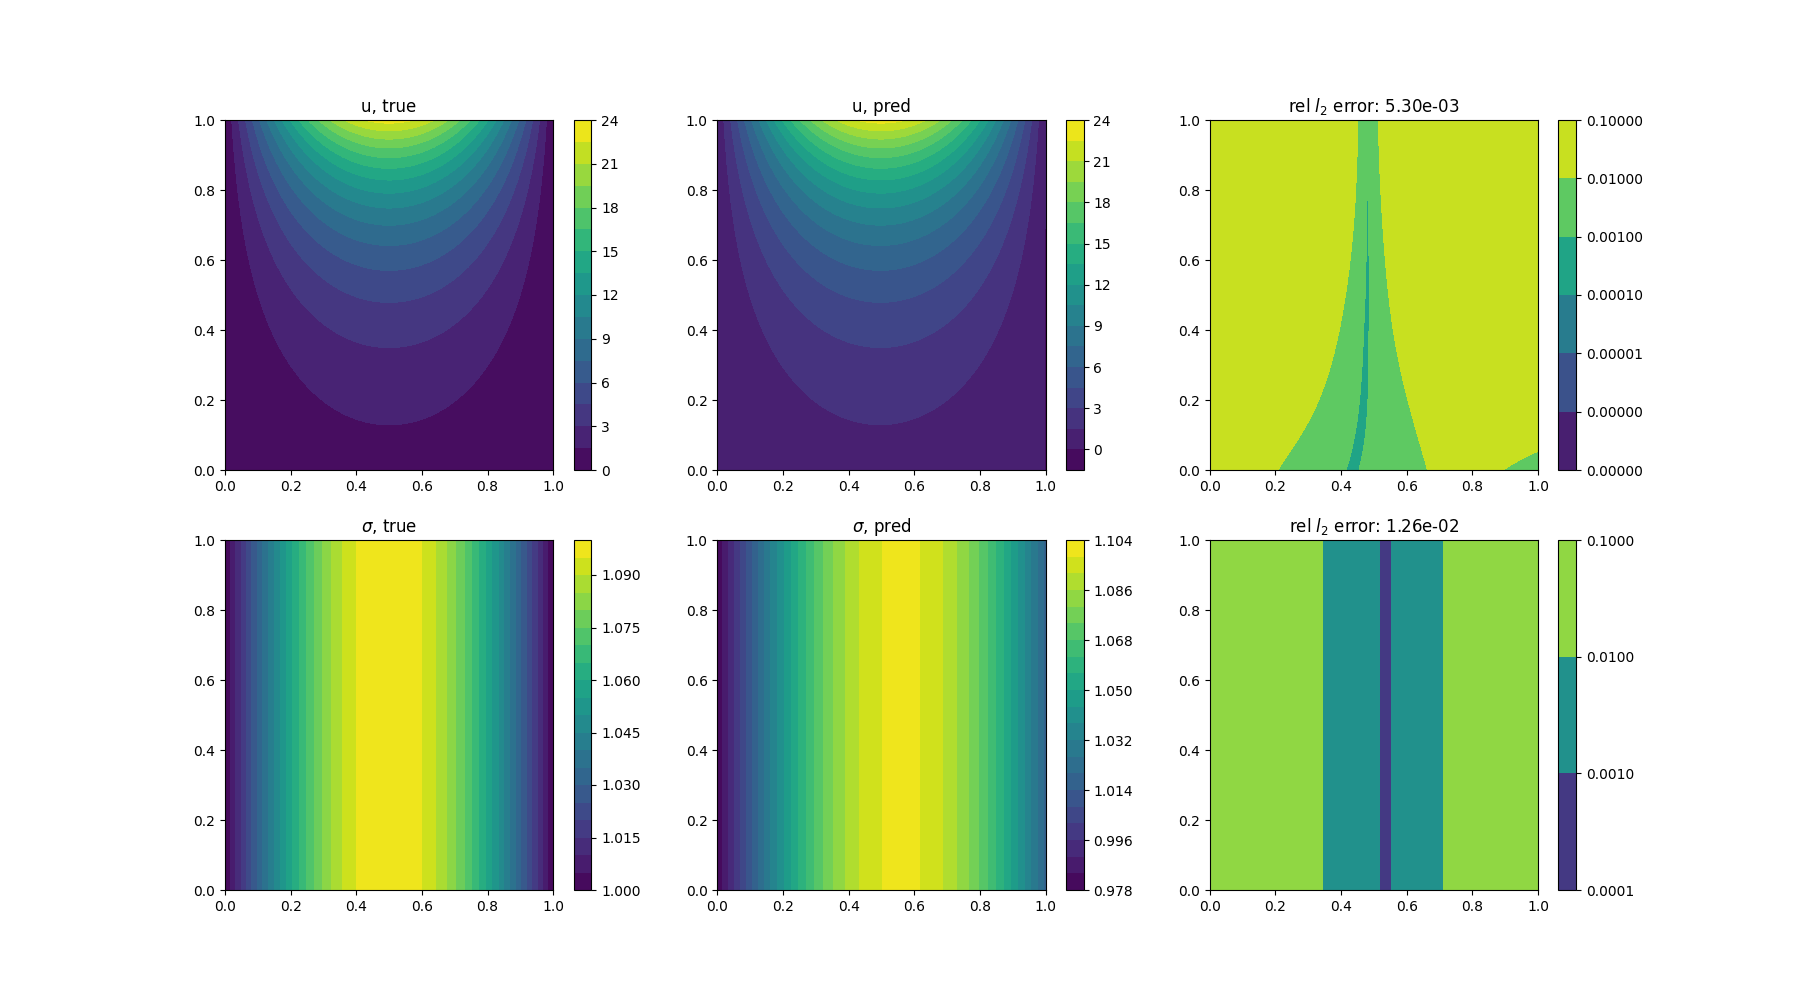

In [9]:
checkpoint_callback = trainer.callbacks[-1]
checkpoint = torch.load(checkpoint_callback.best_model_path)
pinn.load_state_dict(checkpoint["state_dict"])

x_test = torch.from_numpy(x_domain).to(pinn.device)
y_test = torch.from_numpy(y_domain).to(pinn.device)
u_test = u_fn(x_domain, y_domain).reshape((len(x_1d), len(y_1d))).T
# sigma_test = np.ones_like(u_test)
sigma_test = 1.0 + 0.1*np.sin(np.pi*x_domain).reshape((len(x_1d), len(y_1d))).T

with torch.no_grad():
	u_pred = pinn.forward(torch.hstack([x_test, y_test])).cpu().numpy().reshape((len(x_1d), len(y_1d))).T
	sigma_pred = pinn.inverse_module(torch.hstack([x_test, y_test])).cpu().numpy().reshape((len(x_1d), len(y_1d))).T
	
u_err = np.sqrt(np.mean((u_test - u_pred)**2))
u_norm = np.sqrt(np.mean(u_test**2))
sigma_err = np.sqrt(np.mean((sigma_test - sigma_pred)**2))
sigma_norm = np.sqrt(np.mean(sigma_test**2))

X, Y = np.meshgrid(x_1d, y_1d)
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker, cm
cmap = mpl.cm.viridis
	
fig, axes = plt.subplots(2, 3, figsize = (18, 10))

c0 = axes[0][0].contourf(X, Y, u_test, cmap = cmap, levels = 20)
c1 = axes[0][1].contourf(X, Y, u_pred, cmap = cmap, levels = 20)
c2 = axes[0][2].contourf(X, Y, np.abs(u_test - u_pred), cmap = cmap, norm = mpl.colors.LogNorm())
c3 = axes[1][0].contourf(X, Y, sigma_test, cmap = cmap, levels = 20)
c4 = axes[1][1].contourf(X, Y, sigma_pred, cmap = cmap, levels = 20)
c5 = axes[1][2].contourf(X, Y, np.abs(sigma_test - sigma_pred), cmap = cmap, norm = mpl.colors.LogNorm())
 
for c, ax in zip([c0, c1, c2], axes[0]):
    fig.colorbar(c, ax = ax)

for ax, name in zip(axes[0], ["u, true", "u, pred", "rel $l_2$ error: {:.2e}".format(u_err/u_norm)]):
    ax.set_title(name)
	
for c, ax in zip([c3, c4, c5], axes[1]):
    fig.colorbar(c, ax = ax)

for ax, name in zip(axes[1], ["$\sigma$, true", "$\sigma$, pred", "rel $l_2$ error: {:.2e}".format(sigma_err/sigma_norm)]):
    ax.set_title(name)